In [1]:
# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

from skimage.feature import hog

plt.gray()

In [2]:
cap = cv2.VideoCapture('/usagers2/jusimc/travail/Downloads/aic19-track3-train-data/2.mp4')
i = 0
ppc = 32
ori = 4
n_frames = int(cap.get(7))
max_frames = n_frames

n_blocks_row = int(cap.get(4)) // ppc
n_blocks_col = int(cap.get(3)) // ppc
fps = int(cap.get(5))
fds = np.zeros((n_blocks_row, n_blocks_col, ori, max_frames//fps + 1))
#while(cap.isOpened()):
j=0
while i < max_frames:
    ret, image = cap.read()
    if i%fps == 0:
        fd, hog_image = hog(image, orientations=ori,
                            pixels_per_cell=(ppc, ppc),
                            cells_per_block=(1, 1),
                            visualize=True, 
                            multichannel=True,
                            feature_vector=False)
        #shape of fd : (n_blocks_row, n_blocks_col, n_cells_row, n_cells_col, n_orient)
        fds[:,:,:,j] = fd.squeeze()
        j+=1
    i+=1
    print('\r',  (i/max_frames)*100 , end='')

cap.release()

/home/travail/jules/anaconda3/envs/retnet/lib/python3.6/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


 100.06271439224466564

(4, 895)


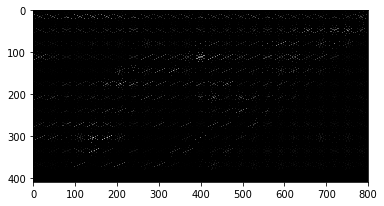

In [3]:
print(fds[0,0,:,:].shape)
plt.imshow(hog_image)

In [5]:
# Outlier detection
from pyod.models.iforest import IForest
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.auto_encoder import AutoEncoder

"""
clf = IForest(n_estimators = 100,
             max_samples = 1000,
             contamination = 0.01,
             max_features = ori,
             n_jobs = -1)
"""
clf = AutoEncoder(hidden_neurons = [ori, ori, ori, ori],
                 hidden_activation = 'relu',
                 output_activation = 'sigmoid',
                 optimizer = 'adam',
                 epochs = 100,
                 preprocessing = False,
                 contamination = 0.01)

"""
clf = ABOD(contamination = 0.005,
          n_neighbors = 8,
          method = 'fast')
"""

preds = {}
for i in range(n_blocks_row):
    for j in range (n_blocks_col):
        clf.fit(fds[i,j,:,:].T)
        preds[(i,j)] = np.argwhere(clf.predict(fds[i,j,:,:].T) == 1).ravel()
        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dropout_1 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 20        
_________________________________________________________________
dropout_3 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
__________

805/805 [==============================] - 0s 136us/step - loss: 0.7556 - val_loss: 0.7138
Epoch 61/100
805/805 [==============================] - 0s 108us/step - loss: 0.7402 - val_loss: 0.6994
Epoch 62/100
805/805 [==============================] - 0s 83us/step - loss: 0.7251 - val_loss: 0.6853
Epoch 63/100
805/805 [==============================] - 0s 108us/step - loss: 0.7105 - val_loss: 0.6716
Epoch 64/100
805/805 [==============================] - 0s 102us/step - loss: 0.6964 - val_loss: 0.6584
Epoch 65/100
805/805 [==============================] - 0s 113us/step - loss: 0.6826 - val_loss: 0.6455
Epoch 66/100
805/805 [==============================] - 0s 100us/step - loss: 0.6692 - val_loss: 0.6329
Epoch 67/100
805/805 [==============================] - 0s 121us/step - loss: 0.6562 - val_loss: 0.6208
Epoch 68/100
805/805 [==============================] - 0s 79us/step - loss: 0.6435 - val_loss: 0.6089
Epoch 69/100
805/805 [==============================] - 0s 109us/step - loss: 0

805/805 [==============================] - 0s 110us/step - loss: 1.6755 - val_loss: 1.5418
Epoch 20/100
805/805 [==============================] - 0s 98us/step - loss: 1.6013 - val_loss: 1.4882
Epoch 21/100
805/805 [==============================] - 0s 100us/step - loss: 1.5529 - val_loss: 1.4388
Epoch 22/100
805/805 [==============================] - 0s 91us/step - loss: 1.5116 - val_loss: 1.3925
Epoch 23/100
805/805 [==============================] - 0s 101us/step - loss: 1.4601 - val_loss: 1.3488
Epoch 24/100
805/805 [==============================] - 0s 99us/step - loss: 1.4215 - val_loss: 1.3081
Epoch 25/100
805/805 [==============================] - 0s 99us/step - loss: 1.3658 - val_loss: 1.2689
Epoch 26/100
805/805 [==============================] - 0s 83us/step - loss: 1.3467 - val_loss: 1.2327
Epoch 27/100
805/805 [==============================] - 0s 110us/step - loss: 1.2946 - val_loss: 1.1977
Epoch 28/100
805/805 [==============================] - 0s 99us/step - loss: 1.249

805/805 [==============================] - 0s 113us/step - loss: 0.3716 - val_loss: 0.3473
Epoch 99/100
805/805 [==============================] - 0s 155us/step - loss: 0.3655 - val_loss: 0.3431
Epoch 100/100
805/805 [==============================] - 0s 120us/step - loss: 0.3631 - val_loss: 0.3391
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 4)                 20        
_________________________________________________________________
dropout_13 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 20        
_________________________________________________________________
dropout_14 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 4)  

Epoch 57/100
805/805 [==============================] - 0s 99us/step - loss: 0.7943 - val_loss: 0.7493
Epoch 58/100
805/805 [==============================] - 0s 102us/step - loss: 0.7774 - val_loss: 0.7335
Epoch 59/100
805/805 [==============================] - 0s 102us/step - loss: 0.7610 - val_loss: 0.7181
Epoch 60/100
805/805 [==============================] - 0s 92us/step - loss: 0.7451 - val_loss: 0.7033
Epoch 61/100
805/805 [==============================] - 0s 114us/step - loss: 0.7296 - val_loss: 0.6888
Epoch 62/100
805/805 [==============================] - 0s 93us/step - loss: 0.7146 - val_loss: 0.6747
Epoch 63/100
805/805 [==============================] - 0s 116us/step - loss: 0.7000 - val_loss: 0.6611
Epoch 64/100
805/805 [==============================] - 0s 118us/step - loss: 0.6858 - val_loss: 0.6478
Epoch 65/100
805/805 [==============================] - 0s 121us/step - loss: 0.6720 - val_loss: 0.6349
Epoch 66/100
805/805 [==============================] - 0s 60us/ste

Epoch 16/100
805/805 [==============================] - 0s 119us/step - loss: 1.6700 - val_loss: 1.5374
Epoch 17/100
805/805 [==============================] - 0s 75us/step - loss: 1.6074 - val_loss: 1.4856
Epoch 18/100
805/805 [==============================] - 0s 80us/step - loss: 1.5697 - val_loss: 1.4373
Epoch 19/100
805/805 [==============================] - 0s 65us/step - loss: 1.5078 - val_loss: 1.3918
Epoch 20/100
805/805 [==============================] - 0s 71us/step - loss: 1.4799 - val_loss: 1.3492
Epoch 21/100
805/805 [==============================] - 0s 76us/step - loss: 1.4268 - val_loss: 1.3090
Epoch 22/100
805/805 [==============================] - 0s 95us/step - loss: 1.3779 - val_loss: 1.2709
Epoch 23/100
805/805 [==============================] - 0s 110us/step - loss: 1.3432 - val_loss: 1.2349
Epoch 24/100
805/805 [==============================] - 0s 66us/step - loss: 1.2987 - val_loss: 1.2006
Epoch 25/100
805/805 [==============================] - 0s 65us/step - 

805/805 [==============================] - 0s 69us/step - loss: 0.3700 - val_loss: 0.3482
Epoch 96/100
805/805 [==============================] - 0s 102us/step - loss: 0.3671 - val_loss: 0.3441
Epoch 97/100
805/805 [==============================] - 0s 97us/step - loss: 0.3666 - val_loss: 0.3400
Epoch 98/100
805/805 [==============================] - 0s 66us/step - loss: 0.3553 - val_loss: 0.3360
Epoch 99/100
805/805 [==============================] - 0s 73us/step - loss: 0.3526 - val_loss: 0.3321
Epoch 100/100
805/805 [==============================] - 0s 64us/step - loss: 0.3498 - val_loss: 0.3283
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 4)                 20        
_________________________________________________________________
dropout_25 (Dropout)         (None, 4)                 0         
_______________________________________________________________

Epoch 54/100
805/805 [==============================] - 0s 109us/step - loss: 0.8366 - val_loss: 0.7874
Epoch 55/100
805/805 [==============================] - 0s 86us/step - loss: 0.8182 - val_loss: 0.7701
Epoch 56/100
805/805 [==============================] - 0s 101us/step - loss: 0.8003 - val_loss: 0.7534
Epoch 57/100
805/805 [==============================] - 0s 100us/step - loss: 0.7829 - val_loss: 0.7371
Epoch 58/100
805/805 [==============================] - 0s 88us/step - loss: 0.7660 - val_loss: 0.7213
Epoch 59/100
805/805 [==============================] - 0s 104us/step - loss: 0.7496 - val_loss: 0.7060
Epoch 60/100
805/805 [==============================] - 0s 112us/step - loss: 0.7337 - val_loss: 0.6911
Epoch 61/100
805/805 [==============================] - 0s 105us/step - loss: 0.7182 - val_loss: 0.6766
Epoch 62/100
805/805 [==============================] - 0s 97us/step - loss: 0.7032 - val_loss: 0.6626
Epoch 63/100
805/805 [==============================] - 0s 114us/st

Epoch 13/100
805/805 [==============================] - 0s 88us/step - loss: 1.9032 - val_loss: 1.7675
Epoch 14/100
805/805 [==============================] - 0s 81us/step - loss: 1.8382 - val_loss: 1.6988
Epoch 15/100
805/805 [==============================] - 0s 74us/step - loss: 1.7525 - val_loss: 1.6342
Epoch 16/100
805/805 [==============================] - 0s 84us/step - loss: 1.7091 - val_loss: 1.5738
Epoch 17/100
805/805 [==============================] - 0s 82us/step - loss: 1.6442 - val_loss: 1.5174
Epoch 18/100
805/805 [==============================] - 0s 71us/step - loss: 1.5841 - val_loss: 1.4645
Epoch 19/100
805/805 [==============================] - 0s 83us/step - loss: 1.5219 - val_loss: 1.4149
Epoch 20/100
805/805 [==============================] - 0s 85us/step - loss: 1.4782 - val_loss: 1.3683
Epoch 21/100
805/805 [==============================] - 0s 72us/step - loss: 1.4295 - val_loss: 1.3243
Epoch 22/100
805/805 [==============================] - 0s 79us/step - lo

805/805 [==============================] - 0s 73us/step - loss: 0.3778 - val_loss: 0.3563
Epoch 93/100
805/805 [==============================] - 0s 65us/step - loss: 0.3751 - val_loss: 0.3520
Epoch 94/100
805/805 [==============================] - 0s 70us/step - loss: 0.3707 - val_loss: 0.3478
Epoch 95/100
805/805 [==============================] - 0s 65us/step - loss: 0.3649 - val_loss: 0.3437
Epoch 96/100
805/805 [==============================] - 0s 60us/step - loss: 0.3622 - val_loss: 0.3396
Epoch 97/100
805/805 [==============================] - 0s 64us/step - loss: 0.3593 - val_loss: 0.3355
Epoch 98/100
805/805 [==============================] - 0s 68us/step - loss: 0.3533 - val_loss: 0.3316
Epoch 99/100
805/805 [==============================] - 0s 82us/step - loss: 0.3474 - val_loss: 0.3277
Epoch 100/100
805/805 [==============================] - 0s 86us/step - loss: 0.3423 - val_loss: 0.3240
_________________________________________________________________
Layer (type)       

805/805 [==============================] - 0s 125us/step - loss: 0.8225 - val_loss: 0.7618
Epoch 52/100
805/805 [==============================] - 0s 99us/step - loss: 0.8115 - val_loss: 0.7465
Epoch 53/100
805/805 [==============================] - 0s 113us/step - loss: 0.7839 - val_loss: 0.7310
Epoch 54/100
805/805 [==============================] - 0s 109us/step - loss: 0.7765 - val_loss: 0.7168
Epoch 55/100
805/805 [==============================] - 0s 102us/step - loss: 0.7613 - val_loss: 0.7023
Epoch 56/100
805/805 [==============================] - 0s 108us/step - loss: 0.7413 - val_loss: 0.6883
Epoch 57/100
805/805 [==============================] - 0s 124us/step - loss: 0.7202 - val_loss: 0.6748
Epoch 58/100
805/805 [==============================] - 0s 126us/step - loss: 0.7226 - val_loss: 0.6626
Epoch 59/100
805/805 [==============================] - 0s 113us/step - loss: 0.7056 - val_loss: 0.6497
Epoch 60/100
805/805 [==============================] - 0s 111us/step - loss: 

Epoch 10/100
805/805 [==============================] - 0s 87us/step - loss: 3.9399 - val_loss: 3.4606
Epoch 11/100
805/805 [==============================] - 0s 96us/step - loss: 3.6450 - val_loss: 3.2405
Epoch 12/100
805/805 [==============================] - 0s 90us/step - loss: 3.4052 - val_loss: 3.0480
Epoch 13/100
805/805 [==============================] - 0s 101us/step - loss: 3.1965 - val_loss: 2.8771
Epoch 14/100
805/805 [==============================] - 0s 94us/step - loss: 3.0009 - val_loss: 2.7255
Epoch 15/100
805/805 [==============================] - 0s 103us/step - loss: 2.8392 - val_loss: 2.5894
Epoch 16/100
805/805 [==============================] - 0s 92us/step - loss: 2.6999 - val_loss: 2.4668
Epoch 17/100
805/805 [==============================] - 0s 76us/step - loss: 2.5725 - val_loss: 2.3553
Epoch 18/100
805/805 [==============================] - 0s 73us/step - loss: 2.4512 - val_loss: 2.2540
Epoch 19/100
805/805 [==============================] - 0s 76us/step - 

805/805 [==============================] - 0s 112us/step - loss: 0.4343 - val_loss: 0.4117
Epoch 90/100
805/805 [==============================] - 0s 104us/step - loss: 0.4273 - val_loss: 0.4051
Epoch 91/100
805/805 [==============================] - 0s 92us/step - loss: 0.4204 - val_loss: 0.3987
Epoch 92/100
805/805 [==============================] - 0s 115us/step - loss: 0.4137 - val_loss: 0.3924
Epoch 93/100
805/805 [==============================] - 0s 110us/step - loss: 0.4072 - val_loss: 0.3863
Epoch 94/100
805/805 [==============================] - 0s 114us/step - loss: 0.4008 - val_loss: 0.3803
Epoch 95/100
805/805 [==============================] - 0s 113us/step - loss: 0.3946 - val_loss: 0.3745
Epoch 96/100
805/805 [==============================] - 0s 90us/step - loss: 0.3886 - val_loss: 0.3689
Epoch 97/100
805/805 [==============================] - 0s 91us/step - loss: 0.3827 - val_loss: 0.3633
Epoch 98/100
805/805 [==============================] - 0s 96us/step - loss: 0.3

805/805 [==============================] - 0s 104us/step - loss: 0.9688 - val_loss: 0.9124
Epoch 49/100
805/805 [==============================] - 0s 114us/step - loss: 0.9467 - val_loss: 0.8918
Epoch 50/100
805/805 [==============================] - 0s 107us/step - loss: 0.9253 - val_loss: 0.8717
Epoch 51/100
805/805 [==============================] - 0s 98us/step - loss: 0.9045 - val_loss: 0.8523
Epoch 52/100
805/805 [==============================] - 0s 87us/step - loss: 0.8843 - val_loss: 0.8334
Epoch 53/100
805/805 [==============================] - 0s 112us/step - loss: 0.8648 - val_loss: 0.8151
Epoch 54/100
805/805 [==============================] - 0s 114us/step - loss: 0.8458 - val_loss: 0.7973
Epoch 55/100
805/805 [==============================] - 0s 94us/step - loss: 0.8273 - val_loss: 0.7801
Epoch 56/100
805/805 [==============================] - 0s 85us/step - loss: 0.8094 - val_loss: 0.7634
Epoch 57/100
805/805 [==============================] - 0s 95us/step - loss: 0.79

805/805 [==============================] - 0s 95us/step - loss: 2.4459 - val_loss: 2.2735
Epoch 8/100
805/805 [==============================] - 0s 110us/step - loss: 2.3622 - val_loss: 2.1777
Epoch 9/100
805/805 [==============================] - 0s 80us/step - loss: 2.2511 - val_loss: 2.0889
Epoch 10/100
805/805 [==============================] - 0s 82us/step - loss: 2.1613 - val_loss: 2.0065
Epoch 11/100
805/805 [==============================] - 0s 80us/step - loss: 2.0900 - val_loss: 1.9304
Epoch 12/100
805/805 [==============================] - 0s 70us/step - loss: 2.0229 - val_loss: 1.8596
Epoch 13/100
805/805 [==============================] - 0s 69us/step - loss: 1.9320 - val_loss: 1.7929
Epoch 14/100
805/805 [==============================] - 0s 116us/step - loss: 1.8661 - val_loss: 1.7304
Epoch 15/100
805/805 [==============================] - 0s 91us/step - loss: 1.8112 - val_loss: 1.6720
Epoch 16/100
805/805 [==============================] - 0s 97us/step - loss: 1.7663 - 

805/805 [==============================] - 0s 135us/step - loss: 0.4308 - val_loss: 0.3969
Epoch 87/100
805/805 [==============================] - 0s 123us/step - loss: 0.4209 - val_loss: 0.3914
Epoch 88/100
805/805 [==============================] - 0s 108us/step - loss: 0.4127 - val_loss: 0.3862
Epoch 89/100
805/805 [==============================] - 0s 110us/step - loss: 0.4098 - val_loss: 0.3811
Epoch 90/100
805/805 [==============================] - 0s 119us/step - loss: 0.4060 - val_loss: 0.3761
Epoch 91/100
805/805 [==============================] - 0s 123us/step - loss: 0.3952 - val_loss: 0.3710
Epoch 92/100
805/805 [==============================] - 0s 118us/step - loss: 0.3954 - val_loss: 0.3662
Epoch 93/100
805/805 [==============================] - 0s 119us/step - loss: 0.3888 - val_loss: 0.3615
Epoch 94/100
805/805 [==============================] - 0s 109us/step - loss: 0.3853 - val_loss: 0.3569
Epoch 95/100
805/805 [==============================] - 0s 109us/step - loss:

805/805 [==============================] - 0s 218us/step - loss: 0.9241 - val_loss: 0.8554
Epoch 46/100
805/805 [==============================] - 0s 225us/step - loss: 0.9116 - val_loss: 0.8369
Epoch 47/100
805/805 [==============================] - 0s 135us/step - loss: 0.8846 - val_loss: 0.8188
Epoch 48/100
805/805 [==============================] - 0s 93us/step - loss: 0.8668 - val_loss: 0.8014
Epoch 49/100
805/805 [==============================] - 0s 119us/step - loss: 0.8373 - val_loss: 0.7843
Epoch 50/100
805/805 [==============================] - 0s 129us/step - loss: 0.8280 - val_loss: 0.7683
Epoch 51/100
805/805 [==============================] - 0s 154us/step - loss: 0.8097 - val_loss: 0.7526
Epoch 52/100
805/805 [==============================] - 0s 147us/step - loss: 0.7969 - val_loss: 0.7375
Epoch 53/100
805/805 [==============================] - 0s 194us/step - loss: 0.7814 - val_loss: 0.7226
Epoch 54/100
805/805 [==============================] - 0s 119us/step - loss: 

Epoch 4/100
805/805 [==============================] - 0s 91us/step - loss: 3.0063 - val_loss: 2.7938
Epoch 5/100
805/805 [==============================] - 0s 76us/step - loss: 2.8819 - val_loss: 2.6814
Epoch 6/100
805/805 [==============================] - 0s 115us/step - loss: 2.7667 - val_loss: 2.5731
Epoch 7/100
805/805 [==============================] - 0s 133us/step - loss: 2.6532 - val_loss: 2.4672
Epoch 8/100
805/805 [==============================] - 0s 120us/step - loss: 2.5458 - val_loss: 2.3647
Epoch 9/100
805/805 [==============================] - 0s 132us/step - loss: 2.4363 - val_loss: 2.2657
Epoch 10/100
805/805 [==============================] - 0s 98us/step - loss: 2.3397 - val_loss: 2.1713
Epoch 11/100
805/805 [==============================] - 0s 82us/step - loss: 2.2501 - val_loss: 2.0821
Epoch 12/100
805/805 [==============================] - 0s 116us/step - loss: 2.1549 - val_loss: 1.9979
Epoch 13/100
805/805 [==============================] - 0s 129us/step - lo

805/805 [==============================] - 0s 138us/step - loss: 0.4298 - val_loss: 0.3991
Epoch 84/100
805/805 [==============================] - 0s 143us/step - loss: 0.4253 - val_loss: 0.3936
Epoch 85/100
805/805 [==============================] - 0s 127us/step - loss: 0.4184 - val_loss: 0.3880
Epoch 86/100
805/805 [==============================] - 0s 132us/step - loss: 0.4082 - val_loss: 0.3827
Epoch 87/100
805/805 [==============================] - 0s 139us/step - loss: 0.4041 - val_loss: 0.3775
Epoch 88/100
805/805 [==============================] - 0s 122us/step - loss: 0.4024 - val_loss: 0.3725
Epoch 89/100
805/805 [==============================] - 0s 137us/step - loss: 0.3982 - val_loss: 0.3674
Epoch 90/100
805/805 [==============================] - 0s 155us/step - loss: 0.3883 - val_loss: 0.3624
Epoch 91/100
805/805 [==============================] - 0s 131us/step - loss: 0.3817 - val_loss: 0.3576
Epoch 92/100
805/805 [==============================] - 0s 142us/step - loss:

Epoch 42/100
805/805 [==============================] - 0s 112us/step - loss: 0.9049 - val_loss: 0.8250
Epoch 43/100
805/805 [==============================] - 0s 168us/step - loss: 0.8799 - val_loss: 0.8077
Epoch 44/100
805/805 [==============================] - 0s 110us/step - loss: 0.8638 - val_loss: 0.7910
Epoch 45/100
805/805 [==============================] - 0s 101us/step - loss: 0.8353 - val_loss: 0.7747
Epoch 46/100
805/805 [==============================] - 0s 108us/step - loss: 0.8205 - val_loss: 0.7592
Epoch 47/100
805/805 [==============================] - 0s 107us/step - loss: 0.8205 - val_loss: 0.7441
Epoch 48/100
805/805 [==============================] - 0s 110us/step - loss: 0.7965 - val_loss: 0.7295
Epoch 49/100
805/805 [==============================] - 0s 98us/step - loss: 0.7724 - val_loss: 0.7151
Epoch 50/100
805/805 [==============================] - 0s 142us/step - loss: 0.7700 - val_loss: 0.7015
Epoch 51/100
805/805 [==============================] - 0s 99us/s

805/805 [==============================] - 2s 3ms/step - loss: 3.5279 - val_loss: 3.2041
Epoch 2/100
805/805 [==============================] - 0s 532us/step - loss: 3.3065 - val_loss: 3.0589
Epoch 3/100
805/805 [==============================] - 0s 125us/step - loss: 3.1611 - val_loss: 2.9407
Epoch 4/100
805/805 [==============================] - 0s 126us/step - loss: 3.0419 - val_loss: 2.8380
Epoch 5/100
805/805 [==============================] - 1s 1ms/step - loss: 2.9363 - val_loss: 2.7439
Epoch 6/100
805/805 [==============================] - 1s 2ms/step - loss: 2.8404 - val_loss: 2.6552
Epoch 7/100
805/805 [==============================] - 1s 1ms/step - loss: 2.7470 - val_loss: 2.5699
Epoch 8/100
805/805 [==============================] - 1s 2ms/step - loss: 2.6637 - val_loss: 2.4885
Epoch 9/100
805/805 [==============================] - 1s 2ms/step - loss: 2.5776 - val_loss: 2.4090
Epoch 10/100
805/805 [==============================] - 1s 2ms/step - loss: 2.4973 - val_loss: 2.

805/805 [==============================] - 0s 307us/step - loss: 0.4896 - val_loss: 0.4538
Epoch 82/100
805/805 [==============================] - 0s 128us/step - loss: 0.4766 - val_loss: 0.4466
Epoch 83/100
805/805 [==============================] - 0s 141us/step - loss: 0.4772 - val_loss: 0.4402
Epoch 84/100
805/805 [==============================] - 0s 133us/step - loss: 0.4636 - val_loss: 0.4332
Epoch 85/100
805/805 [==============================] - 0s 135us/step - loss: 0.4532 - val_loss: 0.4267
Epoch 86/100
805/805 [==============================] - 0s 162us/step - loss: 0.4515 - val_loss: 0.4206
Epoch 87/100
805/805 [==============================] - 0s 128us/step - loss: 0.4437 - val_loss: 0.4144
Epoch 88/100
805/805 [==============================] - 0s 101us/step - loss: 0.4362 - val_loss: 0.4084
Epoch 89/100
805/805 [==============================] - 0s 124us/step - loss: 0.4295 - val_loss: 0.4024
Epoch 90/100
805/805 [==============================] - 0s 112us/step - loss:

805/805 [==============================] - 0s 135us/step - loss: 0.9493 - val_loss: 0.8668
Epoch 40/100
805/805 [==============================] - 0s 122us/step - loss: 0.9315 - val_loss: 0.8482
Epoch 41/100
805/805 [==============================] - 0s 123us/step - loss: 0.9084 - val_loss: 0.8306
Epoch 42/100
805/805 [==============================] - 0s 126us/step - loss: 0.8840 - val_loss: 0.8131
Epoch 43/100
805/805 [==============================] - 0s 122us/step - loss: 0.8727 - val_loss: 0.7964
Epoch 44/100
805/805 [==============================] - 0s 120us/step - loss: 0.8663 - val_loss: 0.7804
Epoch 45/100
805/805 [==============================] - 0s 129us/step - loss: 0.8357 - val_loss: 0.7647
Epoch 46/100
805/805 [==============================] - 0s 127us/step - loss: 0.8282 - val_loss: 0.7495
Epoch 47/100
805/805 [==============================] - 0s 165us/step - loss: 0.8011 - val_loss: 0.7350
Epoch 48/100
805/805 [==============================] - 0s 149us/step - loss:

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 2s 3ms/step - loss: 3.2446 - val_loss: 2.9447
Epoch 2/100
805/805 [==============================] - 0s 165us/step - loss: 3.0206 - val_loss: 2.7869
Epoch 3/100
805/805 [==============================] - 0s 181us/step - loss: 2.8665 - val_loss: 2.6571
Epoch 4/100
805/805 [==============================] - 0s 166us/step - loss: 2.7435 - val_loss: 2.5378
Epoch 5/100
805/805 [==============================] - 0s 121us/step - loss: 2.6199 - val_loss: 2.4255
Epoch 6/100
805/805 [==============================] - 0s 120us/step - loss: 2.4956 - val_loss: 2.3192
Epoch 7/100
805/805 [==============================] - 0s 123us/step - loss: 2.3918 - val_loss: 2.2192
Epoch 8/100
805/805 [==============================] - 0s 125us/step - loss: 2.2956 - val_loss: 2.1264
Epoch 9/100
805/805 [==============================] - 0s 126us/step - loss: 2.2052 - val_loss: 2.0384
Epoch 10/100
805/805 [========

805/805 [==============================] - 0s 140us/step - loss: 0.4447 - val_loss: 0.4121
Epoch 80/100
805/805 [==============================] - 0s 107us/step - loss: 0.4365 - val_loss: 0.4061
Epoch 81/100
805/805 [==============================] - 0s 117us/step - loss: 0.4305 - val_loss: 0.4004
Epoch 82/100
805/805 [==============================] - 0s 107us/step - loss: 0.4264 - val_loss: 0.3947
Epoch 83/100
805/805 [==============================] - 0s 122us/step - loss: 0.4235 - val_loss: 0.3892
Epoch 84/100
805/805 [==============================] - 0s 110us/step - loss: 0.4124 - val_loss: 0.3836
Epoch 85/100
805/805 [==============================] - 0s 118us/step - loss: 0.4053 - val_loss: 0.3783
Epoch 86/100
805/805 [==============================] - 0s 125us/step - loss: 0.4081 - val_loss: 0.3732
Epoch 87/100
805/805 [==============================] - 0s 137us/step - loss: 0.3937 - val_loss: 0.3680
Epoch 88/100
805/805 [==============================] - 0s 127us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 150us/step - loss: 1.0291 - val_loss: 0.9519
Epoch 39/100
805/805 [==============================] - 0s 126us/step - loss: 1.0139 - val_loss: 0.9300
Epoch 40/100
805/805 [==============================] - 0s 109us/step - loss: 0.9894 - val_loss: 0.9091
Epoch 41/100
805/805 [==============================] - 0s 132us/step - loss: 0.9643 - val_loss: 0.8887
Epoch 42/100
805/805 [==============================] - 0s 60us/step - loss: 0.9427 - val_loss: 0.8693
Epoch 43/100
805/805 [==============================] - 0s 101us/step - loss: 0.9059 - val_loss: 0.8505
Epoch 44/100
805/805 [==============================] - 0s 71us/step - loss: 0.9035 - val_loss: 0.8329
Epoch 45/100
805/805 [==============================] - 0s 100us/step - loss: 0.8912 - val_loss: 0.8158
Epoch 46/100
805/805 [==============================] - 0s 94us/step - loss: 0.8561 - val_loss: 0.7988
Epoch 47/100
805/805 [==============================] - 0s 82us/ste

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 2s 3ms/step - loss: 3.4957 - val_loss: 3.1466
Epoch 2/100
805/805 [==============================] - 0s 109us/step - loss: 3.2551 - val_loss: 3.0112
Epoch 3/100
805/805 [==============================] - 0s 128us/step - loss: 3.1262 - val_loss: 2.9163
Epoch 4/100
805/805 [==============================] - 0s 116us/step - loss: 3.0290 - val_loss: 2.8320
Epoch 5/100
805/805 [==============================] - 0s 109us/step - loss: 2.9415 - val_loss: 2.7532
Epoch 6/100
805/805 [==============================] - 0s 120us/step - loss: 2.8587 - val_loss: 2.6780
Epoch 7/100
805/805 [==============================] - 0s 115us/step - loss: 2.7809 - val_loss: 2.6055
Epoch 8/100
805/805 [==============================] - 0s 119us/step - loss: 2.7045 - val_loss: 2.5352
Epoch 9/100
805/805 [==============================] - 0s 118us/step - loss: 2.6317 - val_loss: 2.4670
Epoch 10/100
805/805 [========

805/805 [==============================] - 0s 95us/step - loss: 0.5037 - val_loss: 0.4756
Epoch 80/100
805/805 [==============================] - 0s 112us/step - loss: 0.4946 - val_loss: 0.4671
Epoch 81/100
805/805 [==============================] - 0s 99us/step - loss: 0.4858 - val_loss: 0.4588
Epoch 82/100
805/805 [==============================] - 0s 104us/step - loss: 0.4771 - val_loss: 0.4507
Epoch 83/100
805/805 [==============================] - 0s 190us/step - loss: 0.4687 - val_loss: 0.4429
Epoch 84/100
805/805 [==============================] - 0s 208us/step - loss: 0.4605 - val_loss: 0.4352
Epoch 85/100
805/805 [==============================] - 0s 130us/step - loss: 0.4525 - val_loss: 0.4277
Epoch 86/100
805/805 [==============================] - 0s 123us/step - loss: 0.4448 - val_loss: 0.4204
Epoch 87/100
805/805 [==============================] - 0s 113us/step - loss: 0.4372 - val_loss: 0.4133
Epoch 88/100
805/805 [==============================] - 0s 107us/step - loss: 0

Epoch 38/100
805/805 [==============================] - 0s 113us/step - loss: 1.2201 - val_loss: 1.1467
Epoch 39/100
805/805 [==============================] - 0s 124us/step - loss: 1.1902 - val_loss: 1.1187
Epoch 40/100
805/805 [==============================] - 0s 106us/step - loss: 1.1611 - val_loss: 1.0915
Epoch 41/100
805/805 [==============================] - 0s 85us/step - loss: 1.1330 - val_loss: 1.0652
Epoch 42/100
805/805 [==============================] - 0s 92us/step - loss: 1.1057 - val_loss: 1.0396
Epoch 43/100
805/805 [==============================] - 0s 102us/step - loss: 1.0792 - val_loss: 1.0149
Epoch 44/100
805/805 [==============================] - 0s 106us/step - loss: 1.0535 - val_loss: 0.9908
Epoch 45/100
805/805 [==============================] - 0s 106us/step - loss: 1.0286 - val_loss: 0.9675
Epoch 46/100
805/805 [==============================] - 0s 114us/step - loss: 1.0044 - val_loss: 0.9449
Epoch 47/100
805/805 [==============================] - 0s 109us/s

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 2s 3ms/step - loss: 3.9765 - val_loss: 3.3873
Epoch 2/100
805/805 [==============================] - 0s 94us/step - loss: 3.5035 - val_loss: 3.1724
Epoch 3/100
805/805 [==============================] - 0s 109us/step - loss: 3.2887 - val_loss: 3.0359
Epoch 4/100
805/805 [==============================] - 0s 90us/step - loss: 3.1455 - val_loss: 2.9207
Epoch 5/100
805/805 [==============================] - 0s 86us/step - loss: 3.0267 - val_loss: 2.8192
Epoch 6/100
805/805 [==============================] - 0s 94us/step - loss: 2.9214 - val_loss: 2.7276
Epoch 7/100
805/805 [==============================] - 0s 91us/step - loss: 2.8267 - val_loss: 2.6436
Epoch 8/100
805/805 [==============================] - 0s 93us/step - loss: 2.7399 - val_loss: 2.5652
Epoch 9/100
805/805 [==============================] - 0s 91us/step - loss: 2.6590 - val_loss: 2.4910
Epoch 10/100
805/805 [===============

805/805 [==============================] - 0s 130us/step - loss: 0.5119 - val_loss: 0.4846
Epoch 80/100
805/805 [==============================] - 0s 99us/step - loss: 0.5028 - val_loss: 0.4761
Epoch 81/100
805/805 [==============================] - 0s 120us/step - loss: 0.4940 - val_loss: 0.4678
Epoch 82/100
805/805 [==============================] - 0s 123us/step - loss: 0.4853 - val_loss: 0.4597
Epoch 83/100
805/805 [==============================] - 0s 116us/step - loss: 0.4769 - val_loss: 0.4518
Epoch 84/100
805/805 [==============================] - 0s 110us/step - loss: 0.4687 - val_loss: 0.4441
Epoch 85/100
805/805 [==============================] - 0s 113us/step - loss: 0.4607 - val_loss: 0.4366
Epoch 86/100
805/805 [==============================] - 0s 131us/step - loss: 0.4529 - val_loss: 0.4294
Epoch 87/100
805/805 [==============================] - 0s 138us/step - loss: 0.4453 - val_loss: 0.4223
Epoch 88/100
805/805 [==============================] - 0s 106us/step - loss: 

Epoch 38/100
805/805 [==============================] - 0s 109us/step - loss: 1.1016 - val_loss: 1.0196
Epoch 39/100
805/805 [==============================] - 0s 120us/step - loss: 1.0860 - val_loss: 0.9961
Epoch 40/100
805/805 [==============================] - 0s 89us/step - loss: 1.0454 - val_loss: 0.9725
Epoch 41/100
805/805 [==============================] - 0s 95us/step - loss: 1.0214 - val_loss: 0.9502
Epoch 42/100
805/805 [==============================] - 0s 95us/step - loss: 1.0149 - val_loss: 0.9294
Epoch 43/100
805/805 [==============================] - 0s 91us/step - loss: 0.9880 - val_loss: 0.9085
Epoch 44/100
805/805 [==============================] - 0s 103us/step - loss: 0.9622 - val_loss: 0.8883
Epoch 45/100
805/805 [==============================] - 0s 114us/step - loss: 0.9469 - val_loss: 0.8689
Epoch 46/100
805/805 [==============================] - 0s 109us/step - loss: 0.9220 - val_loss: 0.8502
Epoch 47/100
805/805 [==============================] - 0s 103us/ste

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 3s 3ms/step - loss: 4.4012 - val_loss: 3.4477
Epoch 2/100
805/805 [==============================] - 0s 109us/step - loss: 3.5854 - val_loss: 3.1738
Epoch 3/100
805/805 [==============================] - 0s 105us/step - loss: 3.2907 - val_loss: 2.9753
Epoch 4/100
805/805 [==============================] - 0s 105us/step - loss: 3.0636 - val_loss: 2.7945
Epoch 5/100
805/805 [==============================] - 0s 113us/step - loss: 2.8756 - val_loss: 2.6417
Epoch 6/100
805/805 [==============================] - 0s 107us/step - loss: 2.7170 - val_loss: 2.5043
Epoch 7/100
805/805 [==============================] - 0s 107us/step - loss: 2.5813 - val_loss: 2.3797
Epoch 8/100
805/805 [==============================] - 0s 103us/step - loss: 2.4531 - val_loss: 2.2658
Epoch 9/100
805/805 [==============================] - 0s 101us/step - loss: 2.3321 - val_loss: 2.1608
Epoch 10/100
805/805 [========

805/805 [==============================] - 0s 147us/step - loss: 0.4620 - val_loss: 0.4298
Epoch 80/100
805/805 [==============================] - 0s 150us/step - loss: 0.4561 - val_loss: 0.4237
Epoch 81/100
805/805 [==============================] - 0s 153us/step - loss: 0.4479 - val_loss: 0.4178
Epoch 82/100
805/805 [==============================] - 0s 163us/step - loss: 0.4473 - val_loss: 0.4122
Epoch 83/100
805/805 [==============================] - 0s 161us/step - loss: 0.4374 - val_loss: 0.4064
Epoch 84/100
805/805 [==============================] - 0s 156us/step - loss: 0.4298 - val_loss: 0.4010
Epoch 85/100
805/805 [==============================] - 0s 141us/step - loss: 0.4244 - val_loss: 0.3956
Epoch 86/100
805/805 [==============================] - 0s 152us/step - loss: 0.4198 - val_loss: 0.3903
Epoch 87/100
805/805 [==============================] - 0s 138us/step - loss: 0.4146 - val_loss: 0.3851
Epoch 88/100
805/805 [==============================] - 0s 129us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 131us/step - loss: 1.0064 - val_loss: 0.9304
Epoch 39/100
805/805 [==============================] - 0s 100us/step - loss: 0.9853 - val_loss: 0.9095
Epoch 40/100
805/805 [==============================] - 0s 101us/step - loss: 0.9657 - val_loss: 0.8892
Epoch 41/100
805/805 [==============================] - 0s 106us/step - loss: 0.9326 - val_loss: 0.8697
Epoch 42/100
805/805 [==============================] - 0s 95us/step - loss: 0.9149 - val_loss: 0.8510
Epoch 43/100
805/805 [==============================] - 0s 106us/step - loss: 0.9055 - val_loss: 0.8330
Epoch 44/100
805/805 [==============================] - 0s 114us/step - loss: 0.8871 - val_loss: 0.8155
Epoch 45/100
805/805 [==============================] - 0s 137us/step - loss: 0.8634 - val_loss: 0.7985
Epoch 46/100
805/805 [==============================] - 0s 117us/step - loss: 0.8570 - val_loss: 0.7822
Epoch 47/100
805/805 [==============================] - 0s 98us/s

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 3s 4ms/step - loss: 4.0804 - val_loss: 3.6145
Epoch 2/100
805/805 [==============================] - 0s 131us/step - loss: 3.7042 - val_loss: 3.3841
Epoch 3/100
805/805 [==============================] - 0s 109us/step - loss: 3.4780 - val_loss: 3.2032
Epoch 4/100
805/805 [==============================] - 0s 95us/step - loss: 3.2898 - val_loss: 3.0383
Epoch 5/100
805/805 [==============================] - 0s 112us/step - loss: 3.1250 - val_loss: 2.8902
Epoch 6/100
805/805 [==============================] - 0s 133us/step - loss: 2.9727 - val_loss: 2.7554
Epoch 7/100
805/805 [==============================] - 0s 135us/step - loss: 2.8404 - val_loss: 2.6331
Epoch 8/100
805/805 [==============================] - 0s 154us/step - loss: 2.7098 - val_loss: 2.5213
Epoch 9/100
805/805 [==============================] - 0s 100us/step - loss: 2.6003 - val_loss: 2.4187
Epoch 10/100
805/805 [=========

805/805 [==============================] - 0s 128us/step - loss: 0.4783 - val_loss: 0.4419
Epoch 80/100
805/805 [==============================] - 0s 133us/step - loss: 0.4685 - val_loss: 0.4345
Epoch 81/100
805/805 [==============================] - 0s 124us/step - loss: 0.4562 - val_loss: 0.4273
Epoch 82/100
805/805 [==============================] - 0s 127us/step - loss: 0.4510 - val_loss: 0.4204
Epoch 83/100
805/805 [==============================] - 0s 114us/step - loss: 0.4428 - val_loss: 0.4138
Epoch 84/100
805/805 [==============================] - 0s 133us/step - loss: 0.4357 - val_loss: 0.4071
Epoch 85/100
805/805 [==============================] - 0s 107us/step - loss: 0.4239 - val_loss: 0.4007
Epoch 86/100
805/805 [==============================] - 0s 116us/step - loss: 0.4224 - val_loss: 0.3946
Epoch 87/100
805/805 [==============================] - 0s 97us/step - loss: 0.4143 - val_loss: 0.3885
Epoch 88/100
805/805 [==============================] - 0s 99us/step - loss: 0

Epoch 38/100
805/805 [==============================] - 0s 112us/step - loss: 0.8869 - val_loss: 0.8064
Epoch 39/100
805/805 [==============================] - 0s 148us/step - loss: 0.8646 - val_loss: 0.7887
Epoch 40/100
805/805 [==============================] - 0s 139us/step - loss: 0.8453 - val_loss: 0.7714
Epoch 41/100
805/805 [==============================] - 0s 115us/step - loss: 0.8235 - val_loss: 0.7550
Epoch 42/100
805/805 [==============================] - 0s 139us/step - loss: 0.8035 - val_loss: 0.7389
Epoch 43/100
805/805 [==============================] - 0s 124us/step - loss: 0.7941 - val_loss: 0.7235
Epoch 44/100
805/805 [==============================] - 0s 182us/step - loss: 0.7707 - val_loss: 0.7085
Epoch 45/100
805/805 [==============================] - 0s 138us/step - loss: 0.7587 - val_loss: 0.6942
Epoch 46/100
805/805 [==============================] - 0s 158us/step - loss: 0.7469 - val_loss: 0.6803
Epoch 47/100
805/805 [==============================] - 0s 167us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 3s 4ms/step - loss: 4.6309 - val_loss: 4.0326
Epoch 2/100
805/805 [==============================] - 0s 119us/step - loss: 4.0452 - val_loss: 3.5579
Epoch 3/100
805/805 [==============================] - 0s 124us/step - loss: 3.6083 - val_loss: 3.2268
Epoch 4/100
805/805 [==============================] - 0s 132us/step - loss: 3.3141 - val_loss: 2.9782
Epoch 5/100
805/805 [==============================] - 0s 123us/step - loss: 3.0696 - val_loss: 2.7701
Epoch 6/100
805/805 [==============================] - 0s 116us/step - loss: 2.8541 - val_loss: 2.5875
Epoch 7/100
805/805 [==============================] - 0s 116us/step - loss: 2.6589 - val_loss: 2.4235
Epoch 8/100
805/805 [==============================] - 0s 118us/step - loss: 2.4985 - val_loss: 2.2799
Epoch 9/100
805/805 [==============================] - 0s 114us/step - loss: 2.3566 - val_loss: 2.1503
Epoch 10/100
805/805 [========

805/805 [==============================] - 0s 129us/step - loss: 0.4593 - val_loss: 0.4271
Epoch 80/100
805/805 [==============================] - 0s 157us/step - loss: 0.4482 - val_loss: 0.4218
Epoch 81/100
805/805 [==============================] - 0s 110us/step - loss: 0.4468 - val_loss: 0.4165
Epoch 82/100
805/805 [==============================] - 0s 226us/step - loss: 0.4392 - val_loss: 0.4113
Epoch 83/100
805/805 [==============================] - 0s 166us/step - loss: 0.4332 - val_loss: 0.4065
Epoch 84/100
805/805 [==============================] - 0s 137us/step - loss: 0.4325 - val_loss: 0.4014
Epoch 85/100
805/805 [==============================] - 0s 125us/step - loss: 0.4241 - val_loss: 0.3966
Epoch 86/100
805/805 [==============================] - 0s 106us/step - loss: 0.4150 - val_loss: 0.3918
Epoch 87/100
805/805 [==============================] - 0s 136us/step - loss: 0.4130 - val_loss: 0.3871
Epoch 88/100
805/805 [==============================] - 0s 118us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 117us/step - loss: 0.9432 - val_loss: 0.8685
Epoch 39/100
805/805 [==============================] - 0s 113us/step - loss: 0.9168 - val_loss: 0.8486
Epoch 40/100
805/805 [==============================] - 0s 118us/step - loss: 0.9047 - val_loss: 0.8294
Epoch 41/100
805/805 [==============================] - 0s 121us/step - loss: 0.8716 - val_loss: 0.8108
Epoch 42/100
805/805 [==============================] - 0s 119us/step - loss: 0.8597 - val_loss: 0.7931
Epoch 43/100
805/805 [==============================] - 0s 113us/step - loss: 0.8467 - val_loss: 0.7761
Epoch 44/100
805/805 [==============================] - 0s 122us/step - loss: 0.8128 - val_loss: 0.7593
Epoch 45/100
805/805 [==============================] - 0s 119us/step - loss: 0.8038 - val_loss: 0.7435
Epoch 46/100
805/805 [==============================] - 0s 119us/step - loss: 0.7873 - val_loss: 0.7281
Epoch 47/100
805/805 [==============================] - 0s 112us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 3s 4ms/step - loss: 3.5457 - val_loss: 3.1498
Epoch 2/100
805/805 [==============================] - 0s 141us/step - loss: 3.1970 - val_loss: 2.9044
Epoch 3/100
805/805 [==============================] - 0s 110us/step - loss: 2.9809 - val_loss: 2.7386
Epoch 4/100
805/805 [==============================] - 0s 95us/step - loss: 2.8263 - val_loss: 2.6090
Epoch 5/100
805/805 [==============================] - 0s 119us/step - loss: 2.6902 - val_loss: 2.4943
Epoch 6/100
805/805 [==============================] - 0s 108us/step - loss: 2.5745 - val_loss: 2.3898
Epoch 7/100
805/805 [==============================] - 0s 169us/step - loss: 2.4726 - val_loss: 2.2931
Epoch 8/100
805/805 [==============================] - 0s 106us/step - loss: 2.3816 - val_loss: 2.2035
Epoch 9/100
805/805 [==============================] - 0s 169us/step - loss: 2.2870 - val_loss: 2.1196
Epoch 10/100
805/805 [=========

805/805 [==============================] - 0s 202us/step - loss: 0.4588 - val_loss: 0.4227
Epoch 80/100
805/805 [==============================] - 0s 253us/step - loss: 0.4477 - val_loss: 0.4160
Epoch 81/100
805/805 [==============================] - 0s 121us/step - loss: 0.4424 - val_loss: 0.4094
Epoch 82/100
805/805 [==============================] - 0s 122us/step - loss: 0.4416 - val_loss: 0.4032
Epoch 83/100
805/805 [==============================] - 0s 120us/step - loss: 0.4323 - val_loss: 0.3968
Epoch 84/100
805/805 [==============================] - 0s 160us/step - loss: 0.4292 - val_loss: 0.3907
Epoch 85/100
805/805 [==============================] - 0s 206us/step - loss: 0.4183 - val_loss: 0.3845
Epoch 86/100
805/805 [==============================] - 0s 184us/step - loss: 0.4105 - val_loss: 0.3784
Epoch 87/100
805/805 [==============================] - 0s 154us/step - loss: 0.4093 - val_loss: 0.3728
Epoch 88/100
805/805 [==============================] - 0s 171us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 180us/step - loss: 0.9865 - val_loss: 0.9000
Epoch 39/100
805/805 [==============================] - 0s 122us/step - loss: 0.9628 - val_loss: 0.8799
Epoch 40/100
805/805 [==============================] - 0s 134us/step - loss: 0.9472 - val_loss: 0.8605
Epoch 41/100
805/805 [==============================] - 0s 161us/step - loss: 0.9260 - val_loss: 0.8419
Epoch 42/100
805/805 [==============================] - 0s 168us/step - loss: 0.8969 - val_loss: 0.8237
Epoch 43/100
805/805 [==============================] - 0s 126us/step - loss: 0.8767 - val_loss: 0.8062
Epoch 44/100
805/805 [==============================] - 0s 121us/step - loss: 0.8637 - val_loss: 0.7895
Epoch 45/100
805/805 [==============================] - 0s 109us/step - loss: 0.8378 - val_loss: 0.7732
Epoch 46/100
805/805 [==============================] - 0s 158us/step - loss: 0.8309 - val_loss: 0.7575
Epoch 47/100
805/805 [==============================] - 0s 137us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 4s 5ms/step - loss: 5.9977 - val_loss: 4.6975
Epoch 2/100
805/805 [==============================] - 0s 207us/step - loss: 5.0039 - val_loss: 4.2598
Epoch 3/100
805/805 [==============================] - 0s 170us/step - loss: 4.4909 - val_loss: 3.9190
Epoch 4/100
805/805 [==============================] - 0s 146us/step - loss: 4.0812 - val_loss: 3.6312
Epoch 5/100
805/805 [==============================] - 0s 127us/step - loss: 3.7493 - val_loss: 3.3777
Epoch 6/100
805/805 [==============================] - 0s 122us/step - loss: 3.4716 - val_loss: 3.1505
Epoch 7/100
805/805 [==============================] - 0s 131us/step - loss: 3.2332 - val_loss: 2.9445
Epoch 8/100
805/805 [==============================] - 0s 127us/step - loss: 3.0126 - val_loss: 2.7605
Epoch 9/100
805/805 [==============================] - 0s 109us/step - loss: 2.8245 - val_loss: 2.5953
Epoch 10/100
805/805 [========

805/805 [==============================] - 0s 145us/step - loss: 0.4684 - val_loss: 0.4317
Epoch 80/100
805/805 [==============================] - 0s 132us/step - loss: 0.4582 - val_loss: 0.4252
Epoch 81/100
805/805 [==============================] - 0s 132us/step - loss: 0.4442 - val_loss: 0.4188
Epoch 82/100
805/805 [==============================] - 0s 136us/step - loss: 0.4391 - val_loss: 0.4126
Epoch 83/100
805/805 [==============================] - 0s 137us/step - loss: 0.4358 - val_loss: 0.4067
Epoch 84/100
805/805 [==============================] - 0s 159us/step - loss: 0.4290 - val_loss: 0.4007
Epoch 85/100
805/805 [==============================] - 0s 143us/step - loss: 0.4229 - val_loss: 0.3949
Epoch 86/100
805/805 [==============================] - 0s 155us/step - loss: 0.4158 - val_loss: 0.3893
Epoch 87/100
805/805 [==============================] - 0s 154us/step - loss: 0.4131 - val_loss: 0.3837
Epoch 88/100
805/805 [==============================] - 0s 156us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 256us/step - loss: 1.0780 - val_loss: 0.9972
Epoch 39/100
805/805 [==============================] - 0s 161us/step - loss: 1.0528 - val_loss: 0.9734
Epoch 40/100
805/805 [==============================] - 0s 168us/step - loss: 1.0234 - val_loss: 0.9501
Epoch 41/100
805/805 [==============================] - 0s 167us/step - loss: 1.0024 - val_loss: 0.9278
Epoch 42/100
805/805 [==============================] - 0s 245us/step - loss: 0.9831 - val_loss: 0.9066
Epoch 43/100
805/805 [==============================] - 0s 180us/step - loss: 0.9495 - val_loss: 0.8854
Epoch 44/100
805/805 [==============================] - 0s 170us/step - loss: 0.9434 - val_loss: 0.8659
Epoch 45/100
805/805 [==============================] - 0s 167us/step - loss: 0.9154 - val_loss: 0.8463
Epoch 46/100
805/805 [==============================] - 0s 160us/step - loss: 0.8905 - val_loss: 0.8272
Epoch 47/100
805/805 [==============================] - 0s 165us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 4s 5ms/step - loss: 3.2496 - val_loss: 3.0464
Epoch 2/100
805/805 [==============================] - 0s 185us/step - loss: 3.1607 - val_loss: 2.9673
Epoch 3/100
805/805 [==============================] - 0s 127us/step - loss: 3.0787 - val_loss: 2.8902
Epoch 4/100
805/805 [==============================] - 0s 171us/step - loss: 2.9986 - val_loss: 2.8149
Epoch 5/100
805/805 [==============================] - 0s 149us/step - loss: 2.9203 - val_loss: 2.7412
Epoch 6/100
805/805 [==============================] - 0s 141us/step - loss: 2.8437 - val_loss: 2.6691
Epoch 7/100
805/805 [==============================] - 0s 115us/step - loss: 2.7689 - val_loss: 2.5987
Epoch 8/100
805/805 [==============================] - 0s 114us/step - loss: 2.6958 - val_loss: 2.5300
Epoch 9/100
805/805 [==============================] - 0s 130us/step - loss: 2.6245 - val_loss: 2.4630
Epoch 10/100
805/805 [========

805/805 [==============================] - 0s 170us/step - loss: 0.5042 - val_loss: 0.4769
Epoch 80/100
805/805 [==============================] - 0s 171us/step - loss: 0.4951 - val_loss: 0.4684
Epoch 81/100
805/805 [==============================] - 0s 179us/step - loss: 0.4863 - val_loss: 0.4601
Epoch 82/100
805/805 [==============================] - 0s 163us/step - loss: 0.4776 - val_loss: 0.4520
Epoch 83/100
805/805 [==============================] - 0s 139us/step - loss: 0.4692 - val_loss: 0.4441
Epoch 84/100
805/805 [==============================] - 0s 208us/step - loss: 0.4610 - val_loss: 0.4364
Epoch 85/100
805/805 [==============================] - 0s 156us/step - loss: 0.4530 - val_loss: 0.4290
Epoch 86/100
805/805 [==============================] - 0s 154us/step - loss: 0.4453 - val_loss: 0.4217
Epoch 87/100
805/805 [==============================] - 0s 165us/step - loss: 0.4377 - val_loss: 0.4146
Epoch 88/100
805/805 [==============================] - 0s 166us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 125us/step - loss: 1.0678 - val_loss: 0.9804
Epoch 39/100
805/805 [==============================] - 0s 130us/step - loss: 1.0417 - val_loss: 0.9570
Epoch 40/100
805/805 [==============================] - 0s 131us/step - loss: 1.0047 - val_loss: 0.9340
Epoch 41/100
805/805 [==============================] - 0s 124us/step - loss: 0.9991 - val_loss: 0.9125
Epoch 42/100
805/805 [==============================] - 0s 128us/step - loss: 0.9713 - val_loss: 0.8913
Epoch 43/100
805/805 [==============================] - 0s 131us/step - loss: 0.9473 - val_loss: 0.8707
Epoch 44/100
805/805 [==============================] - 0s 142us/step - loss: 0.9306 - val_loss: 0.8513
Epoch 45/100
805/805 [==============================] - 0s 129us/step - loss: 0.8948 - val_loss: 0.8316
Epoch 46/100
805/805 [==============================] - 0s 154us/step - loss: 0.8773 - val_loss: 0.8132
Epoch 47/100
805/805 [==============================] - 0s 170us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 4s 6ms/step - loss: 3.5808 - val_loss: 3.3077
Epoch 2/100
805/805 [==============================] - 0s 170us/step - loss: 3.3902 - val_loss: 3.1484
Epoch 3/100
805/805 [==============================] - 0s 117us/step - loss: 3.2346 - val_loss: 3.0163
Epoch 4/100
805/805 [==============================] - 0s 129us/step - loss: 3.1054 - val_loss: 2.9024
Epoch 5/100
805/805 [==============================] - 0s 156us/step - loss: 2.9928 - val_loss: 2.8018
Epoch 6/100
805/805 [==============================] - 0s 149us/step - loss: 2.8925 - val_loss: 2.7109
Epoch 7/100
805/805 [==============================] - 0s 157us/step - loss: 2.8015 - val_loss: 2.6276
Epoch 8/100
805/805 [==============================] - 0s 140us/step - loss: 2.7177 - val_loss: 2.5501
Epoch 9/100
805/805 [==============================] - 0s 163us/step - loss: 2.6391 - val_loss: 2.4772
Epoch 10/100
805/805 [========

805/805 [==============================] - 0s 146us/step - loss: 0.5012 - val_loss: 0.4741
Epoch 80/100
805/805 [==============================] - 0s 158us/step - loss: 0.4921 - val_loss: 0.4656
Epoch 81/100
805/805 [==============================] - 0s 155us/step - loss: 0.4832 - val_loss: 0.4573
Epoch 82/100
805/805 [==============================] - 0s 180us/step - loss: 0.4746 - val_loss: 0.4492
Epoch 83/100
805/805 [==============================] - 0s 150us/step - loss: 0.4662 - val_loss: 0.4413
Epoch 84/100
805/805 [==============================] - 0s 149us/step - loss: 0.4580 - val_loss: 0.4337
Epoch 85/100
805/805 [==============================] - 0s 166us/step - loss: 0.4500 - val_loss: 0.4262
Epoch 86/100
805/805 [==============================] - 0s 148us/step - loss: 0.4422 - val_loss: 0.4189
Epoch 87/100
805/805 [==============================] - 0s 224us/step - loss: 0.4346 - val_loss: 0.4118
Epoch 88/100
805/805 [==============================] - 0s 152us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 202us/step - loss: 1.0807 - val_loss: 0.9999
Epoch 39/100
805/805 [==============================] - 0s 193us/step - loss: 1.0672 - val_loss: 0.9768
Epoch 40/100
805/805 [==============================] - 0s 197us/step - loss: 1.0373 - val_loss: 0.9541
Epoch 41/100
805/805 [==============================] - 0s 177us/step - loss: 1.0183 - val_loss: 0.9324
Epoch 42/100
805/805 [==============================] - 0s 264us/step - loss: 0.9906 - val_loss: 0.9111
Epoch 43/100
805/805 [==============================] - 0s 206us/step - loss: 0.9588 - val_loss: 0.8903
Epoch 44/100
805/805 [==============================] - 0s 167us/step - loss: 0.9514 - val_loss: 0.8709
Epoch 45/100
805/805 [==============================] - 0s 151us/step - loss: 0.9316 - val_loss: 0.8521
Epoch 46/100
805/805 [==============================] - 0s 192us/step - loss: 0.8942 - val_loss: 0.8332
Epoch 47/100
805/805 [==============================] - 0s 205us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 5s 6ms/step - loss: 3.5826 - val_loss: 3.2056
Epoch 2/100
805/805 [==============================] - 0s 165us/step - loss: 3.3066 - val_loss: 3.0576
Epoch 3/100
805/805 [==============================] - 0s 129us/step - loss: 3.1597 - val_loss: 2.9424
Epoch 4/100
805/805 [==============================] - 0s 142us/step - loss: 3.0430 - val_loss: 2.8417
Epoch 5/100
805/805 [==============================] - 0s 139us/step - loss: 2.9406 - val_loss: 2.7506
Epoch 6/100
805/805 [==============================] - 0s 143us/step - loss: 2.8480 - val_loss: 2.6663
Epoch 7/100
805/805 [==============================] - 0s 152us/step - loss: 2.7621 - val_loss: 2.5876
Epoch 8/100
805/805 [==============================] - 0s 149us/step - loss: 2.6815 - val_loss: 2.5133
Epoch 9/100
805/805 [==============================] - 0s 139us/step - loss: 2.6053 - val_loss: 2.4427
Epoch 10/100
805/805 [========

805/805 [==============================] - 0s 147us/step - loss: 0.4772 - val_loss: 0.4495
Epoch 80/100
805/805 [==============================] - 0s 153us/step - loss: 0.4681 - val_loss: 0.4410
Epoch 81/100
805/805 [==============================] - 0s 144us/step - loss: 0.4592 - val_loss: 0.4327
Epoch 82/100
805/805 [==============================] - 0s 138us/step - loss: 0.4506 - val_loss: 0.4246
Epoch 83/100
805/805 [==============================] - 0s 157us/step - loss: 0.4422 - val_loss: 0.4167
Epoch 84/100
805/805 [==============================] - 0s 180us/step - loss: 0.4340 - val_loss: 0.4091
Epoch 85/100
805/805 [==============================] - 0s 132us/step - loss: 0.4260 - val_loss: 0.4016
Epoch 86/100
805/805 [==============================] - 0s 179us/step - loss: 0.4183 - val_loss: 0.3943
Epoch 87/100
805/805 [==============================] - 0s 158us/step - loss: 0.4107 - val_loss: 0.3872
Epoch 88/100
805/805 [==============================] - 0s 162us/step - loss:

805/805 [==============================] - 0s 143us/step - loss: 1.2338 - val_loss: 1.1588
Epoch 38/100
805/805 [==============================] - 0s 131us/step - loss: 1.2029 - val_loss: 1.1299
Epoch 39/100
805/805 [==============================] - 0s 134us/step - loss: 1.1729 - val_loss: 1.1018
Epoch 40/100
805/805 [==============================] - 0s 134us/step - loss: 1.1439 - val_loss: 1.0746
Epoch 41/100
805/805 [==============================] - 0s 169us/step - loss: 1.1157 - val_loss: 1.0482
Epoch 42/100
805/805 [==============================] - 0s 142us/step - loss: 1.0884 - val_loss: 1.0227
Epoch 43/100
805/805 [==============================] - 0s 161us/step - loss: 1.0619 - val_loss: 0.9978
Epoch 44/100
805/805 [==============================] - 0s 131us/step - loss: 1.0362 - val_loss: 0.9738
Epoch 45/100
805/805 [==============================] - 0s 159us/step - loss: 1.0112 - val_loss: 0.9504
Epoch 46/100
805/805 [==============================] - 0s 169us/step - loss:

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 5s 6ms/step - loss: 3.4928 - val_loss: 3.1763
Epoch 2/100
805/805 [==============================] - 0s 154us/step - loss: 3.2451 - val_loss: 2.9878
Epoch 3/100
805/805 [==============================] - 0s 159us/step - loss: 3.0668 - val_loss: 2.8381
Epoch 4/100
805/805 [==============================] - 0s 156us/step - loss: 2.9240 - val_loss: 2.7111
Epoch 5/100
805/805 [==============================] - 0s 170us/step - loss: 2.7959 - val_loss: 2.5973
Epoch 6/100
805/805 [==============================] - 0s 135us/step - loss: 2.6829 - val_loss: 2.4928
Epoch 7/100
805/805 [==============================] - 0s 154us/step - loss: 2.5724 - val_loss: 2.3943
Epoch 8/100
805/805 [==============================] - 0s 151us/step - loss: 2.4713 - val_loss: 2.3005
Epoch 9/100
805/805 [==============================] - 0s 156us/step - loss: 2.3833 - val_loss: 2.2123
Epoch 10/100
805/805 [========

805/805 [==============================] - 0s 153us/step - loss: 0.4480 - val_loss: 0.4176
Epoch 80/100
805/805 [==============================] - 0s 141us/step - loss: 0.4483 - val_loss: 0.4113
Epoch 81/100
805/805 [==============================] - 0s 166us/step - loss: 0.4378 - val_loss: 0.4048
Epoch 82/100
805/805 [==============================] - 0s 142us/step - loss: 0.4277 - val_loss: 0.3986
Epoch 83/100
805/805 [==============================] - 0s 148us/step - loss: 0.4240 - val_loss: 0.3925
Epoch 84/100
805/805 [==============================] - 0s 154us/step - loss: 0.4146 - val_loss: 0.3866
Epoch 85/100
805/805 [==============================] - 0s 152us/step - loss: 0.4048 - val_loss: 0.3808
Epoch 86/100
805/805 [==============================] - 0s 161us/step - loss: 0.4054 - val_loss: 0.3753
Epoch 87/100
805/805 [==============================] - 0s 160us/step - loss: 0.3967 - val_loss: 0.3696
Epoch 88/100
805/805 [==============================] - 0s 144us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 124us/step - loss: 1.0756 - val_loss: 0.9904
Epoch 39/100
805/805 [==============================] - 0s 131us/step - loss: 1.0535 - val_loss: 0.9661
Epoch 40/100
805/805 [==============================] - 0s 124us/step - loss: 1.0238 - val_loss: 0.9424
Epoch 41/100
805/805 [==============================] - 0s 127us/step - loss: 0.9825 - val_loss: 0.9192
Epoch 42/100
805/805 [==============================] - 0s 127us/step - loss: 0.9726 - val_loss: 0.8979
Epoch 43/100
805/805 [==============================] - 0s 135us/step - loss: 0.9564 - val_loss: 0.8770
Epoch 44/100
805/805 [==============================] - 0s 126us/step - loss: 0.9263 - val_loss: 0.8565
Epoch 45/100
805/805 [==============================] - 0s 131us/step - loss: 0.9005 - val_loss: 0.8365
Epoch 46/100
805/805 [==============================] - 0s 133us/step - loss: 0.8782 - val_loss: 0.8175
Epoch 47/100
805/805 [==============================] - 0s 127us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 5s 6ms/step - loss: 4.2905 - val_loss: 3.7329
Epoch 2/100
805/805 [==============================] - 0s 160us/step - loss: 3.8682 - val_loss: 3.4574
Epoch 3/100
805/805 [==============================] - 0s 135us/step - loss: 3.5660 - val_loss: 3.2207
Epoch 4/100
805/805 [==============================] - 0s 141us/step - loss: 3.3125 - val_loss: 3.0185
Epoch 5/100
805/805 [==============================] - 0s 134us/step - loss: 3.1071 - val_loss: 2.8427
Epoch 6/100
805/805 [==============================] - 0s 123us/step - loss: 2.9241 - val_loss: 2.6855
Epoch 7/100
805/805 [==============================] - 0s 123us/step - loss: 2.7673 - val_loss: 2.5441
Epoch 8/100
805/805 [==============================] - 0s 127us/step - loss: 2.6104 - val_loss: 2.4155
Epoch 9/100
805/805 [==============================] - 0s 138us/step - loss: 2.4843 - val_loss: 2.2994
Epoch 10/100
805/805 [========

805/805 [==============================] - 0s 164us/step - loss: 0.4361 - val_loss: 0.4025
Epoch 80/100
805/805 [==============================] - 0s 156us/step - loss: 0.4254 - val_loss: 0.3960
Epoch 81/100
805/805 [==============================] - 0s 178us/step - loss: 0.4244 - val_loss: 0.3899
Epoch 82/100
805/805 [==============================] - 0s 171us/step - loss: 0.4126 - val_loss: 0.3835
Epoch 83/100
805/805 [==============================] - 0s 172us/step - loss: 0.4062 - val_loss: 0.3774
Epoch 84/100
805/805 [==============================] - 0s 156us/step - loss: 0.4008 - val_loss: 0.3715
Epoch 85/100
805/805 [==============================] - 0s 151us/step - loss: 0.3932 - val_loss: 0.3657
Epoch 86/100
805/805 [==============================] - 0s 168us/step - loss: 0.3869 - val_loss: 0.3601
Epoch 87/100
805/805 [==============================] - 0s 156us/step - loss: 0.3840 - val_loss: 0.3546
Epoch 88/100
805/805 [==============================] - 0s 150us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 181us/step - loss: 0.9893 - val_loss: 0.9040
Epoch 39/100
805/805 [==============================] - 0s 223us/step - loss: 0.9611 - val_loss: 0.8817
Epoch 40/100
805/805 [==============================] - 0s 143us/step - loss: 0.9380 - val_loss: 0.8609
Epoch 41/100
805/805 [==============================] - 0s 195us/step - loss: 0.9073 - val_loss: 0.8410
Epoch 42/100
805/805 [==============================] - 0s 160us/step - loss: 0.8983 - val_loss: 0.8217
Epoch 43/100
805/805 [==============================] - 0s 189us/step - loss: 0.8721 - val_loss: 0.8027
Epoch 44/100
805/805 [==============================] - 0s 136us/step - loss: 0.8523 - val_loss: 0.7847
Epoch 45/100
805/805 [==============================] - 0s 150us/step - loss: 0.8393 - val_loss: 0.7675
Epoch 46/100
805/805 [==============================] - 0s 143us/step - loss: 0.8165 - val_loss: 0.7505
Epoch 47/100
805/805 [==============================] - 0s 141us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 6s 7ms/step - loss: 3.8745 - val_loss: 3.4585
Epoch 2/100
805/805 [==============================] - 0s 131us/step - loss: 3.5462 - val_loss: 3.2446
Epoch 3/100
805/805 [==============================] - 0s 146us/step - loss: 3.3386 - val_loss: 3.0846
Epoch 4/100
805/805 [==============================] - 0s 122us/step - loss: 3.1774 - val_loss: 2.9505
Epoch 5/100
805/805 [==============================] - 0s 126us/step - loss: 3.0428 - val_loss: 2.8333
Epoch 6/100
805/805 [==============================] - 0s 121us/step - loss: 2.9246 - val_loss: 2.7282
Epoch 7/100
805/805 [==============================] - 0s 145us/step - loss: 2.8188 - val_loss: 2.6324
Epoch 8/100
805/805 [==============================] - 0s 138us/step - loss: 2.7222 - val_loss: 2.5443
Epoch 9/100
805/805 [==============================] - 0s 203us/step - loss: 2.6331 - val_loss: 2.4627
Epoch 10/100
805/805 [========

805/805 [==============================] - 0s 215us/step - loss: 0.4694 - val_loss: 0.4418
Epoch 80/100
805/805 [==============================] - 0s 140us/step - loss: 0.4603 - val_loss: 0.4333
Epoch 81/100
805/805 [==============================] - 0s 181us/step - loss: 0.4514 - val_loss: 0.4250
Epoch 82/100
805/805 [==============================] - 0s 220us/step - loss: 0.4428 - val_loss: 0.4170
Epoch 83/100
805/805 [==============================] - 0s 195us/step - loss: 0.4344 - val_loss: 0.4091
Epoch 84/100
805/805 [==============================] - 0s 228us/step - loss: 0.4262 - val_loss: 0.4014
Epoch 85/100
805/805 [==============================] - 0s 199us/step - loss: 0.4182 - val_loss: 0.3940
Epoch 86/100
805/805 [==============================] - 0s 199us/step - loss: 0.4104 - val_loss: 0.3867
Epoch 87/100
805/805 [==============================] - 0s 185us/step - loss: 0.4028 - val_loss: 0.3796
Epoch 88/100
805/805 [==============================] - 0s 141us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 155us/step - loss: 0.8812 - val_loss: 0.8063
Epoch 39/100
805/805 [==============================] - 0s 163us/step - loss: 0.8662 - val_loss: 0.7883
Epoch 40/100
805/805 [==============================] - 0s 156us/step - loss: 0.8462 - val_loss: 0.7710
Epoch 41/100
805/805 [==============================] - 0s 162us/step - loss: 0.8216 - val_loss: 0.7542
Epoch 42/100
805/805 [==============================] - 0s 144us/step - loss: 0.8124 - val_loss: 0.7383
Epoch 43/100
805/805 [==============================] - 0s 172us/step - loss: 0.7969 - val_loss: 0.7224
Epoch 44/100
805/805 [==============================] - 0s 189us/step - loss: 0.7710 - val_loss: 0.7073
Epoch 45/100
805/805 [==============================] - 0s 160us/step - loss: 0.7639 - val_loss: 0.6928
Epoch 46/100
805/805 [==============================] - 0s 212us/step - loss: 0.7428 - val_loss: 0.6785
Epoch 47/100
805/805 [==============================] - 0s 275us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 6s 7ms/step - loss: 3.7510 - val_loss: 3.2561
Epoch 2/100
805/805 [==============================] - 0s 165us/step - loss: 3.2963 - val_loss: 2.9835
Epoch 3/100
805/805 [==============================] - 0s 146us/step - loss: 3.0444 - val_loss: 2.7961
Epoch 4/100
805/805 [==============================] - 0s 149us/step - loss: 2.8668 - val_loss: 2.6420
Epoch 5/100
805/805 [==============================] - 0s 155us/step - loss: 2.7208 - val_loss: 2.5103
Epoch 6/100
805/805 [==============================] - 0s 146us/step - loss: 2.6028 - val_loss: 2.3937
Epoch 7/100
805/805 [==============================] - 0s 220us/step - loss: 2.4802 - val_loss: 2.2860
Epoch 8/100
805/805 [==============================] - 0s 248us/step - loss: 2.3562 - val_loss: 2.1856
Epoch 9/100
805/805 [==============================] - 0s 144us/step - loss: 2.2769 - val_loss: 2.0930
Epoch 10/100
805/805 [========

805/805 [==============================] - 0s 166us/step - loss: 0.4239 - val_loss: 0.3880
Epoch 80/100
805/805 [==============================] - 0s 164us/step - loss: 0.4104 - val_loss: 0.3821
Epoch 81/100
805/805 [==============================] - 0s 164us/step - loss: 0.4080 - val_loss: 0.3763
Epoch 82/100
805/805 [==============================] - 0s 187us/step - loss: 0.4029 - val_loss: 0.3708
Epoch 83/100
805/805 [==============================] - 0s 163us/step - loss: 0.3968 - val_loss: 0.3652
Epoch 84/100
805/805 [==============================] - 0s 479us/step - loss: 0.3922 - val_loss: 0.3597
Epoch 85/100
805/805 [==============================] - 0s 164us/step - loss: 0.3849 - val_loss: 0.3544
Epoch 86/100
805/805 [==============================] - 0s 166us/step - loss: 0.3770 - val_loss: 0.3493
Epoch 87/100
805/805 [==============================] - 0s 190us/step - loss: 0.3696 - val_loss: 0.3441
Epoch 88/100
805/805 [==============================] - 0s 196us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 166us/step - loss: 0.9880 - val_loss: 0.9143
Epoch 39/100
805/805 [==============================] - 0s 166us/step - loss: 0.9666 - val_loss: 0.8921
Epoch 40/100
805/805 [==============================] - 0s 142us/step - loss: 0.9451 - val_loss: 0.8713
Epoch 41/100
805/805 [==============================] - 0s 194us/step - loss: 0.9175 - val_loss: 0.8503
Epoch 42/100
805/805 [==============================] - 0s 172us/step - loss: 0.8940 - val_loss: 0.8307
Epoch 43/100
805/805 [==============================] - 0s 144us/step - loss: 0.8790 - val_loss: 0.8119
Epoch 44/100
805/805 [==============================] - 0s 143us/step - loss: 0.8697 - val_loss: 0.7937
Epoch 45/100
805/805 [==============================] - 0s 160us/step - loss: 0.8420 - val_loss: 0.7758
Epoch 46/100
805/805 [==============================] - 0s 138us/step - loss: 0.8202 - val_loss: 0.7586
Epoch 47/100
805/805 [==============================] - 0s 136us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 6s 8ms/step - loss: 3.8671 - val_loss: 3.4514
Epoch 2/100
805/805 [==============================] - 0s 165us/step - loss: 3.4735 - val_loss: 3.1737
Epoch 3/100
805/805 [==============================] - 0s 157us/step - loss: 3.2057 - val_loss: 2.9390
Epoch 4/100
805/805 [==============================] - 0s 141us/step - loss: 2.9813 - val_loss: 2.7483
Epoch 5/100
805/805 [==============================] - 0s 148us/step - loss: 2.7955 - val_loss: 2.5838
Epoch 6/100
805/805 [==============================] - 0s 149us/step - loss: 2.6417 - val_loss: 2.4398
Epoch 7/100
805/805 [==============================] - 0s 187us/step - loss: 2.5097 - val_loss: 2.3120
Epoch 8/100
805/805 [==============================] - 0s 194us/step - loss: 2.3747 - val_loss: 2.1958
Epoch 9/100
805/805 [==============================] - 0s 189us/step - loss: 2.2757 - val_loss: 2.0920
Epoch 10/100
805/805 [========

805/805 [==============================] - 0s 219us/step - loss: 0.4398 - val_loss: 0.4046
Epoch 80/100
805/805 [==============================] - 0s 199us/step - loss: 0.4297 - val_loss: 0.3986
Epoch 81/100
805/805 [==============================] - 0s 214us/step - loss: 0.4247 - val_loss: 0.3928
Epoch 82/100
805/805 [==============================] - 0s 198us/step - loss: 0.4180 - val_loss: 0.3871
Epoch 83/100
805/805 [==============================] - 0s 189us/step - loss: 0.4073 - val_loss: 0.3817
Epoch 84/100
805/805 [==============================] - 0s 197us/step - loss: 0.4119 - val_loss: 0.3761
Epoch 85/100
805/805 [==============================] - 0s 196us/step - loss: 0.3996 - val_loss: 0.3709
Epoch 86/100
805/805 [==============================] - 0s 175us/step - loss: 0.3899 - val_loss: 0.3656
Epoch 87/100
805/805 [==============================] - 0s 185us/step - loss: 0.3889 - val_loss: 0.3605
Epoch 88/100
805/805 [==============================] - 0s 169us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 199us/step - loss: 0.9759 - val_loss: 0.8676
Epoch 39/100
805/805 [==============================] - 0s 172us/step - loss: 0.9267 - val_loss: 0.8480
Epoch 40/100
805/805 [==============================] - 0s 156us/step - loss: 0.9002 - val_loss: 0.8294
Epoch 41/100
805/805 [==============================] - 0s 154us/step - loss: 0.8939 - val_loss: 0.8115
Epoch 42/100
805/805 [==============================] - 0s 182us/step - loss: 0.8642 - val_loss: 0.7942
Epoch 43/100
805/805 [==============================] - 0s 118us/step - loss: 0.8473 - val_loss: 0.7776
Epoch 44/100
805/805 [==============================] - 0s 140us/step - loss: 0.8357 - val_loss: 0.7614
Epoch 45/100
805/805 [==============================] - 0s 200us/step - loss: 0.8129 - val_loss: 0.7457
Epoch 46/100
805/805 [==============================] - 0s 179us/step - loss: 0.8104 - val_loss: 0.7306
Epoch 47/100
805/805 [==============================] - 0s 152us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 6s 8ms/step - loss: 8.0861 - val_loss: 6.3987
Epoch 2/100
805/805 [==============================] - 0s 154us/step - loss: 6.5849 - val_loss: 5.3854
Epoch 3/100
805/805 [==============================] - 0s 142us/step - loss: 5.5503 - val_loss: 4.6548
Epoch 4/100
805/805 [==============================] - 0s 172us/step - loss: 4.8151 - val_loss: 4.1173
Epoch 5/100
805/805 [==============================] - 0s 158us/step - loss: 4.2610 - val_loss: 3.7028
Epoch 6/100
805/805 [==============================] - 0s 175us/step - loss: 3.8441 - val_loss: 3.3718
Epoch 7/100
805/805 [==============================] - 0s 150us/step - loss: 3.5025 - val_loss: 3.1072
Epoch 8/100
805/805 [==============================] - 0s 152us/step - loss: 3.2280 - val_loss: 2.8912
Epoch 9/100
805/805 [==============================] - 0s 170us/step - loss: 3.0019 - val_loss: 2.7104
Epoch 10/100
805/805 [========

805/805 [==============================] - 0s 251us/step - loss: 0.4648 - val_loss: 0.4317
Epoch 80/100
805/805 [==============================] - 0s 211us/step - loss: 0.4595 - val_loss: 0.4246
Epoch 81/100
805/805 [==============================] - 0s 173us/step - loss: 0.4407 - val_loss: 0.4173
Epoch 82/100
805/805 [==============================] - 0s 208us/step - loss: 0.4394 - val_loss: 0.4107
Epoch 83/100
805/805 [==============================] - 0s 201us/step - loss: 0.4384 - val_loss: 0.4044
Epoch 84/100
805/805 [==============================] - 0s 188us/step - loss: 0.4306 - val_loss: 0.3978
Epoch 85/100
805/805 [==============================] - 0s 230us/step - loss: 0.4181 - val_loss: 0.3911
Epoch 86/100
805/805 [==============================] - 0s 173us/step - loss: 0.4149 - val_loss: 0.3851
Epoch 87/100
805/805 [==============================] - 0s 174us/step - loss: 0.4057 - val_loss: 0.3789
Epoch 88/100
805/805 [==============================] - 0s 185us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 181us/step - loss: 0.9945 - val_loss: 0.9139
Epoch 39/100
805/805 [==============================] - 0s 142us/step - loss: 0.9724 - val_loss: 0.8922
Epoch 40/100
805/805 [==============================] - 0s 188us/step - loss: 0.9444 - val_loss: 0.8712
Epoch 41/100
805/805 [==============================] - 0s 195us/step - loss: 0.9287 - val_loss: 0.8508
Epoch 42/100
805/805 [==============================] - 0s 198us/step - loss: 0.8987 - val_loss: 0.8315
Epoch 43/100
805/805 [==============================] - 0s 179us/step - loss: 0.8828 - val_loss: 0.8126
Epoch 44/100
805/805 [==============================] - 0s 190us/step - loss: 0.8689 - val_loss: 0.7946
Epoch 45/100
805/805 [==============================] - 0s 197us/step - loss: 0.8483 - val_loss: 0.7773
Epoch 46/100
805/805 [==============================] - 0s 160us/step - loss: 0.8276 - val_loss: 0.7600
Epoch 47/100
805/805 [==============================] - 0s 148us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 7s 9ms/step - loss: 3.3567 - val_loss: 3.0830
Epoch 2/100
805/805 [==============================] - 0s 147us/step - loss: 3.1863 - val_loss: 2.9694
Epoch 3/100
805/805 [==============================] - 0s 149us/step - loss: 3.0780 - val_loss: 2.8812
Epoch 4/100
805/805 [==============================] - 0s 148us/step - loss: 2.9885 - val_loss: 2.8011
Epoch 5/100
805/805 [==============================] - 0s 195us/step - loss: 2.9060 - val_loss: 2.7250
Epoch 6/100
805/805 [==============================] - 0s 214us/step - loss: 2.8274 - val_loss: 2.6515
Epoch 7/100
805/805 [==============================] - 0s 202us/step - loss: 2.7512 - val_loss: 2.5802
Epoch 8/100
805/805 [==============================] - 0s 191us/step - loss: 2.6774 - val_loss: 2.5108
Epoch 9/100
805/805 [==============================] - 0s 204us/step - loss: 2.6055 - val_loss: 2.4434
Epoch 10/100
805/805 [========

805/805 [==============================] - 0s 186us/step - loss: 0.4837 - val_loss: 0.4561
Epoch 80/100
805/805 [==============================] - 0s 169us/step - loss: 0.4746 - val_loss: 0.4475
Epoch 81/100
805/805 [==============================] - 0s 161us/step - loss: 0.4657 - val_loss: 0.4392
Epoch 82/100
805/805 [==============================] - 0s 162us/step - loss: 0.4571 - val_loss: 0.4312
Epoch 83/100
805/805 [==============================] - 0s 155us/step - loss: 0.4487 - val_loss: 0.4233
Epoch 84/100
805/805 [==============================] - 0s 172us/step - loss: 0.4405 - val_loss: 0.4156
Epoch 85/100
805/805 [==============================] - 0s 163us/step - loss: 0.4325 - val_loss: 0.4082
Epoch 86/100
805/805 [==============================] - 0s 170us/step - loss: 0.4247 - val_loss: 0.4009
Epoch 87/100
805/805 [==============================] - 0s 202us/step - loss: 0.4171 - val_loss: 0.3938
Epoch 88/100
805/805 [==============================] - 0s 173us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 152us/step - loss: 0.9356 - val_loss: 0.8684
Epoch 39/100
805/805 [==============================] - 0s 146us/step - loss: 0.9170 - val_loss: 0.8490
Epoch 40/100
805/805 [==============================] - 0s 148us/step - loss: 0.8993 - val_loss: 0.8305
Epoch 41/100
805/805 [==============================] - 0s 142us/step - loss: 0.8837 - val_loss: 0.8127
Epoch 42/100
805/805 [==============================] - 0s 146us/step - loss: 0.8601 - val_loss: 0.7953
Epoch 43/100
805/805 [==============================] - 0s 147us/step - loss: 0.8445 - val_loss: 0.7785
Epoch 44/100
805/805 [==============================] - 0s 153us/step - loss: 0.8230 - val_loss: 0.7623
Epoch 45/100
805/805 [==============================] - 0s 192us/step - loss: 0.8116 - val_loss: 0.7468
Epoch 46/100
805/805 [==============================] - 0s 218us/step - loss: 0.7882 - val_loss: 0.7317
Epoch 47/100
805/805 [==============================] - 0s 155us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 8s 10ms/step - loss: 3.8770 - val_loss: 3.4890
Epoch 2/100
805/805 [==============================] - 0s 167us/step - loss: 3.5358 - val_loss: 3.2203
Epoch 3/100
805/805 [==============================] - 0s 146us/step - loss: 3.2743 - val_loss: 2.9983
Epoch 4/100
805/805 [==============================] - 0s 140us/step - loss: 3.0599 - val_loss: 2.8063
Epoch 5/100
805/805 [==============================] - 0s 141us/step - loss: 2.8841 - val_loss: 2.6382
Epoch 6/100
805/805 [==============================] - 0s 148us/step - loss: 2.7100 - val_loss: 2.4865
Epoch 7/100
805/805 [==============================] - 0s 154us/step - loss: 2.5482 - val_loss: 2.3504
Epoch 8/100
805/805 [==============================] - 0s 154us/step - loss: 2.4398 - val_loss: 2.2304
Epoch 9/100
805/805 [==============================] - 0s 157us/step - loss: 2.3089 - val_loss: 2.1215
Epoch 10/100
805/805 [=======

805/805 [==============================] - 0s 191us/step - loss: 0.4463 - val_loss: 0.4155
Epoch 80/100
805/805 [==============================] - 0s 239us/step - loss: 0.4447 - val_loss: 0.4094
Epoch 81/100
805/805 [==============================] - 0s 220us/step - loss: 0.4379 - val_loss: 0.4031
Epoch 82/100
805/805 [==============================] - 0s 265us/step - loss: 0.4301 - val_loss: 0.3971
Epoch 83/100
805/805 [==============================] - 0s 226us/step - loss: 0.4198 - val_loss: 0.3913
Epoch 84/100
805/805 [==============================] - 0s 190us/step - loss: 0.4174 - val_loss: 0.3858
Epoch 85/100
805/805 [==============================] - 0s 263us/step - loss: 0.4110 - val_loss: 0.3800
Epoch 86/100
805/805 [==============================] - 0s 259us/step - loss: 0.4054 - val_loss: 0.3746
Epoch 87/100
805/805 [==============================] - 0s 376us/step - loss: 0.4014 - val_loss: 0.3692
Epoch 88/100
805/805 [==============================] - 0s 308us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 212us/step - loss: 1.0059 - val_loss: 0.9272
Epoch 39/100
805/805 [==============================] - 0s 206us/step - loss: 0.9883 - val_loss: 0.9055
Epoch 40/100
805/805 [==============================] - 0s 176us/step - loss: 0.9558 - val_loss: 0.8846
Epoch 41/100
805/805 [==============================] - 0s 187us/step - loss: 0.9382 - val_loss: 0.8644
Epoch 42/100
805/805 [==============================] - 0s 190us/step - loss: 0.9190 - val_loss: 0.8449
Epoch 43/100
805/805 [==============================] - 0s 209us/step - loss: 0.8953 - val_loss: 0.8261
Epoch 44/100
805/805 [==============================] - 0s 156us/step - loss: 0.8742 - val_loss: 0.8079
Epoch 45/100
805/805 [==============================] - 0s 150us/step - loss: 0.8601 - val_loss: 0.7906
Epoch 46/100
805/805 [==============================] - 0s 147us/step - loss: 0.8341 - val_loss: 0.7736
Epoch 47/100
805/805 [==============================] - 0s 181us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 8s 10ms/step - loss: 3.9777 - val_loss: 3.2731
Epoch 2/100
805/805 [==============================] - 0s 195us/step - loss: 3.3719 - val_loss: 3.0580
Epoch 3/100
805/805 [==============================] - 0s 161us/step - loss: 3.1568 - val_loss: 2.9230
Epoch 4/100
805/805 [==============================] - 0s 142us/step - loss: 3.0233 - val_loss: 2.8139
Epoch 5/100
805/805 [==============================] - 0s 153us/step - loss: 2.9114 - val_loss: 2.7163
Epoch 6/100
805/805 [==============================] - 0s 157us/step - loss: 2.8089 - val_loss: 2.6239
Epoch 7/100
805/805 [==============================] - 0s 145us/step - loss: 2.7140 - val_loss: 2.5359
Epoch 8/100
805/805 [==============================] - 0s 150us/step - loss: 2.6247 - val_loss: 2.4516
Epoch 9/100
805/805 [==============================] - 0s 175us/step - loss: 2.5316 - val_loss: 2.3693
Epoch 10/100
805/805 [=======

805/805 [==============================] - 0s 155us/step - loss: 0.4664 - val_loss: 0.4357
Epoch 80/100
805/805 [==============================] - 0s 152us/step - loss: 0.4592 - val_loss: 0.4286
Epoch 81/100
805/805 [==============================] - 0s 149us/step - loss: 0.4499 - val_loss: 0.4215
Epoch 82/100
805/805 [==============================] - 0s 154us/step - loss: 0.4418 - val_loss: 0.4147
Epoch 83/100
805/805 [==============================] - 0s 169us/step - loss: 0.4374 - val_loss: 0.4082
Epoch 84/100
805/805 [==============================] - 0s 163us/step - loss: 0.4250 - val_loss: 0.4015
Epoch 85/100
805/805 [==============================] - 0s 222us/step - loss: 0.4290 - val_loss: 0.3955
Epoch 86/100
805/805 [==============================] - 0s 200us/step - loss: 0.4171 - val_loss: 0.3891
Epoch 87/100
805/805 [==============================] - 0s 180us/step - loss: 0.4116 - val_loss: 0.3830
Epoch 88/100
805/805 [==============================] - 0s 319us/step - loss:

805/805 [==============================] - 0s 247us/step - loss: 1.0723 - val_loss: 0.9909
Epoch 38/100
805/805 [==============================] - 0s 327us/step - loss: 1.0484 - val_loss: 0.9665
Epoch 39/100
805/805 [==============================] - 0s 324us/step - loss: 1.0215 - val_loss: 0.9430
Epoch 40/100
805/805 [==============================] - 0s 310us/step - loss: 0.9867 - val_loss: 0.9199
Epoch 41/100
805/805 [==============================] - 0s 194us/step - loss: 0.9684 - val_loss: 0.8979
Epoch 42/100
805/805 [==============================] - 0s 203us/step - loss: 0.9567 - val_loss: 0.8772
Epoch 43/100
805/805 [==============================] - 0s 206us/step - loss: 0.9401 - val_loss: 0.8570
Epoch 44/100
805/805 [==============================] - 0s 200us/step - loss: 0.8943 - val_loss: 0.8364
Epoch 45/100
805/805 [==============================] - 0s 227us/step - loss: 0.8852 - val_loss: 0.8174
Epoch 46/100
805/805 [==============================] - 0s 240us/step - loss:

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 8s 10ms/step - loss: 3.1697 - val_loss: 2.9288
Epoch 2/100
805/805 [==============================] - 0s 162us/step - loss: 3.0167 - val_loss: 2.7982
Epoch 3/100
805/805 [==============================] - 0s 173us/step - loss: 2.8880 - val_loss: 2.6812
Epoch 4/100
805/805 [==============================] - 0s 182us/step - loss: 2.7724 - val_loss: 2.5718
Epoch 5/100
805/805 [==============================] - 0s 151us/step - loss: 2.6554 - val_loss: 2.4673
Epoch 6/100
805/805 [==============================] - 0s 282us/step - loss: 2.5712 - val_loss: 2.3693
Epoch 7/100
805/805 [==============================] - 0s 138us/step - loss: 2.4536 - val_loss: 2.2745
Epoch 8/100
805/805 [==============================] - 0s 149us/step - loss: 2.3535 - val_loss: 2.1839
Epoch 9/100
805/805 [==============================] - 0s 219us/step - loss: 2.2712 - val_loss: 2.0988
Epoch 10/100
805/805 [=======

805/805 [==============================] - 0s 388us/step - loss: 0.4284 - val_loss: 0.3945
Epoch 80/100
805/805 [==============================] - 0s 351us/step - loss: 0.4193 - val_loss: 0.3880
Epoch 81/100
805/805 [==============================] - 0s 358us/step - loss: 0.4121 - val_loss: 0.3818
Epoch 82/100
805/805 [==============================] - 0s 349us/step - loss: 0.4078 - val_loss: 0.3758
Epoch 83/100
805/805 [==============================] - 0s 469us/step - loss: 0.4028 - val_loss: 0.3698
Epoch 84/100
805/805 [==============================] - 0s 296us/step - loss: 0.3962 - val_loss: 0.3640
Epoch 85/100
805/805 [==============================] - 0s 303us/step - loss: 0.3872 - val_loss: 0.3582
Epoch 86/100
805/805 [==============================] - 0s 253us/step - loss: 0.3776 - val_loss: 0.3526
Epoch 87/100
805/805 [==============================] - 0s 196us/step - loss: 0.3783 - val_loss: 0.3473
Epoch 88/100
805/805 [==============================] - 0s 298us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 192us/step - loss: 0.8689 - val_loss: 0.8003
Epoch 39/100
805/805 [==============================] - 0s 165us/step - loss: 0.8613 - val_loss: 0.7824
Epoch 40/100
805/805 [==============================] - 0s 195us/step - loss: 0.8329 - val_loss: 0.7651
Epoch 41/100
805/805 [==============================] - 0s 172us/step - loss: 0.8164 - val_loss: 0.7486
Epoch 42/100
805/805 [==============================] - 0s 255us/step - loss: 0.8086 - val_loss: 0.7324
Epoch 43/100
805/805 [==============================] - 0s 334us/step - loss: 0.7920 - val_loss: 0.7169
Epoch 44/100
805/805 [==============================] - 0s 213us/step - loss: 0.7599 - val_loss: 0.7018
Epoch 45/100
805/805 [==============================] - 0s 204us/step - loss: 0.7468 - val_loss: 0.6873
Epoch 46/100
805/805 [==============================] - 0s 192us/step - loss: 0.7360 - val_loss: 0.6732
Epoch 47/100
805/805 [==============================] - 0s 142us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 9s 11ms/step - loss: 6.3362 - val_loss: 4.7298
Epoch 2/100
805/805 [==============================] - 0s 257us/step - loss: 5.0433 - val_loss: 4.0997
Epoch 3/100
805/805 [==============================] - 0s 146us/step - loss: 4.2696 - val_loss: 3.6736
Epoch 4/100
805/805 [==============================] - 0s 143us/step - loss: 3.8222 - val_loss: 3.3553
Epoch 5/100
805/805 [==============================] - 0s 167us/step - loss: 3.4826 - val_loss: 3.1035
Epoch 6/100
805/805 [==============================] - 0s 187us/step - loss: 3.2140 - val_loss: 2.8979
Epoch 7/100
805/805 [==============================] - 0s 249us/step - loss: 2.9940 - val_loss: 2.7238
Epoch 8/100
805/805 [==============================] - 0s 144us/step - loss: 2.8134 - val_loss: 2.5729
Epoch 9/100
805/805 [==============================] - 0s 148us/step - loss: 2.6606 - val_loss: 2.4401
Epoch 10/100
805/805 [=======

805/805 [==============================] - 0s 266us/step - loss: 0.4394 - val_loss: 0.4063
Epoch 80/100
805/805 [==============================] - 0s 308us/step - loss: 0.4320 - val_loss: 0.3997
Epoch 81/100
805/805 [==============================] - 0s 178us/step - loss: 0.4250 - val_loss: 0.3933
Epoch 82/100
805/805 [==============================] - 0s 193us/step - loss: 0.4159 - val_loss: 0.3869
Epoch 83/100
805/805 [==============================] - 0s 245us/step - loss: 0.4095 - val_loss: 0.3807
Epoch 84/100
805/805 [==============================] - 0s 248us/step - loss: 0.4022 - val_loss: 0.3748
Epoch 85/100
805/805 [==============================] - 0s 377us/step - loss: 0.3994 - val_loss: 0.3689
Epoch 86/100
805/805 [==============================] - 0s 281us/step - loss: 0.3914 - val_loss: 0.3631
Epoch 87/100
805/805 [==============================] - 0s 198us/step - loss: 0.3854 - val_loss: 0.3575
Epoch 88/100
805/805 [==============================] - 0s 212us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 195us/step - loss: 1.1894 - val_loss: 1.1154
Epoch 39/100
805/805 [==============================] - 0s 158us/step - loss: 1.1595 - val_loss: 1.0874
Epoch 40/100
805/805 [==============================] - 0s 160us/step - loss: 1.1304 - val_loss: 1.0602
Epoch 41/100
805/805 [==============================] - 0s 196us/step - loss: 1.1023 - val_loss: 1.0338
Epoch 42/100
805/805 [==============================] - 0s 256us/step - loss: 1.0749 - val_loss: 1.0083
Epoch 43/100
805/805 [==============================] - 0s 156us/step - loss: 1.0484 - val_loss: 0.9835
Epoch 44/100
805/805 [==============================] - 0s 152us/step - loss: 1.0228 - val_loss: 0.9594
Epoch 45/100
805/805 [==============================] - 0s 168us/step - loss: 0.9978 - val_loss: 0.9361
Epoch 46/100
805/805 [==============================] - 0s 162us/step - loss: 0.9737 - val_loss: 0.9135
Epoch 47/100
805/805 [==============================] - 0s 155us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 11s 14ms/step - loss: 3.4236 - val_loss: 3.0547
Epoch 2/100
805/805 [==============================] - 1s 1ms/step - loss: 3.0980 - val_loss: 2.8133
Epoch 3/100
805/805 [==============================] - 1s 1ms/step - loss: 2.8654 - val_loss: 2.6204
Epoch 4/100
805/805 [==============================] - 0s 609us/step - loss: 2.6814 - val_loss: 2.4565
Epoch 5/100
805/805 [==============================] - 1s 932us/step - loss: 2.5008 - val_loss: 2.3125
Epoch 6/100
805/805 [==============================] - 1s 750us/step - loss: 2.3874 - val_loss: 2.1857
Epoch 7/100
805/805 [==============================] - 1s 774us/step - loss: 2.2645 - val_loss: 2.0725
Epoch 8/100
805/805 [==============================] - 1s 887us/step - loss: 2.1581 - val_loss: 1.9718
Epoch 9/100
805/805 [==============================] - 1s 931us/step - loss: 2.0404 - val_loss: 1.8797
Epoch 10/100
805/805 [==========

Epoch 80/100
805/805 [==============================] - 1s 907us/step - loss: 0.4060 - val_loss: 0.3756
Epoch 81/100
805/805 [==============================] - 1s 839us/step - loss: 0.4007 - val_loss: 0.3701
Epoch 82/100
805/805 [==============================] - 1s 880us/step - loss: 0.3969 - val_loss: 0.3646
Epoch 83/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3879 - val_loss: 0.3592
Epoch 84/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3856 - val_loss: 0.3540
Epoch 85/100
805/805 [==============================] - 1s 954us/step - loss: 0.3757 - val_loss: 0.3489
Epoch 86/100
805/805 [==============================] - 1s 713us/step - loss: 0.3681 - val_loss: 0.3439
Epoch 87/100
805/805 [==============================] - 1s 632us/step - loss: 0.3726 - val_loss: 0.3390
Epoch 88/100
805/805 [==============================] - 0s 378us/step - loss: 0.3597 - val_loss: 0.3342
Epoch 89/100
805/805 [==============================] - 0s 410us/ste

Epoch 39/100
805/805 [==============================] - 1s 790us/step - loss: 0.9268 - val_loss: 0.8501
Epoch 40/100
805/805 [==============================] - 1s 715us/step - loss: 0.8940 - val_loss: 0.8309
Epoch 41/100
805/805 [==============================] - 1s 757us/step - loss: 0.9013 - val_loss: 0.8124
Epoch 42/100
805/805 [==============================] - 1s 683us/step - loss: 0.8721 - val_loss: 0.7941
Epoch 43/100
805/805 [==============================] - 1s 807us/step - loss: 0.8399 - val_loss: 0.7765
Epoch 44/100
805/805 [==============================] - 1s 665us/step - loss: 0.8365 - val_loss: 0.7596
Epoch 45/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8181 - val_loss: 0.7432
Epoch 46/100
805/805 [==============================] - 1s 872us/step - loss: 0.7885 - val_loss: 0.7274
Epoch 47/100
805/805 [==============================] - 1s 1ms/step - loss: 0.7922 - val_loss: 0.7121
Epoch 48/100
805/805 [==============================] - 1s 1ms/step 

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 12s 15ms/step - loss: 4.0315 - val_loss: 3.3328
Epoch 2/100
805/805 [==============================] - 0s 611us/step - loss: 3.3646 - val_loss: 3.0125
Epoch 3/100
805/805 [==============================] - 1s 1ms/step - loss: 3.0845 - val_loss: 2.8364
Epoch 4/100
805/805 [==============================] - 1s 727us/step - loss: 2.9197 - val_loss: 2.7094
Epoch 5/100
805/805 [==============================] - 1s 643us/step - loss: 2.7820 - val_loss: 2.5997
Epoch 6/100
805/805 [==============================] - 1s 1ms/step - loss: 2.6783 - val_loss: 2.5009
Epoch 7/100
805/805 [==============================] - 1s 995us/step - loss: 2.5861 - val_loss: 2.4100
Epoch 8/100
805/805 [==============================] - 1s 800us/step - loss: 2.4962 - val_loss: 2.3241
Epoch 9/100
805/805 [==============================] - 1s 646us/step - loss: 2.4086 - val_loss: 2.2430
Epoch 10/100
805/805 [==========

Epoch 80/100
805/805 [==============================] - 1s 953us/step - loss: 0.4541 - val_loss: 0.4212
Epoch 81/100
805/805 [==============================] - 1s 665us/step - loss: 0.4426 - val_loss: 0.4141
Epoch 82/100
805/805 [==============================] - 1s 789us/step - loss: 0.4419 - val_loss: 0.4075
Epoch 83/100
805/805 [==============================] - 1s 646us/step - loss: 0.4276 - val_loss: 0.4008
Epoch 84/100
805/805 [==============================] - 1s 860us/step - loss: 0.4217 - val_loss: 0.3943
Epoch 85/100
805/805 [==============================] - 1s 783us/step - loss: 0.4176 - val_loss: 0.3881
Epoch 86/100
805/805 [==============================] - 1s 922us/step - loss: 0.4070 - val_loss: 0.3819
Epoch 87/100
805/805 [==============================] - 1s 920us/step - loss: 0.4039 - val_loss: 0.3760
Epoch 88/100
805/805 [==============================] - 1s 923us/step - loss: 0.3951 - val_loss: 0.3701
Epoch 89/100
805/805 [==============================] - 1s 921us

Epoch 39/100
805/805 [==============================] - 0s 531us/step - loss: 0.9733 - val_loss: 0.8948
Epoch 40/100
805/805 [==============================] - 0s 473us/step - loss: 0.9451 - val_loss: 0.8734
Epoch 41/100
805/805 [==============================] - 1s 904us/step - loss: 0.9140 - val_loss: 0.8530
Epoch 42/100
805/805 [==============================] - 1s 925us/step - loss: 0.9026 - val_loss: 0.8338
Epoch 43/100
805/805 [==============================] - 1s 973us/step - loss: 0.8936 - val_loss: 0.8152
Epoch 44/100
805/805 [==============================] - 1s 955us/step - loss: 0.8634 - val_loss: 0.7966
Epoch 45/100
805/805 [==============================] - 1s 685us/step - loss: 0.8461 - val_loss: 0.7790
Epoch 46/100
805/805 [==============================] - 1s 912us/step - loss: 0.8361 - val_loss: 0.7622
Epoch 47/100
805/805 [==============================] - 1s 871us/step - loss: 0.8115 - val_loss: 0.7456
Epoch 48/100
805/805 [==============================] - 1s 867us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 12s 15ms/step - loss: 3.8182 - val_loss: 3.4341
Epoch 2/100
805/805 [==============================] - 1s 958us/step - loss: 3.5112 - val_loss: 3.2178
Epoch 3/100
805/805 [==============================] - 1s 672us/step - loss: 3.3018 - val_loss: 3.0518
Epoch 4/100
805/805 [==============================] - 1s 937us/step - loss: 3.1430 - val_loss: 2.9152
Epoch 5/100
805/805 [==============================] - 1s 808us/step - loss: 3.0092 - val_loss: 2.7998
Epoch 6/100
805/805 [==============================] - 1s 848us/step - loss: 2.8960 - val_loss: 2.7004
Epoch 7/100
805/805 [==============================] - 1s 897us/step - loss: 2.7967 - val_loss: 2.6123
Epoch 8/100
805/805 [==============================] - 1s 753us/step - loss: 2.7086 - val_loss: 2.5325
Epoch 9/100
805/805 [==============================] - 1s 865us/step - loss: 2.6274 - val_loss: 2.4586
Epoch 10/100
805/805 [======

805/805 [==============================] - 1s 848us/step - loss: 0.4748 - val_loss: 0.4473
Epoch 81/100
805/805 [==============================] - 1s 622us/step - loss: 0.4659 - val_loss: 0.4390
Epoch 82/100
805/805 [==============================] - 1s 844us/step - loss: 0.4572 - val_loss: 0.4309
Epoch 83/100
805/805 [==============================] - 1s 868us/step - loss: 0.4488 - val_loss: 0.4231
Epoch 84/100
805/805 [==============================] - 1s 929us/step - loss: 0.4407 - val_loss: 0.4154
Epoch 85/100
805/805 [==============================] - 1s 941us/step - loss: 0.4327 - val_loss: 0.4079
Epoch 86/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4249 - val_loss: 0.4006
Epoch 87/100
805/805 [==============================] - 1s 916us/step - loss: 0.4173 - val_loss: 0.3935
Epoch 88/100
805/805 [==============================] - 1s 797us/step - loss: 0.4099 - val_loss: 0.3866
Epoch 89/100
805/805 [==============================] - 1s 686us/step - loss: 0

805/805 [==============================] - 1s 1ms/step - loss: 1.0533 - val_loss: 0.9760
Epoch 40/100
805/805 [==============================] - 1s 1ms/step - loss: 1.0261 - val_loss: 0.9524
Epoch 41/100
805/805 [==============================] - 1s 883us/step - loss: 1.0068 - val_loss: 0.9301
Epoch 42/100
805/805 [==============================] - 1s 878us/step - loss: 0.9818 - val_loss: 0.9084
Epoch 43/100
805/805 [==============================] - 1s 647us/step - loss: 0.9720 - val_loss: 0.8879
Epoch 44/100
805/805 [==============================] - 1s 942us/step - loss: 0.9387 - val_loss: 0.8670
Epoch 45/100
805/805 [==============================] - 0s 582us/step - loss: 0.9042 - val_loss: 0.8468
Epoch 46/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8968 - val_loss: 0.8284
Epoch 47/100
805/805 [==============================] - 1s 743us/step - loss: 0.8670 - val_loss: 0.8098
Epoch 48/100
805/805 [==============================] - 1s 968us/step - loss: 0.855

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 13s 16ms/step - loss: 3.4175 - val_loss: 3.0924
Epoch 2/100
805/805 [==============================] - 1s 992us/step - loss: 3.1680 - val_loss: 2.9288
Epoch 3/100
805/805 [==============================] - 1s 1ms/step - loss: 3.0218 - val_loss: 2.8051
Epoch 4/100
805/805 [==============================] - 1s 970us/step - loss: 2.8954 - val_loss: 2.6893
Epoch 5/100
805/805 [==============================] - 1s 1ms/step - loss: 2.7751 - val_loss: 2.5762
Epoch 6/100
805/805 [==============================] - 0s 541us/step - loss: 2.6590 - val_loss: 2.4673
Epoch 7/100
805/805 [==============================] - 1s 992us/step - loss: 2.5489 - val_loss: 2.3625
Epoch 8/100
805/805 [==============================] - 1s 1ms/step - loss: 2.4282 - val_loss: 2.2608
Epoch 9/100
805/805 [==============================] - 1s 821us/step - loss: 2.3358 - val_loss: 2.1656
Epoch 10/100
805/805 [============

Epoch 80/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4623 - val_loss: 0.4314
Epoch 81/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4565 - val_loss: 0.4255
Epoch 82/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4457 - val_loss: 0.4198
Epoch 83/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4443 - val_loss: 0.4142
Epoch 84/100
805/805 [==============================] - 1s 875us/step - loss: 0.4352 - val_loss: 0.4087
Epoch 85/100
805/805 [==============================] - 1s 794us/step - loss: 0.4342 - val_loss: 0.4033
Epoch 86/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4234 - val_loss: 0.3980
Epoch 87/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4172 - val_loss: 0.3928
Epoch 88/100
805/805 [==============================] - 0s 620us/step - loss: 0.4147 - val_loss: 0.3878
Epoch 89/100
805/805 [==============================] - 1s 785us/step - loss

805/805 [==============================] - 1s 938us/step - loss: 1.0206 - val_loss: 0.9450
Epoch 40/100
805/805 [==============================] - 1s 922us/step - loss: 1.0076 - val_loss: 0.9241
Epoch 41/100
805/805 [==============================] - 1s 686us/step - loss: 0.9842 - val_loss: 0.9040
Epoch 42/100
805/805 [==============================] - 0s 496us/step - loss: 0.9594 - val_loss: 0.8844
Epoch 43/100
805/805 [==============================] - 1s 723us/step - loss: 0.9466 - val_loss: 0.8656
Epoch 44/100
805/805 [==============================] - 1s 751us/step - loss: 0.9205 - val_loss: 0.8474
Epoch 45/100
805/805 [==============================] - 1s 630us/step - loss: 0.9021 - val_loss: 0.8296
Epoch 46/100
805/805 [==============================] - 1s 930us/step - loss: 0.8998 - val_loss: 0.8127
Epoch 47/100
805/805 [==============================] - 1s 914us/step - loss: 0.8640 - val_loss: 0.7959
Epoch 48/100
805/805 [==============================] - 1s 1ms/step - loss: 0

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 14s 17ms/step - loss: 7.7358 - val_loss: 5.7995
Epoch 2/100
805/805 [==============================] - 0s 504us/step - loss: 5.7640 - val_loss: 4.7571
Epoch 3/100
805/805 [==============================] - 1s 986us/step - loss: 4.7761 - val_loss: 4.0787
Epoch 4/100
805/805 [==============================] - 1s 726us/step - loss: 4.1244 - val_loss: 3.6040
Epoch 5/100
805/805 [==============================] - 1s 853us/step - loss: 3.6620 - val_loss: 3.2532
Epoch 6/100
805/805 [==============================] - 1s 823us/step - loss: 3.2918 - val_loss: 2.9818
Epoch 7/100
805/805 [==============================] - 1s 821us/step - loss: 3.0355 - val_loss: 2.7646
Epoch 8/100
805/805 [==============================] - 1s 893us/step - loss: 2.8241 - val_loss: 2.5833
Epoch 9/100
805/805 [==============================] - 1s 956us/step - loss: 2.6401 - val_loss: 2.4315
Epoch 10/100
805/805 [======

805/805 [==============================] - 1s 1ms/step - loss: 0.4642 - val_loss: 0.4297
Epoch 81/100
805/805 [==============================] - 1s 948us/step - loss: 0.4467 - val_loss: 0.4234
Epoch 82/100
805/805 [==============================] - 1s 978us/step - loss: 0.4470 - val_loss: 0.4173
Epoch 83/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4347 - val_loss: 0.4113
Epoch 84/100
805/805 [==============================] - 1s 910us/step - loss: 0.4364 - val_loss: 0.4056
Epoch 85/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4321 - val_loss: 0.3997
Epoch 86/100
805/805 [==============================] - 1s 725us/step - loss: 0.4201 - val_loss: 0.3940
Epoch 87/100
805/805 [==============================] - 1s 650us/step - loss: 0.4182 - val_loss: 0.3886
Epoch 88/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4086 - val_loss: 0.3831
Epoch 89/100
805/805 [==============================] - 1s 780us/step - loss: 0.4031 

805/805 [==============================] - 1s 1ms/step - loss: 1.2033 - val_loss: 1.1273
Epoch 40/100
805/805 [==============================] - 1s 1ms/step - loss: 1.1743 - val_loss: 1.1001
Epoch 41/100
805/805 [==============================] - 1s 1ms/step - loss: 1.1461 - val_loss: 1.0737
Epoch 42/100
805/805 [==============================] - 1s 1ms/step - loss: 1.1188 - val_loss: 1.0481
Epoch 43/100
805/805 [==============================] - 1s 943us/step - loss: 1.0923 - val_loss: 1.0233
Epoch 44/100
805/805 [==============================] - 1s 834us/step - loss: 1.0666 - val_loss: 0.9993
Epoch 45/100
805/805 [==============================] - 1s 748us/step - loss: 1.0417 - val_loss: 0.9760
Epoch 46/100
805/805 [==============================] - 0s 574us/step - loss: 1.0175 - val_loss: 0.9533
Epoch 47/100
805/805 [==============================] - 1s 626us/step - loss: 0.9941 - val_loss: 0.9314
Epoch 48/100
805/805 [==============================] - 1s 701us/step - loss: 0.9713 

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 14s 17ms/step - loss: 4.7786 - val_loss: 3.6216
Epoch 2/100
805/805 [==============================] - 1s 792us/step - loss: 3.7673 - val_loss: 3.2118
Epoch 3/100
805/805 [==============================] - 1s 938us/step - loss: 3.3431 - val_loss: 2.9783
Epoch 4/100
805/805 [==============================] - 1s 789us/step - loss: 3.0928 - val_loss: 2.8143
Epoch 5/100
805/805 [==============================] - 1s 996us/step - loss: 2.9155 - val_loss: 2.6821
Epoch 6/100
805/805 [==============================] - 1s 971us/step - loss: 2.7936 - val_loss: 2.5676
Epoch 7/100
805/805 [==============================] - 1s 969us/step - loss: 2.6640 - val_loss: 2.4630
Epoch 8/100
805/805 [==============================] - 1s 918us/step - loss: 2.5493 - val_loss: 2.3658
Epoch 9/100
805/805 [==============================] - 1s 1ms/step - loss: 2.4614 - val_loss: 2.2770
Epoch 10/100
805/805 [========

805/805 [==============================] - 1s 1ms/step - loss: 0.4620 - val_loss: 0.4313
Epoch 81/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4562 - val_loss: 0.4244
Epoch 82/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4507 - val_loss: 0.4178
Epoch 83/100
805/805 [==============================] - 1s 931us/step - loss: 0.4462 - val_loss: 0.4113
Epoch 84/100
805/805 [==============================] - 1s 871us/step - loss: 0.4357 - val_loss: 0.4047
Epoch 85/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4305 - val_loss: 0.3984
Epoch 86/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4212 - val_loss: 0.3922
Epoch 87/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4148 - val_loss: 0.3861
Epoch 88/100
805/805 [==============================] - 1s 932us/step - loss: 0.4104 - val_loss: 0.3803
Epoch 89/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4087 - val_

805/805 [==============================] - 1s 724us/step - loss: 0.8603 - val_loss: 0.7899
Epoch 40/100
805/805 [==============================] - 1s 641us/step - loss: 0.8348 - val_loss: 0.7728
Epoch 41/100
805/805 [==============================] - 0s 540us/step - loss: 0.8229 - val_loss: 0.7564
Epoch 42/100
805/805 [==============================] - 1s 846us/step - loss: 0.8037 - val_loss: 0.7406
Epoch 43/100
805/805 [==============================] - 1s 1ms/step - loss: 0.7889 - val_loss: 0.7250
Epoch 44/100
805/805 [==============================] - 1s 901us/step - loss: 0.7666 - val_loss: 0.7101
Epoch 45/100
805/805 [==============================] - 1s 1ms/step - loss: 0.7636 - val_loss: 0.6957
Epoch 46/100
805/805 [==============================] - 1s 938us/step - loss: 0.7538 - val_loss: 0.6818
Epoch 47/100
805/805 [==============================] - 1s 819us/step - loss: 0.7254 - val_loss: 0.6682
Epoch 48/100
805/805 [==============================] - 1s 991us/step - loss: 0.7

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 14s 18ms/step - loss: 3.4495 - val_loss: 3.1637
Epoch 2/100
805/805 [==============================] - 0s 556us/step - loss: 3.2533 - val_loss: 3.0013
Epoch 3/100
805/805 [==============================] - 1s 908us/step - loss: 3.0927 - val_loss: 2.8620
Epoch 4/100
805/805 [==============================] - 1s 634us/step - loss: 2.9548 - val_loss: 2.7383
Epoch 5/100
805/805 [==============================] - 1s 728us/step - loss: 2.8242 - val_loss: 2.6248
Epoch 6/100
805/805 [==============================] - 1s 1ms/step - loss: 2.7174 - val_loss: 2.5212
Epoch 7/100
805/805 [==============================] - 1s 801us/step - loss: 2.6003 - val_loss: 2.4226
Epoch 8/100
805/805 [==============================] - 1s 1ms/step - loss: 2.5061 - val_loss: 2.3300
Epoch 9/100
805/805 [==============================] - 1s 1ms/step - loss: 2.4030 - val_loss: 2.2410
Epoch 10/100
805/805 [============

805/805 [==============================] - 1s 670us/step - loss: 0.4379 - val_loss: 0.4084
Epoch 81/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4413 - val_loss: 0.4022
Epoch 82/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4237 - val_loss: 0.3956
Epoch 83/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4197 - val_loss: 0.3896
Epoch 84/100
805/805 [==============================] - 1s 990us/step - loss: 0.4109 - val_loss: 0.3836
Epoch 85/100
805/805 [==============================] - 1s 971us/step - loss: 0.4044 - val_loss: 0.3779
Epoch 86/100
805/805 [==============================] - 1s 922us/step - loss: 0.3976 - val_loss: 0.3722
Epoch 87/100
805/805 [==============================] - 1s 987us/step - loss: 0.3977 - val_loss: 0.3667
Epoch 88/100
805/805 [==============================] - 1s 872us/step - loss: 0.3938 - val_loss: 0.3612
Epoch 89/100
805/805 [==============================] - 1s 795us/step - loss: 0.379

805/805 [==============================] - 1s 1ms/step - loss: 0.9699 - val_loss: 0.8981
Epoch 40/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9554 - val_loss: 0.8773
Epoch 41/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9394 - val_loss: 0.8571
Epoch 42/100
805/805 [==============================] - 1s 2ms/step - loss: 0.9043 - val_loss: 0.8376
Epoch 43/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8894 - val_loss: 0.8189
Epoch 44/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8668 - val_loss: 0.8008
Epoch 45/100
805/805 [==============================] - 1s 972us/step - loss: 0.8534 - val_loss: 0.7835
Epoch 46/100
805/805 [==============================] - 1s 708us/step - loss: 0.8310 - val_loss: 0.7666
Epoch 47/100
805/805 [==============================] - 1s 656us/step - loss: 0.8154 - val_loss: 0.7504
Epoch 48/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8073 - val_

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 15s 19ms/step - loss: 3.3224 - val_loss: 3.0578
Epoch 2/100
805/805 [==============================] - 1s 957us/step - loss: 3.1636 - val_loss: 2.9506
Epoch 3/100
805/805 [==============================] - 1s 889us/step - loss: 3.0573 - val_loss: 2.8595
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 2.9618 - val_loss: 2.7728
Epoch 5/100
805/805 [==============================] - 1s 956us/step - loss: 2.8741 - val_loss: 2.6886
Epoch 6/100
805/805 [==============================] - 1s 783us/step - loss: 2.7862 - val_loss: 2.6059
Epoch 7/100
805/805 [==============================] - 1s 1ms/step - loss: 2.6999 - val_loss: 2.5244
Epoch 8/100
805/805 [==============================] - 1s 1ms/step - loss: 2.6128 - val_loss: 2.4444
Epoch 9/100
805/805 [==============================] - 1s 1ms/step - loss: 2.5297 - val_loss: 2.3661
Epoch 10/100
805/805 [==============

Epoch 80/100
805/805 [==============================] - 0s 545us/step - loss: 0.4791 - val_loss: 0.4383
Epoch 81/100
805/805 [==============================] - 1s 706us/step - loss: 0.4631 - val_loss: 0.4307
Epoch 82/100
805/805 [==============================] - 0s 499us/step - loss: 0.4523 - val_loss: 0.4236
Epoch 83/100
805/805 [==============================] - 0s 606us/step - loss: 0.4484 - val_loss: 0.4171
Epoch 84/100
805/805 [==============================] - 1s 785us/step - loss: 0.4440 - val_loss: 0.4106
Epoch 85/100
805/805 [==============================] - 1s 992us/step - loss: 0.4426 - val_loss: 0.4045
Epoch 86/100
805/805 [==============================] - 0s 609us/step - loss: 0.4310 - val_loss: 0.3977
Epoch 87/100
805/805 [==============================] - 1s 857us/step - loss: 0.4188 - val_loss: 0.3912
Epoch 88/100
805/805 [==============================] - 1s 911us/step - loss: 0.4098 - val_loss: 0.3852
Epoch 89/100
805/805 [==============================] - 1s 834us

805/805 [==============================] - 1s 1ms/step - loss: 0.8989 - val_loss: 0.8377
Epoch 40/100
805/805 [==============================] - 1s 762us/step - loss: 0.8857 - val_loss: 0.8191
Epoch 41/100
805/805 [==============================] - 1s 875us/step - loss: 0.8722 - val_loss: 0.8010
Epoch 42/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8426 - val_loss: 0.7836
Epoch 43/100
805/805 [==============================] - 1s 897us/step - loss: 0.8278 - val_loss: 0.7670
Epoch 44/100
805/805 [==============================] - 1s 850us/step - loss: 0.8051 - val_loss: 0.7509
Epoch 45/100
805/805 [==============================] - 1s 855us/step - loss: 0.8050 - val_loss: 0.7353
Epoch 46/100
805/805 [==============================] - 1s 1ms/step - loss: 0.7833 - val_loss: 0.7202
Epoch 47/100
805/805 [==============================] - 1s 847us/step - loss: 0.7663 - val_loss: 0.7055
Epoch 48/100
805/805 [==============================] - 0s 475us/step - loss: 0.753

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 16s 19ms/step - loss: 3.4042 - val_loss: 3.0907
Epoch 2/100
805/805 [==============================] - 1s 1ms/step - loss: 3.1742 - val_loss: 2.9223
Epoch 3/100
805/805 [==============================] - 1s 948us/step - loss: 3.0023 - val_loss: 2.7771
Epoch 4/100
805/805 [==============================] - 1s 876us/step - loss: 2.8605 - val_loss: 2.6499
Epoch 5/100
805/805 [==============================] - 1s 935us/step - loss: 2.7353 - val_loss: 2.5341
Epoch 6/100
805/805 [==============================] - 1s 1ms/step - loss: 2.6119 - val_loss: 2.4252
Epoch 7/100
805/805 [==============================] - 1s 967us/step - loss: 2.5124 - val_loss: 2.3240
Epoch 8/100
805/805 [==============================] - 1s 854us/step - loss: 2.4028 - val_loss: 2.2283
Epoch 9/100
805/805 [==============================] - 1s 1ms/step - loss: 2.3010 - val_loss: 2.1381
Epoch 10/100
805/805 [============

805/805 [==============================] - 0s 257us/step - loss: 0.4536 - val_loss: 0.4185
Epoch 80/100
805/805 [==============================] - 0s 276us/step - loss: 0.4456 - val_loss: 0.4120
Epoch 81/100
805/805 [==============================] - 0s 239us/step - loss: 0.4418 - val_loss: 0.4057
Epoch 82/100
805/805 [==============================] - 0s 233us/step - loss: 0.4313 - val_loss: 0.3995
Epoch 83/100
805/805 [==============================] - 0s 218us/step - loss: 0.4252 - val_loss: 0.3935
Epoch 84/100
805/805 [==============================] - 0s 206us/step - loss: 0.4187 - val_loss: 0.3877
Epoch 85/100
805/805 [==============================] - 0s 206us/step - loss: 0.4133 - val_loss: 0.3820
Epoch 86/100
805/805 [==============================] - 0s 311us/step - loss: 0.4037 - val_loss: 0.3764
Epoch 87/100
805/805 [==============================] - 0s 236us/step - loss: 0.3995 - val_loss: 0.3709
Epoch 88/100
805/805 [==============================] - 0s 200us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 293us/step - loss: 1.0726 - val_loss: 0.9908
Epoch 39/100
805/805 [==============================] - 0s 289us/step - loss: 1.0525 - val_loss: 0.9669
Epoch 40/100
805/805 [==============================] - 0s 210us/step - loss: 1.0152 - val_loss: 0.9432
Epoch 41/100
805/805 [==============================] - 0s 180us/step - loss: 0.9971 - val_loss: 0.9207
Epoch 42/100
805/805 [==============================] - 0s 186us/step - loss: 0.9844 - val_loss: 0.8997
Epoch 43/100
805/805 [==============================] - 0s 287us/step - loss: 0.9495 - val_loss: 0.8781
Epoch 44/100
805/805 [==============================] - 0s 283us/step - loss: 0.9375 - val_loss: 0.8582
Epoch 45/100
805/805 [==============================] - 0s 235us/step - loss: 0.9041 - val_loss: 0.8382
Epoch 46/100
805/805 [==============================] - 0s 178us/step - loss: 0.8966 - val_loss: 0.8198
Epoch 47/100
805/805 [==============================] - 0s 171us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 14s 17ms/step - loss: 3.2102 - val_loss: 2.9487
Epoch 2/100
805/805 [==============================] - 0s 215us/step - loss: 3.0343 - val_loss: 2.8109
Epoch 3/100
805/805 [==============================] - 0s 201us/step - loss: 2.9019 - val_loss: 2.6910
Epoch 4/100
805/805 [==============================] - 0s 189us/step - loss: 2.7780 - val_loss: 2.5789
Epoch 5/100
805/805 [==============================] - 0s 196us/step - loss: 2.6739 - val_loss: 2.4735
Epoch 6/100
805/805 [==============================] - 0s 288us/step - loss: 2.5603 - val_loss: 2.3709
Epoch 7/100
805/805 [==============================] - 0s 301us/step - loss: 2.4540 - val_loss: 2.2730
Epoch 8/100
805/805 [==============================] - 0s 249us/step - loss: 2.3536 - val_loss: 2.1797
Epoch 9/100
805/805 [==============================] - 0s 178us/step - loss: 2.2559 - val_loss: 2.0908
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 347us/step - loss: 0.4349 - val_loss: 0.4082
Epoch 80/100
805/805 [==============================] - 0s 229us/step - loss: 0.4293 - val_loss: 0.4023
Epoch 81/100
805/805 [==============================] - 0s 339us/step - loss: 0.4278 - val_loss: 0.3964
Epoch 82/100
805/805 [==============================] - 0s 254us/step - loss: 0.4234 - val_loss: 0.3906
Epoch 83/100
805/805 [==============================] - 0s 405us/step - loss: 0.4144 - val_loss: 0.3850
Epoch 84/100
805/805 [==============================] - 0s 515us/step - loss: 0.4060 - val_loss: 0.3794
Epoch 85/100
805/805 [==============================] - 0s 307us/step - loss: 0.3984 - val_loss: 0.3741
Epoch 86/100
805/805 [==============================] - 0s 340us/step - loss: 0.3964 - val_loss: 0.3688
Epoch 87/100
805/805 [==============================] - 0s 282us/step - loss: 0.3914 - val_loss: 0.3637
Epoch 88/100
805/805 [==============================] - 0s 288us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 309us/step - loss: 0.9608 - val_loss: 0.8907
Epoch 39/100
805/805 [==============================] - 0s 182us/step - loss: 0.9520 - val_loss: 0.8700
Epoch 40/100
805/805 [==============================] - 0s 177us/step - loss: 0.9336 - val_loss: 0.8501
Epoch 41/100
805/805 [==============================] - 0s 324us/step - loss: 0.9134 - val_loss: 0.8303
Epoch 42/100
805/805 [==============================] - 0s 272us/step - loss: 0.9048 - val_loss: 0.8119
Epoch 43/100
805/805 [==============================] - 0s 266us/step - loss: 0.8653 - val_loss: 0.7935
Epoch 44/100
805/805 [==============================] - 0s 278us/step - loss: 0.8437 - val_loss: 0.7759
Epoch 45/100
805/805 [==============================] - 0s 343us/step - loss: 0.8222 - val_loss: 0.7589
Epoch 46/100
805/805 [==============================] - 0s 291us/step - loss: 0.8089 - val_loss: 0.7427
Epoch 47/100
805/805 [==============================] - 0s 256us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 15s 18ms/step - loss: 7.5591 - val_loss: 4.1862
Epoch 2/100
805/805 [==============================] - 0s 318us/step - loss: 4.5671 - val_loss: 3.3432
Epoch 3/100
805/805 [==============================] - 0s 318us/step - loss: 3.6313 - val_loss: 3.0785
Epoch 4/100
805/805 [==============================] - 0s 352us/step - loss: 3.2693 - val_loss: 2.9224
Epoch 5/100
805/805 [==============================] - 0s 233us/step - loss: 3.0634 - val_loss: 2.7932
Epoch 6/100
805/805 [==============================] - 0s 411us/step - loss: 2.9126 - val_loss: 2.6780
Epoch 7/100
805/805 [==============================] - 0s 497us/step - loss: 2.7968 - val_loss: 2.5728
Epoch 8/100
805/805 [==============================] - 0s 443us/step - loss: 2.6821 - val_loss: 2.4741
Epoch 9/100
805/805 [==============================] - 0s 407us/step - loss: 2.5710 - val_loss: 2.3808
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 214us/step - loss: 0.4591 - val_loss: 0.4263
Epoch 80/100
805/805 [==============================] - 0s 210us/step - loss: 0.4461 - val_loss: 0.4190
Epoch 81/100
805/805 [==============================] - 0s 311us/step - loss: 0.4456 - val_loss: 0.4123
Epoch 82/100
805/805 [==============================] - 0s 211us/step - loss: 0.4381 - val_loss: 0.4056
Epoch 83/100
805/805 [==============================] - 0s 207us/step - loss: 0.4298 - val_loss: 0.3989
Epoch 84/100
805/805 [==============================] - 0s 210us/step - loss: 0.4176 - val_loss: 0.3921
Epoch 85/100
805/805 [==============================] - 0s 223us/step - loss: 0.4183 - val_loss: 0.3862
Epoch 86/100
805/805 [==============================] - 0s 256us/step - loss: 0.4096 - val_loss: 0.3799
Epoch 87/100
805/805 [==============================] - 0s 372us/step - loss: 0.3985 - val_loss: 0.3736
Epoch 88/100
805/805 [==============================] - 0s 317us/step - loss:

805/805 [==============================] - 0s 421us/step - loss: 1.2410 - val_loss: 1.1647
Epoch 38/100
805/805 [==============================] - 1s 633us/step - loss: 1.2101 - val_loss: 1.1358
Epoch 39/100
805/805 [==============================] - 0s 269us/step - loss: 1.1801 - val_loss: 1.1078
Epoch 40/100
805/805 [==============================] - 0s 213us/step - loss: 1.1511 - val_loss: 1.0806
Epoch 41/100
805/805 [==============================] - 0s 241us/step - loss: 1.1229 - val_loss: 1.0543
Epoch 42/100
805/805 [==============================] - 0s 370us/step - loss: 1.0956 - val_loss: 1.0287
Epoch 43/100
805/805 [==============================] - 0s 564us/step - loss: 1.0691 - val_loss: 1.0039
Epoch 44/100
805/805 [==============================] - 0s 230us/step - loss: 1.0434 - val_loss: 0.9799
Epoch 45/100
805/805 [==============================] - 0s 256us/step - loss: 1.0184 - val_loss: 0.9566
Epoch 46/100
805/805 [==============================] - 0s 245us/step - loss:

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 16s 20ms/step - loss: 3.9612 - val_loss: 3.5206
Epoch 2/100
805/805 [==============================] - 0s 360us/step - loss: 3.5968 - val_loss: 3.2447
Epoch 3/100
805/805 [==============================] - 0s 285us/step - loss: 3.3138 - val_loss: 3.0218
Epoch 4/100
805/805 [==============================] - 0s 347us/step - loss: 3.1054 - val_loss: 2.8396
Epoch 5/100
805/805 [==============================] - 0s 417us/step - loss: 2.9166 - val_loss: 2.6861
Epoch 6/100
805/805 [==============================] - 0s 463us/step - loss: 2.7664 - val_loss: 2.5544
Epoch 7/100
805/805 [==============================] - 0s 524us/step - loss: 2.6356 - val_loss: 2.4401
Epoch 8/100
805/805 [==============================] - 0s 329us/step - loss: 2.5126 - val_loss: 2.3386
Epoch 9/100
805/805 [==============================] - 0s 346us/step - loss: 2.4243 - val_loss: 2.2476
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 213us/step - loss: 0.4551 - val_loss: 0.4256
Epoch 80/100
805/805 [==============================] - 0s 214us/step - loss: 0.4500 - val_loss: 0.4186
Epoch 81/100
805/805 [==============================] - 0s 389us/step - loss: 0.4462 - val_loss: 0.4120
Epoch 82/100
805/805 [==============================] - 0s 272us/step - loss: 0.4366 - val_loss: 0.4052
Epoch 83/100
805/805 [==============================] - 0s 261us/step - loss: 0.4315 - val_loss: 0.3987
Epoch 84/100
805/805 [==============================] - 0s 334us/step - loss: 0.4196 - val_loss: 0.3921
Epoch 85/100
805/805 [==============================] - 0s 303us/step - loss: 0.4166 - val_loss: 0.3859
Epoch 86/100
805/805 [==============================] - 0s 200us/step - loss: 0.4085 - val_loss: 0.3798
Epoch 87/100
805/805 [==============================] - 0s 204us/step - loss: 0.3969 - val_loss: 0.3738
Epoch 88/100
805/805 [==============================] - 0s 199us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 383us/step - loss: 1.2053 - val_loss: 1.1329
Epoch 39/100
805/805 [==============================] - 0s 221us/step - loss: 1.1752 - val_loss: 1.1048
Epoch 40/100
805/805 [==============================] - 0s 421us/step - loss: 1.1461 - val_loss: 1.0775
Epoch 41/100
805/805 [==============================] - 0s 286us/step - loss: 1.1179 - val_loss: 1.0511
Epoch 42/100
805/805 [==============================] - 0s 329us/step - loss: 1.0906 - val_loss: 1.0255
Epoch 43/100
805/805 [==============================] - 0s 405us/step - loss: 1.0641 - val_loss: 1.0007
Epoch 44/100
805/805 [==============================] - 1s 641us/step - loss: 1.0383 - val_loss: 0.9766
Epoch 45/100
805/805 [==============================] - 0s 278us/step - loss: 1.0133 - val_loss: 0.9533
Epoch 46/100
805/805 [==============================] - 0s 215us/step - loss: 0.9892 - val_loss: 0.9306
Epoch 47/100
805/805 [==============================] - 0s 204us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 16s 20ms/step - loss: 7.5281 - val_loss: 5.3666
Epoch 2/100
805/805 [==============================] - 0s 433us/step - loss: 5.3251 - val_loss: 4.2349
Epoch 3/100
805/805 [==============================] - 0s 314us/step - loss: 4.2613 - val_loss: 3.5632
Epoch 4/100
805/805 [==============================] - 0s 504us/step - loss: 3.6303 - val_loss: 3.1473
Epoch 5/100
805/805 [==============================] - 0s 502us/step - loss: 3.2220 - val_loss: 2.8804
Epoch 6/100
805/805 [==============================] - 0s 494us/step - loss: 2.9620 - val_loss: 2.6893
Epoch 7/100
805/805 [==============================] - 0s 361us/step - loss: 2.7685 - val_loss: 2.5376
Epoch 8/100
805/805 [==============================] - 0s 390us/step - loss: 2.6147 - val_loss: 2.4071
Epoch 9/100
805/805 [==============================] - 0s 259us/step - loss: 2.4700 - val_loss: 2.2913
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 207us/step - loss: 0.4626 - val_loss: 0.4288
Epoch 80/100
805/805 [==============================] - 0s 259us/step - loss: 0.4537 - val_loss: 0.4223
Epoch 81/100
805/805 [==============================] - 0s 214us/step - loss: 0.4494 - val_loss: 0.4159
Epoch 82/100
805/805 [==============================] - 0s 252us/step - loss: 0.4365 - val_loss: 0.4098
Epoch 83/100
805/805 [==============================] - 0s 275us/step - loss: 0.4357 - val_loss: 0.4038
Epoch 84/100
805/805 [==============================] - 0s 273us/step - loss: 0.4213 - val_loss: 0.3978
Epoch 85/100
805/805 [==============================] - 0s 416us/step - loss: 0.4196 - val_loss: 0.3922
Epoch 86/100
805/805 [==============================] - 0s 248us/step - loss: 0.4149 - val_loss: 0.3866
Epoch 87/100
805/805 [==============================] - 0s 202us/step - loss: 0.4080 - val_loss: 0.3811
Epoch 88/100
805/805 [==============================] - 0s 236us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 196us/step - loss: 1.2105 - val_loss: 1.1342
Epoch 39/100
805/805 [==============================] - 0s 314us/step - loss: 1.1805 - val_loss: 1.1062
Epoch 40/100
805/805 [==============================] - 0s 226us/step - loss: 1.1515 - val_loss: 1.0790
Epoch 41/100
805/805 [==============================] - 0s 202us/step - loss: 1.1233 - val_loss: 1.0526
Epoch 42/100
805/805 [==============================] - 0s 385us/step - loss: 1.0960 - val_loss: 1.0271
Epoch 43/100
805/805 [==============================] - 0s 240us/step - loss: 1.0695 - val_loss: 1.0023
Epoch 44/100
805/805 [==============================] - 0s 188us/step - loss: 1.0438 - val_loss: 0.9783
Epoch 45/100
805/805 [==============================] - 0s 263us/step - loss: 1.0189 - val_loss: 0.9549
Epoch 46/100
805/805 [==============================] - 0s 216us/step - loss: 0.9947 - val_loss: 0.9323
Epoch 47/100
805/805 [==============================] - 0s 442us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 17s 21ms/step - loss: 6.0319 - val_loss: 4.9546
Epoch 2/100
805/805 [==============================] - 0s 329us/step - loss: 5.1437 - val_loss: 4.3625
Epoch 3/100
805/805 [==============================] - 0s 279us/step - loss: 4.5134 - val_loss: 3.9244
Epoch 4/100
805/805 [==============================] - 0s 338us/step - loss: 4.0755 - val_loss: 3.5885
Epoch 5/100
805/805 [==============================] - 0s 285us/step - loss: 3.7190 - val_loss: 3.3220
Epoch 6/100
805/805 [==============================] - 0s 354us/step - loss: 3.4352 - val_loss: 3.1024
Epoch 7/100
805/805 [==============================] - 0s 403us/step - loss: 3.2054 - val_loss: 2.9164
Epoch 8/100
805/805 [==============================] - 0s 332us/step - loss: 3.0187 - val_loss: 2.7548
Epoch 9/100
805/805 [==============================] - 0s 392us/step - loss: 2.8471 - val_loss: 2.6126
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 275us/step - loss: 0.4962 - val_loss: 0.4635
Epoch 80/100
805/805 [==============================] - 0s 524us/step - loss: 0.4814 - val_loss: 0.4559
Epoch 81/100
805/805 [==============================] - 0s 310us/step - loss: 0.4764 - val_loss: 0.4490
Epoch 82/100
805/805 [==============================] - 0s 272us/step - loss: 0.4677 - val_loss: 0.4422
Epoch 83/100
805/805 [==============================] - 0s 297us/step - loss: 0.4661 - val_loss: 0.4357
Epoch 84/100
805/805 [==============================] - 0s 322us/step - loss: 0.4564 - val_loss: 0.4291
Epoch 85/100
805/805 [==============================] - 0s 264us/step - loss: 0.4534 - val_loss: 0.4227
Epoch 86/100
805/805 [==============================] - 0s 344us/step - loss: 0.4406 - val_loss: 0.4163
Epoch 87/100
805/805 [==============================] - 0s 219us/step - loss: 0.4362 - val_loss: 0.4103
Epoch 88/100
805/805 [==============================] - 0s 223us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 287us/step - loss: 1.2299 - val_loss: 1.1572
Epoch 39/100
805/805 [==============================] - 0s 374us/step - loss: 1.1999 - val_loss: 1.1292
Epoch 40/100
805/805 [==============================] - 0s 327us/step - loss: 1.1709 - val_loss: 1.1020
Epoch 41/100
805/805 [==============================] - 0s 312us/step - loss: 1.1427 - val_loss: 1.0757
Epoch 42/100
805/805 [==============================] - 0s 372us/step - loss: 1.1154 - val_loss: 1.0501
Epoch 43/100
805/805 [==============================] - 0s 402us/step - loss: 1.0889 - val_loss: 1.0253
Epoch 44/100
805/805 [==============================] - 0s 357us/step - loss: 1.0632 - val_loss: 1.0013
Epoch 45/100
805/805 [==============================] - 0s 355us/step - loss: 1.0383 - val_loss: 0.9780
Epoch 46/100
805/805 [==============================] - 0s 368us/step - loss: 1.0141 - val_loss: 0.9553
Epoch 47/100
805/805 [==============================] - 0s 270us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 17s 21ms/step - loss: 3.6451 - val_loss: 3.1428
Epoch 2/100
805/805 [==============================] - 0s 331us/step - loss: 3.2051 - val_loss: 2.8986
Epoch 3/100
805/805 [==============================] - 0s 292us/step - loss: 2.9882 - val_loss: 2.7424
Epoch 4/100
805/805 [==============================] - 0s 255us/step - loss: 2.8248 - val_loss: 2.6121
Epoch 5/100
805/805 [==============================] - 0s 227us/step - loss: 2.6985 - val_loss: 2.4956
Epoch 6/100
805/805 [==============================] - 0s 446us/step - loss: 2.5786 - val_loss: 2.3873
Epoch 7/100
805/805 [==============================] - 0s 475us/step - loss: 2.4655 - val_loss: 2.2873
Epoch 8/100
805/805 [==============================] - 0s 427us/step - loss: 2.3627 - val_loss: 2.1939
Epoch 9/100
805/805 [==============================] - 0s 396us/step - loss: 2.2733 - val_loss: 2.1061
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 374us/step - loss: 0.4695 - val_loss: 0.4369
Epoch 80/100
805/805 [==============================] - 0s 380us/step - loss: 0.4643 - val_loss: 0.4308
Epoch 81/100
805/805 [==============================] - 0s 411us/step - loss: 0.4545 - val_loss: 0.4247
Epoch 82/100
805/805 [==============================] - 0s 620us/step - loss: 0.4509 - val_loss: 0.4186
Epoch 83/100
805/805 [==============================] - 0s 599us/step - loss: 0.4423 - val_loss: 0.4130
Epoch 84/100
805/805 [==============================] - 0s 544us/step - loss: 0.4428 - val_loss: 0.4071
Epoch 85/100
805/805 [==============================] - 0s 258us/step - loss: 0.4302 - val_loss: 0.4015
Epoch 86/100
805/805 [==============================] - 0s 256us/step - loss: 0.4225 - val_loss: 0.3960
Epoch 87/100
805/805 [==============================] - 0s 261us/step - loss: 0.4178 - val_loss: 0.3908
Epoch 88/100
805/805 [==============================] - 0s 302us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 257us/step - loss: 0.9215 - val_loss: 0.8508
Epoch 39/100
805/805 [==============================] - 0s 404us/step - loss: 0.8967 - val_loss: 0.8323
Epoch 40/100
805/805 [==============================] - 0s 464us/step - loss: 0.8880 - val_loss: 0.8140
Epoch 41/100
805/805 [==============================] - 0s 221us/step - loss: 0.8660 - val_loss: 0.7966
Epoch 42/100
805/805 [==============================] - 0s 238us/step - loss: 0.8398 - val_loss: 0.7799
Epoch 43/100
805/805 [==============================] - 0s 222us/step - loss: 0.8268 - val_loss: 0.7638
Epoch 44/100
805/805 [==============================] - 0s 219us/step - loss: 0.8218 - val_loss: 0.7483
Epoch 45/100
805/805 [==============================] - 0s 227us/step - loss: 0.7951 - val_loss: 0.7330
Epoch 46/100
805/805 [==============================] - 0s 239us/step - loss: 0.7803 - val_loss: 0.7186
Epoch 47/100
805/805 [==============================] - 0s 374us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 18s 22ms/step - loss: 4.1190 - val_loss: 3.5061
Epoch 2/100
805/805 [==============================] - 0s 355us/step - loss: 3.5971 - val_loss: 3.1509
Epoch 3/100
805/805 [==============================] - 0s 456us/step - loss: 3.2425 - val_loss: 2.9108
Epoch 4/100
805/805 [==============================] - 0s 558us/step - loss: 2.9971 - val_loss: 2.7244
Epoch 5/100
805/805 [==============================] - 0s 454us/step - loss: 2.8129 - val_loss: 2.5692
Epoch 6/100
805/805 [==============================] - 0s 475us/step - loss: 2.6490 - val_loss: 2.4322
Epoch 7/100
805/805 [==============================] - 0s 351us/step - loss: 2.5082 - val_loss: 2.3088
Epoch 8/100
805/805 [==============================] - 0s 537us/step - loss: 2.3956 - val_loss: 2.1982
Epoch 9/100
805/805 [==============================] - 0s 497us/step - loss: 2.2886 - val_loss: 2.0967
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 325us/step - loss: 0.4525 - val_loss: 0.4177
Epoch 80/100
805/805 [==============================] - 0s 273us/step - loss: 0.4428 - val_loss: 0.4118
Epoch 81/100
805/805 [==============================] - 0s 309us/step - loss: 0.4345 - val_loss: 0.4060
Epoch 82/100
805/805 [==============================] - 0s 484us/step - loss: 0.4279 - val_loss: 0.4003
Epoch 83/100
805/805 [==============================] - 0s 536us/step - loss: 0.4272 - val_loss: 0.3948
Epoch 84/100
805/805 [==============================] - 0s 439us/step - loss: 0.4178 - val_loss: 0.3894
Epoch 85/100
805/805 [==============================] - 0s 266us/step - loss: 0.4142 - val_loss: 0.3839
Epoch 86/100
805/805 [==============================] - 0s 332us/step - loss: 0.4076 - val_loss: 0.3788
Epoch 87/100
805/805 [==============================] - 0s 518us/step - loss: 0.4047 - val_loss: 0.3736
Epoch 88/100
805/805 [==============================] - 0s 344us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 211us/step - loss: 1.0065 - val_loss: 0.9336
Epoch 39/100
805/805 [==============================] - 0s 205us/step - loss: 0.9880 - val_loss: 0.9118
Epoch 40/100
805/805 [==============================] - 0s 208us/step - loss: 0.9718 - val_loss: 0.8911
Epoch 41/100
805/805 [==============================] - 0s 213us/step - loss: 0.9428 - val_loss: 0.8705
Epoch 42/100
805/805 [==============================] - 0s 337us/step - loss: 0.9206 - val_loss: 0.8512
Epoch 43/100
805/805 [==============================] - 0s 358us/step - loss: 0.9020 - val_loss: 0.8326
Epoch 44/100
805/805 [==============================] - 0s 219us/step - loss: 0.8790 - val_loss: 0.8143
Epoch 45/100
805/805 [==============================] - 0s 323us/step - loss: 0.8611 - val_loss: 0.7970
Epoch 46/100
805/805 [==============================] - 0s 321us/step - loss: 0.8423 - val_loss: 0.7800
Epoch 47/100
805/805 [==============================] - 0s 347us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 18s 23ms/step - loss: 3.4171 - val_loss: 3.1282
Epoch 2/100
805/805 [==============================] - 0s 270us/step - loss: 3.2092 - val_loss: 2.9765
Epoch 3/100
805/805 [==============================] - 0s 327us/step - loss: 3.0640 - val_loss: 2.8545
Epoch 4/100
805/805 [==============================] - 0s 330us/step - loss: 2.9424 - val_loss: 2.7475
Epoch 5/100
805/805 [==============================] - 0s 390us/step - loss: 2.8348 - val_loss: 2.6482
Epoch 6/100
805/805 [==============================] - 1s 623us/step - loss: 2.7272 - val_loss: 2.5539
Epoch 7/100
805/805 [==============================] - 0s 263us/step - loss: 2.6341 - val_loss: 2.4632
Epoch 8/100
805/805 [==============================] - 0s 302us/step - loss: 2.5461 - val_loss: 2.3769
Epoch 9/100
805/805 [==============================] - 0s 288us/step - loss: 2.4495 - val_loss: 2.2934
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 230us/step - loss: 0.4975 - val_loss: 0.4680
Epoch 80/100
805/805 [==============================] - 0s 235us/step - loss: 0.4878 - val_loss: 0.4610
Epoch 81/100
805/805 [==============================] - 0s 268us/step - loss: 0.4832 - val_loss: 0.4542
Epoch 82/100
805/805 [==============================] - 0s 249us/step - loss: 0.4720 - val_loss: 0.4474
Epoch 83/100
805/805 [==============================] - 0s 234us/step - loss: 0.4654 - val_loss: 0.4409
Epoch 84/100
805/805 [==============================] - 0s 231us/step - loss: 0.4572 - val_loss: 0.4344
Epoch 85/100
805/805 [==============================] - 0s 374us/step - loss: 0.4573 - val_loss: 0.4283
Epoch 86/100
805/805 [==============================] - 0s 439us/step - loss: 0.4492 - val_loss: 0.4222
Epoch 87/100
805/805 [==============================] - 0s 276us/step - loss: 0.4459 - val_loss: 0.4163
Epoch 88/100
805/805 [==============================] - 0s 265us/step - loss:

805/805 [==============================] - 0s 331us/step - loss: 1.1191 - val_loss: 1.0372
Epoch 38/100
805/805 [==============================] - 0s 289us/step - loss: 1.0856 - val_loss: 1.0129
Epoch 39/100
805/805 [==============================] - 0s 346us/step - loss: 1.0892 - val_loss: 0.9903
Epoch 40/100
805/805 [==============================] - 0s 201us/step - loss: 1.0519 - val_loss: 0.9682
Epoch 41/100
805/805 [==============================] - 0s 293us/step - loss: 1.0351 - val_loss: 0.9467
Epoch 42/100
805/805 [==============================] - 0s 226us/step - loss: 1.0123 - val_loss: 0.9257
Epoch 43/100
805/805 [==============================] - 0s 218us/step - loss: 0.9866 - val_loss: 0.9054
Epoch 44/100
805/805 [==============================] - 0s 218us/step - loss: 0.9597 - val_loss: 0.8858
Epoch 45/100
805/805 [==============================] - 0s 213us/step - loss: 0.9415 - val_loss: 0.8669
Epoch 46/100
805/805 [==============================] - 0s 216us/step - loss:

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 19s 23ms/step - loss: 3.5242 - val_loss: 3.1260
Epoch 2/100
805/805 [==============================] - 0s 427us/step - loss: 3.2211 - val_loss: 2.9480
Epoch 3/100
805/805 [==============================] - 0s 343us/step - loss: 3.0515 - val_loss: 2.8137
Epoch 4/100
805/805 [==============================] - 0s 463us/step - loss: 2.9151 - val_loss: 2.6961
Epoch 5/100
805/805 [==============================] - 0s 422us/step - loss: 2.7973 - val_loss: 2.5879
Epoch 6/100
805/805 [==============================] - 0s 469us/step - loss: 2.6811 - val_loss: 2.4854
Epoch 7/100
805/805 [==============================] - 0s 455us/step - loss: 2.5762 - val_loss: 2.3882
Epoch 8/100
805/805 [==============================] - 0s 334us/step - loss: 2.4741 - val_loss: 2.2958
Epoch 9/100
805/805 [==============================] - 0s 331us/step - loss: 2.3714 - val_loss: 2.2072
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 413us/step - loss: 0.4656 - val_loss: 0.4243
Epoch 80/100
805/805 [==============================] - 0s 376us/step - loss: 0.4533 - val_loss: 0.4178
Epoch 81/100
805/805 [==============================] - 0s 385us/step - loss: 0.4462 - val_loss: 0.4112
Epoch 82/100
805/805 [==============================] - 0s 391us/step - loss: 0.4403 - val_loss: 0.4048
Epoch 83/100
805/805 [==============================] - 0s 391us/step - loss: 0.4299 - val_loss: 0.3987
Epoch 84/100
805/805 [==============================] - 0s 388us/step - loss: 0.4215 - val_loss: 0.3927
Epoch 85/100
805/805 [==============================] - 0s 512us/step - loss: 0.4185 - val_loss: 0.3869
Epoch 86/100
805/805 [==============================] - 0s 339us/step - loss: 0.4122 - val_loss: 0.3812
Epoch 87/100
805/805 [==============================] - 0s 255us/step - loss: 0.4068 - val_loss: 0.3755
Epoch 88/100
805/805 [==============================] - 0s 309us/step - loss:

805/805 [==============================] - 0s 246us/step - loss: 1.0019 - val_loss: 0.9235
Epoch 38/100
805/805 [==============================] - 0s 222us/step - loss: 0.9772 - val_loss: 0.9017
Epoch 39/100
805/805 [==============================] - 0s 209us/step - loss: 0.9626 - val_loss: 0.8810
Epoch 40/100
805/805 [==============================] - 0s 274us/step - loss: 0.9394 - val_loss: 0.8607
Epoch 41/100
805/805 [==============================] - 0s 411us/step - loss: 0.9200 - val_loss: 0.8412
Epoch 42/100
805/805 [==============================] - 0s 344us/step - loss: 0.8902 - val_loss: 0.8225
Epoch 43/100
805/805 [==============================] - 0s 353us/step - loss: 0.8694 - val_loss: 0.8040
Epoch 44/100
805/805 [==============================] - 0s 392us/step - loss: 0.8547 - val_loss: 0.7867
Epoch 45/100
805/805 [==============================] - 0s 375us/step - loss: 0.8316 - val_loss: 0.7699
Epoch 46/100
805/805 [==============================] - 0s 403us/step - loss:

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 20s 25ms/step - loss: 4.0871 - val_loss: 3.5218
Epoch 2/100
805/805 [==============================] - 0s 334us/step - loss: 3.5878 - val_loss: 3.2125
Epoch 3/100
805/805 [==============================] - 0s 371us/step - loss: 3.2823 - val_loss: 2.9834
Epoch 4/100
805/805 [==============================] - 0s 292us/step - loss: 3.0574 - val_loss: 2.7985
Epoch 5/100
805/805 [==============================] - 0s 307us/step - loss: 2.8761 - val_loss: 2.6424
Epoch 6/100
805/805 [==============================] - 0s 264us/step - loss: 2.7276 - val_loss: 2.5059
Epoch 7/100
805/805 [==============================] - 0s 273us/step - loss: 2.5773 - val_loss: 2.3813
Epoch 8/100
805/805 [==============================] - 0s 315us/step - loss: 2.4520 - val_loss: 2.2685
Epoch 9/100
805/805 [==============================] - 0s 303us/step - loss: 2.3528 - val_loss: 2.1663
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 440us/step - loss: 0.4368 - val_loss: 0.4026
Epoch 80/100
805/805 [==============================] - 0s 493us/step - loss: 0.4260 - val_loss: 0.3965
Epoch 81/100
805/805 [==============================] - 0s 492us/step - loss: 0.4208 - val_loss: 0.3907
Epoch 82/100
805/805 [==============================] - 0s 327us/step - loss: 0.4132 - val_loss: 0.3850
Epoch 83/100
805/805 [==============================] - 0s 305us/step - loss: 0.4123 - val_loss: 0.3793
Epoch 84/100
805/805 [==============================] - 0s 295us/step - loss: 0.4016 - val_loss: 0.3739
Epoch 85/100
805/805 [==============================] - 0s 364us/step - loss: 0.3983 - val_loss: 0.3684
Epoch 86/100
805/805 [==============================] - 0s 317us/step - loss: 0.3875 - val_loss: 0.3631
Epoch 87/100
805/805 [==============================] - 0s 277us/step - loss: 0.3872 - val_loss: 0.3581
Epoch 88/100
805/805 [==============================] - 0s 423us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 348us/step - loss: 1.2156 - val_loss: 1.1415
Epoch 39/100
805/805 [==============================] - 0s 376us/step - loss: 1.1856 - val_loss: 1.1134
Epoch 40/100
805/805 [==============================] - 0s 242us/step - loss: 1.1565 - val_loss: 1.0861
Epoch 41/100
805/805 [==============================] - 0s 238us/step - loss: 1.1283 - val_loss: 1.0597
Epoch 42/100
805/805 [==============================] - 0s 232us/step - loss: 1.1009 - val_loss: 1.0341
Epoch 43/100
805/805 [==============================] - 0s 260us/step - loss: 1.0744 - val_loss: 1.0093
Epoch 44/100
805/805 [==============================] - 0s 303us/step - loss: 1.0487 - val_loss: 0.9852
Epoch 45/100
805/805 [==============================] - 0s 237us/step - loss: 1.0237 - val_loss: 0.9619
Epoch 46/100
805/805 [==============================] - 0s 296us/step - loss: 0.9995 - val_loss: 0.9392
Epoch 47/100
805/805 [==============================] - 0s 385us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 20s 25ms/step - loss: 6.9237 - val_loss: 4.9758
Epoch 2/100
805/805 [==============================] - 0s 428us/step - loss: 5.3361 - val_loss: 4.1666
Epoch 3/100
805/805 [==============================] - 0s 382us/step - loss: 4.4405 - val_loss: 3.6706
Epoch 4/100
805/805 [==============================] - 0s 332us/step - loss: 3.8721 - val_loss: 3.3459
Epoch 5/100
805/805 [==============================] - 0s 328us/step - loss: 3.5161 - val_loss: 3.1157
Epoch 6/100
805/805 [==============================] - 0s 341us/step - loss: 3.2541 - val_loss: 2.9389
Epoch 7/100
805/805 [==============================] - 0s 386us/step - loss: 3.0589 - val_loss: 2.7894
Epoch 8/100
805/805 [==============================] - 0s 387us/step - loss: 2.8964 - val_loss: 2.6581
Epoch 9/100
805/805 [==============================] - 0s 318us/step - loss: 2.7541 - val_loss: 2.5391
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 314us/step - loss: 0.4782 - val_loss: 0.4418
Epoch 80/100
805/805 [==============================] - 0s 350us/step - loss: 0.4664 - val_loss: 0.4344
Epoch 81/100
805/805 [==============================] - 0s 308us/step - loss: 0.4620 - val_loss: 0.4275
Epoch 82/100
805/805 [==============================] - 0s 444us/step - loss: 0.4502 - val_loss: 0.4205
Epoch 83/100
805/805 [==============================] - 0s 383us/step - loss: 0.4508 - val_loss: 0.4142
Epoch 84/100
805/805 [==============================] - 0s 293us/step - loss: 0.4430 - val_loss: 0.4075
Epoch 85/100
805/805 [==============================] - 0s 306us/step - loss: 0.4273 - val_loss: 0.4006
Epoch 86/100
805/805 [==============================] - 0s 287us/step - loss: 0.4238 - val_loss: 0.3946
Epoch 87/100
805/805 [==============================] - 0s 277us/step - loss: 0.4193 - val_loss: 0.3887
Epoch 88/100
805/805 [==============================] - 0s 281us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 503us/step - loss: 0.9332 - val_loss: 0.8615
Epoch 39/100
805/805 [==============================] - 0s 334us/step - loss: 0.9111 - val_loss: 0.8417
Epoch 40/100
805/805 [==============================] - 0s 256us/step - loss: 0.9059 - val_loss: 0.8228
Epoch 41/100
805/805 [==============================] - 0s 211us/step - loss: 0.8688 - val_loss: 0.8041
Epoch 42/100
805/805 [==============================] - 0s 211us/step - loss: 0.8652 - val_loss: 0.7866
Epoch 43/100
805/805 [==============================] - 0s 255us/step - loss: 0.8402 - val_loss: 0.7692
Epoch 44/100
805/805 [==============================] - 0s 210us/step - loss: 0.8269 - val_loss: 0.7527
Epoch 45/100
805/805 [==============================] - 0s 246us/step - loss: 0.7971 - val_loss: 0.7364
Epoch 46/100
805/805 [==============================] - 0s 239us/step - loss: 0.7901 - val_loss: 0.7210
Epoch 47/100
805/805 [==============================] - 0s 219us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 20s 25ms/step - loss: 4.5900 - val_loss: 3.6991
Epoch 2/100
805/805 [==============================] - 0s 430us/step - loss: 3.7732 - val_loss: 3.2563
Epoch 3/100
805/805 [==============================] - 0s 446us/step - loss: 3.3505 - val_loss: 2.9937
Epoch 4/100
805/805 [==============================] - 0s 458us/step - loss: 3.0744 - val_loss: 2.7741
Epoch 5/100
805/805 [==============================] - 0s 525us/step - loss: 2.8617 - val_loss: 2.5860
Epoch 6/100
805/805 [==============================] - 0s 526us/step - loss: 2.6753 - val_loss: 2.4237
Epoch 7/100
805/805 [==============================] - 0s 475us/step - loss: 2.5038 - val_loss: 2.2815
Epoch 8/100
805/805 [==============================] - 0s 372us/step - loss: 2.3611 - val_loss: 2.1552
Epoch 9/100
805/805 [==============================] - 0s 301us/step - loss: 2.2231 - val_loss: 2.0431
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 260us/step - loss: 0.4252 - val_loss: 0.3884
Epoch 80/100
805/805 [==============================] - 0s 283us/step - loss: 0.4175 - val_loss: 0.3826
Epoch 81/100
805/805 [==============================] - 0s 267us/step - loss: 0.4118 - val_loss: 0.3768
Epoch 82/100
805/805 [==============================] - 0s 270us/step - loss: 0.4057 - val_loss: 0.3711
Epoch 83/100
805/805 [==============================] - 0s 266us/step - loss: 0.3959 - val_loss: 0.3657
Epoch 84/100
805/805 [==============================] - 0s 263us/step - loss: 0.3920 - val_loss: 0.3603
Epoch 85/100
805/805 [==============================] - 0s 278us/step - loss: 0.3841 - val_loss: 0.3551
Epoch 86/100
805/805 [==============================] - 0s 268us/step - loss: 0.3805 - val_loss: 0.3501
Epoch 87/100
805/805 [==============================] - 0s 369us/step - loss: 0.3712 - val_loss: 0.3450
Epoch 88/100
805/805 [==============================] - 0s 290us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 614us/step - loss: 1.0926 - val_loss: 1.0042
Epoch 39/100
805/805 [==============================] - 0s 544us/step - loss: 1.0616 - val_loss: 0.9797
Epoch 40/100
805/805 [==============================] - 0s 218us/step - loss: 1.0341 - val_loss: 0.9560
Epoch 41/100
805/805 [==============================] - 0s 251us/step - loss: 1.0209 - val_loss: 0.9342
Epoch 42/100
805/805 [==============================] - 0s 206us/step - loss: 0.9752 - val_loss: 0.9112
Epoch 43/100
805/805 [==============================] - 0s 212us/step - loss: 0.9666 - val_loss: 0.8904
Epoch 44/100
805/805 [==============================] - 0s 206us/step - loss: 0.9482 - val_loss: 0.8705
Epoch 45/100
805/805 [==============================] - 0s 256us/step - loss: 0.9222 - val_loss: 0.8505
Epoch 46/100
805/805 [==============================] - 0s 519us/step - loss: 0.8933 - val_loss: 0.8311
Epoch 47/100
805/805 [==============================] - 0s 214us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 22s 27ms/step - loss: 5.6664 - val_loss: 4.2932
Epoch 2/100
805/805 [==============================] - 0s 415us/step - loss: 4.4637 - val_loss: 3.7575
Epoch 3/100
805/805 [==============================] - 0s 394us/step - loss: 3.9527 - val_loss: 3.4372
Epoch 4/100
805/805 [==============================] - 0s 381us/step - loss: 3.5729 - val_loss: 3.1841
Epoch 5/100
805/805 [==============================] - 0s 313us/step - loss: 3.3030 - val_loss: 2.9636
Epoch 6/100
805/805 [==============================] - 0s 368us/step - loss: 3.0476 - val_loss: 2.7675
Epoch 7/100
805/805 [==============================] - 0s 364us/step - loss: 2.8537 - val_loss: 2.5948
Epoch 8/100
805/805 [==============================] - 0s 347us/step - loss: 2.6734 - val_loss: 2.4418
Epoch 9/100
805/805 [==============================] - 0s 353us/step - loss: 2.5148 - val_loss: 2.3058
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 340us/step - loss: 0.4392 - val_loss: 0.4097
Epoch 80/100
805/805 [==============================] - 0s 371us/step - loss: 0.4405 - val_loss: 0.4037
Epoch 81/100
805/805 [==============================] - 0s 424us/step - loss: 0.4302 - val_loss: 0.3976
Epoch 82/100
805/805 [==============================] - 0s 302us/step - loss: 0.4227 - val_loss: 0.3918
Epoch 83/100
805/805 [==============================] - 0s 277us/step - loss: 0.4172 - val_loss: 0.3861
Epoch 84/100
805/805 [==============================] - 0s 369us/step - loss: 0.4080 - val_loss: 0.3806
Epoch 85/100
805/805 [==============================] - 0s 255us/step - loss: 0.4067 - val_loss: 0.3751
Epoch 86/100
805/805 [==============================] - 0s 260us/step - loss: 0.3972 - val_loss: 0.3698
Epoch 87/100
805/805 [==============================] - 0s 264us/step - loss: 0.3894 - val_loss: 0.3646
Epoch 88/100
805/805 [==============================] - 0s 289us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 264us/step - loss: 0.9568 - val_loss: 0.8759
Epoch 39/100
805/805 [==============================] - 0s 248us/step - loss: 0.9471 - val_loss: 0.8564
Epoch 40/100
805/805 [==============================] - 0s 251us/step - loss: 0.9207 - val_loss: 0.8376
Epoch 41/100
805/805 [==============================] - 0s 278us/step - loss: 0.9098 - val_loss: 0.8192
Epoch 42/100
805/805 [==============================] - 0s 314us/step - loss: 0.8741 - val_loss: 0.8016
Epoch 43/100
805/805 [==============================] - 0s 399us/step - loss: 0.8593 - val_loss: 0.7847
Epoch 44/100
805/805 [==============================] - 0s 396us/step - loss: 0.8566 - val_loss: 0.7683
Epoch 45/100
805/805 [==============================] - 0s 286us/step - loss: 0.8289 - val_loss: 0.7523
Epoch 46/100
805/805 [==============================] - 0s 305us/step - loss: 0.8127 - val_loss: 0.7367
Epoch 47/100
805/805 [==============================] - 0s 238us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 22s 27ms/step - loss: 4.8936 - val_loss: 4.1650
Epoch 2/100
805/805 [==============================] - 0s 438us/step - loss: 4.3161 - val_loss: 3.7904
Epoch 3/100
805/805 [==============================] - 0s 611us/step - loss: 3.8999 - val_loss: 3.4843
Epoch 4/100
805/805 [==============================] - 0s 535us/step - loss: 3.5786 - val_loss: 3.2227
Epoch 5/100
805/805 [==============================] - 0s 320us/step - loss: 3.3011 - val_loss: 2.9941
Epoch 6/100
805/805 [==============================] - 0s 336us/step - loss: 3.0618 - val_loss: 2.7931
Epoch 7/100
805/805 [==============================] - 0s 620us/step - loss: 2.8561 - val_loss: 2.6162
Epoch 8/100
805/805 [==============================] - 0s 602us/step - loss: 2.6777 - val_loss: 2.4603
Epoch 9/100
805/805 [==============================] - 0s 532us/step - loss: 2.5285 - val_loss: 2.3228
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 279us/step - loss: 0.4406 - val_loss: 0.4096
Epoch 80/100
805/805 [==============================] - 0s 449us/step - loss: 0.4360 - val_loss: 0.4035
Epoch 81/100
805/805 [==============================] - 0s 288us/step - loss: 0.4293 - val_loss: 0.3976
Epoch 82/100
805/805 [==============================] - 0s 287us/step - loss: 0.4220 - val_loss: 0.3917
Epoch 83/100
805/805 [==============================] - 0s 397us/step - loss: 0.4147 - val_loss: 0.3860
Epoch 84/100
805/805 [==============================] - 0s 335us/step - loss: 0.4102 - val_loss: 0.3805
Epoch 85/100
805/805 [==============================] - 0s 340us/step - loss: 0.4010 - val_loss: 0.3750
Epoch 86/100
805/805 [==============================] - 0s 325us/step - loss: 0.3997 - val_loss: 0.3697
Epoch 87/100
805/805 [==============================] - 0s 300us/step - loss: 0.3921 - val_loss: 0.3645
Epoch 88/100
805/805 [==============================] - 0s 282us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 511us/step - loss: 0.9995 - val_loss: 0.9254
Epoch 39/100
805/805 [==============================] - 0s 594us/step - loss: 0.9668 - val_loss: 0.9037
Epoch 40/100
805/805 [==============================] - 0s 482us/step - loss: 0.9531 - val_loss: 0.8828
Epoch 41/100
805/805 [==============================] - 0s 401us/step - loss: 0.9298 - val_loss: 0.8629
Epoch 42/100
805/805 [==============================] - 0s 423us/step - loss: 0.9201 - val_loss: 0.8438
Epoch 43/100
805/805 [==============================] - 0s 558us/step - loss: 0.8927 - val_loss: 0.8247
Epoch 44/100
805/805 [==============================] - 0s 556us/step - loss: 0.8730 - val_loss: 0.8064
Epoch 45/100
805/805 [==============================] - 0s 450us/step - loss: 0.8472 - val_loss: 0.7889
Epoch 46/100
805/805 [==============================] - 0s 308us/step - loss: 0.8328 - val_loss: 0.7723
Epoch 47/100
805/805 [==============================] - 0s 350us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 22s 27ms/step - loss: 10.0583 - val_loss: 6.0697
Epoch 2/100
805/805 [==============================] - 0s 358us/step - loss: 6.9300 - val_loss: 4.7855
Epoch 3/100
805/805 [==============================] - 0s 475us/step - loss: 5.4091 - val_loss: 4.1664
Epoch 4/100
805/805 [==============================] - 0s 488us/step - loss: 4.6169 - val_loss: 3.8000
Epoch 5/100
805/805 [==============================] - 0s 564us/step - loss: 4.1521 - val_loss: 3.5406
Epoch 6/100
805/805 [==============================] - 0s 543us/step - loss: 3.8162 - val_loss: 3.3360
Epoch 7/100
805/805 [==============================] - 0s 555us/step - loss: 3.5596 - val_loss: 3.1672
Epoch 8/100
805/805 [==============================] - 0s 481us/step - loss: 3.3607 - val_loss: 3.0216
Epoch 9/100
805/805 [==============================] - 0s 455us/step - loss: 3.1885 - val_loss: 2.8921
Epoch 10/100
805/805 [=====

805/805 [==============================] - 0s 263us/step - loss: 0.4878 - val_loss: 0.4600
Epoch 80/100
805/805 [==============================] - 0s 549us/step - loss: 0.4786 - val_loss: 0.4514
Epoch 81/100
805/805 [==============================] - 0s 600us/step - loss: 0.4696 - val_loss: 0.4430
Epoch 82/100
805/805 [==============================] - 0s 376us/step - loss: 0.4609 - val_loss: 0.4348
Epoch 83/100
805/805 [==============================] - 0s 286us/step - loss: 0.4524 - val_loss: 0.4269
Epoch 84/100
805/805 [==============================] - 0s 326us/step - loss: 0.4442 - val_loss: 0.4191
Epoch 85/100
805/805 [==============================] - 0s 316us/step - loss: 0.4361 - val_loss: 0.4116
Epoch 86/100
805/805 [==============================] - 0s 309us/step - loss: 0.4283 - val_loss: 0.4043
Epoch 87/100
805/805 [==============================] - 0s 288us/step - loss: 0.4206 - val_loss: 0.3971
Epoch 88/100
805/805 [==============================] - 0s 287us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 423us/step - loss: 1.0110 - val_loss: 0.9390
Epoch 39/100
805/805 [==============================] - 0s 433us/step - loss: 0.9903 - val_loss: 0.9175
Epoch 40/100
805/805 [==============================] - 0s 436us/step - loss: 0.9801 - val_loss: 0.8969
Epoch 41/100
805/805 [==============================] - 0s 437us/step - loss: 0.9547 - val_loss: 0.8771
Epoch 42/100
805/805 [==============================] - 0s 429us/step - loss: 0.9352 - val_loss: 0.8577
Epoch 43/100
805/805 [==============================] - 0s 312us/step - loss: 0.9163 - val_loss: 0.8392
Epoch 44/100
805/805 [==============================] - 0s 550us/step - loss: 0.8921 - val_loss: 0.8210
Epoch 45/100
805/805 [==============================] - 0s 274us/step - loss: 0.8690 - val_loss: 0.8036
Epoch 46/100
805/805 [==============================] - 0s 231us/step - loss: 0.8606 - val_loss: 0.7872
Epoch 47/100
805/805 [==============================] - ETA: 0s 

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 22s 27ms/step - loss: 4.9392 - val_loss: 3.8830
Epoch 2/100
805/805 [==============================] - 0s 291us/step - loss: 4.0582 - val_loss: 3.4585
Epoch 3/100
805/805 [==============================] - 0s 246us/step - loss: 3.6029 - val_loss: 3.1850
Epoch 4/100
805/805 [==============================] - 0s 292us/step - loss: 3.2997 - val_loss: 2.9990
Epoch 5/100
805/805 [==============================] - 0s 247us/step - loss: 3.1076 - val_loss: 2.8504
Epoch 6/100
805/805 [==============================] - 0s 225us/step - loss: 2.9479 - val_loss: 2.7116
Epoch 7/100
805/805 [==============================] - 0s 231us/step - loss: 2.8069 - val_loss: 2.5835
Epoch 8/100
805/805 [==============================] - 0s 222us/step - loss: 2.6652 - val_loss: 2.4648
Epoch 9/100
805/805 [==============================] - 0s 227us/step - loss: 2.5381 - val_loss: 2.3548
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 356us/step - loss: 0.4880 - val_loss: 0.4540
Epoch 80/100
805/805 [==============================] - 0s 281us/step - loss: 0.4814 - val_loss: 0.4474
Epoch 81/100
805/805 [==============================] - 0s 271us/step - loss: 0.4691 - val_loss: 0.4409
Epoch 82/100
805/805 [==============================] - 0s 437us/step - loss: 0.4673 - val_loss: 0.4348
Epoch 83/100
805/805 [==============================] - 0s 596us/step - loss: 0.4668 - val_loss: 0.4287
Epoch 84/100
805/805 [==============================] - 0s 302us/step - loss: 0.4574 - val_loss: 0.4225
Epoch 85/100
805/805 [==============================] - 0s 299us/step - loss: 0.4496 - val_loss: 0.4164
Epoch 86/100
805/805 [==============================] - 0s 342us/step - loss: 0.4372 - val_loss: 0.4106
Epoch 87/100
805/805 [==============================] - 0s 284us/step - loss: 0.4335 - val_loss: 0.4051
Epoch 88/100
805/805 [==============================] - 0s 277us/step - loss:

805/805 [==============================] - 0s 260us/step - loss: 1.0492 - val_loss: 0.9688
Epoch 38/100
805/805 [==============================] - 0s 271us/step - loss: 1.0341 - val_loss: 0.9461
Epoch 39/100
805/805 [==============================] - 0s 239us/step - loss: 0.9951 - val_loss: 0.9241
Epoch 40/100
805/805 [==============================] - 0s 250us/step - loss: 0.9772 - val_loss: 0.9032
Epoch 41/100
805/805 [==============================] - 0s 241us/step - loss: 0.9570 - val_loss: 0.8831
Epoch 42/100
805/805 [==============================] - ETA: 0s - loss: 0.946 - 0s 245us/step - loss: 0.9413 - val_loss: 0.8636
Epoch 43/100
805/805 [==============================] - 0s 290us/step - loss: 0.9096 - val_loss: 0.8447
Epoch 44/100
805/805 [==============================] - 0s 278us/step - loss: 0.8952 - val_loss: 0.8267
Epoch 45/100
805/805 [==============================] - 0s 247us/step - loss: 0.8773 - val_loss: 0.8094
Epoch 46/100
805/805 [==============================]

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 23s 28ms/step - loss: 3.8055 - val_loss: 3.2251
Epoch 2/100
805/805 [==============================] - 0s 333us/step - loss: 3.2983 - val_loss: 2.9585
Epoch 3/100
805/805 [==============================] - 0s 308us/step - loss: 3.0503 - val_loss: 2.7960
Epoch 4/100
805/805 [==============================] - 0s 252us/step - loss: 2.8834 - val_loss: 2.6699
Epoch 5/100
805/805 [==============================] - 0s 348us/step - loss: 2.7574 - val_loss: 2.5596
Epoch 6/100
805/805 [==============================] - 0s 346us/step - loss: 2.6450 - val_loss: 2.4578
Epoch 7/100
805/805 [==============================] - 0s 251us/step - loss: 2.5428 - val_loss: 2.3615
Epoch 8/100
805/805 [==============================] - 0s 306us/step - loss: 2.4433 - val_loss: 2.2704
Epoch 9/100
805/805 [==============================] - 0s 279us/step - loss: 2.3616 - val_loss: 2.1845
Epoch 10/100
805/805 [======

Epoch 79/100
805/805 [==============================] - 0s 279us/step - loss: 0.4743 - val_loss: 0.4430
Epoch 80/100
805/805 [==============================] - 0s 396us/step - loss: 0.4733 - val_loss: 0.4367
Epoch 81/100
805/805 [==============================] - 0s 602us/step - loss: 0.4568 - val_loss: 0.4302
Epoch 82/100
805/805 [==============================] - 0s 310us/step - loss: 0.4518 - val_loss: 0.4242
Epoch 83/100
805/805 [==============================] - 0s 279us/step - loss: 0.4487 - val_loss: 0.4183
Epoch 84/100
805/805 [==============================] - 0s 373us/step - loss: 0.4415 - val_loss: 0.4124
Epoch 85/100
805/805 [==============================] - 0s 275us/step - loss: 0.4330 - val_loss: 0.4067
Epoch 86/100
805/805 [==============================] - 0s 406us/step - loss: 0.4310 - val_loss: 0.4011
Epoch 87/100
805/805 [==============================] - 0s 268us/step - loss: 0.4278 - val_loss: 0.3956
Epoch 88/100
805/805 [==============================] - 0s 321us

805/805 [==============================] - 0s 578us/step - loss: 1.0147 - val_loss: 0.9436
Epoch 38/100
805/805 [==============================] - 0s 521us/step - loss: 0.9926 - val_loss: 0.9215
Epoch 39/100
805/805 [==============================] - 0s 416us/step - loss: 0.9692 - val_loss: 0.9004
Epoch 40/100
805/805 [==============================] - 0s 289us/step - loss: 0.9591 - val_loss: 0.8803
Epoch 41/100
805/805 [==============================] - 0s 267us/step - loss: 0.9333 - val_loss: 0.8605
Epoch 42/100
805/805 [==============================] - 0s 311us/step - loss: 0.9193 - val_loss: 0.8415
Epoch 43/100
805/805 [==============================] - 0s 261us/step - loss: 0.8867 - val_loss: 0.8230
Epoch 44/100
805/805 [==============================] - 0s 272us/step - loss: 0.8621 - val_loss: 0.8055
Epoch 45/100
805/805 [==============================] - 1s 662us/step - loss: 0.8622 - val_loss: 0.7886
Epoch 46/100
805/805 [==============================] - 0s 462us/step - loss:

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 24s 29ms/step - loss: 4.4140 - val_loss: 3.4578
Epoch 2/100
805/805 [==============================] - 0s 316us/step - loss: 3.5399 - val_loss: 3.0898
Epoch 3/100
805/805 [==============================] - 0s 340us/step - loss: 3.1694 - val_loss: 2.8579
Epoch 4/100
805/805 [==============================] - 0s 317us/step - loss: 2.9335 - val_loss: 2.6796
Epoch 5/100
805/805 [==============================] - 0s 322us/step - loss: 2.7651 - val_loss: 2.5298
Epoch 6/100
805/805 [==============================] - 0s 261us/step - loss: 2.6103 - val_loss: 2.3991
Epoch 7/100
805/805 [==============================] - 0s 368us/step - loss: 2.4791 - val_loss: 2.2818
Epoch 8/100
805/805 [==============================] - 0s 252us/step - loss: 2.3754 - val_loss: 2.1768
Epoch 9/100
805/805 [==============================] - ETA: 0s - loss: 2.265 - 0s 248us/step - loss: 2.2517 - val_loss: 2.0799
Epoc

Epoch 79/100
805/805 [==============================] - 0s 355us/step - loss: 0.4402 - val_loss: 0.4095
Epoch 80/100
805/805 [==============================] - 0s 288us/step - loss: 0.4372 - val_loss: 0.4036
Epoch 81/100
805/805 [==============================] - 0s 291us/step - loss: 0.4273 - val_loss: 0.3977
Epoch 82/100
805/805 [==============================] - 0s 343us/step - loss: 0.4220 - val_loss: 0.3921
Epoch 83/100
805/805 [==============================] - 0s 512us/step - loss: 0.4194 - val_loss: 0.3864
Epoch 84/100
805/805 [==============================] - 0s 395us/step - loss: 0.4133 - val_loss: 0.3811
Epoch 85/100
805/805 [==============================] - 0s 294us/step - loss: 0.4023 - val_loss: 0.3757
Epoch 86/100
805/805 [==============================] - 0s 286us/step - loss: 0.4000 - val_loss: 0.3704
Epoch 87/100
805/805 [==============================] - 0s 335us/step - loss: 0.3960 - val_loss: 0.3653
Epoch 88/100
805/805 [==============================] - 0s 437us

805/805 [==============================] - 0s 617us/step - loss: 1.0098 - val_loss: 0.9265
Epoch 38/100
805/805 [==============================] - 1s 662us/step - loss: 0.9873 - val_loss: 0.9057
Epoch 39/100
805/805 [==============================] - 1s 700us/step - loss: 0.9646 - val_loss: 0.8857
Epoch 40/100
805/805 [==============================] - 1s 737us/step - loss: 0.9282 - val_loss: 0.8661
Epoch 41/100
805/805 [==============================] - 0s 474us/step - loss: 0.9208 - val_loss: 0.8476
Epoch 42/100
805/805 [==============================] - 0s 255us/step - loss: 0.8962 - val_loss: 0.8297
Epoch 43/100
805/805 [==============================] - 0s 267us/step - loss: 0.8775 - val_loss: 0.8123
Epoch 44/100
805/805 [==============================] - 0s 256us/step - loss: 0.8699 - val_loss: 0.7957
Epoch 45/100
805/805 [==============================] - 0s 274us/step - loss: 0.8443 - val_loss: 0.7793
Epoch 46/100
805/805 [==============================] - 0s 261us/step - loss:

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 24s 30ms/step - loss: 5.9007 - val_loss: 4.5266
Epoch 2/100
805/805 [==============================] - 0s 326us/step - loss: 4.6246 - val_loss: 3.9382
Epoch 3/100
805/805 [==============================] - 0s 327us/step - loss: 4.0341 - val_loss: 3.5811
Epoch 4/100
805/805 [==============================] - 0s 344us/step - loss: 3.6819 - val_loss: 3.3236
Epoch 5/100
805/805 [==============================] - 0s 576us/step - loss: 3.4211 - val_loss: 3.1255
Epoch 6/100
805/805 [==============================] - 0s 435us/step - loss: 3.2254 - val_loss: 2.9644
Epoch 7/100
805/805 [==============================] - 0s 426us/step - loss: 3.0632 - val_loss: 2.8292
Epoch 8/100
805/805 [==============================] - 0s 431us/step - loss: 2.9215 - val_loss: 2.7133
Epoch 9/100
805/805 [==============================] - 0s 430us/step - loss: 2.8045 - val_loss: 2.6113
Epoch 10/100
805/805 [======

805/805 [==============================] - 1s 656us/step - loss: 0.5276 - val_loss: 0.5016
Epoch 80/100
805/805 [==============================] - 0s 539us/step - loss: 0.5186 - val_loss: 0.4931
Epoch 81/100
805/805 [==============================] - 1s 775us/step - loss: 0.5097 - val_loss: 0.4848
Epoch 82/100
805/805 [==============================] - 1s 755us/step - loss: 0.5011 - val_loss: 0.4767
Epoch 83/100
805/805 [==============================] - 0s 346us/step - loss: 0.4927 - val_loss: 0.4689
Epoch 84/100
805/805 [==============================] - 0s 292us/step - loss: 0.4845 - val_loss: 0.4612
Epoch 85/100
805/805 [==============================] - 0s 430us/step - loss: 0.4765 - val_loss: 0.4538
Epoch 86/100
805/805 [==============================] - 0s 414us/step - loss: 0.4688 - val_loss: 0.4465
Epoch 87/100
805/805 [==============================] - 0s 487us/step - loss: 0.4612 - val_loss: 0.4394
Epoch 88/100
805/805 [==============================] - 0s 441us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 315us/step - loss: 0.9764 - val_loss: 0.9029
Epoch 39/100
805/805 [==============================] - 0s 491us/step - loss: 0.9506 - val_loss: 0.8833
Epoch 40/100
805/805 [==============================] - 0s 504us/step - loss: 0.9304 - val_loss: 0.8644
Epoch 41/100
805/805 [==============================] - 0s 435us/step - loss: 0.9227 - val_loss: 0.8465
Epoch 42/100
805/805 [==============================] - 0s 576us/step - loss: 0.8985 - val_loss: 0.8287
Epoch 43/100
805/805 [==============================] - 0s 556us/step - loss: 0.8782 - val_loss: 0.8118
Epoch 44/100
805/805 [==============================] - 0s 523us/step - loss: 0.8637 - val_loss: 0.7954
Epoch 45/100
805/805 [==============================] - 0s 468us/step - loss: 0.8473 - val_loss: 0.7795
Epoch 46/100
805/805 [==============================] - 0s 516us/step - loss: 0.8242 - val_loss: 0.7644
Epoch 47/100
805/805 [==============================] - 0s 321us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 25s 31ms/step - loss: 3.9292 - val_loss: 3.4730
Epoch 2/100
805/805 [==============================] - 0s 315us/step - loss: 3.5738 - val_loss: 3.2725
Epoch 3/100
805/805 [==============================] - 0s 289us/step - loss: 3.3683 - val_loss: 3.1068
Epoch 4/100
805/805 [==============================] - 0s 308us/step - loss: 3.1985 - val_loss: 2.9618
Epoch 5/100
805/805 [==============================] - 0s 271us/step - loss: 3.0534 - val_loss: 2.8321
Epoch 6/100
805/805 [==============================] - 0s 350us/step - loss: 2.9182 - val_loss: 2.7136
Epoch 7/100
805/805 [==============================] - 0s 451us/step - loss: 2.8012 - val_loss: 2.6050
Epoch 8/100
805/805 [==============================] - 0s 282us/step - loss: 2.6882 - val_loss: 2.5038
Epoch 9/100
805/805 [==============================] - 0s 384us/step - loss: 2.5808 - val_loss: 2.4094
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 288us/step - loss: 0.5054 - val_loss: 0.4688
Epoch 80/100
805/805 [==============================] - 0s 335us/step - loss: 0.4929 - val_loss: 0.4614
Epoch 81/100
805/805 [==============================] - 0s 309us/step - loss: 0.4886 - val_loss: 0.4543
Epoch 82/100
805/805 [==============================] - 0s 325us/step - loss: 0.4762 - val_loss: 0.4473
Epoch 83/100
805/805 [==============================] - 0s 334us/step - loss: 0.4762 - val_loss: 0.4409
Epoch 84/100
805/805 [==============================] - 0s 550us/step - loss: 0.4688 - val_loss: 0.4343
Epoch 85/100
805/805 [==============================] - 0s 500us/step - loss: 0.4541 - val_loss: 0.4274
Epoch 86/100
805/805 [==============================] - 0s 431us/step - loss: 0.4528 - val_loss: 0.4214
Epoch 87/100
805/805 [==============================] - 0s 500us/step - loss: 0.4419 - val_loss: 0.4151
Epoch 88/100
805/805 [==============================] - 0s 305us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 297us/step - loss: 0.9392 - val_loss: 0.8619
Epoch 39/100
805/805 [==============================] - 0s 263us/step - loss: 0.9150 - val_loss: 0.8427
Epoch 40/100
805/805 [==============================] - 0s 485us/step - loss: 0.8951 - val_loss: 0.8243
Epoch 41/100
805/805 [==============================] - 1s 680us/step - loss: 0.8773 - val_loss: 0.8065
Epoch 42/100
805/805 [==============================] - 0s 554us/step - loss: 0.8616 - val_loss: 0.7894
Epoch 43/100
805/805 [==============================] - 1s 640us/step - loss: 0.8414 - val_loss: 0.7728
Epoch 44/100
805/805 [==============================] - 1s 672us/step - loss: 0.8295 - val_loss: 0.7569
Epoch 45/100
805/805 [==============================] - 0s 590us/step - loss: 0.8241 - val_loss: 0.7413
Epoch 46/100
805/805 [==============================] - 0s 323us/step - loss: 0.7909 - val_loss: 0.7261
Epoch 47/100
805/805 [==============================] - 0s 260us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 26s 32ms/step - loss: 3.7680 - val_loss: 3.3841
Epoch 2/100
805/805 [==============================] - 0s 316us/step - loss: 3.4540 - val_loss: 3.1371
Epoch 3/100
805/805 [==============================] - 0s 259us/step - loss: 3.2106 - val_loss: 2.9306
Epoch 4/100
805/805 [==============================] - 0s 394us/step - loss: 3.0093 - val_loss: 2.7571
Epoch 5/100
805/805 [==============================] - 0s 558us/step - loss: 2.8331 - val_loss: 2.6074
Epoch 6/100
805/805 [==============================] - 0s 536us/step - loss: 2.6841 - val_loss: 2.4755
Epoch 7/100
805/805 [==============================] - 0s 254us/step - loss: 2.5505 - val_loss: 2.3571
Epoch 8/100
805/805 [==============================] - 0s 309us/step - loss: 2.4306 - val_loss: 2.2483
Epoch 9/100
805/805 [==============================] - 0s 248us/step - loss: 2.3203 - val_loss: 2.1479
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 539us/step - loss: 0.4415 - val_loss: 0.4084
Epoch 80/100
805/805 [==============================] - 0s 371us/step - loss: 0.4381 - val_loss: 0.4024
Epoch 81/100
805/805 [==============================] - 0s 280us/step - loss: 0.4268 - val_loss: 0.3964
Epoch 82/100
805/805 [==============================] - 0s 362us/step - loss: 0.4237 - val_loss: 0.3906
Epoch 83/100
805/805 [==============================] - 0s 441us/step - loss: 0.4249 - val_loss: 0.3850
Epoch 84/100
805/805 [==============================] - 0s 290us/step - loss: 0.4106 - val_loss: 0.3792
Epoch 85/100
805/805 [==============================] - 0s 288us/step - loss: 0.4051 - val_loss: 0.3738
Epoch 86/100
805/805 [==============================] - 0s 288us/step - loss: 0.4013 - val_loss: 0.3686
Epoch 87/100
805/805 [==============================] - 0s 345us/step - loss: 0.3919 - val_loss: 0.3633
Epoch 88/100
805/805 [==============================] - 0s 395us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 517us/step - loss: 1.0515 - val_loss: 0.9752
Epoch 39/100
805/805 [==============================] - 1s 723us/step - loss: 1.0359 - val_loss: 0.9523
Epoch 40/100
805/805 [==============================] - 0s 536us/step - loss: 1.0033 - val_loss: 0.9298
Epoch 41/100
805/805 [==============================] - 0s 556us/step - loss: 0.9766 - val_loss: 0.9081
Epoch 42/100
805/805 [==============================] - 0s 358us/step - loss: 0.9594 - val_loss: 0.8874
Epoch 43/100
805/805 [==============================] - 0s 453us/step - loss: 0.9430 - val_loss: 0.8676
Epoch 44/100
805/805 [==============================] - 0s 385us/step - loss: 0.9150 - val_loss: 0.8480
Epoch 45/100
805/805 [==============================] - 0s 336us/step - loss: 0.8934 - val_loss: 0.8291
Epoch 46/100
805/805 [==============================] - 0s 282us/step - loss: 0.8915 - val_loss: 0.8112
Epoch 47/100
805/805 [==============================] - 0s 287us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 26s 33ms/step - loss: 3.3417 - val_loss: 3.0643
Epoch 2/100
805/805 [==============================] - 1s 621us/step - loss: 3.1775 - val_loss: 2.9482
Epoch 3/100
805/805 [==============================] - 1s 745us/step - loss: 3.0585 - val_loss: 2.8484
Epoch 4/100
805/805 [==============================] - 0s 562us/step - loss: 2.9541 - val_loss: 2.7550
Epoch 5/100
805/805 [==============================] - 1s 621us/step - loss: 2.8592 - val_loss: 2.6657
Epoch 6/100
805/805 [==============================] - 0s 325us/step - loss: 2.7603 - val_loss: 2.5784
Epoch 7/100
805/805 [==============================] - 0s 362us/step - loss: 2.6759 - val_loss: 2.4942
Epoch 8/100
805/805 [==============================] - 0s 558us/step - loss: 2.5859 - val_loss: 2.4121
Epoch 9/100
805/805 [==============================] - 0s 419us/step - loss: 2.4965 - val_loss: 2.3321
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 414us/step - loss: 0.4760 - val_loss: 0.4442
Epoch 80/100
805/805 [==============================] - 1s 721us/step - loss: 0.4697 - val_loss: 0.4371
Epoch 81/100
805/805 [==============================] - 0s 483us/step - loss: 0.4633 - val_loss: 0.4301
Epoch 82/100
805/805 [==============================] - 0s 531us/step - loss: 0.4602 - val_loss: 0.4234
Epoch 83/100
805/805 [==============================] - 0s 342us/step - loss: 0.4455 - val_loss: 0.4164
Epoch 84/100
805/805 [==============================] - 0s 620us/step - loss: 0.4393 - val_loss: 0.4099
Epoch 85/100
805/805 [==============================] - 0s 446us/step - loss: 0.4367 - val_loss: 0.4037
Epoch 86/100
805/805 [==============================] - 0s 340us/step - loss: 0.4286 - val_loss: 0.3974
Epoch 87/100
805/805 [==============================] - 0s 336us/step - loss: 0.4177 - val_loss: 0.3911
Epoch 88/100
805/805 [==============================] - 0s 437us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 288us/step - loss: 1.0797 - val_loss: 0.9933
Epoch 39/100
805/805 [==============================] - 0s 276us/step - loss: 1.0340 - val_loss: 0.9693
Epoch 40/100
805/805 [==============================] - 0s 498us/step - loss: 1.0272 - val_loss: 0.9468
Epoch 41/100
805/805 [==============================] - 0s 269us/step - loss: 0.9960 - val_loss: 0.9251
Epoch 42/100
805/805 [==============================] - 0s 275us/step - loss: 0.9791 - val_loss: 0.9043
Epoch 43/100
805/805 [==============================] - 0s 280us/step - loss: 0.9651 - val_loss: 0.8843
Epoch 44/100
805/805 [==============================] - 0s 352us/step - loss: 0.9403 - val_loss: 0.8643
Epoch 45/100
805/805 [==============================] - 0s 409us/step - loss: 0.9140 - val_loss: 0.8451
Epoch 46/100
805/805 [==============================] - 0s 498us/step - loss: 0.8839 - val_loss: 0.8263
Epoch 47/100
805/805 [==============================] - 0s 394us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 27s 33ms/step - loss: 4.8685 - val_loss: 4.3430
Epoch 2/100
805/805 [==============================] - 0s 606us/step - loss: 4.3898 - val_loss: 3.9684
Epoch 3/100
805/805 [==============================] - 0s 389us/step - loss: 4.0217 - val_loss: 3.6532
Epoch 4/100
805/805 [==============================] - 0s 610us/step - loss: 3.7076 - val_loss: 3.3762
Epoch 5/100
805/805 [==============================] - 0s 596us/step - loss: 3.4315 - val_loss: 3.1290
Epoch 6/100
805/805 [==============================] - 1s 783us/step - loss: 3.1807 - val_loss: 2.9085
Epoch 7/100
805/805 [==============================] - 0s 607us/step - loss: 2.9693 - val_loss: 2.7128
Epoch 8/100
805/805 [==============================] - 1s 758us/step - loss: 2.7717 - val_loss: 2.5377
Epoch 9/100
805/805 [==============================] - 1s 766us/step - loss: 2.5920 - val_loss: 2.3816
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 448us/step - loss: 0.4376 - val_loss: 0.4037
Epoch 80/100
805/805 [==============================] - 0s 348us/step - loss: 0.4317 - val_loss: 0.3976
Epoch 81/100
805/805 [==============================] - 1s 786us/step - loss: 0.4203 - val_loss: 0.3915
Epoch 82/100
805/805 [==============================] - 0s 568us/step - loss: 0.4131 - val_loss: 0.3857
Epoch 83/100
805/805 [==============================] - 0s 327us/step - loss: 0.4082 - val_loss: 0.3801
Epoch 84/100
805/805 [==============================] - 0s 411us/step - loss: 0.4060 - val_loss: 0.3746
Epoch 85/100
805/805 [==============================] - 0s 415us/step - loss: 0.3999 - val_loss: 0.3691
Epoch 86/100
805/805 [==============================] - 0s 336us/step - loss: 0.3904 - val_loss: 0.3638
Epoch 87/100
805/805 [==============================] - 0s 316us/step - loss: 0.3891 - val_loss: 0.3586
Epoch 88/100
805/805 [==============================] - 0s 352us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 430us/step - loss: 0.8851 - val_loss: 0.8089
Epoch 39/100
805/805 [==============================] - 1s 724us/step - loss: 0.8736 - val_loss: 0.7908
Epoch 40/100
805/805 [==============================] - 0s 308us/step - loss: 0.8439 - val_loss: 0.7733
Epoch 41/100
805/805 [==============================] - 0s 508us/step - loss: 0.8344 - val_loss: 0.7562
Epoch 42/100
805/805 [==============================] - 1s 788us/step - loss: 0.8225 - val_loss: 0.7398
Epoch 43/100
805/805 [==============================] - 1s 640us/step - loss: 0.7886 - val_loss: 0.7237
Epoch 44/100
805/805 [==============================] - 0s 469us/step - loss: 0.7741 - val_loss: 0.7085
Epoch 45/100
805/805 [==============================] - 0s 422us/step - loss: 0.7553 - val_loss: 0.6938
Epoch 46/100
805/805 [==============================] - 1s 705us/step - loss: 0.7499 - val_loss: 0.6796
Epoch 47/100
805/805 [==============================] - 0s 389us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 28s 34ms/step - loss: 3.2118 - val_loss: 2.9793
Epoch 2/100
805/805 [==============================] - 0s 431us/step - loss: 3.0750 - val_loss: 2.8617
Epoch 3/100
805/805 [==============================] - 0s 301us/step - loss: 2.9555 - val_loss: 2.7472
Epoch 4/100
805/805 [==============================] - 0s 337us/step - loss: 2.8321 - val_loss: 2.6330
Epoch 5/100
805/805 [==============================] - 0s 411us/step - loss: 2.7179 - val_loss: 2.5218
Epoch 6/100
805/805 [==============================] - 0s 362us/step - loss: 2.5925 - val_loss: 2.4129
Epoch 7/100
805/805 [==============================] - 0s 619us/step - loss: 2.4978 - val_loss: 2.3094
Epoch 8/100
805/805 [==============================] - 0s 326us/step - loss: 2.3860 - val_loss: 2.2101
Epoch 9/100
805/805 [==============================] - 0s 406us/step - loss: 2.2824 - val_loss: 2.1158
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 351us/step - loss: 0.4309 - val_loss: 0.3971
Epoch 80/100
805/805 [==============================] - 0s 322us/step - loss: 0.4249 - val_loss: 0.3909
Epoch 81/100
805/805 [==============================] - 0s 368us/step - loss: 0.4187 - val_loss: 0.3849
Epoch 82/100
805/805 [==============================] - 1s 721us/step - loss: 0.4097 - val_loss: 0.3792
Epoch 83/100
805/805 [==============================] - 1s 740us/step - loss: 0.4008 - val_loss: 0.3735
Epoch 84/100
805/805 [==============================] - 1s 681us/step - loss: 0.3953 - val_loss: 0.3681
Epoch 85/100
805/805 [==============================] - 0s 332us/step - loss: 0.3891 - val_loss: 0.3627
Epoch 86/100
805/805 [==============================] - 0s 312us/step - loss: 0.3837 - val_loss: 0.3574
Epoch 87/100
805/805 [==============================] - 0s 305us/step - loss: 0.3787 - val_loss: 0.3524
Epoch 88/100
805/805 [==============================] - 0s 331us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 408us/step - loss: 1.1914 - val_loss: 1.1169
Epoch 39/100
805/805 [==============================] - 0s 449us/step - loss: 1.1614 - val_loss: 1.0889
Epoch 40/100
805/805 [==============================] - 0s 513us/step - loss: 1.1324 - val_loss: 1.0617
Epoch 41/100
805/805 [==============================] - 0s 286us/step - loss: 1.1042 - val_loss: 1.0353
Epoch 42/100
805/805 [==============================] - 0s 398us/step - loss: 1.0769 - val_loss: 1.0098
Epoch 43/100
805/805 [==============================] - 0s 377us/step - loss: 1.0504 - val_loss: 0.9850
Epoch 44/100
805/805 [==============================] - 0s 426us/step - loss: 1.0247 - val_loss: 0.9610
Epoch 45/100
805/805 [==============================] - 0s 398us/step - loss: 0.9998 - val_loss: 0.9376
Epoch 46/100
805/805 [==============================] - 0s 321us/step - loss: 0.9756 - val_loss: 0.9150
Epoch 47/100
805/805 [==============================] - 0s 344us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 28s 35ms/step - loss: 3.7290 - val_loss: 3.2473
Epoch 2/100
805/805 [==============================] - 0s 562us/step - loss: 3.3548 - val_loss: 3.0586
Epoch 3/100
805/805 [==============================] - 0s 617us/step - loss: 3.1686 - val_loss: 2.9225
Epoch 4/100
805/805 [==============================] - 0s 511us/step - loss: 3.0254 - val_loss: 2.8079
Epoch 5/100
805/805 [==============================] - 0s 517us/step - loss: 2.9089 - val_loss: 2.7046
Epoch 6/100
805/805 [==============================] - 1s 713us/step - loss: 2.8038 - val_loss: 2.6096
Epoch 7/100
805/805 [==============================] - 0s 521us/step - loss: 2.7015 - val_loss: 2.5198
Epoch 8/100
805/805 [==============================] - 1s 662us/step - loss: 2.6101 - val_loss: 2.4341
Epoch 9/100
805/805 [==============================] - 0s 465us/step - loss: 2.5262 - val_loss: 2.3527
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 392us/step - loss: 0.4704 - val_loss: 0.4362
Epoch 80/100
805/805 [==============================] - 0s 467us/step - loss: 0.4649 - val_loss: 0.4290
Epoch 81/100
805/805 [==============================] - 0s 371us/step - loss: 0.4568 - val_loss: 0.4219
Epoch 82/100
805/805 [==============================] - 0s 439us/step - loss: 0.4457 - val_loss: 0.4148
Epoch 83/100
805/805 [==============================] - 0s 297us/step - loss: 0.4348 - val_loss: 0.4080
Epoch 84/100
805/805 [==============================] - 0s 297us/step - loss: 0.4321 - val_loss: 0.4017
Epoch 85/100
805/805 [==============================] - 0s 378us/step - loss: 0.4288 - val_loss: 0.3955
Epoch 86/100
805/805 [==============================] - 0s 477us/step - loss: 0.4211 - val_loss: 0.3891
Epoch 87/100
805/805 [==============================] - 0s 570us/step - loss: 0.4118 - val_loss: 0.3828
Epoch 88/100
805/805 [==============================] - 0s 566us/step - loss:

Epoch 38/100
805/805 [==============================] - 1s 835us/step - loss: 1.2106 - val_loss: 1.1361
Epoch 39/100
805/805 [==============================] - 0s 563us/step - loss: 1.1806 - val_loss: 1.1080
Epoch 40/100
805/805 [==============================] - 0s 459us/step - loss: 1.1516 - val_loss: 1.0809
Epoch 41/100
805/805 [==============================] - 0s 311us/step - loss: 1.1234 - val_loss: 1.0545
Epoch 42/100
805/805 [==============================] - 0s 453us/step - loss: 1.0961 - val_loss: 1.0289
Epoch 43/100
805/805 [==============================] - 0s 385us/step - loss: 1.0695 - val_loss: 1.0041
Epoch 44/100
805/805 [==============================] - 0s 403us/step - loss: 1.0438 - val_loss: 0.9801
Epoch 45/100
805/805 [==============================] - 0s 447us/step - loss: 1.0189 - val_loss: 0.9567
Epoch 46/100
805/805 [==============================] - 0s 365us/step - loss: 0.9947 - val_loss: 0.9341
Epoch 47/100
805/805 [==============================] - 0s 420us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 31s 38ms/step - loss: 3.2487 - val_loss: 3.0150
Epoch 2/100
805/805 [==============================] - 0s 513us/step - loss: 3.1150 - val_loss: 2.8991
Epoch 3/100
805/805 [==============================] - 1s 633us/step - loss: 2.9982 - val_loss: 2.7924
Epoch 4/100
805/805 [==============================] - 1s 792us/step - loss: 2.8935 - val_loss: 2.6905
Epoch 5/100
805/805 [==============================] - 0s 519us/step - loss: 2.7866 - val_loss: 2.5917
Epoch 6/100
805/805 [==============================] - 0s 374us/step - loss: 2.6851 - val_loss: 2.4958
Epoch 7/100
805/805 [==============================] - 0s 395us/step - loss: 2.5872 - val_loss: 2.4027
Epoch 8/100
805/805 [==============================] - 0s 302us/step - loss: 2.4820 - val_loss: 2.3126
Epoch 9/100
805/805 [==============================] - 0s 398us/step - loss: 2.3901 - val_loss: 2.2263
Epoch 10/100
805/805 [======

805/805 [==============================] - 1s 1ms/step - loss: 0.4782 - val_loss: 0.4471
Epoch 80/100
805/805 [==============================] - 0s 577us/step - loss: 0.4725 - val_loss: 0.4407
Epoch 81/100
805/805 [==============================] - 1s 842us/step - loss: 0.4689 - val_loss: 0.4345
Epoch 82/100
805/805 [==============================] - 1s 781us/step - loss: 0.4609 - val_loss: 0.4283
Epoch 83/100
805/805 [==============================] - 0s 524us/step - loss: 0.4574 - val_loss: 0.4222
Epoch 84/100
805/805 [==============================] - 0s 408us/step - loss: 0.4440 - val_loss: 0.4162
Epoch 85/100
805/805 [==============================] - 0s 355us/step - loss: 0.4439 - val_loss: 0.4105
Epoch 86/100
805/805 [==============================] - 0s 307us/step - loss: 0.4355 - val_loss: 0.4047
Epoch 87/100
805/805 [==============================] - 0s 328us/step - loss: 0.4293 - val_loss: 0.3992
Epoch 88/100
805/805 [==============================] - 0s 430us/step - loss: 0

Epoch 38/100
805/805 [==============================] - 0s 446us/step - loss: 1.0278 - val_loss: 0.9472
Epoch 39/100
805/805 [==============================] - 0s 307us/step - loss: 0.9998 - val_loss: 0.9255
Epoch 40/100
805/805 [==============================] - 0s 375us/step - loss: 0.9776 - val_loss: 0.9046
Epoch 41/100
805/805 [==============================] - 0s 315us/step - loss: 0.9609 - val_loss: 0.8848
Epoch 42/100
805/805 [==============================] - 0s 335us/step - loss: 0.9363 - val_loss: 0.8653
Epoch 43/100
805/805 [==============================] - 0s 320us/step - loss: 0.9150 - val_loss: 0.8465
Epoch 44/100
805/805 [==============================] - 0s 356us/step - loss: 0.8983 - val_loss: 0.8286
Epoch 45/100
805/805 [==============================] - 0s 328us/step - loss: 0.8748 - val_loss: 0.8111
Epoch 46/100
805/805 [==============================] - 0s 355us/step - loss: 0.8613 - val_loss: 0.7945
Epoch 47/100
805/805 [==============================] - 0s 349us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 29s 36ms/step - loss: 3.3068 - val_loss: 3.0793
Epoch 2/100
805/805 [==============================] - 0s 337us/step - loss: 3.1871 - val_loss: 2.9835
Epoch 3/100
805/805 [==============================] - 0s 311us/step - loss: 3.0931 - val_loss: 2.9000
Epoch 4/100
805/805 [==============================] - 0s 341us/step - loss: 3.0084 - val_loss: 2.8221
Epoch 5/100
805/805 [==============================] - 0s 337us/step - loss: 2.9283 - val_loss: 2.7474
Epoch 6/100
805/805 [==============================] - 0s 339us/step - loss: 2.8509 - val_loss: 2.6749
Epoch 7/100
805/805 [==============================] - 0s 340us/step - loss: 2.7758 - val_loss: 2.6043
Epoch 8/100
805/805 [==============================] - 0s 449us/step - loss: 2.7025 - val_loss: 2.5355
Epoch 9/100
805/805 [==============================] - 0s 461us/step - loss: 2.6310 - val_loss: 2.4684
Epoch 10/100
805/805 [======

805/805 [==============================] - 1s 809us/step - loss: 0.5104 - val_loss: 0.4822
Epoch 80/100
805/805 [==============================] - 1s 784us/step - loss: 0.5013 - val_loss: 0.4736
Epoch 81/100
805/805 [==============================] - 1s 734us/step - loss: 0.4925 - val_loss: 0.4653
Epoch 82/100
805/805 [==============================] - 1s 786us/step - loss: 0.4838 - val_loss: 0.4573
Epoch 83/100
805/805 [==============================] - 1s 876us/step - loss: 0.4754 - val_loss: 0.4494
Epoch 84/100
805/805 [==============================] - 0s 594us/step - loss: 0.4672 - val_loss: 0.4417
Epoch 85/100
805/805 [==============================] - 1s 777us/step - loss: 0.4592 - val_loss: 0.4342
Epoch 86/100
805/805 [==============================] - 1s 662us/step - loss: 0.4515 - val_loss: 0.4270
Epoch 87/100
805/805 [==============================] - 0s 518us/step - loss: 0.4439 - val_loss: 0.4199
Epoch 88/100
805/805 [==============================] - 1s 871us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 292us/step - loss: 1.2296 - val_loss: 1.1566
Epoch 39/100
805/805 [==============================] - 0s 339us/step - loss: 1.1996 - val_loss: 1.1285
Epoch 40/100
805/805 [==============================] - 0s 383us/step - loss: 1.1705 - val_loss: 1.1013
Epoch 41/100
805/805 [==============================] - 0s 365us/step - loss: 1.1423 - val_loss: 1.0749
Epoch 42/100
805/805 [==============================] - 0s 343us/step - loss: 1.1150 - val_loss: 1.0493
Epoch 43/100
805/805 [==============================] - 0s 361us/step - loss: 1.0885 - val_loss: 1.0245
Epoch 44/100
805/805 [==============================] - 0s 419us/step - loss: 1.0627 - val_loss: 1.0005
Epoch 45/100
805/805 [==============================] - 0s 316us/step - loss: 1.0378 - val_loss: 0.9771
Epoch 46/100
805/805 [==============================] - 0s 505us/step - loss: 1.0136 - val_loss: 0.9545
Epoch 47/100
805/805 [==============================] - 0s 367us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 30s 37ms/step - loss: 5.1837 - val_loss: 3.9446
Epoch 2/100
805/805 [==============================] - 1s 634us/step - loss: 4.0827 - val_loss: 3.4685
Epoch 3/100
805/805 [==============================] - 1s 672us/step - loss: 3.5919 - val_loss: 3.1815
Epoch 4/100
805/805 [==============================] - 1s 729us/step - loss: 3.2840 - val_loss: 2.9852
Epoch 5/100
805/805 [==============================] - 1s 625us/step - loss: 3.0860 - val_loss: 2.8354
Epoch 6/100
805/805 [==============================] - 0s 573us/step - loss: 2.9344 - val_loss: 2.7119
Epoch 7/100
805/805 [==============================] - 1s 744us/step - loss: 2.8061 - val_loss: 2.6040
Epoch 8/100
805/805 [==============================] - 0s 505us/step - loss: 2.6939 - val_loss: 2.5062
Epoch 9/100
805/805 [==============================] - 0s 475us/step - loss: 2.5961 - val_loss: 2.4156
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 561us/step - loss: 0.4806 - val_loss: 0.4473
Epoch 80/100
805/805 [==============================] - 0s 595us/step - loss: 0.4732 - val_loss: 0.4402
Epoch 81/100
805/805 [==============================] - 1s 624us/step - loss: 0.4671 - val_loss: 0.4332
Epoch 82/100
805/805 [==============================] - 1s 652us/step - loss: 0.4559 - val_loss: 0.4261
Epoch 83/100
805/805 [==============================] - 1s 800us/step - loss: 0.4474 - val_loss: 0.4193
Epoch 84/100
805/805 [==============================] - 1s 875us/step - loss: 0.4410 - val_loss: 0.4128
Epoch 85/100
805/805 [==============================] - 1s 671us/step - loss: 0.4329 - val_loss: 0.4064
Epoch 86/100
805/805 [==============================] - 0s 533us/step - loss: 0.4308 - val_loss: 0.4003
Epoch 87/100
805/805 [==============================] - 0s 600us/step - loss: 0.4257 - val_loss: 0.3943
Epoch 88/100
805/805 [==============================] - 1s 756us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 387us/step - loss: 0.9961 - val_loss: 0.9163
Epoch 39/100
805/805 [==============================] - 0s 300us/step - loss: 0.9611 - val_loss: 0.8949
Epoch 40/100
805/805 [==============================] - 0s 302us/step - loss: 0.9433 - val_loss: 0.8746
Epoch 41/100
805/805 [==============================] - 0s 608us/step - loss: 0.9314 - val_loss: 0.8552
Epoch 42/100
805/805 [==============================] - 0s 542us/step - loss: 0.9055 - val_loss: 0.8361
Epoch 43/100
805/805 [==============================] - 0s 591us/step - loss: 0.8923 - val_loss: 0.8177
Epoch 44/100
805/805 [==============================] - 0s 300us/step - loss: 0.8711 - val_loss: 0.8000
Epoch 45/100
805/805 [==============================] - 0s 528us/step - loss: 0.8428 - val_loss: 0.7827
Epoch 46/100
805/805 [==============================] - 0s 345us/step - loss: 0.8303 - val_loss: 0.7664
Epoch 47/100
805/805 [==============================] - 0s 403us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 30s 38ms/step - loss: 3.7938 - val_loss: 3.2073
Epoch 2/100
805/805 [==============================] - 1s 774us/step - loss: 3.3472 - val_loss: 3.0235
Epoch 3/100
805/805 [==============================] - 1s 761us/step - loss: 3.1512 - val_loss: 2.9097
Epoch 4/100
805/805 [==============================] - 1s 775us/step - loss: 3.0300 - val_loss: 2.8139
Epoch 5/100
805/805 [==============================] - 0s 594us/step - loss: 2.9251 - val_loss: 2.7236
Epoch 6/100
805/805 [==============================] - 1s 772us/step - loss: 2.8306 - val_loss: 2.6374
Epoch 7/100
805/805 [==============================] - 1s 785us/step - loss: 2.7369 - val_loss: 2.5529
Epoch 8/100
805/805 [==============================] - 1s 792us/step - loss: 2.6494 - val_loss: 2.4706
Epoch 9/100
805/805 [==============================] - 1s 820us/step - loss: 2.5640 - val_loss: 2.3907
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 403us/step - loss: 0.4811 - val_loss: 0.4476
Epoch 80/100
805/805 [==============================] - 0s 380us/step - loss: 0.4757 - val_loss: 0.4404
Epoch 81/100
805/805 [==============================] - 0s 350us/step - loss: 0.4695 - val_loss: 0.4334
Epoch 82/100
805/805 [==============================] - 0s 364us/step - loss: 0.4610 - val_loss: 0.4263
Epoch 83/100
805/805 [==============================] - 0s 342us/step - loss: 0.4490 - val_loss: 0.4194
Epoch 84/100
805/805 [==============================] - 0s 372us/step - loss: 0.4494 - val_loss: 0.4131
Epoch 85/100
805/805 [==============================] - 0s 459us/step - loss: 0.4418 - val_loss: 0.4067
Epoch 86/100
805/805 [==============================] - 0s 453us/step - loss: 0.4275 - val_loss: 0.3999
Epoch 87/100
805/805 [==============================] - 0s 402us/step - loss: 0.4272 - val_loss: 0.3942
Epoch 88/100
805/805 [==============================] - 0s 349us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 309us/step - loss: 1.0134 - val_loss: 0.9351
Epoch 39/100
805/805 [==============================] - 0s 349us/step - loss: 0.9898 - val_loss: 0.9138
Epoch 40/100
805/805 [==============================] - 0s 304us/step - loss: 0.9693 - val_loss: 0.8935
Epoch 41/100
805/805 [==============================] - 0s 521us/step - loss: 0.9475 - val_loss: 0.8737
Epoch 42/100
805/805 [==============================] - 0s 610us/step - loss: 0.9268 - val_loss: 0.8547
Epoch 43/100
805/805 [==============================] - 0s 343us/step - loss: 0.9094 - val_loss: 0.8364
Epoch 44/100
805/805 [==============================] - 0s 528us/step - loss: 0.8889 - val_loss: 0.8185
Epoch 45/100
805/805 [==============================] - 0s 509us/step - loss: 0.8623 - val_loss: 0.8013
Epoch 46/100
805/805 [==============================] - 0s 491us/step - loss: 0.8467 - val_loss: 0.7849
Epoch 47/100
805/805 [==============================] - 0s 353us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 31s 39ms/step - loss: 4.3650 - val_loss: 3.9981
Epoch 2/100
805/805 [==============================] - 0s 356us/step - loss: 4.0595 - val_loss: 3.7324
Epoch 3/100
805/805 [==============================] - 0s 297us/step - loss: 3.7961 - val_loss: 3.4952
Epoch 4/100
805/805 [==============================] - 0s 369us/step - loss: 3.5573 - val_loss: 3.2789
Epoch 5/100
805/805 [==============================] - 1s 726us/step - loss: 3.3403 - val_loss: 3.0802
Epoch 6/100
805/805 [==============================] - 0s 340us/step - loss: 3.1418 - val_loss: 2.8983
Epoch 7/100
805/805 [==============================] - 1s 679us/step - loss: 2.9610 - val_loss: 2.7318
Epoch 8/100
805/805 [==============================] - 0s 479us/step - loss: 2.7931 - val_loss: 2.5795
Epoch 9/100
805/805 [==============================] - 0s 325us/step - loss: 2.6407 - val_loss: 2.4405
Epoch 10/100
805/805 [======

805/805 [==============================] - 1s 832us/step - loss: 0.4847 - val_loss: 0.4515
Epoch 80/100
805/805 [==============================] - 1s 887us/step - loss: 0.4789 - val_loss: 0.4454
Epoch 81/100
805/805 [==============================] - 1s 876us/step - loss: 0.4670 - val_loss: 0.4393
Epoch 82/100
805/805 [==============================] - 1s 736us/step - loss: 0.4611 - val_loss: 0.4334
Epoch 83/100
805/805 [==============================] - 1s 836us/step - loss: 0.4586 - val_loss: 0.4277
Epoch 84/100
805/805 [==============================] - 1s 778us/step - loss: 0.4509 - val_loss: 0.4220
Epoch 85/100
805/805 [==============================] - 0s 457us/step - loss: 0.4445 - val_loss: 0.4165
Epoch 86/100
805/805 [==============================] - 0s 528us/step - loss: 0.4383 - val_loss: 0.4111
Epoch 87/100
805/805 [==============================] - 0s 593us/step - loss: 0.4303 - val_loss: 0.4058
Epoch 88/100
805/805 [==============================] - 0s 576us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 357us/step - loss: 0.9974 - val_loss: 0.8971
Epoch 39/100
805/805 [==============================] - 0s 389us/step - loss: 0.9542 - val_loss: 0.8782
Epoch 40/100
805/805 [==============================] - 0s 351us/step - loss: 0.9328 - val_loss: 0.8601
Epoch 41/100
805/805 [==============================] - 0s 297us/step - loss: 0.9247 - val_loss: 0.8426
Epoch 42/100
805/805 [==============================] - 0s 384us/step - loss: 0.8946 - val_loss: 0.8256
Epoch 43/100
805/805 [==============================] - 0s 404us/step - loss: 0.8888 - val_loss: 0.8092
Epoch 44/100
805/805 [==============================] - 0s 390us/step - loss: 0.8744 - val_loss: 0.7932
Epoch 45/100
805/805 [==============================] - 0s 573us/step - loss: 0.8450 - val_loss: 0.7777
Epoch 46/100
805/805 [==============================] - 0s 383us/step - loss: 0.8321 - val_loss: 0.7629
Epoch 47/100
805/805 [==============================] - 0s 434us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 32s 40ms/step - loss: 5.1328 - val_loss: 3.9318
Epoch 2/100
805/805 [==============================] - 1s 805us/step - loss: 4.1173 - val_loss: 3.4611
Epoch 3/100
805/805 [==============================] - 1s 761us/step - loss: 3.6047 - val_loss: 3.2005
Epoch 4/100
805/805 [==============================] - 1s 757us/step - loss: 3.3272 - val_loss: 3.0174
Epoch 5/100
805/805 [==============================] - 0s 573us/step - loss: 3.1235 - val_loss: 2.8561
Epoch 6/100
805/805 [==============================] - 0s 345us/step - loss: 2.9533 - val_loss: 2.7110
Epoch 7/100
805/805 [==============================] - 0s 343us/step - loss: 2.7930 - val_loss: 2.5769
Epoch 8/100
805/805 [==============================] - 0s 334us/step - loss: 2.6623 - val_loss: 2.4545
Epoch 9/100
805/805 [==============================] - 0s 326us/step - loss: 2.5276 - val_loss: 2.3418
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 395us/step - loss: 0.4888 - val_loss: 0.4555
Epoch 80/100
805/805 [==============================] - 1s 702us/step - loss: 0.4817 - val_loss: 0.4490
Epoch 81/100
805/805 [==============================] - 0s 549us/step - loss: 0.4733 - val_loss: 0.4425
Epoch 82/100
805/805 [==============================] - 0s 398us/step - loss: 0.4689 - val_loss: 0.4364
Epoch 83/100
805/805 [==============================] - 0s 423us/step - loss: 0.4615 - val_loss: 0.4303
Epoch 84/100
805/805 [==============================] - 0s 422us/step - loss: 0.4457 - val_loss: 0.4243
Epoch 85/100
805/805 [==============================] - 0s 381us/step - loss: 0.4475 - val_loss: 0.4186
Epoch 86/100
805/805 [==============================] - 0s 501us/step - loss: 0.4407 - val_loss: 0.4129
Epoch 87/100
805/805 [==============================] - 0s 407us/step - loss: 0.4337 - val_loss: 0.4074
Epoch 88/100
805/805 [==============================] - 1s 721us/step - loss:

Epoch 38/100
805/805 [==============================] - 1s 733us/step - loss: 1.2288 - val_loss: 1.1535
Epoch 39/100
805/805 [==============================] - 0s 378us/step - loss: 1.1988 - val_loss: 1.1255
Epoch 40/100
805/805 [==============================] - 0s 322us/step - loss: 1.1697 - val_loss: 1.0983
Epoch 41/100
805/805 [==============================] - 0s 394us/step - loss: 1.1415 - val_loss: 1.0720
Epoch 42/100
805/805 [==============================] - 0s 339us/step - loss: 1.1142 - val_loss: 1.0464
Epoch 43/100
805/805 [==============================] - 0s 461us/step - loss: 1.0877 - val_loss: 1.0216
Epoch 44/100
805/805 [==============================] - 1s 874us/step - loss: 1.0620 - val_loss: 0.9976
Epoch 45/100
805/805 [==============================] - 1s 741us/step - loss: 1.0370 - val_loss: 0.9743
Epoch 46/100
805/805 [==============================] - 1s 748us/step - loss: 1.0128 - val_loss: 0.9517
Epoch 47/100
805/805 [==============================] - 0s 498us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 33s 41ms/step - loss: 3.2413 - val_loss: 3.0486
Epoch 2/100
805/805 [==============================] - 0s 605us/step - loss: 3.1577 - val_loss: 2.9701
Epoch 3/100
805/805 [==============================] - 0s 443us/step - loss: 3.0761 - val_loss: 2.8932
Epoch 4/100
805/805 [==============================] - 0s 439us/step - loss: 2.9962 - val_loss: 2.8178
Epoch 5/100
805/805 [==============================] - 0s 357us/step - loss: 2.9179 - val_loss: 2.7441
Epoch 6/100
805/805 [==============================] - 0s 406us/step - loss: 2.8414 - val_loss: 2.6721
Epoch 7/100
805/805 [==============================] - 0s 383us/step - loss: 2.7666 - val_loss: 2.6017
Epoch 8/100
805/805 [==============================] - 0s 540us/step - loss: 2.6935 - val_loss: 2.5330
Epoch 9/100
805/805 [==============================] - 0s 340us/step - loss: 2.6222 - val_loss: 2.4659
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 471us/step - loss: 0.5022 - val_loss: 0.4785
Epoch 80/100
805/805 [==============================] - 1s 693us/step - loss: 0.4931 - val_loss: 0.4700
Epoch 81/100
805/805 [==============================] - 1s 626us/step - loss: 0.4843 - val_loss: 0.4616
Epoch 82/100
805/805 [==============================] - 1s 673us/step - loss: 0.4756 - val_loss: 0.4536
Epoch 83/100
805/805 [==============================] - 0s 460us/step - loss: 0.4672 - val_loss: 0.4457
Epoch 84/100
805/805 [==============================] - 0s 494us/step - loss: 0.4590 - val_loss: 0.4380
Epoch 85/100
805/805 [==============================] - 1s 710us/step - loss: 0.4511 - val_loss: 0.4305
Epoch 86/100
805/805 [==============================] - 0s 581us/step - loss: 0.4433 - val_loss: 0.4232
Epoch 87/100
805/805 [==============================] - 1s 858us/step - loss: 0.4357 - val_loss: 0.4161
Epoch 88/100
805/805 [==============================] - 1s 722us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 381us/step - loss: 0.9395 - val_loss: 0.8700
Epoch 39/100
805/805 [==============================] - 0s 384us/step - loss: 0.9217 - val_loss: 0.8507
Epoch 40/100
805/805 [==============================] - 0s 396us/step - loss: 0.9052 - val_loss: 0.8320
Epoch 41/100
805/805 [==============================] - 0s 536us/step - loss: 0.8895 - val_loss: 0.8142
Epoch 42/100
805/805 [==============================] - 1s 701us/step - loss: 0.8680 - val_loss: 0.7968
Epoch 43/100
805/805 [==============================] - 1s 710us/step - loss: 0.8457 - val_loss: 0.7801
Epoch 44/100
805/805 [==============================] - 0s 504us/step - loss: 0.8377 - val_loss: 0.7643
Epoch 45/100
805/805 [==============================] - 0s 423us/step - loss: 0.8132 - val_loss: 0.7486
Epoch 46/100
805/805 [==============================] - 1s 698us/step - loss: 0.7940 - val_loss: 0.7333
Epoch 47/100
805/805 [==============================] - 1s 918us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 33s 41ms/step - loss: 9.9383 - val_loss: 6.3081
Epoch 2/100
805/805 [==============================] - 1s 711us/step - loss: 6.6737 - val_loss: 5.0016
Epoch 3/100
805/805 [==============================] - 1s 780us/step - loss: 5.2793 - val_loss: 4.3294
Epoch 4/100
805/805 [==============================] - 1s 693us/step - loss: 4.5608 - val_loss: 3.8745
Epoch 5/100
805/805 [==============================] - 1s 651us/step - loss: 4.0742 - val_loss: 3.5360
Epoch 6/100
805/805 [==============================] - 0s 608us/step - loss: 3.7171 - val_loss: 3.2679
Epoch 7/100
805/805 [==============================] - 1s 641us/step - loss: 3.4203 - val_loss: 3.0512
Epoch 8/100
805/805 [==============================] - 1s 711us/step - loss: 3.1895 - val_loss: 2.8710
Epoch 9/100
805/805 [==============================] - 1s 700us/step - loss: 2.9964 - val_loss: 2.7170
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 417us/step - loss: 0.4832 - val_loss: 0.4518
Epoch 80/100
805/805 [==============================] - 0s 489us/step - loss: 0.4758 - val_loss: 0.4445
Epoch 81/100
805/805 [==============================] - 0s 534us/step - loss: 0.4674 - val_loss: 0.4374
Epoch 82/100
805/805 [==============================] - 0s 500us/step - loss: 0.4573 - val_loss: 0.4305
Epoch 83/100
805/805 [==============================] - 1s 893us/step - loss: 0.4555 - val_loss: 0.4240
Epoch 84/100
805/805 [==============================] - 1s 624us/step - loss: 0.4459 - val_loss: 0.4174
Epoch 85/100
805/805 [==============================] - 1s 643us/step - loss: 0.4376 - val_loss: 0.4109
Epoch 86/100
805/805 [==============================] - 0s 411us/step - loss: 0.4359 - val_loss: 0.4048
Epoch 87/100
805/805 [==============================] - 0s 571us/step - loss: 0.4269 - val_loss: 0.3985
Epoch 88/100
805/805 [==============================] - ETA: 0s - loss: 0.426

805/805 [==============================] - 0s 575us/step - loss: 0.9196 - val_loss: 0.8498
Epoch 38/100
805/805 [==============================] - 1s 952us/step - loss: 0.8904 - val_loss: 0.8304
Epoch 39/100
805/805 [==============================] - 0s 430us/step - loss: 0.8829 - val_loss: 0.8123
Epoch 40/100
805/805 [==============================] - 0s 407us/step - loss: 0.8547 - val_loss: 0.7947
Epoch 41/100
805/805 [==============================] - 0s 411us/step - loss: 0.8513 - val_loss: 0.7777
Epoch 42/100
805/805 [==============================] - 0s 460us/step - loss: 0.8214 - val_loss: 0.7614
Epoch 43/100
805/805 [==============================] - 0s 457us/step - loss: 0.8032 - val_loss: 0.7457
Epoch 44/100
805/805 [==============================] - 0s 398us/step - loss: 0.7891 - val_loss: 0.7306
Epoch 45/100
805/805 [==============================] - 0s 322us/step - loss: 0.7781 - val_loss: 0.7158
Epoch 46/100
805/805 [==============================] - 0s 321us/step - loss:

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 33s 42ms/step - loss: 3.5658 - val_loss: 3.1767
Epoch 2/100
805/805 [==============================] - 0s 533us/step - loss: 3.2723 - val_loss: 3.0183
Epoch 3/100
805/805 [==============================] - 0s 388us/step - loss: 3.1158 - val_loss: 2.9012
Epoch 4/100
805/805 [==============================] - 0s 385us/step - loss: 2.9975 - val_loss: 2.7983
Epoch 5/100
805/805 [==============================] - 0s 335us/step - loss: 2.8929 - val_loss: 2.7026
Epoch 6/100
805/805 [==============================] - 0s 342us/step - loss: 2.7956 - val_loss: 2.6114
Epoch 7/100
805/805 [==============================] - 0s 473us/step - loss: 2.6990 - val_loss: 2.5233
Epoch 8/100
805/805 [==============================] - 0s 364us/step - loss: 2.6050 - val_loss: 2.4376
Epoch 9/100
805/805 [==============================] - 1s 622us/step - loss: 2.5233 - val_loss: 2.3560
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 364us/step - loss: 0.4900 - val_loss: 0.4565
Epoch 80/100
805/805 [==============================] - 0s 440us/step - loss: 0.4814 - val_loss: 0.4494
Epoch 81/100
805/805 [==============================] - 0s 601us/step - loss: 0.4729 - val_loss: 0.4423
Epoch 82/100
805/805 [==============================] - 1s 739us/step - loss: 0.4678 - val_loss: 0.4355
Epoch 83/100
805/805 [==============================] - 1s 655us/step - loss: 0.4588 - val_loss: 0.4286
Epoch 84/100
805/805 [==============================] - 1s 683us/step - loss: 0.4518 - val_loss: 0.4221
Epoch 85/100
805/805 [==============================] - 1s 845us/step - loss: 0.4475 - val_loss: 0.4157
Epoch 86/100
805/805 [==============================] - 1s 725us/step - loss: 0.4407 - val_loss: 0.4094
Epoch 87/100
805/805 [==============================] - 1s 851us/step - loss: 0.4324 - val_loss: 0.4032
Epoch 88/100
805/805 [==============================] - 1s 758us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 319us/step - loss: 1.0115 - val_loss: 0.9341
Epoch 39/100
805/805 [==============================] - 0s 331us/step - loss: 0.9737 - val_loss: 0.9119
Epoch 40/100
805/805 [==============================] - 0s 416us/step - loss: 0.9793 - val_loss: 0.8919
Epoch 41/100
805/805 [==============================] - 0s 470us/step - loss: 0.9437 - val_loss: 0.8711
Epoch 42/100
805/805 [==============================] - 1s 756us/step - loss: 0.9290 - val_loss: 0.8516
Epoch 43/100
805/805 [==============================] - 0s 571us/step - loss: 0.9084 - val_loss: 0.8329
Epoch 44/100
805/805 [==============================] - 0s 614us/step - loss: 0.8845 - val_loss: 0.8146
Epoch 45/100
805/805 [==============================] - 1s 663us/step - loss: 0.8709 - val_loss: 0.7975
Epoch 46/100
805/805 [==============================] - 0s 365us/step - loss: 0.8367 - val_loss: 0.7800
Epoch 47/100
805/805 [==============================] - 0s 440us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 34s 42ms/step - loss: 3.2912 - val_loss: 3.0339
Epoch 2/100
805/805 [==============================] - 1s 842us/step - loss: 3.1250 - val_loss: 2.8981
Epoch 3/100
805/805 [==============================] - 1s 879us/step - loss: 2.9952 - val_loss: 2.7842
Epoch 4/100
805/805 [==============================] - 1s 876us/step - loss: 2.8732 - val_loss: 2.6810
Epoch 5/100
805/805 [==============================] - 1s 872us/step - loss: 2.7706 - val_loss: 2.5849
Epoch 6/100
805/805 [==============================] - 1s 929us/step - loss: 2.6727 - val_loss: 2.4934
Epoch 7/100
805/805 [==============================] - 1s 877us/step - loss: 2.5745 - val_loss: 2.4056
Epoch 8/100
805/805 [==============================] - 1s 898us/step - loss: 2.4956 - val_loss: 2.3219
Epoch 9/100
805/805 [==============================] - 1s 902us/step - loss: 2.4097 - val_loss: 2.2418
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 404us/step - loss: 0.4697 - val_loss: 0.4333
Epoch 80/100
805/805 [==============================] - 0s 370us/step - loss: 0.4575 - val_loss: 0.4260
Epoch 81/100
805/805 [==============================] - 0s 457us/step - loss: 0.4465 - val_loss: 0.4192
Epoch 82/100
805/805 [==============================] - 1s 916us/step - loss: 0.4481 - val_loss: 0.4128
Epoch 83/100
805/805 [==============================] - 1s 936us/step - loss: 0.4399 - val_loss: 0.4062
Epoch 84/100
805/805 [==============================] - 1s 958us/step - loss: 0.4335 - val_loss: 0.3998
Epoch 85/100
805/805 [==============================] - 0s 613us/step - loss: 0.4248 - val_loss: 0.3934
Epoch 86/100
805/805 [==============================] - 1s 737us/step - loss: 0.4127 - val_loss: 0.3871
Epoch 87/100
805/805 [==============================] - 0s 617us/step - loss: 0.4151 - val_loss: 0.3814
Epoch 88/100
805/805 [==============================] - 0s 414us/step - loss:

Epoch 38/100
805/805 [==============================] - 1s 917us/step - loss: 1.1937 - val_loss: 1.1207
Epoch 39/100
805/805 [==============================] - 1s 926us/step - loss: 1.1638 - val_loss: 1.0927
Epoch 40/100
805/805 [==============================] - 1s 741us/step - loss: 1.1347 - val_loss: 1.0655
Epoch 41/100
805/805 [==============================] - 1s 753us/step - loss: 1.1065 - val_loss: 1.0391
Epoch 42/100
805/805 [==============================] - 0s 412us/step - loss: 1.0792 - val_loss: 1.0135
Epoch 43/100
805/805 [==============================] - 0s 349us/step - loss: 1.0527 - val_loss: 0.9887
Epoch 44/100
805/805 [==============================] - 0s 399us/step - loss: 1.0270 - val_loss: 0.9647
Epoch 45/100
805/805 [==============================] - 0s 360us/step - loss: 1.0021 - val_loss: 0.9413
Epoch 46/100
805/805 [==============================] - 0s 388us/step - loss: 0.9779 - val_loss: 0.9187
Epoch 47/100
805/805 [==============================] - 0s 357us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 35s 43ms/step - loss: 3.4461 - val_loss: 3.1084
Epoch 2/100
805/805 [==============================] - 0s 408us/step - loss: 3.1898 - val_loss: 2.9414
Epoch 3/100
805/805 [==============================] - 1s 797us/step - loss: 3.0299 - val_loss: 2.8116
Epoch 4/100
805/805 [==============================] - 1s 822us/step - loss: 2.9013 - val_loss: 2.6981
Epoch 5/100
805/805 [==============================] - 0s 471us/step - loss: 2.7849 - val_loss: 2.5922
Epoch 6/100
805/805 [==============================] - 1s 663us/step - loss: 2.6725 - val_loss: 2.4912
Epoch 7/100
805/805 [==============================] - 0s 434us/step - loss: 2.5767 - val_loss: 2.3965
Epoch 8/100
805/805 [==============================] - 0s 481us/step - loss: 2.4753 - val_loss: 2.3063
Epoch 9/100
805/805 [==============================] - 0s 368us/step - loss: 2.3771 - val_loss: 2.2204
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 374us/step - loss: 0.4516 - val_loss: 0.4153
Epoch 80/100
805/805 [==============================] - 0s 515us/step - loss: 0.4418 - val_loss: 0.4083
Epoch 81/100
805/805 [==============================] - 1s 849us/step - loss: 0.4331 - val_loss: 0.4013
Epoch 82/100
805/805 [==============================] - 1s 812us/step - loss: 0.4318 - val_loss: 0.3948
Epoch 83/100
805/805 [==============================] - 0s 565us/step - loss: 0.4198 - val_loss: 0.3881
Epoch 84/100
805/805 [==============================] - 0s 476us/step - loss: 0.4103 - val_loss: 0.3817
Epoch 85/100
805/805 [==============================] - 0s 549us/step - loss: 0.4035 - val_loss: 0.3754
Epoch 86/100
805/805 [==============================] - 0s 412us/step - loss: 0.4039 - val_loss: 0.3695
Epoch 87/100
805/805 [==============================] - 0s 469us/step - loss: 0.3908 - val_loss: 0.3634
Epoch 88/100
805/805 [==============================] - 0s 563us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 387us/step - loss: 0.9521 - val_loss: 0.8766
Epoch 39/100
805/805 [==============================] - 0s 489us/step - loss: 0.9363 - val_loss: 0.8565
Epoch 40/100
805/805 [==============================] - 1s 698us/step - loss: 0.9088 - val_loss: 0.8369
Epoch 41/100
805/805 [==============================] - 0s 610us/step - loss: 0.9101 - val_loss: 0.8181
Epoch 42/100
805/805 [==============================] - 1s 758us/step - loss: 0.8745 - val_loss: 0.7996
Epoch 43/100
805/805 [==============================] - 1s 654us/step - loss: 0.8477 - val_loss: 0.7817
Epoch 44/100
805/805 [==============================] - 1s 897us/step - loss: 0.8315 - val_loss: 0.7648
Epoch 45/100
805/805 [==============================] - 0s 426us/step - loss: 0.8149 - val_loss: 0.7483
Epoch 46/100
805/805 [==============================] - 0s 349us/step - loss: 0.7908 - val_loss: 0.7324
Epoch 47/100
805/805 [==============================] - 0s 417us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 35s 44ms/step - loss: 3.9215 - val_loss: 3.3398
Epoch 2/100
805/805 [==============================] - 0s 618us/step - loss: 3.3966 - val_loss: 3.0506
Epoch 3/100
805/805 [==============================] - 1s 871us/step - loss: 3.1370 - val_loss: 2.8808
Epoch 4/100
805/805 [==============================] - 1s 893us/step - loss: 2.9717 - val_loss: 2.7527
Epoch 5/100
805/805 [==============================] - 1s 846us/step - loss: 2.8443 - val_loss: 2.6421
Epoch 6/100
805/805 [==============================] - 1s 892us/step - loss: 2.7300 - val_loss: 2.5410
Epoch 7/100
805/805 [==============================] - 0s 495us/step - loss: 2.6343 - val_loss: 2.4480
Epoch 8/100
805/805 [==============================] - 0s 598us/step - loss: 2.5234 - val_loss: 2.3590
Epoch 9/100
805/805 [==============================] - 0s 423us/step - loss: 2.4443 - val_loss: 2.2754
Epoch 10/100
805/805 [======

805/805 [==============================] - 1s 950us/step - loss: 0.4583 - val_loss: 0.4202
Epoch 80/100
805/805 [==============================] - 1s 895us/step - loss: 0.4435 - val_loss: 0.4127
Epoch 81/100
805/805 [==============================] - 1s 694us/step - loss: 0.4402 - val_loss: 0.4058
Epoch 82/100
805/805 [==============================] - 1s 913us/step - loss: 0.4315 - val_loss: 0.3991
Epoch 83/100
805/805 [==============================] - 1s 964us/step - loss: 0.4263 - val_loss: 0.3925
Epoch 84/100
805/805 [==============================] - 1s 835us/step - loss: 0.4150 - val_loss: 0.3858
Epoch 85/100
805/805 [==============================] - 1s 642us/step - loss: 0.4095 - val_loss: 0.3794
Epoch 86/100
805/805 [==============================] - 0s 548us/step - loss: 0.3995 - val_loss: 0.3732
Epoch 87/100
805/805 [==============================] - 0s 421us/step - loss: 0.3951 - val_loss: 0.3672
Epoch 88/100
805/805 [==============================] - 0s 442us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 549us/step - loss: 1.2240 - val_loss: 1.1504
Epoch 39/100
805/805 [==============================] - 0s 477us/step - loss: 1.1940 - val_loss: 1.1224
Epoch 40/100
805/805 [==============================] - 0s 489us/step - loss: 1.1650 - val_loss: 1.0952
Epoch 41/100
805/805 [==============================] - 0s 583us/step - loss: 1.1368 - val_loss: 1.0688
Epoch 42/100
805/805 [==============================] - 0s 406us/step - loss: 1.1095 - val_loss: 1.0433
Epoch 43/100
805/805 [==============================] - 0s 410us/step - loss: 1.0830 - val_loss: 1.0185
Epoch 44/100
805/805 [==============================] - 0s 592us/step - loss: 1.0573 - val_loss: 0.9944
Epoch 45/100
805/805 [==============================] - 0s 517us/step - loss: 1.0324 - val_loss: 0.9711
Epoch 46/100
805/805 [==============================] - 0s 483us/step - loss: 1.0082 - val_loss: 0.9485
Epoch 47/100
805/805 [==============================] - 0s 363us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 37s 46ms/step - loss: 3.8733 - val_loss: 3.4188
Epoch 2/100
805/805 [==============================] - 1s 637us/step - loss: 3.5193 - val_loss: 3.2039
Epoch 3/100
805/805 [==============================] - 1s 626us/step - loss: 3.3039 - val_loss: 3.0315
Epoch 4/100
805/805 [==============================] - 1s 862us/step - loss: 3.1261 - val_loss: 2.8816
Epoch 5/100
805/805 [==============================] - 1s 740us/step - loss: 2.9711 - val_loss: 2.7512
Epoch 6/100
805/805 [==============================] - 0s 408us/step - loss: 2.8355 - val_loss: 2.6354
Epoch 7/100
805/805 [==============================] - 0s 407us/step - loss: 2.7200 - val_loss: 2.5312
Epoch 8/100
805/805 [==============================] - 0s 548us/step - loss: 2.6181 - val_loss: 2.4363
Epoch 9/100
805/805 [==============================] - 0s 412us/step - loss: 2.5271 - val_loss: 2.3485
Epoch 10/100
805/805 [======

805/805 [==============================] - 1s 930us/step - loss: 0.4925 - val_loss: 0.4539
Epoch 80/100
805/805 [==============================] - 0s 536us/step - loss: 0.4802 - val_loss: 0.4465
Epoch 81/100
805/805 [==============================] - 0s 394us/step - loss: 0.4707 - val_loss: 0.4394
Epoch 82/100
805/805 [==============================] - 0s 437us/step - loss: 0.4640 - val_loss: 0.4328
Epoch 83/100
805/805 [==============================] - 0s 554us/step - loss: 0.4597 - val_loss: 0.4262
Epoch 84/100
805/805 [==============================] - 0s 518us/step - loss: 0.4515 - val_loss: 0.4196
Epoch 85/100
805/805 [==============================] - 0s 529us/step - loss: 0.4464 - val_loss: 0.4134
Epoch 86/100
805/805 [==============================] - 0s 567us/step - loss: 0.4356 - val_loss: 0.4069
Epoch 87/100
805/805 [==============================] - 0s 380us/step - loss: 0.4285 - val_loss: 0.4009
Epoch 88/100
805/805 [==============================] - 0s 404us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 330us/step - loss: 1.0089 - val_loss: 0.9198
Epoch 39/100
805/805 [==============================] - 0s 589us/step - loss: 0.9803 - val_loss: 0.8997
Epoch 40/100
805/805 [==============================] - 0s 392us/step - loss: 0.9558 - val_loss: 0.8802
Epoch 41/100
805/805 [==============================] - 1s 717us/step - loss: 0.9473 - val_loss: 0.8615
Epoch 42/100
805/805 [==============================] - 1s 921us/step - loss: 0.9127 - val_loss: 0.8433
Epoch 43/100
805/805 [==============================] - 1s 868us/step - loss: 0.9047 - val_loss: 0.8257
Epoch 44/100
805/805 [==============================] - 0s 507us/step - loss: 0.8788 - val_loss: 0.8086
Epoch 45/100
805/805 [==============================] - 1s 631us/step - loss: 0.8820 - val_loss: 0.7922
Epoch 46/100
805/805 [==============================] - 1s 793us/step - loss: 0.8591 - val_loss: 0.7761
Epoch 47/100
805/805 [==============================] - 1s 904us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 37s 46ms/step - loss: 6.6304 - val_loss: 4.5699
Epoch 2/100
805/805 [==============================] - 0s 517us/step - loss: 4.9799 - val_loss: 3.8999
Epoch 3/100
805/805 [==============================] - 0s 350us/step - loss: 4.2081 - val_loss: 3.4739
Epoch 4/100
805/805 [==============================] - 0s 568us/step - loss: 3.7086 - val_loss: 3.1861
Epoch 5/100
805/805 [==============================] - 0s 517us/step - loss: 3.3837 - val_loss: 2.9803
Epoch 6/100
805/805 [==============================] - 1s 664us/step - loss: 3.1451 - val_loss: 2.8204
Epoch 7/100
805/805 [==============================] - 0s 435us/step - loss: 2.9642 - val_loss: 2.6848
Epoch 8/100
805/805 [==============================] - 0s 566us/step - loss: 2.8158 - val_loss: 2.5644
Epoch 9/100
805/805 [==============================] - 0s 475us/step - loss: 2.6884 - val_loss: 2.4548
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 540us/step - loss: 0.4742 - val_loss: 0.4363
Epoch 80/100
805/805 [==============================] - 1s 642us/step - loss: 0.4631 - val_loss: 0.4290
Epoch 81/100
805/805 [==============================] - 1s 704us/step - loss: 0.4595 - val_loss: 0.4223
Epoch 82/100
805/805 [==============================] - 0s 598us/step - loss: 0.4496 - val_loss: 0.4153
Epoch 83/100
805/805 [==============================] - 0s 537us/step - loss: 0.4416 - val_loss: 0.4086
Epoch 84/100
805/805 [==============================] - 0s 465us/step - loss: 0.4342 - val_loss: 0.4021
Epoch 85/100
805/805 [==============================] - 0s 438us/step - loss: 0.4283 - val_loss: 0.3959
Epoch 86/100
805/805 [==============================] - 0s 421us/step - loss: 0.4214 - val_loss: 0.3896
Epoch 87/100
805/805 [==============================] - 0s 588us/step - loss: 0.4229 - val_loss: 0.3841
Epoch 88/100
805/805 [==============================] - 0s 465us/step - loss:

Epoch 38/100
805/805 [==============================] - 1s 673us/step - loss: 1.0534 - val_loss: 0.9729
Epoch 39/100
805/805 [==============================] - 0s 524us/step - loss: 1.0511 - val_loss: 0.9507
Epoch 40/100
805/805 [==============================] - 0s 377us/step - loss: 1.0133 - val_loss: 0.9290
Epoch 41/100
805/805 [==============================] - 0s 426us/step - loss: 0.9747 - val_loss: 0.9077
Epoch 42/100
805/805 [==============================] - 0s 405us/step - loss: 0.9635 - val_loss: 0.8875
Epoch 43/100
805/805 [==============================] - 0s 351us/step - loss: 0.9462 - val_loss: 0.8681
Epoch 44/100
805/805 [==============================] - 1s 678us/step - loss: 0.9218 - val_loss: 0.8492
Epoch 45/100
805/805 [==============================] - 1s 872us/step - loss: 0.9064 - val_loss: 0.8310
Epoch 46/100
805/805 [==============================] - 0s 620us/step - loss: 0.8966 - val_loss: 0.8134
Epoch 47/100
805/805 [==============================] - 0s 348us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 38s 48ms/step - loss: 4.2439 - val_loss: 3.7240
Epoch 2/100
805/805 [==============================] - 0s 411us/step - loss: 3.7832 - val_loss: 3.3878
Epoch 3/100
805/805 [==============================] - 0s 611us/step - loss: 3.4597 - val_loss: 3.1451
Epoch 4/100
805/805 [==============================] - 1s 784us/step - loss: 3.2247 - val_loss: 2.9481
Epoch 5/100
805/805 [==============================] - 1s 641us/step - loss: 3.0218 - val_loss: 2.7785
Epoch 6/100
805/805 [==============================] - 0s 486us/step - loss: 2.8586 - val_loss: 2.6297
Epoch 7/100
805/805 [==============================] - 0s 512us/step - loss: 2.7117 - val_loss: 2.4962
Epoch 8/100
805/805 [==============================] - 0s 447us/step - loss: 2.5755 - val_loss: 2.3757
Epoch 9/100
805/805 [==============================] - 0s 414us/step - loss: 2.4503 - val_loss: 2.2656
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 396us/step - loss: 0.4719 - val_loss: 0.4357
Epoch 80/100
805/805 [==============================] - 0s 433us/step - loss: 0.4680 - val_loss: 0.4292
Epoch 81/100
805/805 [==============================] - 0s 471us/step - loss: 0.4513 - val_loss: 0.4226
Epoch 82/100
805/805 [==============================] - 1s 643us/step - loss: 0.4500 - val_loss: 0.4166
Epoch 83/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4376 - val_loss: 0.4104
Epoch 84/100
805/805 [==============================] - 1s 764us/step - loss: 0.4348 - val_loss: 0.4045
Epoch 85/100
805/805 [==============================] - 1s 645us/step - loss: 0.4300 - val_loss: 0.3987
Epoch 86/100
805/805 [==============================] - 0s 508us/step - loss: 0.4219 - val_loss: 0.3931
Epoch 87/100
805/805 [==============================] - 0s 406us/step - loss: 0.4183 - val_loss: 0.3875
Epoch 88/100
805/805 [==============================] - 0s 414us/step - loss: 0

Epoch 38/100
805/805 [==============================] - 0s 437us/step - loss: 0.9875 - val_loss: 0.9148
Epoch 39/100
805/805 [==============================] - 0s 471us/step - loss: 0.9815 - val_loss: 0.8946
Epoch 40/100
805/805 [==============================] - 0s 359us/step - loss: 0.9499 - val_loss: 0.8748
Epoch 41/100
805/805 [==============================] - 0s 358us/step - loss: 0.9255 - val_loss: 0.8559
Epoch 42/100
805/805 [==============================] - 1s 794us/step - loss: 0.9136 - val_loss: 0.8378
Epoch 43/100
805/805 [==============================] - 0s 564us/step - loss: 0.8832 - val_loss: 0.8200
Epoch 44/100
805/805 [==============================] - 0s 458us/step - loss: 0.8793 - val_loss: 0.8031
Epoch 45/100
805/805 [==============================] - 0s 465us/step - loss: 0.8608 - val_loss: 0.7865
Epoch 46/100
805/805 [==============================] - 1s 919us/step - loss: 0.8386 - val_loss: 0.7705
Epoch 47/100
805/805 [==============================] - 0s 458us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 39s 48ms/step - loss: 3.4453 - val_loss: 3.1567
Epoch 2/100
805/805 [==============================] - 1s 811us/step - loss: 3.2459 - val_loss: 3.0118
Epoch 3/100
805/805 [==============================] - 1s 979us/step - loss: 3.1061 - val_loss: 2.8908
Epoch 4/100
805/805 [==============================] - 0s 531us/step - loss: 2.9862 - val_loss: 2.7822
Epoch 5/100
805/805 [==============================] - 1s 830us/step - loss: 2.8769 - val_loss: 2.6806
Epoch 6/100
805/805 [==============================] - 0s 539us/step - loss: 2.7700 - val_loss: 2.5828
Epoch 7/100
805/805 [==============================] - 1s 853us/step - loss: 2.6714 - val_loss: 2.4884
Epoch 8/100
805/805 [==============================] - 1s 700us/step - loss: 2.5786 - val_loss: 2.3974
Epoch 9/100
805/805 [==============================] - 1s 931us/step - loss: 2.4812 - val_loss: 2.3092
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 503us/step - loss: 0.4941 - val_loss: 0.4593
Epoch 80/100
805/805 [==============================] - 0s 423us/step - loss: 0.4867 - val_loss: 0.4526
Epoch 81/100
805/805 [==============================] - 0s 386us/step - loss: 0.4783 - val_loss: 0.4462
Epoch 82/100
805/805 [==============================] - 0s 618us/step - loss: 0.4682 - val_loss: 0.4399
Epoch 83/100
805/805 [==============================] - 1s 982us/step - loss: 0.4659 - val_loss: 0.4339
Epoch 84/100
805/805 [==============================] - 1s 763us/step - loss: 0.4569 - val_loss: 0.4278
Epoch 85/100
805/805 [==============================] - 1s 732us/step - loss: 0.4545 - val_loss: 0.4221
Epoch 86/100
805/805 [==============================] - 0s 595us/step - loss: 0.4433 - val_loss: 0.4162
Epoch 87/100
805/805 [==============================] - 1s 667us/step - loss: 0.4446 - val_loss: 0.4107
Epoch 88/100
805/805 [==============================] - 1s 1ms/step - loss: 0

Epoch 38/100
805/805 [==============================] - 0s 399us/step - loss: 1.2508 - val_loss: 1.1774
Epoch 39/100
805/805 [==============================] - 0s 362us/step - loss: 1.2208 - val_loss: 1.1494
Epoch 40/100
805/805 [==============================] - 1s 657us/step - loss: 1.1917 - val_loss: 1.1222
Epoch 41/100
805/805 [==============================] - 1s 715us/step - loss: 1.1635 - val_loss: 1.0958
Epoch 42/100
805/805 [==============================] - 1s 886us/step - loss: 1.1362 - val_loss: 1.0702
Epoch 43/100
805/805 [==============================] - 1s 861us/step - loss: 1.1097 - val_loss: 1.0454
Epoch 44/100
805/805 [==============================] - 1s 844us/step - loss: 1.0839 - val_loss: 1.0214
Epoch 45/100
805/805 [==============================] - 1s 953us/step - loss: 1.0590 - val_loss: 0.9981
Epoch 46/100
805/805 [==============================] - 1s 761us/step - loss: 1.0348 - val_loss: 0.9754
Epoch 47/100
805/805 [==============================] - 1s 729us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 40s 50ms/step - loss: 3.2613 - val_loss: 3.0563
Epoch 2/100
805/805 [==============================] - 1s 682us/step - loss: 3.1652 - val_loss: 2.9652
Epoch 3/100
805/805 [==============================] - 0s 542us/step - loss: 3.0700 - val_loss: 2.8737
Epoch 4/100
805/805 [==============================] - 1s 934us/step - loss: 2.9729 - val_loss: 2.7813
Epoch 5/100
805/805 [==============================] - 0s 367us/step - loss: 2.8781 - val_loss: 2.6887
Epoch 6/100
805/805 [==============================] - 0s 547us/step - loss: 2.7790 - val_loss: 2.5967
Epoch 7/100
805/805 [==============================] - 0s 580us/step - loss: 2.6842 - val_loss: 2.5060
Epoch 8/100
805/805 [==============================] - 0s 444us/step - loss: 2.5932 - val_loss: 2.4171
Epoch 9/100
805/805 [==============================] - 0s 452us/step - loss: 2.5028 - val_loss: 2.3307
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 556us/step - loss: 0.4921 - val_loss: 0.4609
Epoch 80/100
805/805 [==============================] - 0s 423us/step - loss: 0.4827 - val_loss: 0.4544
Epoch 81/100
805/805 [==============================] - 0s 437us/step - loss: 0.4825 - val_loss: 0.4481
Epoch 82/100
805/805 [==============================] - 0s 517us/step - loss: 0.4708 - val_loss: 0.4417
Epoch 83/100
805/805 [==============================] - 0s 389us/step - loss: 0.4644 - val_loss: 0.4357
Epoch 84/100
805/805 [==============================] - 0s 518us/step - loss: 0.4644 - val_loss: 0.4299
Epoch 85/100
805/805 [==============================] - 0s 480us/step - loss: 0.4534 - val_loss: 0.4238
Epoch 86/100
805/805 [==============================] - 1s 739us/step - loss: 0.4460 - val_loss: 0.4181
Epoch 87/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4393 - val_loss: 0.4125
Epoch 88/100
805/805 [==============================] - 1s 776us/step - loss: 0

Epoch 38/100
805/805 [==============================] - 1s 746us/step - loss: 0.9950 - val_loss: 0.9171
Epoch 39/100
805/805 [==============================] - 1s 714us/step - loss: 0.9732 - val_loss: 0.8965
Epoch 40/100
805/805 [==============================] - 1s 703us/step - loss: 0.9520 - val_loss: 0.8767
Epoch 41/100
805/805 [==============================] - 0s 618us/step - loss: 0.9225 - val_loss: 0.8574
Epoch 42/100
805/805 [==============================] - 1s 677us/step - loss: 0.9031 - val_loss: 0.8390
Epoch 43/100
805/805 [==============================] - 1s 720us/step - loss: 0.9008 - val_loss: 0.8214
Epoch 44/100
805/805 [==============================] - 1s 758us/step - loss: 0.8694 - val_loss: 0.8041
Epoch 45/100
805/805 [==============================] - 1s 834us/step - loss: 0.8566 - val_loss: 0.7874
Epoch 46/100
805/805 [==============================] - 1s 659us/step - loss: 0.8314 - val_loss: 0.7712
Epoch 47/100
805/805 [==============================] - 1s 680us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 40s 50ms/step - loss: 3.3676 - val_loss: 3.0750
Epoch 2/100
805/805 [==============================] - 1s 865us/step - loss: 3.1552 - val_loss: 2.9133
Epoch 3/100
805/805 [==============================] - 1s 685us/step - loss: 2.9957 - val_loss: 2.7759
Epoch 4/100
805/805 [==============================] - 1s 705us/step - loss: 2.8583 - val_loss: 2.6499
Epoch 5/100
805/805 [==============================] - 1s 842us/step - loss: 2.7286 - val_loss: 2.5290
Epoch 6/100
805/805 [==============================] - 1s 710us/step - loss: 2.6037 - val_loss: 2.4133
Epoch 7/100
805/805 [==============================] - 1s 831us/step - loss: 2.4917 - val_loss: 2.3033
Epoch 8/100
805/805 [==============================] - 1s 803us/step - loss: 2.3797 - val_loss: 2.1996
Epoch 9/100
805/805 [==============================] - 1s 757us/step - loss: 2.2701 - val_loss: 2.1012
Epoch 10/100
805/805 [======

805/805 [==============================] - 1s 805us/step - loss: 0.4357 - val_loss: 0.4069
Epoch 80/100
805/805 [==============================] - 1s 874us/step - loss: 0.4268 - val_loss: 0.4013
Epoch 81/100
805/805 [==============================] - 1s 770us/step - loss: 0.4275 - val_loss: 0.3957
Epoch 82/100
805/805 [==============================] - 1s 711us/step - loss: 0.4195 - val_loss: 0.3902
Epoch 83/100
805/805 [==============================] - 1s 646us/step - loss: 0.4173 - val_loss: 0.3848
Epoch 84/100
805/805 [==============================] - 1s 859us/step - loss: 0.4060 - val_loss: 0.3795
Epoch 85/100
805/805 [==============================] - 1s 960us/step - loss: 0.4005 - val_loss: 0.3744
Epoch 86/100
805/805 [==============================] - 1s 833us/step - loss: 0.4005 - val_loss: 0.3693
Epoch 87/100
805/805 [==============================] - 0s 496us/step - loss: 0.3912 - val_loss: 0.3643
Epoch 88/100
805/805 [==============================] - 0s 559us/step - loss:

Epoch 38/100
805/805 [==============================] - 1s 733us/step - loss: 1.1043 - val_loss: 1.0146
Epoch 39/100
805/805 [==============================] - 1s 865us/step - loss: 1.0588 - val_loss: 0.9901
Epoch 40/100
805/805 [==============================] - 1s 1ms/step - loss: 1.0352 - val_loss: 0.9669
Epoch 41/100
805/805 [==============================] - 1s 865us/step - loss: 1.0252 - val_loss: 0.9451
Epoch 42/100
805/805 [==============================] - 0s 598us/step - loss: 0.9976 - val_loss: 0.9233
Epoch 43/100
805/805 [==============================] - 1s 652us/step - loss: 0.9707 - val_loss: 0.9024
Epoch 44/100
805/805 [==============================] - 1s 671us/step - loss: 0.9577 - val_loss: 0.8826
Epoch 45/100
805/805 [==============================] - 1s 761us/step - loss: 0.9204 - val_loss: 0.8625
Epoch 46/100
805/805 [==============================] - 1s 783us/step - loss: 0.9193 - val_loss: 0.8444
Epoch 47/100
805/805 [==============================] - 1s 777us/s

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 40s 50ms/step - loss: 3.3039 - val_loss: 3.0652
Epoch 2/100
805/805 [==============================] - 0s 572us/step - loss: 3.1669 - val_loss: 2.9526
Epoch 3/100
805/805 [==============================] - 0s 432us/step - loss: 3.0546 - val_loss: 2.8543
Epoch 4/100
805/805 [==============================] - 0s 500us/step - loss: 2.9563 - val_loss: 2.7644
Epoch 5/100
805/805 [==============================] - 0s 406us/step - loss: 2.8594 - val_loss: 2.6778
Epoch 6/100
805/805 [==============================] - 0s 472us/step - loss: 2.7715 - val_loss: 2.5937
Epoch 7/100
805/805 [==============================] - 1s 729us/step - loss: 2.6886 - val_loss: 2.5121
Epoch 8/100
805/805 [==============================] - 1s 856us/step - loss: 2.6030 - val_loss: 2.4324
Epoch 9/100
805/805 [==============================] - 1s 917us/step - loss: 2.5164 - val_loss: 2.3546
Epoch 10/100
805/805 [======

805/805 [==============================] - 1s 711us/step - loss: 0.4805 - val_loss: 0.4499
Epoch 80/100
805/805 [==============================] - 1s 847us/step - loss: 0.4794 - val_loss: 0.4429
Epoch 81/100
805/805 [==============================] - 0s 609us/step - loss: 0.4656 - val_loss: 0.4355
Epoch 82/100
805/805 [==============================] - 0s 552us/step - loss: 0.4616 - val_loss: 0.4288
Epoch 83/100
805/805 [==============================] - 0s 449us/step - loss: 0.4509 - val_loss: 0.4220
Epoch 84/100
805/805 [==============================] - 0s 537us/step - loss: 0.4437 - val_loss: 0.4154
Epoch 85/100
805/805 [==============================] - 1s 699us/step - loss: 0.4372 - val_loss: 0.4091
Epoch 86/100
805/805 [==============================] - 1s 694us/step - loss: 0.4328 - val_loss: 0.4030
Epoch 87/100
805/805 [==============================] - 1s 769us/step - loss: 0.4203 - val_loss: 0.3965
Epoch 88/100
805/805 [==============================] - 0s 563us/step - loss:

805/805 [==============================] - 0s 602us/step - loss: 1.2485 - val_loss: 1.1699
Epoch 38/100
805/805 [==============================] - 0s 442us/step - loss: 1.2176 - val_loss: 1.1410
Epoch 39/100
805/805 [==============================] - 0s 455us/step - loss: 1.1877 - val_loss: 1.1129
Epoch 40/100
805/805 [==============================] - 0s 475us/step - loss: 1.1586 - val_loss: 1.0857
Epoch 41/100
805/805 [==============================] - 0s 439us/step - loss: 1.1304 - val_loss: 1.0593
Epoch 42/100
805/805 [==============================] - 0s 497us/step - loss: 1.1030 - val_loss: 1.0337
Epoch 43/100
805/805 [==============================] - 0s 565us/step - loss: 1.0765 - val_loss: 1.0089
Epoch 44/100
805/805 [==============================] - 1s 723us/step - loss: 1.0508 - val_loss: 0.9848
Epoch 45/100
805/805 [==============================] - 1s 964us/step - loss: 1.0259 - val_loss: 0.9615
Epoch 46/100
805/805 [==============================] - 0s 563us/step - loss:

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 41s 51ms/step - loss: 5.0701 - val_loss: 4.1474
Epoch 2/100
805/805 [==============================] - 1s 877us/step - loss: 4.2336 - val_loss: 3.6619
Epoch 3/100
805/805 [==============================] - 1s 906us/step - loss: 3.7503 - val_loss: 3.3529
Epoch 4/100
805/805 [==============================] - 1s 942us/step - loss: 3.4429 - val_loss: 3.1406
Epoch 5/100
805/805 [==============================] - 0s 602us/step - loss: 3.2283 - val_loss: 2.9800
Epoch 6/100
805/805 [==============================] - 0s 435us/step - loss: 3.0659 - val_loss: 2.8487
Epoch 7/100
805/805 [==============================] - 0s 461us/step - loss: 2.9327 - val_loss: 2.7366
Epoch 8/100
805/805 [==============================] - 0s 423us/step - loss: 2.8170 - val_loss: 2.6371
Epoch 9/100
805/805 [==============================] - 0s 423us/step - loss: 2.7167 - val_loss: 2.5467
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 514us/step - loss: 0.4834 - val_loss: 0.4579
Epoch 80/100
805/805 [==============================] - 0s 611us/step - loss: 0.4743 - val_loss: 0.4494
Epoch 81/100
805/805 [==============================] - 1s 649us/step - loss: 0.4654 - val_loss: 0.4411
Epoch 82/100
805/805 [==============================] - 1s 733us/step - loss: 0.4568 - val_loss: 0.4330
Epoch 83/100
805/805 [==============================] - 0s 477us/step - loss: 0.4483 - val_loss: 0.4251
Epoch 84/100
805/805 [==============================] - 0s 493us/step - loss: 0.4402 - val_loss: 0.4174
Epoch 85/100
805/805 [==============================] - 0s 469us/step - loss: 0.4322 - val_loss: 0.4100
Epoch 86/100
805/805 [==============================] - 0s 468us/step - loss: 0.4244 - val_loss: 0.4027
Epoch 87/100
805/805 [==============================] - 0s 586us/step - loss: 0.4168 - val_loss: 0.3956
Epoch 88/100
805/805 [==============================] - 1s 984us/step - loss:

Epoch 38/100
805/805 [==============================] - 1s 659us/step - loss: 1.0059 - val_loss: 0.9282
Epoch 39/100
805/805 [==============================] - 1s 704us/step - loss: 0.9749 - val_loss: 0.9069
Epoch 40/100
805/805 [==============================] - 1s 777us/step - loss: 0.9588 - val_loss: 0.8867
Epoch 41/100
805/805 [==============================] - 0s 583us/step - loss: 0.9337 - val_loss: 0.8669
Epoch 42/100
805/805 [==============================] - 0s 409us/step - loss: 0.9233 - val_loss: 0.8479
Epoch 43/100
805/805 [==============================] - 0s 549us/step - loss: 0.9014 - val_loss: 0.8295
Epoch 44/100
805/805 [==============================] - 0s 389us/step - loss: 0.8910 - val_loss: 0.8118
Epoch 45/100
805/805 [==============================] - 0s 445us/step - loss: 0.8623 - val_loss: 0.7945
Epoch 46/100
805/805 [==============================] - 0s 523us/step - loss: 0.8444 - val_loss: 0.7779
Epoch 47/100
805/805 [==============================] - 1s 634us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 42s 52ms/step - loss: 3.4758 - val_loss: 3.0868
Epoch 2/100
805/805 [==============================] - 0s 422us/step - loss: 3.1952 - val_loss: 2.9503
Epoch 3/100
805/805 [==============================] - 0s 391us/step - loss: 3.0529 - val_loss: 2.8391
Epoch 4/100
805/805 [==============================] - 0s 384us/step - loss: 2.9394 - val_loss: 2.7369
Epoch 5/100
805/805 [==============================] - 0s 527us/step - loss: 2.8327 - val_loss: 2.6396
Epoch 6/100
805/805 [==============================] - 1s 638us/step - loss: 2.7391 - val_loss: 2.5472
Epoch 7/100
805/805 [==============================] - 0s 407us/step - loss: 2.6373 - val_loss: 2.4575
Epoch 8/100
805/805 [==============================] - 1s 665us/step - loss: 2.5357 - val_loss: 2.3703
Epoch 9/100
805/805 [==============================] - 1s 777us/step - loss: 2.4510 - val_loss: 2.2872
Epoch 10/100
805/805 [======

805/805 [==============================] - 1s 945us/step - loss: 0.4773 - val_loss: 0.4426
Epoch 80/100
805/805 [==============================] - 0s 574us/step - loss: 0.4695 - val_loss: 0.4356
Epoch 81/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4635 - val_loss: 0.4287
Epoch 82/100
805/805 [==============================] - 0s 496us/step - loss: 0.4542 - val_loss: 0.4220
Epoch 83/100
805/805 [==============================] - 0s 529us/step - loss: 0.4481 - val_loss: 0.4154
Epoch 84/100
805/805 [==============================] - 1s 757us/step - loss: 0.4379 - val_loss: 0.4089
Epoch 85/100
805/805 [==============================] - 0s 552us/step - loss: 0.4338 - val_loss: 0.4027
Epoch 86/100
805/805 [==============================] - 1s 982us/step - loss: 0.4316 - val_loss: 0.3967
Epoch 87/100
805/805 [==============================] - 1s 846us/step - loss: 0.4218 - val_loss: 0.3907
Epoch 88/100
805/805 [==============================] - 0s 426us/step - loss: 0

Epoch 38/100
805/805 [==============================] - 0s 614us/step - loss: 1.0931 - val_loss: 1.0125
Epoch 39/100
805/805 [==============================] - 1s 826us/step - loss: 1.0658 - val_loss: 0.9876
Epoch 40/100
805/805 [==============================] - 1s 824us/step - loss: 1.0533 - val_loss: 0.9647
Epoch 41/100
805/805 [==============================] - 0s 469us/step - loss: 1.0313 - val_loss: 0.9421
Epoch 42/100
805/805 [==============================] - 1s 980us/step - loss: 0.9908 - val_loss: 0.9187
Epoch 43/100
805/805 [==============================] - 1s 676us/step - loss: 0.9700 - val_loss: 0.8976
Epoch 44/100
805/805 [==============================] - 1s 628us/step - loss: 0.9444 - val_loss: 0.8770
Epoch 45/100
805/805 [==============================] - 0s 513us/step - loss: 0.9255 - val_loss: 0.8573
Epoch 46/100
805/805 [==============================] - 0s 451us/step - loss: 0.9152 - val_loss: 0.8386
Epoch 47/100
805/805 [==============================] - 0s 537us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 43s 53ms/step - loss: 3.7274 - val_loss: 3.3929
Epoch 2/100
805/805 [==============================] - 0s 440us/step - loss: 3.4513 - val_loss: 3.1532
Epoch 3/100
805/805 [==============================] - 0s 447us/step - loss: 3.2143 - val_loss: 2.9438
Epoch 4/100
805/805 [==============================] - 1s 743us/step - loss: 3.0059 - val_loss: 2.7577
Epoch 5/100
805/805 [==============================] - 0s 461us/step - loss: 2.8192 - val_loss: 2.5916
Epoch 6/100
805/805 [==============================] - 0s 501us/step - loss: 2.6550 - val_loss: 2.4438
Epoch 7/100
805/805 [==============================] - 0s 505us/step - loss: 2.5191 - val_loss: 2.3131
Epoch 8/100
805/805 [==============================] - 0s 561us/step - loss: 2.3814 - val_loss: 2.1951
Epoch 9/100
805/805 [==============================] - 1s 1ms/step - loss: 2.2583 - val_loss: 2.0891
Epoch 10/100
805/805 [========

805/805 [==============================] - 0s 584us/step - loss: 0.4310 - val_loss: 0.4003
Epoch 80/100
805/805 [==============================] - 0s 584us/step - loss: 0.4261 - val_loss: 0.3943
Epoch 81/100
805/805 [==============================] - 0s 506us/step - loss: 0.4200 - val_loss: 0.3884
Epoch 82/100
805/805 [==============================] - 0s 501us/step - loss: 0.4114 - val_loss: 0.3827
Epoch 83/100
805/805 [==============================] - 1s 791us/step - loss: 0.4042 - val_loss: 0.3771
Epoch 84/100
805/805 [==============================] - 1s 786us/step - loss: 0.4033 - val_loss: 0.3717
Epoch 85/100
805/805 [==============================] - 1s 933us/step - loss: 0.4000 - val_loss: 0.3662
Epoch 86/100
805/805 [==============================] - 0s 493us/step - loss: 0.3925 - val_loss: 0.3608
Epoch 87/100
805/805 [==============================] - 0s 517us/step - loss: 0.3813 - val_loss: 0.3557
Epoch 88/100
805/805 [==============================] - 0s 618us/step - loss:

Epoch 38/100
805/805 [==============================] - 1s 671us/step - loss: 1.0557 - val_loss: 0.9704
Epoch 39/100
805/805 [==============================] - 0s 494us/step - loss: 1.0333 - val_loss: 0.9470
Epoch 40/100
805/805 [==============================] - 0s 599us/step - loss: 1.0021 - val_loss: 0.9241
Epoch 41/100
805/805 [==============================] - 1s 702us/step - loss: 0.9831 - val_loss: 0.9024
Epoch 42/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9694 - val_loss: 0.8813
Epoch 43/100
805/805 [==============================] - 1s 774us/step - loss: 0.9298 - val_loss: 0.8604
Epoch 44/100
805/805 [==============================] - 1s 685us/step - loss: 0.9171 - val_loss: 0.8408
Epoch 45/100
805/805 [==============================] - 1s 669us/step - loss: 0.8984 - val_loss: 0.8219
Epoch 46/100
805/805 [==============================] - 1s 684us/step - loss: 0.8706 - val_loss: 0.8032
Epoch 47/100
805/805 [==============================] - 1s 822us/s

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 43s 53ms/step - loss: 3.5281 - val_loss: 3.2071
Epoch 2/100
805/805 [==============================] - 1s 694us/step - loss: 3.2808 - val_loss: 3.0322
Epoch 3/100
805/805 [==============================] - 1s 661us/step - loss: 3.1192 - val_loss: 2.9064
Epoch 4/100
805/805 [==============================] - 1s 787us/step - loss: 3.0008 - val_loss: 2.8074
Epoch 5/100
805/805 [==============================] - 1s 676us/step - loss: 2.9045 - val_loss: 2.7223
Epoch 6/100
805/805 [==============================] - 1s 748us/step - loss: 2.8196 - val_loss: 2.6445
Epoch 7/100
805/805 [==============================] - 1s 767us/step - loss: 2.7405 - val_loss: 2.5710
Epoch 8/100
805/805 [==============================] - 1s 692us/step - loss: 2.6652 - val_loss: 2.5006
Epoch 9/100
805/805 [==============================] - 1s 854us/step - loss: 2.5926 - val_loss: 2.4325
Epoch 10/100
805/805 [======

805/805 [==============================] - 1s 745us/step - loss: 0.4705 - val_loss: 0.4430
Epoch 80/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4614 - val_loss: 0.4345
Epoch 81/100
805/805 [==============================] - 0s 494us/step - loss: 0.4526 - val_loss: 0.4262
Epoch 82/100
805/805 [==============================] - 0s 571us/step - loss: 0.4440 - val_loss: 0.4181
Epoch 83/100
805/805 [==============================] - 0s 542us/step - loss: 0.4356 - val_loss: 0.4102
Epoch 84/100
805/805 [==============================] - 1s 891us/step - loss: 0.4274 - val_loss: 0.4026
Epoch 85/100
805/805 [==============================] - 1s 979us/step - loss: 0.4194 - val_loss: 0.3951
Epoch 86/100
805/805 [==============================] - 1s 835us/step - loss: 0.4116 - val_loss: 0.3878
Epoch 87/100
805/805 [==============================] - 1s 974us/step - loss: 0.4040 - val_loss: 0.3807
Epoch 88/100
805/805 [==============================] - 1s 812us/step - loss: 0

Epoch 38/100
805/805 [==============================] - 1s 983us/step - loss: 0.9014 - val_loss: 0.8382
Epoch 39/100
805/805 [==============================] - 0s 580us/step - loss: 0.8899 - val_loss: 0.8188
Epoch 40/100
805/805 [==============================] - 1s 947us/step - loss: 0.8761 - val_loss: 0.7999
Epoch 41/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8492 - val_loss: 0.7820
Epoch 42/100
805/805 [==============================] - 1s 804us/step - loss: 0.8398 - val_loss: 0.7646
Epoch 43/100
805/805 [==============================] - 0s 582us/step - loss: 0.8194 - val_loss: 0.7477
Epoch 44/100
805/805 [==============================] - 1s 821us/step - loss: 0.7998 - val_loss: 0.7315
Epoch 45/100
805/805 [==============================] - 1s 953us/step - loss: 0.7820 - val_loss: 0.7157
Epoch 46/100
805/805 [==============================] - 1s 701us/step - loss: 0.7641 - val_loss: 0.7008
Epoch 47/100
805/805 [==============================] - 1s 1ms/ste

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 44s 55ms/step - loss: 4.0123 - val_loss: 3.3759
Epoch 2/100
805/805 [==============================] - 1s 759us/step - loss: 3.4472 - val_loss: 3.0832
Epoch 3/100
805/805 [==============================] - 1s 740us/step - loss: 3.1764 - val_loss: 2.9347
Epoch 4/100
805/805 [==============================] - 1s 763us/step - loss: 3.0290 - val_loss: 2.8212
Epoch 5/100
805/805 [==============================] - 1s 772us/step - loss: 2.9156 - val_loss: 2.7209
Epoch 6/100
805/805 [==============================] - 1s 746us/step - loss: 2.8108 - val_loss: 2.6272
Epoch 7/100
805/805 [==============================] - 1s 805us/step - loss: 2.7160 - val_loss: 2.5385
Epoch 8/100
805/805 [==============================] - 1s 827us/step - loss: 2.6257 - val_loss: 2.4534
Epoch 9/100
805/805 [==============================] - 1s 948us/step - loss: 2.5373 - val_loss: 2.3718
Epoch 10/100
805/805 [======

805/805 [==============================] - 1s 860us/step - loss: 0.4534 - val_loss: 0.4224
Epoch 80/100
805/805 [==============================] - 1s 860us/step - loss: 0.4463 - val_loss: 0.4152
Epoch 81/100
805/805 [==============================] - 1s 856us/step - loss: 0.4376 - val_loss: 0.4082
Epoch 82/100
805/805 [==============================] - 1s 716us/step - loss: 0.4291 - val_loss: 0.4013
Epoch 83/100
805/805 [==============================] - 1s 977us/step - loss: 0.4251 - val_loss: 0.3947
Epoch 84/100
805/805 [==============================] - ETA: 0s - loss: 0.422 - 1s 930us/step - loss: 0.4195 - val_loss: 0.3882
Epoch 85/100
805/805 [==============================] - 1s 767us/step - loss: 0.4100 - val_loss: 0.3817
Epoch 86/100
805/805 [==============================] - 1s 746us/step - loss: 0.3990 - val_loss: 0.3752
Epoch 87/100
805/805 [==============================] - 1s 796us/step - loss: 0.3971 - val_loss: 0.3692
Epoch 88/100
805/805 [==============================]

Epoch 38/100
805/805 [==============================] - 1s 902us/step - loss: 0.8931 - val_loss: 0.8180
Epoch 39/100
805/805 [==============================] - 1s 772us/step - loss: 0.8765 - val_loss: 0.7997
Epoch 40/100
805/805 [==============================] - 1s 933us/step - loss: 0.8507 - val_loss: 0.7820
Epoch 41/100
805/805 [==============================] - 1s 824us/step - loss: 0.8310 - val_loss: 0.7652
Epoch 42/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8065 - val_loss: 0.7487
Epoch 43/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8132 - val_loss: 0.7329
Epoch 44/100
805/805 [==============================] - 1s 809us/step - loss: 0.7777 - val_loss: 0.7174
Epoch 45/100
805/805 [==============================] - 1s 681us/step - loss: 0.7682 - val_loss: 0.7026
Epoch 46/100
805/805 [==============================] - 1s 665us/step - loss: 0.7634 - val_loss: 0.6881
Epoch 47/100
805/805 [==============================] - 0s 465us/ste

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 45s 55ms/step - loss: 3.5254 - val_loss: 3.0800
Epoch 2/100
805/805 [==============================] - 0s 512us/step - loss: 3.1648 - val_loss: 2.9116
Epoch 3/100
805/805 [==============================] - 0s 524us/step - loss: 3.0013 - val_loss: 2.7875
Epoch 4/100
805/805 [==============================] - 0s 466us/step - loss: 2.8846 - val_loss: 2.6791
Epoch 5/100
805/805 [==============================] - 1s 659us/step - loss: 2.7764 - val_loss: 2.5797
Epoch 6/100
805/805 [==============================] - 1s 674us/step - loss: 2.6714 - val_loss: 2.4851
Epoch 7/100
805/805 [==============================] - 1s 725us/step - loss: 2.5748 - val_loss: 2.3948
Epoch 8/100
805/805 [==============================] - 1s 833us/step - loss: 2.4733 - val_loss: 2.3090
Epoch 9/100
805/805 [==============================] - 1s 980us/step - loss: 2.4090 - val_loss: 2.2285
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 484us/step - loss: 0.4777 - val_loss: 0.4373
Epoch 80/100
805/805 [==============================] - 0s 455us/step - loss: 0.4572 - val_loss: 0.4301
Epoch 81/100
805/805 [==============================] - 0s 455us/step - loss: 0.4593 - val_loss: 0.4233
Epoch 82/100
805/805 [==============================] - 0s 491us/step - loss: 0.4547 - val_loss: 0.4167
Epoch 83/100
805/805 [==============================] - 0s 504us/step - loss: 0.4477 - val_loss: 0.4102
Epoch 84/100
805/805 [==============================] - 0s 506us/step - loss: 0.4426 - val_loss: 0.4038
Epoch 85/100
805/805 [==============================] - 0s 512us/step - loss: 0.4272 - val_loss: 0.3971
Epoch 86/100
805/805 [==============================] - 0s 495us/step - loss: 0.4249 - val_loss: 0.3910
Epoch 87/100
805/805 [==============================] - 0s 495us/step - loss: 0.4152 - val_loss: 0.3849
Epoch 88/100
805/805 [==============================] - 0s 481us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 450us/step - loss: 1.0753 - val_loss: 0.9991
Epoch 39/100
805/805 [==============================] - 0s 541us/step - loss: 1.0446 - val_loss: 0.9753
Epoch 40/100
805/805 [==============================] - 0s 425us/step - loss: 1.0315 - val_loss: 0.9527
Epoch 41/100
805/805 [==============================] - 0s 426us/step - loss: 1.0017 - val_loss: 0.9307
Epoch 42/100
805/805 [==============================] - 0s 446us/step - loss: 0.9901 - val_loss: 0.9095
Epoch 43/100
805/805 [==============================] - 0s 484us/step - loss: 0.9539 - val_loss: 0.8886
Epoch 44/100
805/805 [==============================] - 0s 519us/step - loss: 0.9364 - val_loss: 0.8687
Epoch 45/100
805/805 [==============================] - 1s 632us/step - loss: 0.9227 - val_loss: 0.8497
Epoch 46/100
805/805 [==============================] - 1s 853us/step - loss: 0.8997 - val_loss: 0.8311
Epoch 47/100
805/805 [==============================] - 0s 466us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 45s 56ms/step - loss: 4.4940 - val_loss: 3.7969
Epoch 2/100
805/805 [==============================] - 0s 588us/step - loss: 3.8609 - val_loss: 3.3875
Epoch 3/100
805/805 [==============================] - 1s 716us/step - loss: 3.4614 - val_loss: 3.1144
Epoch 4/100
805/805 [==============================] - 1s 925us/step - loss: 3.2028 - val_loss: 2.9146
Epoch 5/100
805/805 [==============================] - 1s 1ms/step - loss: 2.9948 - val_loss: 2.7517
Epoch 6/100
805/805 [==============================] - 1s 995us/step - loss: 2.8310 - val_loss: 2.6112
Epoch 7/100
805/805 [==============================] - 1s 808us/step - loss: 2.6893 - val_loss: 2.4865
Epoch 8/100
805/805 [==============================] - 1s 722us/step - loss: 2.5671 - val_loss: 2.3740
Epoch 9/100
805/805 [==============================] - 0s 483us/step - loss: 2.4521 - val_loss: 2.2707
Epoch 10/100
805/805 [========

805/805 [==============================] - 0s 451us/step - loss: 0.4771 - val_loss: 0.4419
Epoch 80/100
805/805 [==============================] - 0s 471us/step - loss: 0.4669 - val_loss: 0.4354
Epoch 81/100
805/805 [==============================] - 0s 499us/step - loss: 0.4633 - val_loss: 0.4291
Epoch 82/100
805/805 [==============================] - 0s 583us/step - loss: 0.4582 - val_loss: 0.4229
Epoch 83/100
805/805 [==============================] - 0s 580us/step - loss: 0.4501 - val_loss: 0.4168
Epoch 84/100
805/805 [==============================] - 1s 698us/step - loss: 0.4448 - val_loss: 0.4109
Epoch 85/100
805/805 [==============================] - 1s 822us/step - loss: 0.4340 - val_loss: 0.4050
Epoch 86/100
805/805 [==============================] - 1s 726us/step - loss: 0.4311 - val_loss: 0.3994
Epoch 87/100
805/805 [==============================] - 1s 626us/step - loss: 0.4225 - val_loss: 0.3939
Epoch 88/100
805/805 [==============================] - 0s 540us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 493us/step - loss: 1.1020 - val_loss: 1.0205
Epoch 39/100
805/805 [==============================] - 0s 508us/step - loss: 1.0814 - val_loss: 0.9963
Epoch 40/100
805/805 [==============================] - 1s 756us/step - loss: 1.0453 - val_loss: 0.9726
Epoch 41/100
805/805 [==============================] - 1s 704us/step - loss: 1.0342 - val_loss: 0.9506
Epoch 42/100
805/805 [==============================] - 1s 953us/step - loss: 1.0021 - val_loss: 0.9286
Epoch 43/100
805/805 [==============================] - 1s 829us/step - loss: 0.9777 - val_loss: 0.9072
Epoch 44/100
805/805 [==============================] - 1s 799us/step - loss: 0.9540 - val_loss: 0.8871
Epoch 45/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9354 - val_loss: 0.8675
Epoch 46/100
805/805 [==============================] - 1s 898us/step - loss: 0.9248 - val_loss: 0.8493
Epoch 47/100
805/805 [==============================] - 1s 1ms/ste

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 46s 57ms/step - loss: 10.5241 - val_loss: 7.0971
Epoch 2/100
805/805 [==============================] - 0s 429us/step - loss: 7.4763 - val_loss: 5.6191
Epoch 3/100
805/805 [==============================] - 0s 476us/step - loss: 5.9249 - val_loss: 4.7057
Epoch 4/100
805/805 [==============================] - 0s 504us/step - loss: 4.9272 - val_loss: 4.0903
Epoch 5/100
805/805 [==============================] - 0s 468us/step - loss: 4.2584 - val_loss: 3.6437
Epoch 6/100
805/805 [==============================] - 1s 987us/step - loss: 3.8270 - val_loss: 3.3121
Epoch 7/100
805/805 [==============================] - 1s 833us/step - loss: 3.4608 - val_loss: 3.0480
Epoch 8/100
805/805 [==============================] - 0s 567us/step - loss: 3.1809 - val_loss: 2.8289
Epoch 9/100
805/805 [==============================] - 1s 1ms/step - loss: 2.9472 - val_loss: 2.6422
Epoch 10/100
805/805 [=======

805/805 [==============================] - 1s 895us/step - loss: 0.4717 - val_loss: 0.4448
Epoch 80/100
805/805 [==============================] - 0s 597us/step - loss: 0.4679 - val_loss: 0.4387
Epoch 81/100
805/805 [==============================] - 0s 465us/step - loss: 0.4619 - val_loss: 0.4328
Epoch 82/100
805/805 [==============================] - 0s 481us/step - loss: 0.4580 - val_loss: 0.4270
Epoch 83/100
805/805 [==============================] - 0s 480us/step - loss: 0.4572 - val_loss: 0.4212
Epoch 84/100
805/805 [==============================] - 0s 489us/step - loss: 0.4418 - val_loss: 0.4155
Epoch 85/100
805/805 [==============================] - 0s 487us/step - loss: 0.4443 - val_loss: 0.4102
Epoch 86/100
805/805 [==============================] - 0s 546us/step - loss: 0.4336 - val_loss: 0.4047
Epoch 87/100
805/805 [==============================] - 1s 629us/step - loss: 0.4238 - val_loss: 0.3995
Epoch 88/100
805/805 [==============================] - 1s 644us/step - loss:

Epoch 38/100
805/805 [==============================] - 0s 475us/step - loss: 1.2449 - val_loss: 1.1712
Epoch 39/100
805/805 [==============================] - 0s 520us/step - loss: 1.2150 - val_loss: 1.1431
Epoch 40/100
805/805 [==============================] - 0s 474us/step - loss: 1.1859 - val_loss: 1.1160
Epoch 41/100
805/805 [==============================] - 0s 495us/step - loss: 1.1577 - val_loss: 1.0896
Epoch 42/100
805/805 [==============================] - 1s 683us/step - loss: 1.1304 - val_loss: 1.0640
Epoch 43/100
805/805 [==============================] - 0s 444us/step - loss: 1.1039 - val_loss: 1.0393
Epoch 44/100
805/805 [==============================] - 1s 642us/step - loss: 1.0782 - val_loss: 1.0152
Epoch 45/100
805/805 [==============================] - 0s 456us/step - loss: 1.0533 - val_loss: 0.9919
Epoch 46/100
805/805 [==============================] - 0s 502us/step - loss: 1.0291 - val_loss: 0.9693
Epoch 47/100
805/805 [==============================] - 0s 599us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 48s 59ms/step - loss: 7.2002 - val_loss: 5.3550
Epoch 2/100
805/805 [==============================] - 0s 450us/step - loss: 5.5796 - val_loss: 4.5243
Epoch 3/100
805/805 [==============================] - 0s 588us/step - loss: 4.7035 - val_loss: 4.0392
Epoch 4/100
805/805 [==============================] - 0s 587us/step - loss: 4.2157 - val_loss: 3.7145
Epoch 5/100
805/805 [==============================] - 0s 613us/step - loss: 3.8602 - val_loss: 3.4432
Epoch 6/100
805/805 [==============================] - 0s 538us/step - loss: 3.5808 - val_loss: 3.2093
Epoch 7/100
805/805 [==============================] - 0s 506us/step - loss: 3.3302 - val_loss: 3.0062
Epoch 8/100
805/805 [==============================] - 0s 492us/step - loss: 3.1163 - val_loss: 2.8282
Epoch 9/100
805/805 [==============================] - 1s 720us/step - loss: 2.9240 - val_loss: 2.6716
Epoch 10/100
805/805 [======

805/805 [==============================] - 1s 1ms/step - loss: 0.4969 - val_loss: 0.4657
Epoch 80/100
805/805 [==============================] - 1s 955us/step - loss: 0.4883 - val_loss: 0.4589
Epoch 81/100
805/805 [==============================] - 1s 952us/step - loss: 0.4868 - val_loss: 0.4523
Epoch 82/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4786 - val_loss: 0.4456
Epoch 83/100
805/805 [==============================] - 0s 537us/step - loss: 0.4749 - val_loss: 0.4392
Epoch 84/100
805/805 [==============================] - 0s 501us/step - loss: 0.4588 - val_loss: 0.4325
Epoch 85/100
805/805 [==============================] - 1s 661us/step - loss: 0.4545 - val_loss: 0.4263
Epoch 86/100
805/805 [==============================] - 0s 480us/step - loss: 0.4482 - val_loss: 0.4204
Epoch 87/100
805/805 [==============================] - 0s 517us/step - loss: 0.4438 - val_loss: 0.4145
Epoch 88/100
805/805 [==============================] - 0s 583us/step - loss: 0.4

805/805 [==============================] - 0s 590us/step - loss: 1.0309 - val_loss: 0.9457
Epoch 39/100
805/805 [==============================] - 0s 519us/step - loss: 0.9941 - val_loss: 0.9235
Epoch 40/100
805/805 [==============================] - 1s 648us/step - loss: 0.9828 - val_loss: 0.9027
Epoch 41/100
805/805 [==============================] - 1s 677us/step - loss: 0.9533 - val_loss: 0.8824
Epoch 42/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9382 - val_loss: 0.8630
Epoch 43/100
805/805 [==============================] - 0s 615us/step - loss: 0.9086 - val_loss: 0.8441
Epoch 44/100
805/805 [==============================] - 1s 729us/step - loss: 0.8926 - val_loss: 0.8261
Epoch 45/100
805/805 [==============================] - 1s 898us/step - loss: 0.8781 - val_loss: 0.8087
Epoch 46/100
805/805 [==============================] - 0s 543us/step - loss: 0.8530 - val_loss: 0.7917
Epoch 47/100
805/805 [==============================] - 0s 560us/step - loss: 0

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 48s 59ms/step - loss: 3.3233 - val_loss: 3.0808
Epoch 2/100
805/805 [==============================] - 0s 556us/step - loss: 3.1880 - val_loss: 2.9768
Epoch 3/100
805/805 [==============================] - 1s 687us/step - loss: 3.0854 - val_loss: 2.8868
Epoch 4/100
805/805 [==============================] - 0s 469us/step - loss: 2.9921 - val_loss: 2.8008
Epoch 5/100
805/805 [==============================] - 0s 449us/step - loss: 2.9028 - val_loss: 2.7167
Epoch 6/100
805/805 [==============================] - 1s 685us/step - loss: 2.8154 - val_loss: 2.6340
Epoch 7/100
805/805 [==============================] - 0s 566us/step - loss: 2.7302 - val_loss: 2.5528
Epoch 8/100
805/805 [==============================] - 0s 511us/step - loss: 2.6472 - val_loss: 2.4732
Epoch 9/100
805/805 [==============================] - 1s 641us/step - loss: 2.5647 - val_loss: 2.3953
Epoch 10/100
805/805 [======

Epoch 80/100
805/805 [==============================] - 0s 514us/step - loss: 0.4791 - val_loss: 0.4439
Epoch 81/100
805/805 [==============================] - 1s 824us/step - loss: 0.4720 - val_loss: 0.4368
Epoch 82/100
805/805 [==============================] - 0s 541us/step - loss: 0.4638 - val_loss: 0.4299
Epoch 83/100
805/805 [==============================] - 0s 527us/step - loss: 0.4556 - val_loss: 0.4232
Epoch 84/100
805/805 [==============================] - 0s 521us/step - loss: 0.4427 - val_loss: 0.4163
Epoch 85/100
805/805 [==============================] - 1s 625us/step - loss: 0.4401 - val_loss: 0.4101
Epoch 86/100
805/805 [==============================] - 0s 529us/step - loss: 0.4348 - val_loss: 0.4041
Epoch 87/100
805/805 [==============================] - 1s 854us/step - loss: 0.4257 - val_loss: 0.3978
Epoch 88/100
805/805 [==============================] - 1s 981us/step - loss: 0.4172 - val_loss: 0.3919
Epoch 89/100
805/805 [==============================] - 1s 664us

Epoch 39/100
805/805 [==============================] - 0s 554us/step - loss: 1.0596 - val_loss: 0.9866
Epoch 40/100
805/805 [==============================] - 1s 780us/step - loss: 1.0399 - val_loss: 0.9637
Epoch 41/100
805/805 [==============================] - 0s 488us/step - loss: 1.0158 - val_loss: 0.9413
Epoch 42/100
805/805 [==============================] - 0s 482us/step - loss: 0.9963 - val_loss: 0.9198
Epoch 43/100
805/805 [==============================] - 1s 695us/step - loss: 0.9737 - val_loss: 0.8989
Epoch 44/100
805/805 [==============================] - 1s 773us/step - loss: 0.9483 - val_loss: 0.8784
Epoch 45/100
805/805 [==============================] - 1s 802us/step - loss: 0.9263 - val_loss: 0.8589
Epoch 46/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9079 - val_loss: 0.8404
Epoch 47/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8639 - val_loss: 0.8214
Epoch 48/100
805/805 [==============================] - 1s 1ms/step 

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 49s 61ms/step - loss: 4.2550 - val_loss: 3.5672
Epoch 2/100
805/805 [==============================] - 0s 450us/step - loss: 3.6440 - val_loss: 3.2140
Epoch 3/100
805/805 [==============================] - 0s 465us/step - loss: 3.3001 - val_loss: 2.9904
Epoch 4/100
805/805 [==============================] - 0s 590us/step - loss: 3.0765 - val_loss: 2.8228
Epoch 5/100
805/805 [==============================] - 0s 589us/step - loss: 2.9061 - val_loss: 2.6825
Epoch 6/100
805/805 [==============================] - 0s 590us/step - loss: 2.7695 - val_loss: 2.5576
Epoch 7/100
805/805 [==============================] - 1s 696us/step - loss: 2.6381 - val_loss: 2.4425
Epoch 8/100
805/805 [==============================] - 0s 490us/step - loss: 2.5237 - val_loss: 2.3351
Epoch 9/100
805/805 [==============================] - 0s 429us/step - loss: 2.4078 - val_loss: 2.2345
Epoch 10/100
805/805 [======

805/805 [==============================] - 1s 1ms/step - loss: 0.4498 - val_loss: 0.4177
Epoch 80/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4455 - val_loss: 0.4116
Epoch 81/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4387 - val_loss: 0.4056
Epoch 82/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4314 - val_loss: 0.3997
Epoch 83/100
805/805 [==============================] - 1s 781us/step - loss: 0.4250 - val_loss: 0.3940
Epoch 84/100
805/805 [==============================] - 1s 688us/step - loss: 0.4198 - val_loss: 0.3885
Epoch 85/100
805/805 [==============================] - 1s 630us/step - loss: 0.4122 - val_loss: 0.3829
Epoch 86/100
805/805 [==============================] - 1s 740us/step - loss: 0.4041 - val_loss: 0.3776
Epoch 87/100
805/805 [==============================] - 1s 727us/step - loss: 0.4041 - val_loss: 0.3724
Epoch 88/100
805/805 [==============================] - 1s 658us/step - loss: 0.3946 

805/805 [==============================] - 0s 537us/step - loss: 0.9992 - val_loss: 0.9255
Epoch 39/100
805/805 [==============================] - 1s 659us/step - loss: 0.9860 - val_loss: 0.9042
Epoch 40/100
805/805 [==============================] - 0s 611us/step - loss: 0.9709 - val_loss: 0.8837
Epoch 41/100
805/805 [==============================] - 1s 762us/step - loss: 0.9491 - val_loss: 0.8640
Epoch 42/100
805/805 [==============================] - 1s 916us/step - loss: 0.9207 - val_loss: 0.8446
Epoch 43/100
805/805 [==============================] - 1s 748us/step - loss: 0.8914 - val_loss: 0.8257
Epoch 44/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8818 - val_loss: 0.8082
Epoch 45/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8616 - val_loss: 0.7911
Epoch 46/100
805/805 [==============================] - 1s 662us/step - loss: 0.8440 - val_loss: 0.7743
Epoch 47/100
805/805 [==============================] - 1s 677us/step - loss: 0.8

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 50s 62ms/step - loss: 3.6176 - val_loss: 3.2020
Epoch 2/100
805/805 [==============================] - 1s 754us/step - loss: 3.3169 - val_loss: 3.0132
Epoch 3/100
805/805 [==============================] - 1s 766us/step - loss: 3.1313 - val_loss: 2.8688
Epoch 4/100
805/805 [==============================] - 1s 841us/step - loss: 2.9717 - val_loss: 2.7437
Epoch 5/100
805/805 [==============================] - 1s 641us/step - loss: 2.8556 - val_loss: 2.6332
Epoch 6/100
805/805 [==============================] - 0s 612us/step - loss: 2.7419 - val_loss: 2.5315
Epoch 7/100
805/805 [==============================] - 1s 783us/step - loss: 2.6308 - val_loss: 2.4365
Epoch 8/100
805/805 [==============================] - 0s 569us/step - loss: 2.5433 - val_loss: 2.3485
Epoch 9/100
805/805 [==============================] - 0s 513us/step - loss: 2.4478 - val_loss: 2.2650
Epoch 10/100
805/805 [======

805/805 [==============================] - 1s 682us/step - loss: 0.4697 - val_loss: 0.4329
Epoch 80/100
805/805 [==============================] - 1s 948us/step - loss: 0.4615 - val_loss: 0.4258
Epoch 81/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4513 - val_loss: 0.4188
Epoch 82/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4468 - val_loss: 0.4121
Epoch 83/100
805/805 [==============================] - 1s 945us/step - loss: 0.4380 - val_loss: 0.4055
Epoch 84/100
805/805 [==============================] - 1s 875us/step - loss: 0.4310 - val_loss: 0.3990
Epoch 85/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4236 - val_loss: 0.3927
Epoch 86/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4214 - val_loss: 0.3867
Epoch 87/100
805/805 [==============================] - 1s 927us/step - loss: 0.4092 - val_loss: 0.3804
Epoch 88/100
805/805 [==============================] - 0s 502us/step - loss: 0.4069 

Epoch 38/100
805/805 [==============================] - 0s 442us/step - loss: 0.9870 - val_loss: 0.9112
Epoch 39/100
805/805 [==============================] - 0s 441us/step - loss: 0.9723 - val_loss: 0.8903
Epoch 40/100
805/805 [==============================] - 0s 437us/step - loss: 0.9526 - val_loss: 0.8699
Epoch 41/100
805/805 [==============================] - 0s 436us/step - loss: 0.9323 - val_loss: 0.8504
Epoch 42/100
805/805 [==============================] - 0s 440us/step - loss: 0.9110 - val_loss: 0.8313
Epoch 43/100
805/805 [==============================] - 0s 440us/step - loss: 0.8856 - val_loss: 0.8130
Epoch 44/100
805/805 [==============================] - 0s 434us/step - loss: 0.8614 - val_loss: 0.7952
Epoch 45/100
805/805 [==============================] - 0s 426us/step - loss: 0.8484 - val_loss: 0.7784
Epoch 46/100
805/805 [==============================] - 1s 743us/step - loss: 0.8336 - val_loss: 0.7619
Epoch 47/100
805/805 [==============================] - 1s 786us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 52s 65ms/step - loss: 5.6062 - val_loss: 4.2855
Epoch 2/100
805/805 [==============================] - 0s 519us/step - loss: 4.3631 - val_loss: 3.6617
Epoch 3/100
805/805 [==============================] - 1s 717us/step - loss: 3.7482 - val_loss: 3.3032
Epoch 4/100
805/805 [==============================] - 1s 635us/step - loss: 3.3876 - val_loss: 3.0589
Epoch 5/100
805/805 [==============================] - 1s 626us/step - loss: 3.1343 - val_loss: 2.8706
Epoch 6/100
805/805 [==============================] - 0s 607us/step - loss: 2.9472 - val_loss: 2.7144
Epoch 7/100
805/805 [==============================] - 0s 481us/step - loss: 2.7806 - val_loss: 2.5766
Epoch 8/100
805/805 [==============================] - 1s 799us/step - loss: 2.6393 - val_loss: 2.4507
Epoch 9/100
805/805 [==============================] - 0s 586us/step - loss: 2.5125 - val_loss: 2.3362
Epoch 10/100
805/805 [======

805/805 [==============================] - 1s 876us/step - loss: 0.4839 - val_loss: 0.4579
Epoch 80/100
805/805 [==============================] - 1s 631us/step - loss: 0.4785 - val_loss: 0.4515
Epoch 81/100
805/805 [==============================] - 1s 946us/step - loss: 0.4780 - val_loss: 0.4453 ETA: 0s - loss: 0.48
Epoch 82/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4684 - val_loss: 0.4391
Epoch 83/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4622 - val_loss: 0.4330
Epoch 84/100
805/805 [==============================] - 1s 817us/step - loss: 0.4552 - val_loss: 0.4271
Epoch 85/100
805/805 [==============================] - 1s 854us/step - loss: 0.4458 - val_loss: 0.4213
Epoch 86/100
805/805 [==============================] - 1s 910us/step - loss: 0.4413 - val_loss: 0.4156
Epoch 87/100
805/805 [==============================] - 1s 853us/step - loss: 0.4311 - val_loss: 0.4102
Epoch 88/100
805/805 [==============================] - 1s 9

Epoch 38/100
805/805 [==============================] - 1s 1ms/step - loss: 1.0021 - val_loss: 0.9347
Epoch 39/100
805/805 [==============================] - 1s 871us/step - loss: 0.9788 - val_loss: 0.9136
Epoch 40/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9701 - val_loss: 0.8934
Epoch 41/100
805/805 [==============================] - 1s 630us/step - loss: 0.9600 - val_loss: 0.8742
Epoch 42/100
805/805 [==============================] - 1s 631us/step - loss: 0.9217 - val_loss: 0.8546
Epoch 43/100
805/805 [==============================] - 0s 581us/step - loss: 0.9101 - val_loss: 0.8364
Epoch 44/100
805/805 [==============================] - 1s 953us/step - loss: 0.8906 - val_loss: 0.8188
Epoch 45/100
805/805 [==============================] - 1s 878us/step - loss: 0.8694 - val_loss: 0.8015
Epoch 46/100
805/805 [==============================] - 1s 854us/step - loss: 0.8487 - val_loss: 0.7848
Epoch 47/100
805/805 [==============================] - 1s 1ms/step 

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 52s 65ms/step - loss: 9.8132 - val_loss: 5.7791
Epoch 2/100
805/805 [==============================] - 0s 599us/step - loss: 6.3387 - val_loss: 4.3661
Epoch 3/100
805/805 [==============================] - 1s 851us/step - loss: 4.6887 - val_loss: 3.6463
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 3.8741 - val_loss: 3.2697
Epoch 5/100
805/805 [==============================] - 0s 541us/step - loss: 3.4466 - val_loss: 3.0252
Epoch 6/100
805/805 [==============================] - 0s 538us/step - loss: 3.1808 - val_loss: 2.8356
Epoch 7/100
805/805 [==============================] - 0s 490us/step - loss: 2.9643 - val_loss: 2.6734
Epoch 8/100
805/805 [==============================] - 1s 660us/step - loss: 2.7906 - val_loss: 2.5315
Epoch 9/100
805/805 [==============================] - 0s 565us/step - loss: 2.6359 - val_loss: 2.4044
Epoch 10/100
805/805 [========

Epoch 80/100
805/805 [==============================] - 1s 986us/step - loss: 0.4567 - val_loss: 0.4187
Epoch 81/100
805/805 [==============================] - 1s 896us/step - loss: 0.4473 - val_loss: 0.4119
Epoch 82/100
805/805 [==============================] - 1s 815us/step - loss: 0.4415 - val_loss: 0.4052
Epoch 83/100
805/805 [==============================] - 0s 580us/step - loss: 0.4370 - val_loss: 0.3987
Epoch 84/100
805/805 [==============================] - 0s 586us/step - loss: 0.4215 - val_loss: 0.3920
Epoch 85/100
805/805 [==============================] - 1s 792us/step - loss: 0.4152 - val_loss: 0.3858
Epoch 86/100
805/805 [==============================] - 1s 723us/step - loss: 0.4096 - val_loss: 0.3798
Epoch 87/100
805/805 [==============================] - 1s 854us/step - loss: 0.4026 - val_loss: 0.3739
Epoch 88/100
805/805 [==============================] - 1s 995us/step - loss: 0.4013 - val_loss: 0.3683
Epoch 89/100
805/805 [==============================] - 1s 1ms/s

Epoch 39/100
805/805 [==============================] - 1s 950us/step - loss: 1.0287 - val_loss: 0.9493
Epoch 40/100
805/805 [==============================] - 1s 888us/step - loss: 1.0140 - val_loss: 0.9274
Epoch 41/100
805/805 [==============================] - 1s 957us/step - loss: 0.9763 - val_loss: 0.9059
Epoch 42/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9590 - val_loss: 0.8854
Epoch 43/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9343 - val_loss: 0.8656
Epoch 44/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9222 - val_loss: 0.8465
Epoch 45/100
805/805 [==============================] - 1s 722us/step - loss: 0.8950 - val_loss: 0.8280
Epoch 46/100
805/805 [==============================] - 0s 596us/step - loss: 0.8836 - val_loss: 0.8101
Epoch 47/100
805/805 [==============================] - 0s 550us/step - loss: 0.8546 - val_loss: 0.7927
Epoch 48/100
805/805 [==============================] - 1s 1ms/step - 

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 53s 66ms/step - loss: 5.5614 - val_loss: 3.8143
Epoch 2/100
805/805 [==============================] - 0s 487us/step - loss: 4.2216 - val_loss: 3.3160
Epoch 3/100
805/805 [==============================] - 0s 557us/step - loss: 3.5672 - val_loss: 2.9761
Epoch 4/100
805/805 [==============================] - 0s 454us/step - loss: 3.1596 - val_loss: 2.7342
Epoch 5/100
805/805 [==============================] - 1s 709us/step - loss: 2.8962 - val_loss: 2.5429
Epoch 6/100
805/805 [==============================] - 0s 554us/step - loss: 2.6612 - val_loss: 2.3826
Epoch 7/100
805/805 [==============================] - 0s 541us/step - loss: 2.4756 - val_loss: 2.2463
Epoch 8/100
805/805 [==============================] - 0s 521us/step - loss: 2.3605 - val_loss: 2.1287
Epoch 9/100
805/805 [==============================] - 0s 497us/step - loss: 2.2352 - val_loss: 2.0231
Epoch 10/100
805/805 [======

805/805 [==============================] - 1s 1ms/step - loss: 0.4104 - val_loss: 0.3772
Epoch 80/100
805/805 [==============================] - 1s 916us/step - loss: 0.4024 - val_loss: 0.3719
Epoch 81/100
805/805 [==============================] - 0s 523us/step - loss: 0.3928 - val_loss: 0.3664
Epoch 82/100
805/805 [==============================] - 0s 568us/step - loss: 0.3943 - val_loss: 0.3611
Epoch 83/100
805/805 [==============================] - 1s 630us/step - loss: 0.3816 - val_loss: 0.3559
Epoch 84/100
805/805 [==============================] - 0s 620us/step - loss: 0.3784 - val_loss: 0.3510
Epoch 85/100
805/805 [==============================] - 1s 835us/step - loss: 0.3740 - val_loss: 0.3460
Epoch 86/100
805/805 [==============================] - 1s 864us/step - loss: 0.3739 - val_loss: 0.3411
Epoch 87/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3659 - val_loss: 0.3363
Epoch 88/100
805/805 [==============================] - 1s 1ms/step - loss: 0.360

805/805 [==============================] - 1s 1ms/step - loss: 0.8976 - val_loss: 0.8252
Epoch 39/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8851 - val_loss: 0.8066
Epoch 40/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8598 - val_loss: 0.7886
Epoch 41/100
805/805 [==============================] - 1s 628us/step - loss: 0.8453 - val_loss: 0.7713
Epoch 42/100
805/805 [==============================] - 0s 597us/step - loss: 0.8286 - val_loss: 0.7546
Epoch 43/100
805/805 [==============================] - 1s 669us/step - loss: 0.8073 - val_loss: 0.7382
Epoch 44/100
805/805 [==============================] - 0s 614us/step - loss: 0.7835 - val_loss: 0.7227
Epoch 45/100
805/805 [==============================] - 1s 857us/step - loss: 0.7718 - val_loss: 0.7077
Epoch 46/100
805/805 [==============================] - 1s 867us/step - loss: 0.7451 - val_loss: 0.6932
Epoch 47/100
805/805 [==============================] - 1s 836us/step - loss: 0.737

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 55s 68ms/step - loss: 3.6118 - val_loss: 3.2741
Epoch 2/100
805/805 [==============================] - 1s 801us/step - loss: 3.3504 - val_loss: 3.0802
Epoch 3/100
805/805 [==============================] - 1s 769us/step - loss: 3.1617 - val_loss: 2.9237
Epoch 4/100
805/805 [==============================] - 1s 722us/step - loss: 3.0093 - val_loss: 2.7916
Epoch 5/100
805/805 [==============================] - 1s 894us/step - loss: 2.8775 - val_loss: 2.6757
Epoch 6/100
805/805 [==============================] - 1s 1ms/step - loss: 2.7601 - val_loss: 2.5714
Epoch 7/100
805/805 [==============================] - 1s 853us/step - loss: 2.6545 - val_loss: 2.4757
Epoch 8/100
805/805 [==============================] - 0s 495us/step - loss: 2.5631 - val_loss: 2.3875
Epoch 9/100
805/805 [==============================] - 0s 491us/step - loss: 2.4762 - val_loss: 2.3046
Epoch 10/100
805/805 [========

805/805 [==============================] - 0s 546us/step - loss: 0.4525 - val_loss: 0.4192
Epoch 80/100
805/805 [==============================] - 0s 547us/step - loss: 0.4437 - val_loss: 0.4118
Epoch 81/100
805/805 [==============================] - 1s 806us/step - loss: 0.4319 - val_loss: 0.4047
Epoch 82/100
805/805 [==============================] - 0s 557us/step - loss: 0.4290 - val_loss: 0.3981
Epoch 83/100
805/805 [==============================] - 0s 607us/step - loss: 0.4236 - val_loss: 0.3915
Epoch 84/100
805/805 [==============================] - 1s 785us/step - loss: 0.4107 - val_loss: 0.3848
Epoch 85/100
805/805 [==============================] - 1s 664us/step - loss: 0.4064 - val_loss: 0.3785
Epoch 86/100
805/805 [==============================] - 1s 720us/step - loss: 0.4025 - val_loss: 0.3724
Epoch 87/100
805/805 [==============================] - 1s 832us/step - loss: 0.3956 - val_loss: 0.3662
Epoch 88/100
805/805 [==============================] - 1s 925us/step - loss:

805/805 [==============================] - 0s 469us/step - loss: 0.9694 - val_loss: 0.8911
Epoch 39/100
805/805 [==============================] - 1s 790us/step - loss: 0.9477 - val_loss: 0.8700
Epoch 40/100
805/805 [==============================] - 1s 811us/step - loss: 0.9237 - val_loss: 0.8496
Epoch 41/100
805/805 [==============================] - 1s 899us/step - loss: 0.9025 - val_loss: 0.8301
Epoch 42/100
805/805 [==============================] - 1s 757us/step - loss: 0.8826 - val_loss: 0.8111
Epoch 43/100
805/805 [==============================] - 1s 649us/step - loss: 0.8590 - val_loss: 0.7929
Epoch 44/100
805/805 [==============================] - 0s 455us/step - loss: 0.8427 - val_loss: 0.7753
Epoch 45/100
805/805 [==============================] - 0s 526us/step - loss: 0.8217 - val_loss: 0.7584
Epoch 46/100
805/805 [==============================] - 0s 500us/step - loss: 0.8092 - val_loss: 0.7421
Epoch 47/100
805/805 [==============================] - 0s 513us/step - loss:

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 60s 74ms/step - loss: 4.5068 - val_loss: 3.8663
Epoch 2/100
805/805 [==============================] - 1s 1ms/step - loss: 3.9866 - val_loss: 3.5344
Epoch 3/100
805/805 [==============================] - 1s 691us/step - loss: 3.6482 - val_loss: 3.3130
Epoch 4/100
805/805 [==============================] - 0s 514us/step - loss: 3.4220 - val_loss: 3.1273
Epoch 5/100
805/805 [==============================] - 0s 579us/step - loss: 3.2274 - val_loss: 2.9594
Epoch 6/100
805/805 [==============================] - 1s 732us/step - loss: 3.0541 - val_loss: 2.8089
Epoch 7/100
805/805 [==============================] - 1s 1ms/step - loss: 2.8979 - val_loss: 2.6726
Epoch 8/100
805/805 [==============================] - 1s 643us/step - loss: 2.7579 - val_loss: 2.5491
Epoch 9/100
805/805 [==============================] - 1s 643us/step - loss: 2.6377 - val_loss: 2.4379
Epoch 10/100
805/805 [==========

Epoch 80/100
805/805 [==============================] - 1s 719us/step - loss: 0.4464 - val_loss: 0.4129
Epoch 81/100
805/805 [==============================] - 0s 555us/step - loss: 0.4322 - val_loss: 0.4056
Epoch 82/100
805/805 [==============================] - 1s 645us/step - loss: 0.4361 - val_loss: 0.3992
Epoch 83/100
805/805 [==============================] - 0s 565us/step - loss: 0.4222 - val_loss: 0.3922
Epoch 84/100
805/805 [==============================] - 0s 611us/step - loss: 0.4136 - val_loss: 0.3855
Epoch 85/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4092 - val_loss: 0.3793
Epoch 86/100
805/805 [==============================] - 1s 889us/step - loss: 0.3988 - val_loss: 0.3729
Epoch 87/100
805/805 [==============================] - 1s 702us/step - loss: 0.3948 - val_loss: 0.3669
Epoch 88/100
805/805 [==============================] - 1s 667us/step - loss: 0.3895 - val_loss: 0.3610
Epoch 89/100
805/805 [==============================] - 1s 737us/s

Epoch 39/100
805/805 [==============================] - 0s 506us/step - loss: 0.9552 - val_loss: 0.8830
Epoch 40/100
805/805 [==============================] - 0s 502us/step - loss: 0.9308 - val_loss: 0.8624
Epoch 41/100
805/805 [==============================] - 0s 512us/step - loss: 0.9173 - val_loss: 0.8425
Epoch 42/100
805/805 [==============================] - 0s 509us/step - loss: 0.8897 - val_loss: 0.8231
Epoch 43/100
805/805 [==============================] - 0s 515us/step - loss: 0.8664 - val_loss: 0.8044
Epoch 44/100
805/805 [==============================] - 0s 511us/step - loss: 0.8541 - val_loss: 0.7867
Epoch 45/100
805/805 [==============================] - 0s 504us/step - loss: 0.8375 - val_loss: 0.7694
Epoch 46/100
805/805 [==============================] - 0s 524us/step - loss: 0.8232 - val_loss: 0.7529
Epoch 47/100
805/805 [==============================] - 0s 560us/step - loss: 0.7994 - val_loss: 0.7364
Epoch 48/100
805/805 [==============================] - 1s 808us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 55s 68ms/step - loss: 3.8140 - val_loss: 3.4248
Epoch 2/100
805/805 [==============================] - 1s 1ms/step - loss: 3.4779 - val_loss: 3.1674
Epoch 3/100
805/805 [==============================] - 1s 1ms/step - loss: 3.2369 - val_loss: 2.9719
Epoch 4/100
805/805 [==============================] - 1s 690us/step - loss: 3.0466 - val_loss: 2.8109
Epoch 5/100
805/805 [==============================] - 1s 904us/step - loss: 2.8953 - val_loss: 2.6727
Epoch 6/100
805/805 [==============================] - 1s 1ms/step - loss: 2.7542 - val_loss: 2.5496
Epoch 7/100
805/805 [==============================] - 1s 853us/step - loss: 2.6326 - val_loss: 2.4385
Epoch 8/100
805/805 [==============================] - 1s 726us/step - loss: 2.5194 - val_loss: 2.3368
Epoch 9/100
805/805 [==============================] - 1s 681us/step - loss: 2.4216 - val_loss: 2.2426
Epoch 10/100
805/805 [============

Epoch 80/100
805/805 [==============================] - 1s 683us/step - loss: 0.4377 - val_loss: 0.4048
Epoch 81/100
805/805 [==============================] - 1s 902us/step - loss: 0.4231 - val_loss: 0.3983
Epoch 82/100
805/805 [==============================] - 1s 905us/step - loss: 0.4236 - val_loss: 0.3923
Epoch 83/100
805/805 [==============================] - 1s 969us/step - loss: 0.4154 - val_loss: 0.3861
Epoch 84/100
805/805 [==============================] - 1s 894us/step - loss: 0.4122 - val_loss: 0.3802
Epoch 85/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4027 - val_loss: 0.3743
Epoch 86/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3955 - val_loss: 0.3685
Epoch 87/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3894 - val_loss: 0.3629
Epoch 88/100
805/805 [==============================] - 0s 607us/step - loss: 0.3873 - val_loss: 0.3576
Epoch 89/100
805/805 [==============================] - 0s 598us/step 

Epoch 39/100
805/805 [==============================] - 0s 471us/step - loss: 0.9446 - val_loss: 0.8736
Epoch 40/100
805/805 [==============================] - 1s 952us/step - loss: 0.9291 - val_loss: 0.8544
Epoch 41/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9037 - val_loss: 0.8354
Epoch 42/100
805/805 [==============================] - 1s 853us/step - loss: 0.8909 - val_loss: 0.8174
Epoch 43/100
805/805 [==============================] - 1s 960us/step - loss: 0.8728 - val_loss: 0.7999
Epoch 44/100
805/805 [==============================] - 1s 908us/step - loss: 0.8469 - val_loss: 0.7832
Epoch 45/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8297 - val_loss: 0.7672
Epoch 46/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8046 - val_loss: 0.7515
Epoch 47/100
805/805 [==============================] - 1s 716us/step - loss: 0.7959 - val_loss: 0.7366
Epoch 48/100
805/805 [==============================] - 1s 829us/step 

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 55s 69ms/step - loss: 3.2467 - val_loss: 3.0293
Epoch 2/100
805/805 [==============================] - 1s 1ms/step - loss: 3.1277 - val_loss: 2.9203
Epoch 3/100
805/805 [==============================] - 1s 918us/step - loss: 3.0172 - val_loss: 2.8136
Epoch 4/100
805/805 [==============================] - 1s 882us/step - loss: 2.9038 - val_loss: 2.7083
Epoch 5/100
805/805 [==============================] - 1s 887us/step - loss: 2.7963 - val_loss: 2.6049
Epoch 6/100
805/805 [==============================] - 1s 965us/step - loss: 2.6916 - val_loss: 2.5049
Epoch 7/100
805/805 [==============================] - 0s 485us/step - loss: 2.5889 - val_loss: 2.4083
Epoch 8/100
805/805 [==============================] - 1s 767us/step - loss: 2.4842 - val_loss: 2.3148
Epoch 9/100
805/805 [==============================] - 0s 540us/step - loss: 2.3970 - val_loss: 2.2264
Epoch 10/100
805/805 [========

Epoch 80/100
805/805 [==============================] - 1s 675us/step - loss: 0.4781 - val_loss: 0.4454
Epoch 81/100
805/805 [==============================] - 1s 807us/step - loss: 0.4686 - val_loss: 0.4390
Epoch 82/100
805/805 [==============================] - 1s 863us/step - loss: 0.4678 - val_loss: 0.4331
Epoch 83/100
805/805 [==============================] - 1s 749us/step - loss: 0.4575 - val_loss: 0.4271
Epoch 84/100
805/805 [==============================] - 0s 612us/step - loss: 0.4569 - val_loss: 0.4211
Epoch 85/100
805/805 [==============================] - 0s 593us/step - loss: 0.4473 - val_loss: 0.4152
Epoch 86/100
805/805 [==============================] - 1s 759us/step - loss: 0.4351 - val_loss: 0.4095
Epoch 87/100
805/805 [==============================] - 1s 836us/step - loss: 0.4338 - val_loss: 0.4041
Epoch 88/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4310 - val_loss: 0.3986
Epoch 89/100
805/805 [==============================] - 1s 795us/s

Epoch 39/100
805/805 [==============================] - 1s 625us/step - loss: 1.2336 - val_loss: 1.1618
Epoch 40/100
805/805 [==============================] - 1s 747us/step - loss: 1.2045 - val_loss: 1.1345
Epoch 41/100
805/805 [==============================] - 1s 1ms/step - loss: 1.1763 - val_loss: 1.1082
Epoch 42/100
805/805 [==============================] - 1s 866us/step - loss: 1.1490 - val_loss: 1.0826
Epoch 43/100
805/805 [==============================] - 1s 856us/step - loss: 1.1225 - val_loss: 1.0578
Epoch 44/100
805/805 [==============================] - 1s 919us/step - loss: 1.0967 - val_loss: 1.0337
Epoch 45/100
805/805 [==============================] - 1s 1ms/step - loss: 1.0718 - val_loss: 1.0104
Epoch 46/100
805/805 [==============================] - 1s 1ms/step - loss: 1.0476 - val_loss: 0.9877
Epoch 47/100
805/805 [==============================] - 1s 1ms/step - loss: 1.0241 - val_loss: 0.9658
Epoch 48/100
805/805 [==============================] - 1s 1ms/step - lo

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 57s 71ms/step - loss: 5.0066 - val_loss: 4.1330
Epoch 2/100
805/805 [==============================] - 1s 712us/step - loss: 4.2363 - val_loss: 3.6528
Epoch 3/100
805/805 [==============================] - 0s 525us/step - loss: 3.7657 - val_loss: 3.3408
Epoch 4/100
805/805 [==============================] - 0s 548us/step - loss: 3.4431 - val_loss: 3.1227
Epoch 5/100
805/805 [==============================] - 1s 634us/step - loss: 3.2234 - val_loss: 2.9601
Epoch 6/100
805/805 [==============================] - 1s 752us/step - loss: 3.0561 - val_loss: 2.8331
Epoch 7/100
805/805 [==============================] - 1s 721us/step - loss: 2.9291 - val_loss: 2.7280
Epoch 8/100
805/805 [==============================] - 1s 626us/step - loss: 2.8224 - val_loss: 2.6364
Epoch 9/100
805/805 [==============================] - 0s 545us/step - loss: 2.7286 - val_loss: 2.5543
Epoch 10/100
805/805 [======

805/805 [==============================] - 0s 620us/step - loss: 0.5518 - val_loss: 0.5241
Epoch 80/100
805/805 [==============================] - 1s 702us/step - loss: 0.5427 - val_loss: 0.5155
Epoch 81/100
805/805 [==============================] - 1s 856us/step - loss: 0.5338 - val_loss: 0.5072
Epoch 82/100
805/805 [==============================] - 1s 761us/step - loss: 0.5251 - val_loss: 0.4991
Epoch 83/100
805/805 [==============================] - 1s 848us/step - loss: 0.5167 - val_loss: 0.4912
Epoch 84/100
805/805 [==============================] - 1s 731us/step - loss: 0.5085 - val_loss: 0.4836
Epoch 85/100
805/805 [==============================] - 1s 1ms/step - loss: 0.5005 - val_loss: 0.4761
Epoch 86/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4927 - val_loss: 0.4688
Epoch 87/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4851 - val_loss: 0.4617
Epoch 88/100
805/805 [==============================] - 1s 892us/step - loss: 0.477

805/805 [==============================] - 1s 818us/step - loss: 1.1100 - val_loss: 1.0303
Epoch 39/100
805/805 [==============================] - 0s 484us/step - loss: 1.0964 - val_loss: 1.0069
Epoch 40/100
805/805 [==============================] - 1s 1000us/step - loss: 1.0620 - val_loss: 0.9833
Epoch 41/100
805/805 [==============================] - 1s 945us/step - loss: 1.0340 - val_loss: 0.9608
Epoch 42/100
805/805 [==============================] - 1s 1ms/step - loss: 1.0102 - val_loss: 0.9393
Epoch 43/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9777 - val_loss: 0.9184
Epoch 44/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9650 - val_loss: 0.8987
Epoch 45/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9483 - val_loss: 0.8796
Epoch 46/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9284 - val_loss: 0.8608
Epoch 47/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9058 - v

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 57s 71ms/step - loss: 5.7440 - val_loss: 4.7346
Epoch 2/100
805/805 [==============================] - 1s 908us/step - loss: 4.9928 - val_loss: 4.2686
Epoch 3/100
805/805 [==============================] - 1s 930us/step - loss: 4.4859 - val_loss: 3.9132
Epoch 4/100
805/805 [==============================] - 1s 950us/step - loss: 4.0994 - val_loss: 3.6068
Epoch 5/100
805/805 [==============================] - 0s 580us/step - loss: 3.7667 - val_loss: 3.3414
Epoch 6/100
805/805 [==============================] - 0s 507us/step - loss: 3.4721 - val_loss: 3.1113
Epoch 7/100
805/805 [==============================] - 1s 925us/step - loss: 3.2307 - val_loss: 2.9094
Epoch 8/100
805/805 [==============================] - 0s 594us/step - loss: 3.0052 - val_loss: 2.7311
Epoch 9/100
805/805 [==============================] - 1s 1ms/step - loss: 2.8171 - val_loss: 2.5735
Epoch 10/100
805/805 [========

805/805 [==============================] - 1s 887us/step - loss: 0.4693 - val_loss: 0.4357
Epoch 80/100
805/805 [==============================] - 1s 838us/step - loss: 0.4620 - val_loss: 0.4292
Epoch 81/100
805/805 [==============================] - 1s 795us/step - loss: 0.4517 - val_loss: 0.4228
Epoch 82/100
805/805 [==============================] - 1s 815us/step - loss: 0.4514 - val_loss: 0.4167
Epoch 83/100
805/805 [==============================] - 1s 622us/step - loss: 0.4423 - val_loss: 0.4106
Epoch 84/100
805/805 [==============================] - 1s 784us/step - loss: 0.4331 - val_loss: 0.4046
Epoch 85/100
805/805 [==============================] - 0s 546us/step - loss: 0.4308 - val_loss: 0.3989
Epoch 86/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4222 - val_loss: 0.3931
Epoch 87/100
805/805 [==============================] - 1s 783us/step - loss: 0.4134 - val_loss: 0.3876
Epoch 88/100
805/805 [==============================] - 1s 664us/step - loss: 0

805/805 [==============================] - 1s 975us/step - loss: 1.0982 - val_loss: 1.0221
Epoch 39/100
805/805 [==============================] - 1s 684us/step - loss: 1.0741 - val_loss: 0.9978
Epoch 40/100
805/805 [==============================] - 1s 657us/step - loss: 1.0517 - val_loss: 0.9745
Epoch 41/100
805/805 [==============================] - 1s 913us/step - loss: 1.0235 - val_loss: 0.9515
Epoch 42/100
805/805 [==============================] - 1s 1ms/step - loss: 1.0042 - val_loss: 0.9298
Epoch 43/100
805/805 [==============================] - 1s 818us/step - loss: 0.9727 - val_loss: 0.9083
Epoch 44/100
805/805 [==============================] - 0s 566us/step - loss: 0.9575 - val_loss: 0.8879
Epoch 45/100
805/805 [==============================] - 1s 662us/step - loss: 0.9407 - val_loss: 0.8685
Epoch 46/100
805/805 [==============================] - 1s 698us/step - loss: 0.9028 - val_loss: 0.8489
Epoch 47/100
805/805 [==============================] - 1s 695us/step - loss: 0

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 57s 71ms/step - loss: 3.5794 - val_loss: 3.1605
Epoch 2/100
805/805 [==============================] - 1s 652us/step - loss: 3.2583 - val_loss: 2.9807
Epoch 3/100
805/805 [==============================] - 1s 664us/step - loss: 3.0809 - val_loss: 2.8496
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 2.9475 - val_loss: 2.7357
Epoch 5/100
805/805 [==============================] - 1s 641us/step - loss: 2.8305 - val_loss: 2.6319
Epoch 6/100
805/805 [==============================] - 0s 560us/step - loss: 2.7229 - val_loss: 2.5345
Epoch 7/100
805/805 [==============================] - 1s 1ms/step - loss: 2.6155 - val_loss: 2.4420
Epoch 8/100
805/805 [==============================] - 0s 605us/step - loss: 2.5349 - val_loss: 2.3554
Epoch 9/100
805/805 [==============================] - 1s 622us/step - loss: 2.4306 - val_loss: 2.2716
Epoch 10/100
805/805 [==========

805/805 [==============================] - 1s 625us/step - loss: 0.4782 - val_loss: 0.4460
Epoch 80/100
805/805 [==============================] - 1s 760us/step - loss: 0.4769 - val_loss: 0.4392
Epoch 81/100
805/805 [==============================] - 1s 693us/step - loss: 0.4685 - val_loss: 0.4323
Epoch 82/100
805/805 [==============================] - 1s 654us/step - loss: 0.4554 - val_loss: 0.4254
Epoch 83/100
805/805 [==============================] - 0s 595us/step - loss: 0.4491 - val_loss: 0.4188
Epoch 84/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4485 - val_loss: 0.4126
Epoch 85/100
805/805 [==============================] - 0s 578us/step - loss: 0.4335 - val_loss: 0.4060
Epoch 86/100
805/805 [==============================] - 0s 570us/step - loss: 0.4327 - val_loss: 0.4000
Epoch 87/100
805/805 [==============================] - 0s 561us/step - loss: 0.4182 - val_loss: 0.3938
Epoch 88/100
805/805 [==============================] - 1s 857us/step - loss: 0

Epoch 38/100
805/805 [==============================] - 1s 654us/step - loss: 1.0011 - val_loss: 0.9160
Epoch 39/100
805/805 [==============================] - 1s 694us/step - loss: 0.9587 - val_loss: 0.8951
Epoch 40/100
805/805 [==============================] - 1s 670us/step - loss: 0.9498 - val_loss: 0.8753
Epoch 41/100
805/805 [==============================] - 1s 832us/step - loss: 0.9281 - val_loss: 0.8560
Epoch 42/100
805/805 [==============================] - 1s 732us/step - loss: 0.9109 - val_loss: 0.8373
Epoch 43/100
805/805 [==============================] - 0s 548us/step - loss: 0.8856 - val_loss: 0.8194
Epoch 44/100
805/805 [==============================] - 1s 717us/step - loss: 0.8632 - val_loss: 0.8018
Epoch 45/100
805/805 [==============================] - 1s 841us/step - loss: 0.8496 - val_loss: 0.7852
Epoch 46/100
805/805 [==============================] - 1s 709us/step - loss: 0.8221 - val_loss: 0.7689
Epoch 47/100
805/805 [==============================] - 1s 1ms/s

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 58s 72ms/step - loss: 5.4101 - val_loss: 4.4094
Epoch 2/100
805/805 [==============================] - 0s 580us/step - loss: 4.6154 - val_loss: 3.9239
Epoch 3/100
805/805 [==============================] - 1s 626us/step - loss: 4.1002 - val_loss: 3.5858
Epoch 4/100
805/805 [==============================] - 1s 633us/step - loss: 3.7272 - val_loss: 3.3250
Epoch 5/100
805/805 [==============================] - 0s 506us/step - loss: 3.4546 - val_loss: 3.1155
Epoch 6/100
805/805 [==============================] - 0s 545us/step - loss: 3.2229 - val_loss: 2.9411
Epoch 7/100
805/805 [==============================] - 1s 667us/step - loss: 3.0388 - val_loss: 2.7916
Epoch 8/100
805/805 [==============================] - 0s 617us/step - loss: 2.8838 - val_loss: 2.6591
Epoch 9/100
805/805 [==============================] - 0s 503us/step - loss: 2.7506 - val_loss: 2.5418
Epoch 10/100
805/805 [======

Epoch 80/100
805/805 [==============================] - 1s 720us/step - loss: 0.5004 - val_loss: 0.4707
Epoch 81/100
805/805 [==============================] - 1s 775us/step - loss: 0.4933 - val_loss: 0.4638
Epoch 82/100
805/805 [==============================] - 1s 685us/step - loss: 0.4855 - val_loss: 0.4570
Epoch 83/100
805/805 [==============================] - 1s 868us/step - loss: 0.4762 - val_loss: 0.4502
Epoch 84/100
805/805 [==============================] - 1s 714us/step - loss: 0.4735 - val_loss: 0.4439
Epoch 85/100
805/805 [==============================] - 1s 871us/step - loss: 0.4658 - val_loss: 0.4375
Epoch 86/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4614 - val_loss: 0.4313
Epoch 87/100
805/805 [==============================] - 1s 621us/step - loss: 0.4515 - val_loss: 0.4251
Epoch 88/100
805/805 [==============================] - 0s 601us/step - loss: 0.4453 - val_loss: 0.4192
Epoch 89/100
805/805 [==============================] - 1s 637us/s

Epoch 39/100
805/805 [==============================] - 1s 722us/step - loss: 0.9837 - val_loss: 0.9046
Epoch 40/100
805/805 [==============================] - 0s 620us/step - loss: 0.9587 - val_loss: 0.8839
Epoch 41/100
805/805 [==============================] - 1s 683us/step - loss: 0.9454 - val_loss: 0.8640
Epoch 42/100
805/805 [==============================] - 1s 928us/step - loss: 0.9111 - val_loss: 0.8450
Epoch 43/100
805/805 [==============================] - 0s 550us/step - loss: 0.9005 - val_loss: 0.8264
Epoch 44/100
805/805 [==============================] - 1s 731us/step - loss: 0.8806 - val_loss: 0.8086
Epoch 45/100
805/805 [==============================] - 1s 632us/step - loss: 0.8570 - val_loss: 0.7913
Epoch 46/100
805/805 [==============================] - 0s 511us/step - loss: 0.8500 - val_loss: 0.7748
Epoch 47/100
805/805 [==============================] - 0s 512us/step - loss: 0.8316 - val_loss: 0.7587
Epoch 48/100
805/805 [==============================] - 0s 512us

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 58s 73ms/step - loss: 6.5750 - val_loss: 4.3610
Epoch 2/100
805/805 [==============================] - 1s 1ms/step - loss: 4.8412 - val_loss: 3.7813
Epoch 3/100
805/805 [==============================] - 1s 928us/step - loss: 4.0576 - val_loss: 3.4591
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 3.6828 - val_loss: 3.2328
Epoch 5/100
805/805 [==============================] - 1s 1ms/step - loss: 3.4143 - val_loss: 3.0557
Epoch 6/100
805/805 [==============================] - 1s 1ms/step - loss: 3.1985 - val_loss: 2.9073
Epoch 7/100
805/805 [==============================] - 1s 901us/step - loss: 3.0344 - val_loss: 2.7766
Epoch 8/100
805/805 [==============================] - 1s 772us/step - loss: 2.8889 - val_loss: 2.6569
Epoch 9/100
805/805 [==============================] - 0s 534us/step - loss: 2.7588 - val_loss: 2.5457
Epoch 10/100
805/805 [==============

Epoch 80/100
805/805 [==============================] - 1s 643us/step - loss: 0.5049 - val_loss: 0.4751
Epoch 81/100
805/805 [==============================] - 1s 650us/step - loss: 0.4987 - val_loss: 0.4682
Epoch 82/100
805/805 [==============================] - 1s 643us/step - loss: 0.4963 - val_loss: 0.4616
Epoch 83/100
805/805 [==============================] - 1s 674us/step - loss: 0.4843 - val_loss: 0.4546
Epoch 84/100
805/805 [==============================] - 1s 740us/step - loss: 0.4846 - val_loss: 0.4482
Epoch 85/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4711 - val_loss: 0.4417
Epoch 86/100
805/805 [==============================] - 1s 955us/step - loss: 0.4697 - val_loss: 0.4355
Epoch 87/100
805/805 [==============================] - 1s 835us/step - loss: 0.4573 - val_loss: 0.4293
Epoch 88/100
805/805 [==============================] - 1s 891us/step - loss: 0.4527 - val_loss: 0.4232
Epoch 89/100
805/805 [==============================] - 0s 585us/s

805/805 [==============================] - 1s 838us/step - loss: 0.9813 - val_loss: 0.9056
Epoch 40/100
805/805 [==============================] - 1s 762us/step - loss: 0.9623 - val_loss: 0.8844
Epoch 41/100
805/805 [==============================] - 1s 726us/step - loss: 0.9400 - val_loss: 0.8638
Epoch 42/100
805/805 [==============================] - 1s 966us/step - loss: 0.9250 - val_loss: 0.8444
Epoch 43/100
805/805 [==============================] - 1s 626us/step - loss: 0.8902 - val_loss: 0.8249
Epoch 44/100
805/805 [==============================] - 1s 715us/step - loss: 0.8558 - val_loss: 0.8063
Epoch 45/100
805/805 [==============================] - 1s 697us/step - loss: 0.8503 - val_loss: 0.7892
Epoch 46/100
805/805 [==============================] - 0s 620us/step - loss: 0.8467 - val_loss: 0.7726
Epoch 47/100
805/805 [==============================] - 1s 863us/step - loss: 0.8145 - val_loss: 0.7554
Epoch 48/100
805/805 [==============================] - 1s 803us/step - loss:

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 59s 73ms/step - loss: 4.5601 - val_loss: 3.7738
Epoch 2/100
805/805 [==============================] - 1s 646us/step - loss: 3.8856 - val_loss: 3.3618
Epoch 3/100
805/805 [==============================] - 0s 502us/step - loss: 3.4550 - val_loss: 3.0637
Epoch 4/100
805/805 [==============================] - 0s 571us/step - loss: 3.1436 - val_loss: 2.8346
Epoch 5/100
805/805 [==============================] - ETA: 0s - loss: 2.947 - 0s 545us/step - loss: 2.9238 - val_loss: 2.6500
Epoch 6/100
805/805 [==============================] - 1s 688us/step - loss: 2.7413 - val_loss: 2.4969
Epoch 7/100
805/805 [==============================] - 1s 650us/step - loss: 2.5879 - val_loss: 2.3658
Epoch 8/100
805/805 [==============================] - 1s 1ms/step - loss: 2.4421 - val_loss: 2.2488
Epoch 9/100
805/805 [==============================] - ETA: 0s - loss: 2.340 - 1s 1ms/step - loss: 2.3288 - v

805/805 [==============================] - 1s 802us/step - loss: 0.4691 - val_loss: 0.4432
Epoch 80/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4640 - val_loss: 0.4373
Epoch 81/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4587 - val_loss: 0.4316
Epoch 82/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4538 - val_loss: 0.4260
Epoch 83/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4453 - val_loss: 0.4206
Epoch 84/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4389 - val_loss: 0.4151
Epoch 85/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4335 - val_loss: 0.4098
Epoch 86/100
805/805 [==============================] - 1s 932us/step - loss: 0.4296 - val_loss: 0.4047
Epoch 87/100
805/805 [==============================] - 1s 686us/step - loss: 0.4287 - val_loss: 0.3996
Epoch 88/100
805/805 [==============================] - 1s 707us/step - loss: 0.4204 - va

805/805 [==============================] - 1s 713us/step - loss: 1.2531 - val_loss: 1.1815
Epoch 39/100
805/805 [==============================] - 1s 705us/step - loss: 1.2231 - val_loss: 1.1535
Epoch 40/100
805/805 [==============================] - 0s 503us/step - loss: 1.1941 - val_loss: 1.1263
Epoch 41/100
805/805 [==============================] - 1s 836us/step - loss: 1.1659 - val_loss: 1.0999
Epoch 42/100
805/805 [==============================] - 1s 666us/step - loss: 1.1386 - val_loss: 1.0744
Epoch 43/100
805/805 [==============================] - 0s 595us/step - loss: 1.1121 - val_loss: 1.0496
Epoch 44/100
805/805 [==============================] - 0s 567us/step - loss: 1.0864 - val_loss: 1.0255
Epoch 45/100
805/805 [==============================] - 1s 797us/step - loss: 1.0615 - val_loss: 1.0022
Epoch 46/100
805/805 [==============================] - 1s 727us/step - loss: 1.0373 - val_loss: 0.9796
Epoch 47/100
805/805 [==============================] - 1s 823us/step - loss:

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 60s 75ms/step - loss: 3.2478 - val_loss: 2.9837
Epoch 2/100
805/805 [==============================] - 0s 507us/step - loss: 3.0680 - val_loss: 2.8411
Epoch 3/100
805/805 [==============================] - 0s 491us/step - loss: 2.9315 - val_loss: 2.7241
Epoch 4/100
805/805 [==============================] - 0s 499us/step - loss: 2.8213 - val_loss: 2.6197
Epoch 5/100
805/805 [==============================] - 0s 508us/step - loss: 2.7115 - val_loss: 2.5219
Epoch 6/100
805/805 [==============================] - 1s 655us/step - loss: 2.6109 - val_loss: 2.4293
Epoch 7/100
805/805 [==============================] - 0s 517us/step - loss: 2.5219 - val_loss: 2.3419
Epoch 8/100
805/805 [==============================] - 0s 495us/step - loss: 2.4193 - val_loss: 2.2571
Epoch 9/100
805/805 [==============================] - 0s 493us/step - loss: 2.3343 - val_loss: 2.1766
Epoch 10/100
805/805 [======

Epoch 80/100
805/805 [==============================] - 1s 901us/step - loss: 0.4452 - val_loss: 0.4134
Epoch 81/100
805/805 [==============================] - 0s 617us/step - loss: 0.4440 - val_loss: 0.4067
Epoch 82/100
805/805 [==============================] - 1s 803us/step - loss: 0.4355 - val_loss: 0.4001
Epoch 83/100
805/805 [==============================] - 1s 724us/step - loss: 0.4251 - val_loss: 0.3935
Epoch 84/100
805/805 [==============================] - 0s 576us/step - loss: 0.4182 - val_loss: 0.3872
Epoch 85/100
805/805 [==============================] - 1s 697us/step - loss: 0.4111 - val_loss: 0.3810
Epoch 86/100
805/805 [==============================] - 1s 662us/step - loss: 0.3990 - val_loss: 0.3749
Epoch 87/100
805/805 [==============================] - 1s 801us/step - loss: 0.3947 - val_loss: 0.3690
Epoch 88/100
805/805 [==============================] - 0s 587us/step - loss: 0.3928 - val_loss: 0.3635
Epoch 89/100
805/805 [==============================] - 1s 906us

805/805 [==============================] - 1s 693us/step - loss: 0.9500 - val_loss: 0.8760
Epoch 40/100
805/805 [==============================] - 1s 665us/step - loss: 0.9298 - val_loss: 0.8569
Epoch 41/100
805/805 [==============================] - 1s 678us/step - loss: 0.9091 - val_loss: 0.8385
Epoch 42/100
805/805 [==============================] - 1s 749us/step - loss: 0.8872 - val_loss: 0.8205
Epoch 43/100
805/805 [==============================] - 1s 775us/step - loss: 0.8786 - val_loss: 0.8033
Epoch 44/100
805/805 [==============================] - 1s 687us/step - loss: 0.8729 - val_loss: 0.7866
Epoch 45/100
805/805 [==============================] - 1s 785us/step - loss: 0.8436 - val_loss: 0.7702
Epoch 46/100
805/805 [==============================] - 1s 816us/step - loss: 0.8141 - val_loss: 0.7543
Epoch 47/100
805/805 [==============================] - 1s 811us/step - loss: 0.8170 - val_loss: 0.7392
Epoch 48/100
805/805 [==============================] - 1s 742us/step - loss:

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 61s 76ms/step - loss: 3.6194 - val_loss: 3.2925
Epoch 2/100
805/805 [==============================] - 1s 804us/step - loss: 3.3672 - val_loss: 3.1041
Epoch 3/100
805/805 [==============================] - 1s 677us/step - loss: 3.1870 - val_loss: 2.9540
Epoch 4/100
805/805 [==============================] - 1s 795us/step - loss: 3.0401 - val_loss: 2.8264
Epoch 5/100
805/805 [==============================] - 1s 1ms/step - loss: 2.9117 - val_loss: 2.7130
Epoch 6/100
805/805 [==============================] - 1s 1ms/step - loss: 2.8029 - val_loss: 2.6109
Epoch 7/100
805/805 [==============================] - 1s 1ms/step - loss: 2.6947 - val_loss: 2.5158
Epoch 8/100
805/805 [==============================] - 1s 732us/step - loss: 2.5987 - val_loss: 2.4272
Epoch 9/100
805/805 [==============================] - 1s 731us/step - loss: 2.5080 - val_loss: 2.3436
Epoch 10/100
805/805 [============

805/805 [==============================] - 1s 1ms/step - loss: 0.4527 - val_loss: 0.4192
Epoch 81/100
805/805 [==============================] - 1s 846us/step - loss: 0.4449 - val_loss: 0.4123
Epoch 82/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4347 - val_loss: 0.4052
Epoch 83/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4270 - val_loss: 0.3985
Epoch 84/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4224 - val_loss: 0.3921
Epoch 85/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4164 - val_loss: 0.3856
Epoch 86/100
805/805 [==============================] - 1s 971us/step - loss: 0.4069 - val_loss: 0.3793
Epoch 87/100
805/805 [==============================] - 1s 804us/step - loss: 0.4008 - val_loss: 0.3731
Epoch 88/100
805/805 [==============================] - 1s 635us/step - loss: 0.3913 - val_loss: 0.3671
Epoch 89/100
805/805 [==============================] - 0s 567us/step - loss: 0.3879 - 

805/805 [==============================] - 1s 771us/step - loss: 1.1591 - val_loss: 1.0874
Epoch 40/100
805/805 [==============================] - 1s 747us/step - loss: 1.1300 - val_loss: 1.0602
Epoch 41/100
805/805 [==============================] - 1s 623us/step - loss: 1.1019 - val_loss: 1.0339
Epoch 42/100
805/805 [==============================] - 1s 640us/step - loss: 1.0746 - val_loss: 1.0083
Epoch 43/100
805/805 [==============================] - 1s 885us/step - loss: 1.0481 - val_loss: 0.9836
Epoch 44/100
805/805 [==============================] - 1s 703us/step - loss: 1.0224 - val_loss: 0.9595
Epoch 45/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9975 - val_loss: 0.9362
Epoch 46/100
805/805 [==============================] - 1s 762us/step - loss: 0.9733 - val_loss: 0.9136
Epoch 47/100
805/805 [==============================] - 1s 659us/step - loss: 0.9499 - val_loss: 0.8917
Epoch 48/100
805/805 [==============================] - 1s 876us/step - loss: 0

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 63s 78ms/step - loss: 3.3622 - val_loss: 3.0670
Epoch 2/100
805/805 [==============================] - 0s 593us/step - loss: 3.1491 - val_loss: 2.9113
Epoch 3/100
805/805 [==============================] - 1s 695us/step - loss: 2.9967 - val_loss: 2.7843
Epoch 4/100
805/805 [==============================] - 0s 568us/step - loss: 2.8727 - val_loss: 2.6690
Epoch 5/100
805/805 [==============================] - 0s 593us/step - loss: 2.7544 - val_loss: 2.5598
Epoch 6/100
805/805 [==============================] - 1s 666us/step - loss: 2.6413 - val_loss: 2.4552
Epoch 7/100
805/805 [==============================] - 0s 533us/step - loss: 2.5346 - val_loss: 2.3551
Epoch 8/100
805/805 [==============================] - 0s 527us/step - loss: 2.4397 - val_loss: 2.2603
Epoch 9/100
805/805 [==============================] - 1s 774us/step - loss: 2.3367 - val_loss: 2.1688
Epoch 10/100
805/805 [======

Epoch 80/100
805/805 [==============================] - 1s 907us/step - loss: 0.4156 - val_loss: 0.3835
Epoch 81/100
805/805 [==============================] - 1s 727us/step - loss: 0.4094 - val_loss: 0.3775
Epoch 82/100
805/805 [==============================] - 0s 558us/step - loss: 0.4074 - val_loss: 0.3717
Epoch 83/100
805/805 [==============================] - 0s 576us/step - loss: 0.3954 - val_loss: 0.3659
Epoch 84/100
805/805 [==============================] - 1s 773us/step - loss: 0.3916 - val_loss: 0.3605
Epoch 85/100
805/805 [==============================] - 1s 694us/step - loss: 0.3875 - val_loss: 0.3550
Epoch 86/100
805/805 [==============================] - 1s 627us/step - loss: 0.3777 - val_loss: 0.3496
Epoch 87/100
805/805 [==============================] - 1s 747us/step - loss: 0.3750 - val_loss: 0.3444
Epoch 88/100
805/805 [==============================] - 1s 728us/step - loss: 0.3639 - val_loss: 0.3393
Epoch 89/100
805/805 [==============================] - 1s 910us

805/805 [==============================] - 0s 603us/step - loss: 0.9878 - val_loss: 0.9118
Epoch 40/100
805/805 [==============================] - 0s 617us/step - loss: 0.9817 - val_loss: 0.8910
Epoch 41/100
805/805 [==============================] - 1s 903us/step - loss: 0.9482 - val_loss: 0.8707
Epoch 42/100
805/805 [==============================] - 1s 875us/step - loss: 0.9308 - val_loss: 0.8509
Epoch 43/100
805/805 [==============================] - 1s 827us/step - loss: 0.9248 - val_loss: 0.8321
Epoch 44/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8772 - val_loss: 0.8133
Epoch 45/100
805/805 [==============================] - 1s 814us/step - loss: 0.8691 - val_loss: 0.7954
Epoch 46/100
805/805 [==============================] - 1s 737us/step - loss: 0.8552 - val_loss: 0.7782
Epoch 47/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8340 - val_loss: 0.7614
Epoch 48/100
805/805 [==============================] - 1s 980us/step - loss: 0.8

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 64s 79ms/step - loss: 3.5700 - val_loss: 3.2200
Epoch 2/100
805/805 [==============================] - 0s 556us/step - loss: 3.2779 - val_loss: 2.9948
Epoch 3/100
805/805 [==============================] - 0s 557us/step - loss: 3.0675 - val_loss: 2.8243
Epoch 4/100
805/805 [==============================] - 1s 701us/step - loss: 2.9052 - val_loss: 2.6838
Epoch 5/100
805/805 [==============================] - 0s 620us/step - loss: 2.7709 - val_loss: 2.5620
Epoch 6/100
805/805 [==============================] - 1s 624us/step - loss: 2.6468 - val_loss: 2.4525
Epoch 7/100
805/805 [==============================] - 1s 784us/step - loss: 2.5367 - val_loss: 2.3511
Epoch 8/100
805/805 [==============================] - 1s 675us/step - loss: 2.4436 - val_loss: 2.2578
Epoch 9/100
805/805 [==============================] - 1s 714us/step - loss: 2.3495 - val_loss: 2.1694
Epoch 10/100
805/805 [======

805/805 [==============================] - 1s 830us/step - loss: 0.4312 - val_loss: 0.3994
Epoch 80/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4239 - val_loss: 0.3929
Epoch 81/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4138 - val_loss: 0.3866
Epoch 82/100
805/805 [==============================] - 1s 906us/step - loss: 0.4173 - val_loss: 0.3806
Epoch 83/100
805/805 [==============================] - 1s 920us/step - loss: 0.4040 - val_loss: 0.3744
Epoch 84/100
805/805 [==============================] - 1s 759us/step - loss: 0.4008 - val_loss: 0.3685
Epoch 85/100
805/805 [==============================] - 1s 787us/step - loss: 0.3919 - val_loss: 0.3626
Epoch 86/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3835 - val_loss: 0.3571
Epoch 87/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3866 - val_loss: 0.3518
Epoch 88/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3743 - 

805/805 [==============================] - 1s 829us/step - loss: 0.9784 - val_loss: 0.9126
Epoch 39/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9560 - val_loss: 0.8907
Epoch 40/100
805/805 [==============================] - 1s 877us/step - loss: 0.9471 - val_loss: 0.8698
Epoch 41/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9315 - val_loss: 0.8495
Epoch 42/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8934 - val_loss: 0.8292
Epoch 43/100
805/805 [==============================] - 1s 837us/step - loss: 0.8851 - val_loss: 0.8107
Epoch 44/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8511 - val_loss: 0.7920
Epoch 45/100
805/805 [==============================] - 1s 886us/step - loss: 0.8394 - val_loss: 0.7747
Epoch 46/100
805/805 [==============================] - 0s 578us/step - loss: 0.8226 - val_loss: 0.7577
Epoch 47/100
805/805 [==============================] - 0s 580us/step - loss: 0.7960 

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 65s 81ms/step - loss: 4.4643 - val_loss: 3.9760
Epoch 2/100
805/805 [==============================] - 1s 1ms/step - loss: 4.0861 - val_loss: 3.6728
Epoch 3/100
805/805 [==============================] - 1s 908us/step - loss: 3.7528 - val_loss: 3.4090
Epoch 4/100
805/805 [==============================] - 1s 725us/step - loss: 3.4820 - val_loss: 3.1792
Epoch 5/100
805/805 [==============================] - 1s 1ms/step - loss: 3.2505 - val_loss: 2.9783
Epoch 6/100
805/805 [==============================] - 1s 1ms/step - loss: 3.0487 - val_loss: 2.8020
Epoch 7/100
805/805 [==============================] - 1s 1ms/step - loss: 2.8758 - val_loss: 2.6469
Epoch 8/100
805/805 [==============================] - 1s 1ms/step - loss: 2.7193 - val_loss: 2.5094
Epoch 9/100
805/805 [==============================] - 1s 911us/step - loss: 2.5832 - val_loss: 2.3868
Epoch 10/100
805/805 [================

Epoch 80/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4353 - val_loss: 0.3998
Epoch 81/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4242 - val_loss: 0.3933
Epoch 82/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4186 - val_loss: 0.3871
Epoch 83/100
805/805 [==============================] - 1s 740us/step - loss: 0.4099 - val_loss: 0.3810
Epoch 84/100
805/805 [==============================] - 1s 669us/step - loss: 0.4075 - val_loss: 0.3751
Epoch 85/100
805/805 [==============================] - 1s 821us/step - loss: 0.4007 - val_loss: 0.3693
Epoch 86/100
805/805 [==============================] - 1s 884us/step - loss: 0.3927 - val_loss: 0.3634
Epoch 87/100
805/805 [==============================] - 1s 755us/step - loss: 0.3895 - val_loss: 0.3579
Epoch 88/100
805/805 [==============================] - 1s 761us/step - loss: 0.3832 - val_loss: 0.3523
Epoch 89/100
805/805 [==============================] - 1s 958us/step 

805/805 [==============================] - 1s 1ms/step - loss: 1.0080 - val_loss: 0.9290
Epoch 40/100
805/805 [==============================] - 1s 852us/step - loss: 0.9821 - val_loss: 0.9072
Epoch 41/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9695 - val_loss: 0.8864
Epoch 42/100
805/805 [==============================] - 1s 941us/step - loss: 0.9398 - val_loss: 0.8662
Epoch 43/100
805/805 [==============================] - 1s 770us/step - loss: 0.9213 - val_loss: 0.8466
Epoch 44/100
805/805 [==============================] - 1s 692us/step - loss: 0.9033 - val_loss: 0.8276
Epoch 45/100
805/805 [==============================] - 0s 609us/step - loss: 0.8838 - val_loss: 0.8093
Epoch 46/100
805/805 [==============================] - 1s 743us/step - loss: 0.8609 - val_loss: 0.7914
Epoch 47/100
805/805 [==============================] - ETA: 0s - loss: 0.853 - 1s 707us/step - loss: 0.8474 - val_loss: 0.7743
Epoch 48/100
805/805 [==============================] - 1

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 66s 83ms/step - loss: 4.8106 - val_loss: 4.1494
Epoch 2/100
805/805 [==============================] - 1s 1ms/step - loss: 4.3239 - val_loss: 3.7855
Epoch 3/100
805/805 [==============================] - 1s 944us/step - loss: 3.9374 - val_loss: 3.4983
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 3.6326 - val_loss: 3.2619
Epoch 5/100
805/805 [==============================] - 1s 1ms/step - loss: 3.3787 - val_loss: 3.0637
Epoch 6/100
805/805 [==============================] - 1s 1ms/step - loss: 3.1655 - val_loss: 2.8892
Epoch 7/100
805/805 [==============================] - 1s 853us/step - loss: 2.9862 - val_loss: 2.7357
Epoch 8/100
805/805 [==============================] - 0s 558us/step - loss: 2.8274 - val_loss: 2.5987
Epoch 9/100
805/805 [==============================] - 1s 1ms/step - loss: 2.6820 - val_loss: 2.4748
Epoch 10/100
805/805 [================

Epoch 80/100
805/805 [==============================] - 0s 558us/step - loss: 0.5103 - val_loss: 0.4767
Epoch 81/100
805/805 [==============================] - 0s 573us/step - loss: 0.4991 - val_loss: 0.4703
Epoch 82/100
805/805 [==============================] - 0s 591us/step - loss: 0.4938 - val_loss: 0.4642
Epoch 83/100
805/805 [==============================] - 1s 839us/step - loss: 0.4872 - val_loss: 0.4582
Epoch 84/100
805/805 [==============================] - 1s 691us/step - loss: 0.4838 - val_loss: 0.4523
Epoch 85/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4752 - val_loss: 0.4465
Epoch 86/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4718 - val_loss: 0.4409
Epoch 87/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4614 - val_loss: 0.4353
Epoch 88/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4561 - val_loss: 0.4300
Epoch 89/100
805/805 [==============================] - 1s 958us/step - 

Epoch 39/100
805/805 [==============================] - 1s 1ms/step - loss: 1.2254 - val_loss: 1.1539
Epoch 40/100
805/805 [==============================] - 1s 1ms/step - loss: 1.1942 - val_loss: 1.1248
Epoch 41/100
805/805 [==============================] - 1s 1ms/step - loss: 1.1642 - val_loss: 1.0967
Epoch 42/100
805/805 [==============================] - 1s 1ms/step - loss: 1.1353 - val_loss: 1.0695
Epoch 43/100
805/805 [==============================] - 1s 1ms/step - loss: 1.1073 - val_loss: 1.0434
Epoch 44/100
805/805 [==============================] - 1s 1ms/step - loss: 1.0803 - val_loss: 1.0181
Epoch 45/100
805/805 [==============================] - 1s 1ms/step - loss: 1.0542 - val_loss: 0.9937
Epoch 46/100
805/805 [==============================] - 1s 1ms/step - loss: 1.0290 - val_loss: 0.9702
Epoch 47/100
805/805 [==============================] - 1s 899us/step - loss: 1.0047 - val_loss: 0.9474
Epoch 48/100
805/805 [==============================] - 1s 1ms/step - loss: 0.98

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 66s 82ms/step - loss: 4.0486 - val_loss: 3.5910
Epoch 2/100
805/805 [==============================] - 1s 1ms/step - loss: 3.6401 - val_loss: 3.2909
Epoch 3/100
805/805 [==============================] - 1s 639us/step - loss: 3.3576 - val_loss: 3.0592
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 3.1248 - val_loss: 2.8676
Epoch 5/100
805/805 [==============================] - 1s 1ms/step - loss: 2.9375 - val_loss: 2.7048
Epoch 6/100
805/805 [==============================] - 1s 1ms/step - loss: 2.7852 - val_loss: 2.5651
Epoch 7/100
805/805 [==============================] - 1s 1ms/step - loss: 2.6424 - val_loss: 2.4427
Epoch 8/100
805/805 [==============================] - 1s 999us/step - loss: 2.5050 - val_loss: 2.3336
Epoch 9/100
805/805 [==============================] - 1s 909us/step - loss: 2.4221 - val_loss: 2.2380
Epoch 10/100
805/805 [================

Epoch 80/100
805/805 [==============================] - 1s 686us/step - loss: 0.4781 - val_loss: 0.4428
Epoch 81/100
805/805 [==============================] - 1s 838us/step - loss: 0.4685 - val_loss: 0.4360
Epoch 82/100
805/805 [==============================] - 1s 833us/step - loss: 0.4616 - val_loss: 0.4293
Epoch 83/100
805/805 [==============================] - 1s 969us/step - loss: 0.4563 - val_loss: 0.4229
Epoch 84/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4480 - val_loss: 0.4166
Epoch 85/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4422 - val_loss: 0.4103
Epoch 86/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4373 - val_loss: 0.4043
Epoch 87/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4274 - val_loss: 0.3982
Epoch 88/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4178 - val_loss: 0.3923
Epoch 89/100
805/805 [==============================] - 1s 1ms/step - loss

805/805 [==============================] - 1s 852us/step - loss: 1.0320 - val_loss: 0.9541
Epoch 40/100
805/805 [==============================] - 1s 735us/step - loss: 1.0117 - val_loss: 0.9328
Epoch 41/100
805/805 [==============================] - 1s 853us/step - loss: 1.0040 - val_loss: 0.9124
Epoch 42/100
805/805 [==============================] - 1s 743us/step - loss: 0.9771 - val_loss: 0.8926
Epoch 43/100
805/805 [==============================] - 0s 587us/step - loss: 0.9403 - val_loss: 0.8727
Epoch 44/100
805/805 [==============================] - 1s 776us/step - loss: 0.9295 - val_loss: 0.8540
Epoch 45/100
805/805 [==============================] - 1s 948us/step - loss: 0.9082 - val_loss: 0.8358
Epoch 46/100
805/805 [==============================] - 1s 734us/step - loss: 0.8885 - val_loss: 0.8184
Epoch 47/100
805/805 [==============================] - 1s 742us/step - loss: 0.8637 - val_loss: 0.8013
Epoch 48/100
805/805 [==============================] - 1s 637us/step - loss:

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 67s 83ms/step - loss: 3.7161 - val_loss: 3.2872
Epoch 2/100
805/805 [==============================] - 1s 1ms/step - loss: 3.3889 - val_loss: 3.0617
Epoch 3/100
805/805 [==============================] - 1s 1ms/step - loss: 3.1595 - val_loss: 2.8938
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 2.9898 - val_loss: 2.7553
Epoch 5/100
805/805 [==============================] - 1s 1ms/step - loss: 2.8473 - val_loss: 2.6317
Epoch 6/100
805/805 [==============================] - 1s 1ms/step - loss: 2.7323 - val_loss: 2.5205
Epoch 7/100
805/805 [==============================] - 1s 1ms/step - loss: 2.6101 - val_loss: 2.4152
Epoch 8/100
805/805 [==============================] - 1s 1ms/step - loss: 2.5040 - val_loss: 2.3172
Epoch 9/100
805/805 [==============================] - 1s 1ms/step - loss: 2.4032 - val_loss: 2.2255
Epoch 10/100
805/805 [======================

805/805 [==============================] - 1s 832us/step - loss: 0.4597 - val_loss: 0.4293
Epoch 81/100
805/805 [==============================] - 1s 861us/step - loss: 0.4527 - val_loss: 0.4230
Epoch 82/100
805/805 [==============================] - 1s 916us/step - loss: 0.4454 - val_loss: 0.4168
Epoch 83/100
805/805 [==============================] - 1s 621us/step - loss: 0.4391 - val_loss: 0.4107
Epoch 84/100
805/805 [==============================] - 1s 686us/step - loss: 0.4359 - val_loss: 0.4049
Epoch 85/100
805/805 [==============================] - 1s 852us/step - loss: 0.4230 - val_loss: 0.3990
Epoch 86/100
805/805 [==============================] - 1s 801us/step - loss: 0.4228 - val_loss: 0.3934
Epoch 87/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4125 - val_loss: 0.3877
Epoch 88/100
805/805 [==============================] - 1s 960us/step - loss: 0.4083 - val_loss: 0.3824
Epoch 89/100
805/805 [==============================] - 1s 839us/step - loss: 0

805/805 [==============================] - 1s 633us/step - loss: 1.0740 - val_loss: 0.9941
Epoch 40/100
805/805 [==============================] - 1s 750us/step - loss: 1.0545 - val_loss: 0.9710
Epoch 41/100
805/805 [==============================] - 1s 667us/step - loss: 1.0118 - val_loss: 0.9472
Epoch 42/100
805/805 [==============================] - 0s 597us/step - loss: 0.9924 - val_loss: 0.9254
Epoch 43/100
805/805 [==============================] - 1s 829us/step - loss: 0.9653 - val_loss: 0.9041
Epoch 44/100
805/805 [==============================] - 1s 743us/step - loss: 0.9424 - val_loss: 0.8838
Epoch 45/100
805/805 [==============================] - 1s 986us/step - loss: 0.9295 - val_loss: 0.8644
Epoch 46/100
805/805 [==============================] - 1s 686us/step - loss: 0.9083 - val_loss: 0.8453
Epoch 47/100
805/805 [==============================] - 1s 984us/step - loss: 0.8926 - val_loss: 0.8271
Epoch 48/100
805/805 [==============================] - 1s 773us/step - loss:

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 71s 88ms/step - loss: 3.4299 - val_loss: 3.1193
Epoch 2/100
805/805 [==============================] - 1s 898us/step - loss: 3.2211 - val_loss: 2.9994
Epoch 3/100
805/805 [==============================] - 1s 727us/step - loss: 3.1076 - val_loss: 2.9019
Epoch 4/100
805/805 [==============================] - 0s 620us/step - loss: 3.0079 - val_loss: 2.8127
Epoch 5/100
805/805 [==============================] - 0s 582us/step - loss: 2.9165 - val_loss: 2.7273
Epoch 6/100
805/805 [==============================] - 1s 637us/step - loss: 2.8254 - val_loss: 2.6439
Epoch 7/100
805/805 [==============================] - 1s 696us/step - loss: 2.7416 - val_loss: 2.5629
Epoch 8/100
805/805 [==============================] - 1s 670us/step - loss: 2.6562 - val_loss: 2.4832
Epoch 9/100
805/805 [==============================] - 1s 846us/step - loss: 2.5788 - val_loss: 2.4062
Epoch 10/100
805/805 [======

805/805 [==============================] - 1s 838us/step - loss: 0.4890 - val_loss: 0.4524
Epoch 80/100
805/805 [==============================] - 1s 757us/step - loss: 0.4808 - val_loss: 0.4452
Epoch 81/100
805/805 [==============================] - 1s 828us/step - loss: 0.4755 - val_loss: 0.4384
Epoch 82/100
805/805 [==============================] - 1s 661us/step - loss: 0.4655 - val_loss: 0.4314
Epoch 83/100
805/805 [==============================] - 1s 726us/step - loss: 0.4600 - val_loss: 0.4247
Epoch 84/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4505 - val_loss: 0.4182
Epoch 85/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4489 - val_loss: 0.4120
Epoch 86/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4372 - val_loss: 0.4055
Epoch 87/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4262 - val_loss: 0.3993
Epoch 88/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4233 - 

805/805 [==============================] - 1s 1ms/step - loss: 0.9635 - val_loss: 0.8975
Epoch 39/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9354 - val_loss: 0.8774
Epoch 40/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9284 - val_loss: 0.8582
Epoch 41/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9075 - val_loss: 0.8397
Epoch 42/100
805/805 [==============================] - 1s 918us/step - loss: 0.8810 - val_loss: 0.8216
Epoch 43/100
805/805 [==============================] - 1s 902us/step - loss: 0.8628 - val_loss: 0.8042
Epoch 44/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8488 - val_loss: 0.7878
Epoch 45/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8290 - val_loss: 0.7714
Epoch 46/100
805/805 [==============================] - 1s 949us/step - loss: 0.8199 - val_loss: 0.7559
Epoch 47/100
805/805 [==============================] - 1s 923us/step - loss: 0.7896 - va

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 70s 87ms/step - loss: 3.8096 - val_loss: 3.3383
Epoch 2/100
805/805 [==============================] - 0s 619us/step - loss: 3.4312 - val_loss: 3.0948
Epoch 3/100
805/805 [==============================] - 1s 771us/step - loss: 3.1938 - val_loss: 2.9254
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 3.0249 - val_loss: 2.7892
Epoch 5/100
805/805 [==============================] - 1s 1ms/step - loss: 2.8898 - val_loss: 2.6702
Epoch 6/100
805/805 [==============================] - 1s 881us/step - loss: 2.7642 - val_loss: 2.5638
Epoch 7/100
805/805 [==============================] - 1s 673us/step - loss: 2.6571 - val_loss: 2.4656
Epoch 8/100
805/805 [==============================] - 1s 644us/step - loss: 2.5570 - val_loss: 2.3746
Epoch 9/100
805/805 [==============================] - 1s 753us/step - loss: 2.4514 - val_loss: 2.2878
Epoch 10/100
805/805 [==========

805/805 [==============================] - 1s 634us/step - loss: 0.4636 - val_loss: 0.4273
Epoch 81/100
805/805 [==============================] - 1s 721us/step - loss: 0.4524 - val_loss: 0.4201
Epoch 82/100
805/805 [==============================] - 1s 851us/step - loss: 0.4413 - val_loss: 0.4130
Epoch 83/100
805/805 [==============================] - 1s 650us/step - loss: 0.4372 - val_loss: 0.4065
Epoch 84/100
805/805 [==============================] - 0s 597us/step - loss: 0.4302 - val_loss: 0.4000
Epoch 85/100
805/805 [==============================] - 1s 803us/step - loss: 0.4209 - val_loss: 0.3935
Epoch 86/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4148 - val_loss: 0.3873
Epoch 87/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4094 - val_loss: 0.3813
Epoch 88/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4053 - val_loss: 0.3754
Epoch 89/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3959 

805/805 [==============================] - 1s 1ms/step - loss: 0.9636 - val_loss: 0.8948
Epoch 40/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9504 - val_loss: 0.8748
Epoch 41/100
805/805 [==============================] - 1s 944us/step - loss: 0.9161 - val_loss: 0.8554
Epoch 42/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8981 - val_loss: 0.8368
Epoch 43/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8843 - val_loss: 0.8189
Epoch 44/100
805/805 [==============================] - 1s 870us/step - loss: 0.8635 - val_loss: 0.8015
Epoch 45/100
805/805 [==============================] - 1s 816us/step - loss: 0.8516 - val_loss: 0.7846
Epoch 46/100
805/805 [==============================] - 1s 806us/step - loss: 0.8341 - val_loss: 0.7684
Epoch 47/100
805/805 [==============================] - 1s 907us/step - loss: 0.8172 - val_loss: 0.7525
Epoch 48/100
805/805 [==============================] - 1s 1ms/step - loss: 0.7934 - 

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 71s 88ms/step - loss: 3.7348 - val_loss: 3.4194
Epoch 2/100
805/805 [==============================] - 1s 848us/step - loss: 3.4466 - val_loss: 3.1729
Epoch 3/100
805/805 [==============================] - 1s 1ms/step - loss: 3.2120 - val_loss: 2.9654
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 3.0143 - val_loss: 2.7861
Epoch 5/100
805/805 [==============================] - 1s 1ms/step - loss: 2.8403 - val_loss: 2.6276
Epoch 6/100
805/805 [==============================] - 1s 848us/step - loss: 2.6758 - val_loss: 2.4859
Epoch 7/100
805/805 [==============================] - 1s 700us/step - loss: 2.5436 - val_loss: 2.3594
Epoch 8/100
805/805 [==============================] - 1s 702us/step - loss: 2.4122 - val_loss: 2.2452
Epoch 9/100
805/805 [==============================] - 1s 1ms/step - loss: 2.3100 - val_loss: 2.1420
Epoch 10/100
805/805 [==============

805/805 [==============================] - 1s 1ms/step - loss: 0.4466 - val_loss: 0.4170
Epoch 81/100
805/805 [==============================] - 1s 817us/step - loss: 0.4427 - val_loss: 0.4110
Epoch 82/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4321 - val_loss: 0.4052
Epoch 83/100
805/805 [==============================] - 1s 868us/step - loss: 0.4253 - val_loss: 0.3996
Epoch 84/100
805/805 [==============================] - 1s 843us/step - loss: 0.4205 - val_loss: 0.3941
Epoch 85/100
805/805 [==============================] - 1s 706us/step - loss: 0.4149 - val_loss: 0.3887
Epoch 86/100
805/805 [==============================] - 1s 795us/step - loss: 0.4115 - val_loss: 0.3834
Epoch 87/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4067 - val_loss: 0.3782
Epoch 88/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3995 - val_loss: 0.3731
Epoch 89/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3938 - 

805/805 [==============================] - 1s 1ms/step - loss: 0.8951 - val_loss: 0.8212
Epoch 40/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8625 - val_loss: 0.8040
Epoch 41/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8516 - val_loss: 0.7875
Epoch 42/100
805/805 [==============================] - 1s 828us/step - loss: 0.8316 - val_loss: 0.7717
Epoch 43/100
805/805 [==============================] - 1s 638us/step - loss: 0.8187 - val_loss: 0.7564
Epoch 44/100
805/805 [==============================] - 1s 817us/step - loss: 0.8147 - val_loss: 0.7415
Epoch 45/100
805/805 [==============================] - 1s 733us/step - loss: 0.7867 - val_loss: 0.7270
Epoch 46/100
805/805 [==============================] - 1s 635us/step - loss: 0.7671 - val_loss: 0.7130
Epoch 47/100
805/805 [==============================] - 1s 1ms/step - loss: 0.7651 - val_loss: 0.6996
Epoch 48/100
805/805 [==============================] - 1s 1ms/step - loss: 0.7425 - 

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 72s 89ms/step - loss: 3.4864 - val_loss: 3.1778
Epoch 2/100
805/805 [==============================] - 1s 947us/step - loss: 3.2521 - val_loss: 3.0029
Epoch 3/100
805/805 [==============================] - 1s 968us/step - loss: 3.0860 - val_loss: 2.8662
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 2.9541 - val_loss: 2.7512
Epoch 5/100
805/805 [==============================] - 1s 1ms/step - loss: 2.8336 - val_loss: 2.6464
Epoch 6/100
805/805 [==============================] - 1s 1ms/step - loss: 2.7417 - val_loss: 2.5493
Epoch 7/100
805/805 [==============================] - 1s 992us/step - loss: 2.6324 - val_loss: 2.4554
Epoch 8/100
805/805 [==============================] - 0s 591us/step - loss: 2.5442 - val_loss: 2.3660
Epoch 9/100
805/805 [==============================] - 1s 1ms/step - loss: 2.4447 - val_loss: 2.2791
Epoch 10/100
805/805 [==============

805/805 [==============================] - 1s 739us/step - loss: 0.4955 - val_loss: 0.4619
Epoch 81/100
805/805 [==============================] - 0s 613us/step - loss: 0.4873 - val_loss: 0.4555
Epoch 82/100
805/805 [==============================] - 0s 621us/step - loss: 0.4795 - val_loss: 0.4492
Epoch 83/100
805/805 [==============================] - 0s 597us/step - loss: 0.4735 - val_loss: 0.4432
Epoch 84/100
805/805 [==============================] - 1s 714us/step - loss: 0.4648 - val_loss: 0.4371
Epoch 85/100
805/805 [==============================] - 1s 881us/step - loss: 0.4583 - val_loss: 0.4315
Epoch 86/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4530 - val_loss: 0.4259
Epoch 87/100
805/805 [==============================] - 1s 839us/step - loss: 0.4441 - val_loss: 0.4202
Epoch 88/100
805/805 [==============================] - 1s 745us/step - loss: 0.4460 - val_loss: 0.4150
Epoch 89/100
805/805 [==============================] - 1s 941us/step - loss: 0

805/805 [==============================] - 1s 636us/step - loss: 1.1949 - val_loss: 1.1227
Epoch 40/100
805/805 [==============================] - 0s 613us/step - loss: 1.1658 - val_loss: 1.0955
Epoch 41/100
805/805 [==============================] - 0s 610us/step - loss: 1.1377 - val_loss: 1.0691
Epoch 42/100
805/805 [==============================] - 0s 617us/step - loss: 1.1104 - val_loss: 1.0436
Epoch 43/100
805/805 [==============================] - 0s 601us/step - loss: 1.0839 - val_loss: 1.0188
Epoch 44/100
805/805 [==============================] - 0s 621us/step - loss: 1.0582 - val_loss: 0.9947
Epoch 45/100
805/805 [==============================] - 1s 679us/step - loss: 1.0333 - val_loss: 0.9714
Epoch 46/100
805/805 [==============================] - 1s 793us/step - loss: 1.0091 - val_loss: 0.9488
Epoch 47/100
805/805 [==============================] - 1s 987us/step - loss: 0.9856 - val_loss: 0.9269
Epoch 48/100
805/805 [==============================] - 1s 1ms/step - loss: 0

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 73s 91ms/step - loss: 3.5140 - val_loss: 3.1822
Epoch 2/100
805/805 [==============================] - 1s 1ms/step - loss: 3.2373 - val_loss: 2.9578
Epoch 3/100
805/805 [==============================] - 1s 1ms/step - loss: 3.0249 - val_loss: 2.7799
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 2.8551 - val_loss: 2.6240
Epoch 5/100
805/805 [==============================] - 1s 1ms/step - loss: 2.6906 - val_loss: 2.4831
Epoch 6/100
805/805 [==============================] - 1s 1ms/step - loss: 2.5568 - val_loss: 2.3575
Epoch 7/100
805/805 [==============================] - 1s 666us/step - loss: 2.4275 - val_loss: 2.2435
Epoch 8/100
805/805 [==============================] - 1s 822us/step - loss: 2.3097 - val_loss: 2.1394
Epoch 9/100
805/805 [==============================] - 1s 635us/step - loss: 2.2156 - val_loss: 2.0448
Epoch 10/100
805/805 [================

805/805 [==============================] - 1s 878us/step - loss: 0.4235 - val_loss: 0.3907
Epoch 81/100
805/805 [==============================] - 1s 676us/step - loss: 0.4168 - val_loss: 0.3848
Epoch 82/100
805/805 [==============================] - 1s 850us/step - loss: 0.4143 - val_loss: 0.3791
Epoch 83/100
805/805 [==============================] - 1s 734us/step - loss: 0.4030 - val_loss: 0.3735
Epoch 84/100
805/805 [==============================] - 1s 936us/step - loss: 0.3969 - val_loss: 0.3680
Epoch 85/100
805/805 [==============================] - 1s 662us/step - loss: 0.3907 - val_loss: 0.3627
Epoch 86/100
805/805 [==============================] - 1s 622us/step - loss: 0.3876 - val_loss: 0.3575
Epoch 87/100
805/805 [==============================] - 1s 777us/step - loss: 0.3831 - val_loss: 0.3523
Epoch 88/100
805/805 [==============================] - 1s 627us/step - loss: 0.3733 - val_loss: 0.3472
Epoch 89/100
805/805 [==============================] - 1s 1ms/step - loss: 0

805/805 [==============================] - 1s 971us/step - loss: 1.1724 - val_loss: 1.0994
Epoch 40/100
805/805 [==============================] - 1s 1ms/step - loss: 1.1434 - val_loss: 1.0722
Epoch 41/100
805/805 [==============================] - 1s 841us/step - loss: 1.1152 - val_loss: 1.0458
Epoch 42/100
805/805 [==============================] - 1s 1ms/step - loss: 1.0879 - val_loss: 1.0203
Epoch 43/100
805/805 [==============================] - 1s 780us/step - loss: 1.0614 - val_loss: 0.9955
Epoch 44/100
805/805 [==============================] - 1s 697us/step - loss: 1.0357 - val_loss: 0.9715
Epoch 45/100
805/805 [==============================] - 1s 698us/step - loss: 1.0108 - val_loss: 0.9482
Epoch 46/100
805/805 [==============================] - 1s 830us/step - loss: 0.9867 - val_loss: 0.9256
Epoch 47/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9632 - val_loss: 0.9036
Epoch 48/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9405 

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 74s 91ms/step - loss: 6.2392 - val_loss: 5.0635
Epoch 2/100
805/805 [==============================] - 1s 930us/step - loss: 5.1456 - val_loss: 4.2922
Epoch 3/100
805/805 [==============================] - 1s 780us/step - loss: 4.3663 - val_loss: 3.7834
Epoch 4/100
805/805 [==============================] - 1s 632us/step - loss: 3.8639 - val_loss: 3.4328
Epoch 5/100
805/805 [==============================] - 1s 1ms/step - loss: 3.5206 - val_loss: 3.1795
Epoch 6/100
805/805 [==============================] - 1s 1ms/step - loss: 3.2658 - val_loss: 2.9875
Epoch 7/100
805/805 [==============================] - 1s 1ms/step - loss: 3.0740 - val_loss: 2.8310
Epoch 8/100
805/805 [==============================] - 1s 1ms/step - loss: 2.9165 - val_loss: 2.7001
Epoch 9/100
805/805 [==============================] - 1s 1ms/step - loss: 2.7852 - val_loss: 2.5870
Epoch 10/100
805/805 [================

805/805 [==============================] - 1s 644us/step - loss: 0.4697 - val_loss: 0.4425
Epoch 81/100
805/805 [==============================] - 1s 655us/step - loss: 0.4608 - val_loss: 0.4342
Epoch 82/100
805/805 [==============================] - 1s 654us/step - loss: 0.4522 - val_loss: 0.4261
Epoch 83/100
805/805 [==============================] - 1s 663us/step - loss: 0.4438 - val_loss: 0.4182
Epoch 84/100
805/805 [==============================] - 1s 659us/step - loss: 0.4356 - val_loss: 0.4105
Epoch 85/100
805/805 [==============================] - 1s 661us/step - loss: 0.4276 - val_loss: 0.4031
Epoch 86/100
805/805 [==============================] - 1s 659us/step - loss: 0.4198 - val_loss: 0.3958
Epoch 87/100
805/805 [==============================] - 1s 658us/step - loss: 0.4122 - val_loss: 0.3887
Epoch 88/100
805/805 [==============================] - 1s 796us/step - loss: 0.4048 - val_loss: 0.3818
Epoch 89/100
805/805 [==============================] - 1s 1ms/step - loss: 0

805/805 [==============================] - 1s 1ms/step - loss: 0.9481 - val_loss: 0.8681
Epoch 40/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9246 - val_loss: 0.8480
Epoch 41/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9027 - val_loss: 0.8284
Epoch 42/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8776 - val_loss: 0.8094
Epoch 43/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8595 - val_loss: 0.7914
Epoch 44/100
805/805 [==============================] - 1s 644us/step - loss: 0.8437 - val_loss: 0.7740
Epoch 45/100
805/805 [==============================] - 1s 643us/step - loss: 0.8314 - val_loss: 0.7571
Epoch 46/100
805/805 [==============================] - 1s 659us/step - loss: 0.7991 - val_loss: 0.7406
Epoch 47/100
805/805 [==============================] - 1s 662us/step - loss: 0.7926 - val_loss: 0.7248
Epoch 48/100
805/805 [==============================] - 1s 1ms/step - loss: 0.7781 - va

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 75s 93ms/step - loss: 3.6846 - val_loss: 3.1629
Epoch 2/100
805/805 [==============================] - 1s 987us/step - loss: 3.2665 - val_loss: 2.9913
Epoch 3/100
805/805 [==============================] - 1s 1ms/step - loss: 3.0923 - val_loss: 2.8568
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 2.9527 - val_loss: 2.7377
Epoch 5/100
805/805 [==============================] - 1s 658us/step - loss: 2.8309 - val_loss: 2.6286
Epoch 6/100
805/805 [==============================] - 1s 726us/step - loss: 2.7197 - val_loss: 2.5262
Epoch 7/100
805/805 [==============================] - 1s 698us/step - loss: 2.6165 - val_loss: 2.4288
Epoch 8/100
805/805 [==============================] - 1s 979us/step - loss: 2.5187 - val_loss: 2.3359
Epoch 9/100
805/805 [==============================] - 1s 1ms/step - loss: 2.4126 - val_loss: 2.2455
Epoch 10/100
805/805 [============

Epoch 80/100
805/805 [==============================] - 1s 665us/step - loss: 0.4277 - val_loss: 0.3972
Epoch 81/100
805/805 [==============================] - 1s 704us/step - loss: 0.4247 - val_loss: 0.3909
Epoch 82/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4197 - val_loss: 0.3847
Epoch 83/100
805/805 [==============================] - 1s 943us/step - loss: 0.4075 - val_loss: 0.3784
Epoch 84/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4013 - val_loss: 0.3725
Epoch 85/100
805/805 [==============================] - 1s 635us/step - loss: 0.3969 - val_loss: 0.3667
Epoch 86/100
805/805 [==============================] - 1s 768us/step - loss: 0.3880 - val_loss: 0.3609
Epoch 87/100
805/805 [==============================] - 1s 638us/step - loss: 0.3882 - val_loss: 0.3555
Epoch 88/100
805/805 [==============================] - 1s 665us/step - loss: 0.3756 - val_loss: 0.3498
Epoch 89/100
805/805 [==============================] - 1s 721us/ste

805/805 [==============================] - 1s 893us/step - loss: 1.0331 - val_loss: 0.9566
Epoch 40/100
805/805 [==============================] - 1s 872us/step - loss: 1.0122 - val_loss: 0.9334
Epoch 41/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9766 - val_loss: 0.9102
Epoch 42/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9623 - val_loss: 0.8887
Epoch 43/100
805/805 [==============================] - 1s 2ms/step - loss: 0.9551 - val_loss: 0.8685
Epoch 44/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9198 - val_loss: 0.8475
Epoch 45/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8948 - val_loss: 0.8275
Epoch 46/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8749 - val_loss: 0.8085
Epoch 47/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8620 - val_loss: 0.7907
Epoch 48/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8378 - val_lo

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 76s 95ms/step - loss: 3.2723 - val_loss: 3.0591
Epoch 2/100
805/805 [==============================] - 1s 2ms/step - loss: 3.1581 - val_loss: 2.9585
Epoch 3/100
805/805 [==============================] - 1s 2ms/step - loss: 3.0619 - val_loss: 2.8713
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 2.9758 - val_loss: 2.7912
Epoch 5/100
805/805 [==============================] - 1s 1ms/step - loss: 2.8943 - val_loss: 2.7147
Epoch 6/100
805/805 [==============================] - 1s 1ms/step - loss: 2.8157 - val_loss: 2.6409
Epoch 7/100
805/805 [==============================] - 1s 1ms/step - loss: 2.7397 - val_loss: 2.5691
Epoch 8/100
805/805 [==============================] - 0s 599us/step - loss: 2.6656 - val_loss: 2.4994
Epoch 9/100
805/805 [==============================] - 1s 726us/step - loss: 2.5935 - val_loss: 2.4317
Epoch 10/100
805/805 [==================

805/805 [==============================] - 1s 794us/step - loss: 0.4609 - val_loss: 0.4343
Epoch 81/100
805/805 [==============================] - 1s 741us/step - loss: 0.4521 - val_loss: 0.4260
Epoch 82/100
805/805 [==============================] - 1s 694us/step - loss: 0.4434 - val_loss: 0.4179
Epoch 83/100
805/805 [==============================] - 1s 661us/step - loss: 0.4350 - val_loss: 0.4101
Epoch 84/100
805/805 [==============================] - 1s 731us/step - loss: 0.4269 - val_loss: 0.4024
Epoch 85/100
805/805 [==============================] - 1s 849us/step - loss: 0.4189 - val_loss: 0.3949
Epoch 86/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4111 - val_loss: 0.3876
Epoch 87/100
805/805 [==============================] - 1s 688us/step - loss: 0.4035 - val_loss: 0.3806
Epoch 88/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3961 - val_loss: 0.3737
Epoch 89/100
805/805 [==============================] - 1s 2ms/step - loss: 0.389

805/805 [==============================] - 1s 1ms/step - loss: 1.0260 - val_loss: 0.9548
Epoch 40/100
805/805 [==============================] - 1s 883us/step - loss: 1.0094 - val_loss: 0.9316
Epoch 41/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9867 - val_loss: 0.9094
Epoch 42/100
805/805 [==============================] - 1s 2ms/step - loss: 0.9543 - val_loss: 0.8873
Epoch 43/100
805/805 [==============================] - 1s 2ms/step - loss: 0.9332 - val_loss: 0.8663
Epoch 44/100
805/805 [==============================] - 1s 2ms/step - loss: 0.9163 - val_loss: 0.8463
Epoch 45/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8932 - val_loss: 0.8266
Epoch 46/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8693 - val_loss: 0.8075
Epoch 47/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8512 - val_loss: 0.7895
Epoch 48/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8339 - val_loss

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 76s 95ms/step - loss: 3.2926 - val_loss: 2.9870
Epoch 2/100
805/805 [==============================] - 1s 1ms/step - loss: 3.0502 - val_loss: 2.8103
Epoch 3/100
805/805 [==============================] - 1s 1ms/step - loss: 2.8850 - val_loss: 2.6690
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 2.7589 - val_loss: 2.5585
Epoch 5/100
805/805 [==============================] - 1s 2ms/step - loss: 2.6636 - val_loss: 2.4603
Epoch 6/100
805/805 [==============================] - 1s 1ms/step - loss: 2.5661 - val_loss: 2.3673
Epoch 7/100
805/805 [==============================] - 1s 1ms/step - loss: 2.4547 - val_loss: 2.2780
Epoch 8/100
805/805 [==============================] - 1s 1ms/step - loss: 2.3601 - val_loss: 2.1932
Epoch 9/100
805/805 [==============================] - 1s 943us/step - loss: 2.2718 - val_loss: 2.1132
Epoch 10/100
805/805 [====================

805/805 [==============================] - 1s 940us/step - loss: 0.4332 - val_loss: 0.3978
Epoch 81/100
805/805 [==============================] - 1s 857us/step - loss: 0.4245 - val_loss: 0.3909
Epoch 82/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4160 - val_loss: 0.3843
Epoch 83/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4090 - val_loss: 0.3779
Epoch 84/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4067 - val_loss: 0.3718
Epoch 85/100
805/805 [==============================] - 1s 857us/step - loss: 0.3982 - val_loss: 0.3657
Epoch 86/100
805/805 [==============================] - 1s 875us/step - loss: 0.3881 - val_loss: 0.3595
Epoch 87/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3829 - val_loss: 0.3537
Epoch 88/100
805/805 [==============================] - 1s 715us/step - loss: 0.3787 - val_loss: 0.3480
Epoch 89/100
805/805 [==============================] - 1s 896us/step - loss: 0.3649 

805/805 [==============================] - 1s 706us/step - loss: 0.9539 - val_loss: 0.8789
Epoch 40/100
805/805 [==============================] - 1s 728us/step - loss: 0.9277 - val_loss: 0.8582
Epoch 41/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9152 - val_loss: 0.8385
Epoch 42/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8971 - val_loss: 0.8192
Epoch 43/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8707 - val_loss: 0.8005
Epoch 44/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8512 - val_loss: 0.7825
Epoch 45/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8312 - val_loss: 0.7652
Epoch 46/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8112 - val_loss: 0.7486
Epoch 47/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8006 - val_loss: 0.7326
Epoch 48/100
805/805 [==============================] - 1s 2ms/step - loss: 0.7773 - val_lo

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 75s 93ms/step - loss: 3.9597 - val_loss: 3.2831
Epoch 2/100
805/805 [==============================] - 1s 1ms/step - loss: 3.3392 - val_loss: 3.0212
Epoch 3/100
805/805 [==============================] - 1s 1ms/step - loss: 3.1213 - val_loss: 2.8962
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 3.0035 - val_loss: 2.8050
Epoch 5/100
805/805 [==============================] - 1s 1ms/step - loss: 2.9112 - val_loss: 2.7243
Epoch 6/100
805/805 [==============================] - 1s 762us/step - loss: 2.8279 - val_loss: 2.6486
Epoch 7/100
805/805 [==============================] - 0s 597us/step - loss: 2.7500 - val_loss: 2.5759
Epoch 8/100
805/805 [==============================] - 1s 1ms/step - loss: 2.6744 - val_loss: 2.5056
Epoch 9/100
805/805 [==============================] - 1s 1ms/step - loss: 2.6016 - val_loss: 2.4375
Epoch 10/100
805/805 [==================

805/805 [==============================] - 1s 974us/step - loss: 0.4676 - val_loss: 0.4392
Epoch 81/100
805/805 [==============================] - 1s 727us/step - loss: 0.4587 - val_loss: 0.4309
Epoch 82/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4501 - val_loss: 0.4229
Epoch 83/100
805/805 [==============================] - 1s 903us/step - loss: 0.4417 - val_loss: 0.4150
Epoch 84/100
805/805 [==============================] - 1s 889us/step - loss: 0.4335 - val_loss: 0.4073
Epoch 85/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4255 - val_loss: 0.3999
Epoch 86/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4178 - val_loss: 0.3926
Epoch 87/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4102 - val_loss: 0.3855
Epoch 88/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4028 - val_loss: 0.3786
Epoch 89/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3956 - va

Epoch 40/100
805/805 [==============================] - 1s 1ms/step - loss: 1.1495 - val_loss: 1.0799
Epoch 41/100
805/805 [==============================] - 1s 2ms/step - loss: 1.1213 - val_loss: 1.0536
Epoch 42/100
805/805 [==============================] - 1s 2ms/step - loss: 1.0940 - val_loss: 1.0280
Epoch 43/100
805/805 [==============================] - 1s 1ms/step - loss: 1.0675 - val_loss: 1.0032
Epoch 44/100
805/805 [==============================] - 1s 1ms/step - loss: 1.0418 - val_loss: 0.9792
Epoch 45/100
805/805 [==============================] - 1s 2ms/step - loss: 1.0169 - val_loss: 0.9559
Epoch 46/100
805/805 [==============================] - 1s 978us/step - loss: 0.9927 - val_loss: 0.9333
Epoch 47/100
805/805 [==============================] - 1s 684us/step - loss: 0.9692 - val_loss: 0.9113
Epoch 48/100
805/805 [==============================] - 1s 737us/step - loss: 0.9465 - val_loss: 0.8901
Epoch 49/100
805/805 [==============================] - 1s 2ms/step - loss: 

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 76s 94ms/step - loss: 3.5643 - val_loss: 3.2448
Epoch 2/100
805/805 [==============================] - 1s 1ms/step - loss: 3.3338 - val_loss: 3.0668
Epoch 3/100
805/805 [==============================] - 1s 1ms/step - loss: 3.1552 - val_loss: 2.9195
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 3.0055 - val_loss: 2.7887
Epoch 5/100
805/805 [==============================] - 1s 1ms/step - loss: 2.8761 - val_loss: 2.6685
Epoch 6/100
805/805 [==============================] - 1s 1ms/step - loss: 2.7544 - val_loss: 2.5557
Epoch 7/100
805/805 [==============================] - 1s 1ms/step - loss: 2.6316 - val_loss: 2.4483
Epoch 8/100
805/805 [==============================] - 1s 1ms/step - loss: 2.5281 - val_loss: 2.3466
Epoch 9/100
805/805 [==============================] - 1s 1ms/step - loss: 2.4249 - val_loss: 2.2504
Epoch 10/100
805/805 [======================

805/805 [==============================] - 1s 2ms/step - loss: 0.4579 - val_loss: 0.4206
Epoch 81/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4470 - val_loss: 0.4144
Epoch 82/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4383 - val_loss: 0.4086
Epoch 83/100
805/805 [==============================] - 1s 958us/step - loss: 0.4323 - val_loss: 0.4030
Epoch 84/100
805/805 [==============================] - 1s 901us/step - loss: 0.4338 - val_loss: 0.3974
Epoch 85/100
805/805 [==============================] - 1s 2ms/step - loss: 0.4227 - val_loss: 0.3919
Epoch 86/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4129 - val_loss: 0.3864
Epoch 87/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4134 - val_loss: 0.3812
Epoch 88/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4053 - val_loss: 0.3761
Epoch 89/100
805/805 [==============================] - 1s 2ms/step - loss: 0.3995 - val_lo

805/805 [==============================] - 1s 2ms/step - loss: 0.8924 - val_loss: 0.8253
Epoch 40/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8791 - val_loss: 0.8075
Epoch 41/100
805/805 [==============================] - 1s 686us/step - loss: 0.8478 - val_loss: 0.7904
Epoch 42/100
805/805 [==============================] - 1s 847us/step - loss: 0.8334 - val_loss: 0.7741
Epoch 43/100
805/805 [==============================] - 1s 666us/step - loss: 0.8156 - val_loss: 0.7584
Epoch 44/100
805/805 [==============================] - 1s 683us/step - loss: 0.8094 - val_loss: 0.7431
Epoch 45/100
805/805 [==============================] - 1s 692us/step - loss: 0.7903 - val_loss: 0.7282
Epoch 46/100
805/805 [==============================] - 1s 771us/step - loss: 0.7753 - val_loss: 0.7139
Epoch 47/100
805/805 [==============================] - 1s 1ms/step - loss: 0.7613 - val_loss: 0.7002
Epoch 48/100
805/805 [==============================] - 1s 1ms/step - loss: 0.7458 

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 77s 96ms/step - loss: 6.0944 - val_loss: 4.2091
Epoch 2/100
805/805 [==============================] - 1s 1ms/step - loss: 4.3782 - val_loss: 3.5442
Epoch 3/100
805/805 [==============================] - 1s 1ms/step - loss: 3.7184 - val_loss: 3.1976
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 3.3291 - val_loss: 2.9588
Epoch 5/100
805/805 [==============================] - 1s 1ms/step - loss: 3.0759 - val_loss: 2.7715
Epoch 6/100
805/805 [==============================] - 1s 927us/step - loss: 2.8899 - val_loss: 2.6151
Epoch 7/100
805/805 [==============================] - 1s 777us/step - loss: 2.7094 - val_loss: 2.4758
Epoch 8/100
805/805 [==============================] - 1s 739us/step - loss: 2.5813 - val_loss: 2.3534
Epoch 9/100
805/805 [==============================] - 1s 797us/step - loss: 2.4511 - val_loss: 2.2430
Epoch 10/100
805/805 [==============

Epoch 80/100
805/805 [==============================] - 1s 694us/step - loss: 0.4711 - val_loss: 0.4362
Epoch 81/100
805/805 [==============================] - 1s 722us/step - loss: 0.4631 - val_loss: 0.4300
Epoch 82/100
805/805 [==============================] - 1s 679us/step - loss: 0.4639 - val_loss: 0.4240
Epoch 83/100
805/805 [==============================] - 1s 713us/step - loss: 0.4514 - val_loss: 0.4179
Epoch 84/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4431 - val_loss: 0.4121
Epoch 85/100
805/805 [==============================] - 1s 729us/step - loss: 0.4413 - val_loss: 0.4064
Epoch 86/100
805/805 [==============================] - 1s 699us/step - loss: 0.4340 - val_loss: 0.4008
Epoch 87/100
805/805 [==============================] - 1s 704us/step - loss: 0.4216 - val_loss: 0.3952
Epoch 88/100
805/805 [==============================] - 1s 862us/step - loss: 0.4249 - val_loss: 0.3901
Epoch 89/100
805/805 [==============================] - 1s 853us/s

805/805 [==============================] - 1s 964us/step - loss: 0.9267 - val_loss: 0.8568
Epoch 40/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9137 - val_loss: 0.8395
Epoch 41/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8877 - val_loss: 0.8227
Epoch 42/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8739 - val_loss: 0.8068
Epoch 43/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8536 - val_loss: 0.7910
Epoch 44/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8473 - val_loss: 0.7761
Epoch 45/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8231 - val_loss: 0.7613
Epoch 46/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8018 - val_loss: 0.7474
Epoch 47/100
805/805 [==============================] - 1s 1ms/step - loss: 0.7990 - val_loss: 0.7338
Epoch 48/100
805/805 [==============================] - 1s 1ms/step - loss: 0.7786 - val_loss

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 79s 98ms/step - loss: 3.2429 - val_loss: 3.0114
Epoch 2/100
805/805 [==============================] - 1s 1ms/step - loss: 3.1040 - val_loss: 2.8889
Epoch 3/100
805/805 [==============================] - 1s 2ms/step - loss: 2.9831 - val_loss: 2.7752
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 2.8653 - val_loss: 2.6650
Epoch 5/100
805/805 [==============================] - 1s 1ms/step - loss: 2.7447 - val_loss: 2.5585
Epoch 6/100
805/805 [==============================] - 1s 902us/step - loss: 2.6399 - val_loss: 2.4571
Epoch 7/100
805/805 [==============================] - 1s 1ms/step - loss: 2.5438 - val_loss: 2.3608
Epoch 8/100
805/805 [==============================] - 1s 877us/step - loss: 2.4462 - val_loss: 2.2696
Epoch 9/100
805/805 [==============================] - 1s 996us/step - loss: 2.3504 - val_loss: 2.1821
Epoch 10/100
805/805 [================

805/805 [==============================] - 1s 1ms/step - loss: 0.4771 - val_loss: 0.4506
Epoch 81/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4793 - val_loss: 0.4446
Epoch 82/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4765 - val_loss: 0.4385
Epoch 83/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4682 - val_loss: 0.4324
Epoch 84/100
805/805 [==============================] - 1s 2ms/step - loss: 0.4634 - val_loss: 0.4265
Epoch 85/100
805/805 [==============================] - 1s 2ms/step - loss: 0.4501 - val_loss: 0.4206
Epoch 86/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4482 - val_loss: 0.4151
Epoch 87/100
805/805 [==============================] - 1s 865us/step - loss: 0.4401 - val_loss: 0.4096
Epoch 88/100
805/805 [==============================] - 1s 881us/step - loss: 0.4332 - val_loss: 0.4042
Epoch 89/100
805/805 [==============================] - 1s 846us/step - loss: 0.4240 - val_

805/805 [==============================] - 1s 875us/step - loss: 1.1748 - val_loss: 1.1027
Epoch 40/100
805/805 [==============================] - 1s 862us/step - loss: 1.1457 - val_loss: 1.0755
Epoch 41/100
805/805 [==============================] - 1s 789us/step - loss: 1.1175 - val_loss: 1.0491
Epoch 42/100
805/805 [==============================] - 1s 864us/step - loss: 1.0901 - val_loss: 1.0235
Epoch 43/100
805/805 [==============================] - 1s 1ms/step - loss: 1.0636 - val_loss: 0.9987
Epoch 44/100
805/805 [==============================] - 1s 863us/step - loss: 1.0378 - val_loss: 0.9747
Epoch 45/100
805/805 [==============================] - 1s 752us/step - loss: 1.0129 - val_loss: 0.9513
Epoch 46/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9886 - val_loss: 0.9287
Epoch 47/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9652 - val_loss: 0.9068
Epoch 48/100
805/805 [==============================] - 1s 2ms/step - loss: 0.9424 

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 80s 99ms/step - loss: 7.0787 - val_loss: 4.7193
Epoch 2/100
805/805 [==============================] - 1s 1ms/step - loss: 5.1349 - val_loss: 3.9538
Epoch 3/100
805/805 [==============================] - 1s 1ms/step - loss: 4.3325 - val_loss: 3.6075
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 3.9099 - val_loss: 3.3849
Epoch 5/100
805/805 [==============================] - 1s 1ms/step - loss: 3.6173 - val_loss: 3.1987
Epoch 6/100
805/805 [==============================] - 1s 1ms/step - loss: 3.3688 - val_loss: 3.0274
Epoch 7/100
805/805 [==============================] - 1s 1ms/step - loss: 3.1819 - val_loss: 2.8666
Epoch 8/100
805/805 [==============================] - 1s 1ms/step - loss: 2.9892 - val_loss: 2.7144
Epoch 9/100
805/805 [==============================] - 1s 842us/step - loss: 2.8126 - val_loss: 2.5707
Epoch 10/100
805/805 [====================

805/805 [==============================] - 1s 1ms/step - loss: 0.4701 - val_loss: 0.4397
Epoch 81/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4697 - val_loss: 0.4337
Epoch 82/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4607 - val_loss: 0.4278
Epoch 83/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4549 - val_loss: 0.4220
Epoch 84/100
805/805 [==============================] - 1s 2ms/step - loss: 0.4502 - val_loss: 0.4163
Epoch 85/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4389 - val_loss: 0.4107
Epoch 86/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4364 - val_loss: 0.4054
Epoch 87/100
805/805 [==============================] - 1s 992us/step - loss: 0.4304 - val_loss: 0.4000
Epoch 88/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4232 - val_loss: 0.3949
Epoch 89/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4160 - val_loss

805/805 [==============================] - 1s 1ms/step - loss: 0.9431 - val_loss: 0.8645
Epoch 40/100
805/805 [==============================] - 1s 813us/step - loss: 0.9235 - val_loss: 0.8458
Epoch 41/100
805/805 [==============================] - 1s 995us/step - loss: 0.9040 - val_loss: 0.8277
Epoch 42/100
805/805 [==============================] - 1s 723us/step - loss: 0.8854 - val_loss: 0.8103
Epoch 43/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8568 - val_loss: 0.7935
Epoch 44/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8445 - val_loss: 0.7773
Epoch 45/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8387 - val_loss: 0.7615
Epoch 46/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8144 - val_loss: 0.7462
Epoch 47/100
805/805 [==============================] - 1s 1ms/step - loss: 0.7954 - val_loss: 0.7313
Epoch 48/100
805/805 [==============================] - 1s 1ms/step - loss: 0.7887 - val_

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 82s 102ms/step - loss: 3.2881 - val_loss: 2.9884
Epoch 2/100
805/805 [==============================] - 1s 898us/step - loss: 3.0866 - val_loss: 2.8319
Epoch 3/100
805/805 [==============================] - 1s 836us/step - loss: 2.9294 - val_loss: 2.7011
Epoch 4/100
805/805 [==============================] - 1s 772us/step - loss: 2.8092 - val_loss: 2.5873
Epoch 5/100
805/805 [==============================] - 1s 733us/step - loss: 2.6888 - val_loss: 2.4845
Epoch 6/100
805/805 [==============================] - 1s 641us/step - loss: 2.5804 - val_loss: 2.3897
Epoch 7/100
805/805 [==============================] - 1s 848us/step - loss: 2.4790 - val_loss: 2.3007
Epoch 8/100
805/805 [==============================] - 1s 1ms/step - loss: 2.4051 - val_loss: 2.2178
Epoch 9/100
805/805 [==============================] - 1s 866us/step - loss: 2.3259 - val_loss: 2.1397
Epoch 10/100
805/805 [=======

805/805 [==============================] - 1s 677us/step - loss: 0.4535 - val_loss: 0.4100
Epoch 81/100
805/805 [==============================] - 1s 669us/step - loss: 0.4402 - val_loss: 0.4032
Epoch 82/100
805/805 [==============================] - 1s 676us/step - loss: 0.4325 - val_loss: 0.3965
Epoch 83/100
805/805 [==============================] - 1s 662us/step - loss: 0.4270 - val_loss: 0.3901
Epoch 84/100
805/805 [==============================] - 1s 832us/step - loss: 0.4182 - val_loss: 0.3837
Epoch 85/100
805/805 [==============================] - 1s 952us/step - loss: 0.4110 - val_loss: 0.3776
Epoch 86/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4117 - val_loss: 0.3717
Epoch 87/100
805/805 [==============================] - 1s 748us/step - loss: 0.3937 - val_loss: 0.3656
Epoch 88/100
805/805 [==============================] - 1s 687us/step - loss: 0.3915 - val_loss: 0.3598
Epoch 89/100
805/805 [==============================] - 1s 805us/step - loss: 0

805/805 [==============================] - 1s 1ms/step - loss: 0.9986 - val_loss: 0.9265
Epoch 40/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9834 - val_loss: 0.9063
Epoch 41/100
805/805 [==============================] - 1s 900us/step - loss: 0.9626 - val_loss: 0.8865
Epoch 42/100
805/805 [==============================] - 1s 896us/step - loss: 0.9412 - val_loss: 0.8675
Epoch 43/100
805/805 [==============================] - 1s 636us/step - loss: 0.9190 - val_loss: 0.8492
Epoch 44/100
805/805 [==============================] - 1s 648us/step - loss: 0.8953 - val_loss: 0.8314
Epoch 45/100
805/805 [==============================] - 1s 838us/step - loss: 0.8888 - val_loss: 0.8145
Epoch 46/100
805/805 [==============================] - 1s 891us/step - loss: 0.8626 - val_loss: 0.7979
Epoch 47/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8413 - val_loss: 0.7819
Epoch 48/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8284 

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 83s 103ms/step - loss: 4.2987 - val_loss: 3.7295
Epoch 2/100
805/805 [==============================] - 1s 1ms/step - loss: 3.8145 - val_loss: 3.4061
Epoch 3/100
805/805 [==============================] - 1s 769us/step - loss: 3.4934 - val_loss: 3.1733
Epoch 4/100
805/805 [==============================] - 1s 685us/step - loss: 3.2576 - val_loss: 2.9880
Epoch 5/100
805/805 [==============================] - 1s 892us/step - loss: 3.0710 - val_loss: 2.8318
Epoch 6/100
805/805 [==============================] - 1s 723us/step - loss: 2.9177 - val_loss: 2.6969
Epoch 7/100
805/805 [==============================] - 1s 896us/step - loss: 2.7809 - val_loss: 2.5763
Epoch 8/100
805/805 [==============================] - 1s 783us/step - loss: 2.6573 - val_loss: 2.4661
Epoch 9/100
805/805 [==============================] - 1s 1ms/step - loss: 2.5458 - val_loss: 2.3640
Epoch 10/100
805/805 [=========

Epoch 80/100
805/805 [==============================] - 1s 996us/step - loss: 0.4932 - val_loss: 0.4580
Epoch 81/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4814 - val_loss: 0.4515
Epoch 82/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4750 - val_loss: 0.4454
Epoch 83/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4711 - val_loss: 0.4393
Epoch 84/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4641 - val_loss: 0.4334
Epoch 85/100
805/805 [==============================] - 1s 850us/step - loss: 0.4625 - val_loss: 0.4276
Epoch 86/100
805/805 [==============================] - 1s 784us/step - loss: 0.4529 - val_loss: 0.4216
Epoch 87/100
805/805 [==============================] - 1s 971us/step - loss: 0.4472 - val_loss: 0.4161
Epoch 88/100
805/805 [==============================] - 1s 694us/step - loss: 0.4413 - val_loss: 0.4106
Epoch 89/100
805/805 [==============================] - 1s 683us/step - 

805/805 [==============================] - 1s 912us/step - loss: 0.9342 - val_loss: 0.8559
Epoch 40/100
805/805 [==============================] - 1s 899us/step - loss: 0.9121 - val_loss: 0.8365
Epoch 41/100
805/805 [==============================] - 1s 701us/step - loss: 0.8958 - val_loss: 0.8179
Epoch 42/100
805/805 [==============================] - 1s 904us/step - loss: 0.8614 - val_loss: 0.7999
Epoch 43/100
805/805 [==============================] - 1s 994us/step - loss: 0.8498 - val_loss: 0.7825
Epoch 44/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8454 - val_loss: 0.7659
Epoch 45/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8235 - val_loss: 0.7494
Epoch 46/100
805/805 [==============================] - 1s 742us/step - loss: 0.7953 - val_loss: 0.7336
Epoch 47/100
805/805 [==============================] - 1s 1ms/step - loss: 0.7780 - val_loss: 0.7184
Epoch 48/100
805/805 [==============================] - 1s 1ms/step - loss: 0.7801 

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 83s 104ms/step - loss: 4.6944 - val_loss: 3.8994
Epoch 2/100
805/805 [==============================] - 1s 2ms/step - loss: 4.0423 - val_loss: 3.5167
Epoch 3/100
805/805 [==============================] - 1s 2ms/step - loss: 3.6306 - val_loss: 3.2489
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 3.3586 - val_loss: 3.0430
Epoch 5/100
805/805 [==============================] - 1s 1ms/step - loss: 3.1523 - val_loss: 2.8744
Epoch 6/100
805/805 [==============================] - 1s 1ms/step - loss: 2.9723 - val_loss: 2.7316
Epoch 7/100
805/805 [==============================] - 1s 1ms/step - loss: 2.8238 - val_loss: 2.6083
Epoch 8/100
805/805 [==============================] - 1s 944us/step - loss: 2.6903 - val_loss: 2.4977
Epoch 9/100
805/805 [==============================] - 1s 2ms/step - loss: 2.5710 - val_loss: 2.3964
Epoch 10/100
805/805 [===================

805/805 [==============================] - 1s 1ms/step - loss: 0.4657 - val_loss: 0.4351
Epoch 81/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4584 - val_loss: 0.4282
Epoch 82/100
805/805 [==============================] - 1s 816us/step - loss: 0.4516 - val_loss: 0.4215
Epoch 83/100
805/805 [==============================] - 1s 777us/step - loss: 0.4442 - val_loss: 0.4148
Epoch 84/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4359 - val_loss: 0.4082
Epoch 85/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4338 - val_loss: 0.4022
Epoch 86/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4193 - val_loss: 0.3957
Epoch 87/100
805/805 [==============================] - 1s 2ms/step - loss: 0.4196 - val_loss: 0.3897
Epoch 88/100
805/805 [==============================] - 1s 2ms/step - loss: 0.4117 - val_loss: 0.3838
Epoch 89/100
805/805 [==============================] - 1s 2ms/step - loss: 0.4051 - val_lo

805/805 [==============================] - 1s 1ms/step - loss: 1.1722 - val_loss: 1.1000
Epoch 40/100
805/805 [==============================] - 1s 1ms/step - loss: 1.1431 - val_loss: 1.0727
Epoch 41/100
805/805 [==============================] - 1s 724us/step - loss: 1.1149 - val_loss: 1.0463
Epoch 42/100
805/805 [==============================] - 1s 729us/step - loss: 1.0876 - val_loss: 1.0208
Epoch 43/100
805/805 [==============================] - 1s 1ms/step - loss: 1.0610 - val_loss: 0.9959
Epoch 44/100
805/805 [==============================] - 1s 2ms/step - loss: 1.0353 - val_loss: 0.9719
Epoch 45/100
805/805 [==============================] - 1s 722us/step - loss: 1.0104 - val_loss: 0.9485
Epoch 46/100
805/805 [==============================] - 1s 721us/step - loss: 0.9862 - val_loss: 0.9259
Epoch 47/100
805/805 [==============================] - 1s 796us/step - loss: 0.9627 - val_loss: 0.9039
Epoch 48/100
805/805 [==============================] - 1s 965us/step - loss: 0.9399 

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 86s 106ms/step - loss: 3.3558 - val_loss: 3.0475
Epoch 2/100
805/805 [==============================] - 1s 1ms/step - loss: 3.1299 - val_loss: 2.8866
Epoch 3/100
805/805 [==============================] - 1s 866us/step - loss: 2.9741 - val_loss: 2.7606
Epoch 4/100
805/805 [==============================] - 1s 704us/step - loss: 2.8521 - val_loss: 2.6504
Epoch 5/100
805/805 [==============================] - 1s 669us/step - loss: 2.7392 - val_loss: 2.5475
Epoch 6/100
805/805 [==============================] - 1s 1ms/step - loss: 2.6377 - val_loss: 2.4498
Epoch 7/100
805/805 [==============================] - 1s 723us/step - loss: 2.5368 - val_loss: 2.3557
Epoch 8/100
805/805 [==============================] - 1s 681us/step - loss: 2.4395 - val_loss: 2.2660
Epoch 9/100
805/805 [==============================] - 1s 750us/step - loss: 2.3490 - val_loss: 2.1800
Epoch 10/100
805/805 [=========

Epoch 80/100
805/805 [==============================] - 1s 894us/step - loss: 0.4242 - val_loss: 0.3942
Epoch 81/100
805/805 [==============================] - 1s 952us/step - loss: 0.4230 - val_loss: 0.3880
Epoch 82/100
805/805 [==============================] - 1s 647us/step - loss: 0.4136 - val_loss: 0.3818
Epoch 83/100
805/805 [==============================] - 1s 667us/step - loss: 0.4102 - val_loss: 0.3758
Epoch 84/100
805/805 [==============================] - 1s 729us/step - loss: 0.3978 - val_loss: 0.3698
Epoch 85/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3926 - val_loss: 0.3642
Epoch 86/100
805/805 [==============================] - 1s 2ms/step - loss: 0.3898 - val_loss: 0.3584
Epoch 87/100
805/805 [==============================] - 1s 2ms/step - loss: 0.3795 - val_loss: 0.3529
Epoch 88/100
805/805 [==============================] - 1s 2ms/step - loss: 0.3707 - val_loss: 0.3475
Epoch 89/100
805/805 [==============================] - 1s 2ms/step - lo

805/805 [==============================] - 1s 719us/step - loss: 1.0352 - val_loss: 0.9542
Epoch 40/100
805/805 [==============================] - 1s 688us/step - loss: 1.0140 - val_loss: 0.9315
Epoch 41/100
805/805 [==============================] - 1s 698us/step - loss: 0.9705 - val_loss: 0.9085
Epoch 42/100
805/805 [==============================] - 1s 685us/step - loss: 0.9730 - val_loss: 0.8876
Epoch 43/100
805/805 [==============================] - 1s 693us/step - loss: 0.9355 - val_loss: 0.8666
Epoch 44/100
805/805 [==============================] - 1s 790us/step - loss: 0.9090 - val_loss: 0.8463
Epoch 45/100
805/805 [==============================] - 1s 866us/step - loss: 0.8908 - val_loss: 0.8271
Epoch 46/100
805/805 [==============================] - 1s 690us/step - loss: 0.8778 - val_loss: 0.8087
Epoch 47/100
805/805 [==============================] - 1s 877us/step - loss: 0.8572 - val_loss: 0.7907
Epoch 48/100
805/805 [==============================] - 1s 899us/step - loss:

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 85s 106ms/step - loss: 3.2077 - val_loss: 3.0093
Epoch 2/100
805/805 [==============================] - 1s 1ms/step - loss: 3.1242 - val_loss: 2.9309
Epoch 3/100
805/805 [==============================] - 1s 1ms/step - loss: 3.0427 - val_loss: 2.8540
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 2.9627 - val_loss: 2.7787
Epoch 5/100
805/805 [==============================] - 1s 2ms/step - loss: 2.8844 - val_loss: 2.7050
Epoch 6/100
805/805 [==============================] - 1s 2ms/step - loss: 2.8079 - val_loss: 2.6330
Epoch 7/100
805/805 [==============================] - 1s 1ms/step - loss: 2.7331 - val_loss: 2.5626
Epoch 8/100
805/805 [==============================] - 1s 1ms/step - loss: 2.6600 - val_loss: 2.4939
Epoch 9/100
805/805 [==============================] - 1s 2ms/step - loss: 2.5887 - val_loss: 2.4269
Epoch 10/100
805/805 [=====================

805/805 [==============================] - 1s 2ms/step - loss: 0.4598 - val_loss: 0.4327
Epoch 81/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4509 - val_loss: 0.4244
Epoch 82/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4423 - val_loss: 0.4163
Epoch 83/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4339 - val_loss: 0.4085
Epoch 84/100
805/805 [==============================] - 1s 2ms/step - loss: 0.4257 - val_loss: 0.4008
Epoch 85/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4177 - val_loss: 0.3934
Epoch 86/100
805/805 [==============================] - 1s 922us/step - loss: 0.4099 - val_loss: 0.3861
Epoch 87/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4023 - val_loss: 0.3790
Epoch 88/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3950 - val_loss: 0.3721
Epoch 89/100
805/805 [==============================] - 1s 926us/step - loss: 0.3878 - val_lo

805/805 [==============================] - 1s 806us/step - loss: 1.1573 - val_loss: 1.0854
Epoch 40/100
805/805 [==============================] - 1s 1ms/step - loss: 1.1283 - val_loss: 1.0583
Epoch 41/100
805/805 [==============================] - 1s 960us/step - loss: 1.1001 - val_loss: 1.0319
Epoch 42/100
805/805 [==============================] - 1s 1ms/step - loss: 1.0728 - val_loss: 1.0064
Epoch 43/100
805/805 [==============================] - 1s 1ms/step - loss: 1.0463 - val_loss: 0.9816
Epoch 44/100
805/805 [==============================] - 1s 2ms/step - loss: 1.0206 - val_loss: 0.9575
Epoch 45/100
805/805 [==============================] - 1s 926us/step - loss: 0.9957 - val_loss: 0.9342
Epoch 46/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9715 - val_loss: 0.9116
Epoch 47/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9481 - val_loss: 0.8897
Epoch 48/100
805/805 [==============================] - 1s 2ms/step - loss: 0.9253 - val_

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 87s 108ms/step - loss: 5.1571 - val_loss: 4.3930
Epoch 2/100
805/805 [==============================] - 1s 847us/step - loss: 4.4814 - val_loss: 3.9217
Epoch 3/100
805/805 [==============================] - 1s 707us/step - loss: 3.9927 - val_loss: 3.5773
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 3.6483 - val_loss: 3.3077
Epoch 5/100
805/805 [==============================] - 1s 1ms/step - loss: 3.3817 - val_loss: 3.0889
Epoch 6/100
805/805 [==============================] - 1s 735us/step - loss: 3.1656 - val_loss: 2.9071
Epoch 7/100
805/805 [==============================] - 1s 889us/step - loss: 2.9846 - val_loss: 2.7522
Epoch 8/100
805/805 [==============================] - 1s 1ms/step - loss: 2.8276 - val_loss: 2.6175
Epoch 9/100
805/805 [==============================] - 1s 2ms/step - loss: 2.6935 - val_loss: 2.4976
Epoch 10/100
805/805 [=============

805/805 [==============================] - 1s 755us/step - loss: 0.4478 - val_loss: 0.4145
Epoch 81/100
805/805 [==============================] - 1s 802us/step - loss: 0.4414 - val_loss: 0.4075
Epoch 82/100
805/805 [==============================] - 1s 952us/step - loss: 0.4322 - val_loss: 0.4005
Epoch 83/100
805/805 [==============================] - 1s 981us/step - loss: 0.4248 - val_loss: 0.3937
Epoch 84/100
805/805 [==============================] - 1s 843us/step - loss: 0.4123 - val_loss: 0.3869
Epoch 85/100
805/805 [==============================] - 1s 889us/step - loss: 0.4063 - val_loss: 0.3806
Epoch 86/100
805/805 [==============================] - 1s 903us/step - loss: 0.4024 - val_loss: 0.3745
Epoch 87/100
805/805 [==============================] - 1s 2ms/step - loss: 0.3976 - val_loss: 0.3684
Epoch 88/100
805/805 [==============================] - 1s 865us/step - loss: 0.3892 - val_loss: 0.3622
Epoch 89/100
805/805 [==============================] - 1s 738us/step - loss: 0

805/805 [==============================] - 1s 2ms/step - loss: 0.9607 - val_loss: 0.8916
Epoch 40/100
805/805 [==============================] - 1s 2ms/step - loss: 0.9331 - val_loss: 0.8702
Epoch 41/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9314 - val_loss: 0.8503
Epoch 42/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8946 - val_loss: 0.8301
Epoch 43/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8848 - val_loss: 0.8112
Epoch 44/100
805/805 [==============================] - 1s 840us/step - loss: 0.8628 - val_loss: 0.7927
Epoch 45/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8332 - val_loss: 0.7749
Epoch 46/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8154 - val_loss: 0.7578
Epoch 47/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8165 - val_loss: 0.7420
Epoch 48/100
805/805 [==============================] - 1s 1ms/step - loss: 0.7956 - val_loss

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 87s 108ms/step - loss: 3.4944 - val_loss: 3.0568
Epoch 2/100
805/805 [==============================] - 0s 619us/step - loss: 3.1170 - val_loss: 2.8174
Epoch 3/100
805/805 [==============================] - 0s 611us/step - loss: 2.8985 - val_loss: 2.6612
Epoch 4/100
805/805 [==============================] - 1s 942us/step - loss: 2.7416 - val_loss: 2.5321
Epoch 5/100
805/805 [==============================] - 1s 1ms/step - loss: 2.6128 - val_loss: 2.4149
Epoch 6/100
805/805 [==============================] - 1s 2ms/step - loss: 2.5024 - val_loss: 2.3059
Epoch 7/100
805/805 [==============================] - 1s 2ms/step - loss: 2.3934 - val_loss: 2.2032
Epoch 8/100
805/805 [==============================] - 1s 2ms/step - loss: 2.2793 - val_loss: 2.1071
Epoch 9/100
805/805 [==============================] - 1s 2ms/step - loss: 2.1836 - val_loss: 2.0172
Epoch 10/100
805/805 [===============

805/805 [==============================] - 1s 2ms/step - loss: 0.4137 - val_loss: 0.3763
Epoch 81/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4019 - val_loss: 0.3705
Epoch 82/100
805/805 [==============================] - 1s 2ms/step - loss: 0.3922 - val_loss: 0.3647
Epoch 83/100
805/805 [==============================] - 1s 950us/step - loss: 0.3923 - val_loss: 0.3591
Epoch 84/100
805/805 [==============================] - 1s 946us/step - loss: 0.3843 - val_loss: 0.3536
Epoch 85/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3777 - val_loss: 0.3482
Epoch 86/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3685 - val_loss: 0.3430
Epoch 87/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3688 - val_loss: 0.3379
Epoch 88/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3605 - val_loss: 0.3329
Epoch 89/100
805/805 [==============================] - 1s 905us/step - loss: 0.3530 - val_

805/805 [==============================] - 1s 708us/step - loss: 1.1610 - val_loss: 1.0886
Epoch 40/100
805/805 [==============================] - 1s 869us/step - loss: 1.1319 - val_loss: 1.0615
Epoch 41/100
805/805 [==============================] - 1s 927us/step - loss: 1.1037 - val_loss: 1.0351
Epoch 42/100
805/805 [==============================] - 1s 697us/step - loss: 1.0764 - val_loss: 1.0096
Epoch 43/100
805/805 [==============================] - 1s 700us/step - loss: 1.0499 - val_loss: 0.9848
Epoch 44/100
805/805 [==============================] - 1s 787us/step - loss: 1.0242 - val_loss: 0.9607
Epoch 45/100
805/805 [==============================] - 1s 798us/step - loss: 0.9993 - val_loss: 0.9374
Epoch 46/100
805/805 [==============================] - 1s 909us/step - loss: 0.9751 - val_loss: 0.9148
Epoch 47/100
805/805 [==============================] - 1s 931us/step - loss: 0.9517 - val_loss: 0.8929
Epoch 48/100
805/805 [==============================] - 1s 915us/step - loss:

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 89s 110ms/step - loss: 3.2078 - val_loss: 3.0094
Epoch 2/100
805/805 [==============================] - 1s 832us/step - loss: 3.1244 - val_loss: 2.9310
Epoch 3/100
805/805 [==============================] - 1s 2ms/step - loss: 3.0428 - val_loss: 2.8541
Epoch 4/100
805/805 [==============================] - 1s 2ms/step - loss: 2.9629 - val_loss: 2.7788
Epoch 5/100
805/805 [==============================] - 1s 833us/step - loss: 2.8846 - val_loss: 2.7051
Epoch 6/100
805/805 [==============================] - 1s 1ms/step - loss: 2.8080 - val_loss: 2.6331
Epoch 7/100
805/805 [==============================] - 1s 1ms/step - loss: 2.7332 - val_loss: 2.5627
Epoch 8/100
805/805 [==============================] - 1s 2ms/step - loss: 2.6602 - val_loss: 2.4940
Epoch 9/100
805/805 [==============================] - 1s 1ms/step - loss: 2.5888 - val_loss: 2.4270
Epoch 10/100
805/805 [=================

805/805 [==============================] - 1s 1ms/step - loss: 0.4599 - val_loss: 0.4328
Epoch 81/100
805/805 [==============================] - 1s 2ms/step - loss: 0.4511 - val_loss: 0.4245
Epoch 82/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4424 - val_loss: 0.4164
Epoch 83/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4340 - val_loss: 0.4086
Epoch 84/100
805/805 [==============================] - 1s 2ms/step - loss: 0.4258 - val_loss: 0.4009
Epoch 85/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4179 - val_loss: 0.3935
Epoch 86/100
805/805 [==============================] - 1s 2ms/step - loss: 0.4101 - val_loss: 0.3862
Epoch 87/100
805/805 [==============================] - 1s 2ms/step - loss: 0.4025 - val_loss: 0.3791
Epoch 88/100
805/805 [==============================] - 1s 2ms/step - loss: 0.3951 - val_loss: 0.3722
Epoch 89/100
805/805 [==============================] - 1s 2ms/step - loss: 0.3879 - val_loss: 

805/805 [==============================] - 1s 1ms/step - loss: 0.8245 - val_loss: 0.7560
Epoch 40/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8110 - val_loss: 0.7396
Epoch 41/100
805/805 [==============================] - 1s 2ms/step - loss: 0.7926 - val_loss: 0.7238
Epoch 42/100
805/805 [==============================] - 1s 2ms/step - loss: 0.7689 - val_loss: 0.7087
Epoch 43/100
805/805 [==============================] - 1s 2ms/step - loss: 0.7614 - val_loss: 0.6939
Epoch 44/100
805/805 [==============================] - 1s 2ms/step - loss: 0.7434 - val_loss: 0.6797
Epoch 45/100
805/805 [==============================] - 1s 2ms/step - loss: 0.7276 - val_loss: 0.6660
Epoch 46/100
805/805 [==============================] - 1s 1ms/step - loss: 0.7133 - val_loss: 0.6525
Epoch 47/100
805/805 [==============================] - 1s 1ms/step - loss: 0.7100 - val_loss: 0.6395
Epoch 48/100
805/805 [==============================] - 1s 1ms/step - loss: 0.6914 - val_loss: 

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 91s 113ms/step - loss: 4.0051 - val_loss: 3.5036
Epoch 2/100
805/805 [==============================] - 1s 2ms/step - loss: 3.5485 - val_loss: 3.2113
Epoch 3/100
805/805 [==============================] - 1s 1ms/step - loss: 3.2766 - val_loss: 3.0353
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 3.1224 - val_loss: 2.9069
Epoch 5/100
805/805 [==============================] - 1s 2ms/step - loss: 3.0011 - val_loss: 2.8028
Epoch 6/100
805/805 [==============================] - 1s 2ms/step - loss: 2.8999 - val_loss: 2.7123
Epoch 7/100
805/805 [==============================] - 1s 2ms/step - loss: 2.8075 - val_loss: 2.6305
Epoch 8/100
805/805 [==============================] - 1s 2ms/step - loss: 2.7251 - val_loss: 2.5542
Epoch 9/100
805/805 [==============================] - 1s 1ms/step - loss: 2.6468 - val_loss: 2.4817
Epoch 10/100
805/805 [=====================

805/805 [==============================] - 1s 1ms/step - loss: 0.4912 - val_loss: 0.4651
Epoch 81/100
805/805 [==============================] - 1s 851us/step - loss: 0.4824 - val_loss: 0.4568
Epoch 82/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4737 - val_loss: 0.4487
Epoch 83/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4653 - val_loss: 0.4408
Epoch 84/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4571 - val_loss: 0.4331
Epoch 85/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4491 - val_loss: 0.4256
Epoch 86/100
805/805 [==============================] - 1s 994us/step - loss: 0.4412 - val_loss: 0.4184
Epoch 87/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4336 - val_loss: 0.4112
Epoch 88/100
805/805 [==============================] - 1s 943us/step - loss: 0.4262 - val_loss: 0.4043
Epoch 89/100
805/805 [==============================] - 1s 866us/step - loss: 0.4191 - va

805/805 [==============================] - 1s 898us/step - loss: 1.0560 - val_loss: 0.9833
Epoch 40/100
805/805 [==============================] - 1s 1ms/step - loss: 1.0301 - val_loss: 0.9594
Epoch 41/100
805/805 [==============================] - 1s 899us/step - loss: 0.9895 - val_loss: 0.9360
Epoch 42/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9744 - val_loss: 0.9142
Epoch 43/100
805/805 [==============================] - 2s 2ms/step - loss: 0.9457 - val_loss: 0.8930
Epoch 44/100
805/805 [==============================] - 1s 2ms/step - loss: 0.9350 - val_loss: 0.8729
Epoch 45/100
805/805 [==============================] - 1s 2ms/step - loss: 0.9192 - val_loss: 0.8533
Epoch 46/100
805/805 [==============================] - 2s 2ms/step - loss: 0.8862 - val_loss: 0.8337
Epoch 47/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8718 - val_loss: 0.8153
Epoch 48/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8573 - val_lo

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 93s 115ms/step - loss: 6.0981 - val_loss: 4.7004
Epoch 2/100
805/805 [==============================] - 1s 840us/step - loss: 4.9807 - val_loss: 4.0651
Epoch 3/100
805/805 [==============================] - 1s 1ms/step - loss: 4.2313 - val_loss: 3.5675
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 3.7215 - val_loss: 3.2019
Epoch 5/100
805/805 [==============================] - 1s 1ms/step - loss: 3.3280 - val_loss: 2.9231
Epoch 6/100
805/805 [==============================] - 1s 964us/step - loss: 3.0805 - val_loss: 2.7039
Epoch 7/100
805/805 [==============================] - 1s 1ms/step - loss: 2.8208 - val_loss: 2.5219
Epoch 8/100
805/805 [==============================] - 1s 1ms/step - loss: 2.6349 - val_loss: 2.3669
Epoch 9/100
805/805 [==============================] - 1s 839us/step - loss: 2.4680 - val_loss: 2.2355
Epoch 10/100
805/805 [===============

805/805 [==============================] - 1s 2ms/step - loss: 0.4695 - val_loss: 0.4378
Epoch 81/100
805/805 [==============================] - 1s 2ms/step - loss: 0.4654 - val_loss: 0.4320
Epoch 82/100
805/805 [==============================] - 1s 2ms/step - loss: 0.4607 - val_loss: 0.4262
Epoch 83/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4516 - val_loss: 0.4204
Epoch 84/100
805/805 [==============================] - 1s 2ms/step - loss: 0.4404 - val_loss: 0.4149
Epoch 85/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4375 - val_loss: 0.4095
Epoch 86/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4361 - val_loss: 0.4042
Epoch 87/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4270 - val_loss: 0.3990
Epoch 88/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4242 - val_loss: 0.3939
Epoch 89/100
805/805 [==============================] - 1s 2ms/step - loss: 0.4159 - val_loss: 

805/805 [==============================] - 1s 767us/step - loss: 0.9873 - val_loss: 0.9066
Epoch 40/100
805/805 [==============================] - 1s 843us/step - loss: 0.9663 - val_loss: 0.8876
Epoch 41/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9560 - val_loss: 0.8695
Epoch 42/100
805/805 [==============================] - 1s 2ms/step - loss: 0.9323 - val_loss: 0.8517
Epoch 43/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9157 - val_loss: 0.8347
Epoch 44/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8858 - val_loss: 0.8184
Epoch 45/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8901 - val_loss: 0.8027
Epoch 46/100
805/805 [==============================] - 1s 894us/step - loss: 0.8663 - val_loss: 0.7874
Epoch 47/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8428 - val_loss: 0.7725
Epoch 48/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8402 - val_

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 92s 114ms/step - loss: 5.3566 - val_loss: 3.9871
Epoch 2/100
805/805 [==============================] - 1s 638us/step - loss: 4.2272 - val_loss: 3.4441
Epoch 3/100
805/805 [==============================] - 1s 1ms/step - loss: 3.6494 - val_loss: 3.1332
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 3.3194 - val_loss: 2.9145
Epoch 5/100
805/805 [==============================] - 1s 2ms/step - loss: 3.0631 - val_loss: 2.7371
Epoch 6/100
805/805 [==============================] - 1s 956us/step - loss: 2.8709 - val_loss: 2.5844
Epoch 7/100
805/805 [==============================] - 1s 2ms/step - loss: 2.7155 - val_loss: 2.4489
Epoch 8/100
805/805 [==============================] - 1s 789us/step - loss: 2.5760 - val_loss: 2.3275
Epoch 9/100
805/805 [==============================] - 1s 683us/step - loss: 2.4400 - val_loss: 2.2147
Epoch 10/100
805/805 [=============

805/805 [==============================] - 1s 2ms/step - loss: 0.4258 - val_loss: 0.3959
Epoch 81/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4205 - val_loss: 0.3901
Epoch 82/100
805/805 [==============================] - 1s 2ms/step - loss: 0.4172 - val_loss: 0.3843
Epoch 83/100
805/805 [==============================] - 1s 2ms/step - loss: 0.4078 - val_loss: 0.3788
Epoch 84/100
805/805 [==============================] - 1s 2ms/step - loss: 0.4069 - val_loss: 0.3731
Epoch 85/100
805/805 [==============================] - 1s 735us/step - loss: 0.3983 - val_loss: 0.3676
Epoch 86/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3881 - val_loss: 0.3624
Epoch 87/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3825 - val_loss: 0.3572
Epoch 88/100
805/805 [==============================] - 1s 2ms/step - loss: 0.3853 - val_loss: 0.3522
Epoch 89/100
805/805 [==============================] - 1s 2ms/step - loss: 0.3756 - val_loss

805/805 [==============================] - 1s 869us/step - loss: 1.0864 - val_loss: 1.0027
Epoch 40/100
805/805 [==============================] - 1s 901us/step - loss: 1.0602 - val_loss: 0.9799
Epoch 41/100
805/805 [==============================] - 1s 1ms/step - loss: 1.0399 - val_loss: 0.9575
Epoch 42/100
805/805 [==============================] - 1s 1ms/step - loss: 1.0046 - val_loss: 0.9352
Epoch 43/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9865 - val_loss: 0.9147
Epoch 44/100
805/805 [==============================] - 1s 2ms/step - loss: 0.9638 - val_loss: 0.8945
Epoch 45/100
805/805 [==============================] - 1s 2ms/step - loss: 0.9477 - val_loss: 0.8753
Epoch 46/100
805/805 [==============================] - 1s 2ms/step - loss: 0.9206 - val_loss: 0.8564
Epoch 47/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9075 - val_loss: 0.8382
Epoch 48/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8881 - val_lo

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 93s 115ms/step - loss: 17.6883 - val_loss: 11.4778
Epoch 2/100
805/805 [==============================] - 1s 1ms/step - loss: 12.5314 - val_loss: 8.9805
Epoch 3/100
805/805 [==============================] - 1s 733us/step - loss: 9.6283 - val_loss: 7.4415
Epoch 4/100
805/805 [==============================] - 1s 636us/step - loss: 8.0809 - val_loss: 6.3875
Epoch 5/100
805/805 [==============================] - 1s 633us/step - loss: 6.8137 - val_loss: 5.6364
Epoch 6/100
805/805 [==============================] - 1s 634us/step - loss: 5.9638 - val_loss: 5.0619
Epoch 7/100
805/805 [==============================] - 1s 677us/step - loss: 5.3083 - val_loss: 4.6032
Epoch 8/100
805/805 [==============================] - 1s 939us/step - loss: 4.8209 - val_loss: 4.2179
Epoch 9/100
805/805 [==============================] - 1s 2ms/step - loss: 4.3981 - val_loss: 3.8912
Epoch 10/100
805/805 [======

805/805 [==============================] - 1s 2ms/step - loss: 0.5536 - val_loss: 0.5275
Epoch 81/100
805/805 [==============================] - 1s 2ms/step - loss: 0.5447 - val_loss: 0.5192
Epoch 82/100
805/805 [==============================] - 1s 1ms/step - loss: 0.5361 - val_loss: 0.5111
Epoch 83/100
805/805 [==============================] - 1s 1ms/step - loss: 0.5276 - val_loss: 0.5032
Epoch 84/100
805/805 [==============================] - 1s 1ms/step - loss: 0.5194 - val_loss: 0.4956
Epoch 85/100
805/805 [==============================] - 1s 870us/step - loss: 0.5114 - val_loss: 0.4881
Epoch 86/100
805/805 [==============================] - 1s 896us/step - loss: 0.5036 - val_loss: 0.4808
Epoch 87/100
805/805 [==============================] - 1s 973us/step - loss: 0.4961 - val_loss: 0.4737
Epoch 88/100
805/805 [==============================] - 1s 954us/step - loss: 0.4887 - val_loss: 0.4668
Epoch 89/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4814 - va

805/805 [==============================] - 1s 1ms/step - loss: 1.0024 - val_loss: 0.9336
Epoch 40/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9676 - val_loss: 0.9120
Epoch 41/100
805/805 [==============================] - 1s 2ms/step - loss: 0.9638 - val_loss: 0.8919
Epoch 42/100
805/805 [==============================] - 1s 2ms/step - loss: 0.9361 - val_loss: 0.8718
Epoch 43/100
805/805 [==============================] - 1s 2ms/step - loss: 0.9096 - val_loss: 0.8528
Epoch 44/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9061 - val_loss: 0.8345
Epoch 45/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8765 - val_loss: 0.8164
Epoch 46/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8610 - val_loss: 0.7993
Epoch 47/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8491 - val_loss: 0.7826
Epoch 48/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8219 - val_loss: 

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 95s 119ms/step - loss: 3.5626 - val_loss: 3.1961
Epoch 2/100
805/805 [==============================] - 1s 2ms/step - loss: 3.2838 - val_loss: 3.0353
Epoch 3/100
805/805 [==============================] - 1s 2ms/step - loss: 3.1262 - val_loss: 2.9008
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 2.9867 - val_loss: 2.7781
Epoch 5/100
805/805 [==============================] - 1s 1ms/step - loss: 2.8636 - val_loss: 2.6641
Epoch 6/100
805/805 [==============================] - 1s 1ms/step - loss: 2.7485 - val_loss: 2.5570
Epoch 7/100
805/805 [==============================] - 1s 768us/step - loss: 2.6380 - val_loss: 2.4561
Epoch 8/100
805/805 [==============================] - 1s 1ms/step - loss: 2.5371 - val_loss: 2.3605
Epoch 9/100
805/805 [==============================] - 1s 1ms/step - loss: 2.4403 - val_loss: 2.2703
Epoch 10/100
805/805 [===================

805/805 [==============================] - 1s 892us/step - loss: 0.4750 - val_loss: 0.4456
Epoch 81/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4653 - val_loss: 0.4393
Epoch 82/100
805/805 [==============================] - 1s 914us/step - loss: 0.4634 - val_loss: 0.4333
Epoch 83/100
805/805 [==============================] - 1s 801us/step - loss: 0.4583 - val_loss: 0.4272
Epoch 84/100
805/805 [==============================] - 1s 855us/step - loss: 0.4508 - val_loss: 0.4212
Epoch 85/100
805/805 [==============================] - 1s 918us/step - loss: 0.4446 - val_loss: 0.4153
Epoch 86/100
805/805 [==============================] - 1s 883us/step - loss: 0.4381 - val_loss: 0.4096
Epoch 87/100
805/805 [==============================] - 1s 2ms/step - loss: 0.4319 - val_loss: 0.4041
Epoch 88/100
805/805 [==============================] - 1s 2ms/step - loss: 0.4267 - val_loss: 0.3985
Epoch 89/100
805/805 [==============================] - 1s 2ms/step - loss: 0.4155 

805/805 [==============================] - 1s 983us/step - loss: 1.0956 - val_loss: 1.0125
Epoch 40/100
805/805 [==============================] - 1s 1ms/step - loss: 1.0628 - val_loss: 0.9888
Epoch 41/100
805/805 [==============================] - 1s 965us/step - loss: 1.0394 - val_loss: 0.9659
Epoch 42/100
805/805 [==============================] - 1s 1ms/step - loss: 1.0117 - val_loss: 0.9438
Epoch 43/100
805/805 [==============================] - 1s 916us/step - loss: 0.9988 - val_loss: 0.9232
Epoch 44/100
805/805 [==============================] - 1s 809us/step - loss: 0.9712 - val_loss: 0.9022
Epoch 45/100
805/805 [==============================] - 1s 743us/step - loss: 0.9520 - val_loss: 0.8828
Epoch 46/100
805/805 [==============================] - 1s 800us/step - loss: 0.9327 - val_loss: 0.8636
Epoch 47/100
805/805 [==============================] - 1s 924us/step - loss: 0.9047 - val_loss: 0.8450
Epoch 48/100
805/805 [==============================] - 1s 880us/step - loss: 0.8

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 96s 119ms/step - loss: 3.2376 - val_loss: 3.0047
Epoch 2/100
805/805 [==============================] - 1s 1ms/step - loss: 3.1053 - val_loss: 2.8933
Epoch 3/100
805/805 [==============================] - 1s 2ms/step - loss: 2.9899 - val_loss: 2.7839
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 2.8767 - val_loss: 2.6750
Epoch 5/100
805/805 [==============================] - 1s 2ms/step - loss: 2.7637 - val_loss: 2.5668
Epoch 6/100
805/805 [==============================] - 1s 2ms/step - loss: 2.6528 - val_loss: 2.4607
Epoch 7/100
805/805 [==============================] - 1s 2ms/step - loss: 2.5445 - val_loss: 2.3576
Epoch 8/100
805/805 [==============================] - 1s 1ms/step - loss: 2.4382 - val_loss: 2.2580
Epoch 9/100
805/805 [==============================] - 1s 1ms/step - loss: 2.3264 - val_loss: 2.1618
Epoch 10/100
805/805 [=====================

805/805 [==============================] - 1s 2ms/step - loss: 0.4456 - val_loss: 0.4195
Epoch 81/100
805/805 [==============================] - 1s 2ms/step - loss: 0.4429 - val_loss: 0.4139
Epoch 82/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4371 - val_loss: 0.4083
Epoch 83/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4349 - val_loss: 0.4030
Epoch 84/100
805/805 [==============================] - 1s 978us/step - loss: 0.4314 - val_loss: 0.3976
Epoch 85/100
805/805 [==============================] - 1s 761us/step - loss: 0.4207 - val_loss: 0.3923
Epoch 86/100
805/805 [==============================] - 1s 766us/step - loss: 0.4193 - val_loss: 0.3872
Epoch 87/100
805/805 [==============================] - 1s 760us/step - loss: 0.4092 - val_loss: 0.3822
Epoch 88/100
805/805 [==============================] - 1s 907us/step - loss: 0.4018 - val_loss: 0.3774
Epoch 89/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3980 - 

805/805 [==============================] - 1s 864us/step - loss: 0.9279 - val_loss: 0.8511
Epoch 40/100
805/805 [==============================] - 1s 754us/step - loss: 0.9062 - val_loss: 0.8319
Epoch 41/100
805/805 [==============================] - 1s 733us/step - loss: 0.8980 - val_loss: 0.8135
Epoch 42/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8751 - val_loss: 0.7954
Epoch 43/100
805/805 [==============================] - 1s 978us/step - loss: 0.8454 - val_loss: 0.7779
Epoch 44/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8209 - val_loss: 0.7611
Epoch 45/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8148 - val_loss: 0.7450
Epoch 46/100
805/805 [==============================] - 1s 869us/step - loss: 0.7913 - val_loss: 0.7293
Epoch 47/100
805/805 [==============================] - 1s 834us/step - loss: 0.7791 - val_loss: 0.7142
Epoch 48/100
805/805 [==============================] - 1s 915us/step - loss: 0.767

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 97s 120ms/step - loss: 3.4648 - val_loss: 3.1530
Epoch 2/100
805/805 [==============================] - 1s 1ms/step - loss: 3.2176 - val_loss: 2.9587
Epoch 3/100
805/805 [==============================] - 1s 2ms/step - loss: 3.0309 - val_loss: 2.7968
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 2.8711 - val_loss: 2.6535
Epoch 5/100
805/805 [==============================] - 1s 1ms/step - loss: 2.7237 - val_loss: 2.5220
Epoch 6/100
805/805 [==============================] - 1s 1ms/step - loss: 2.6012 - val_loss: 2.4015
Epoch 7/100
805/805 [==============================] - 1s 797us/step - loss: 2.4697 - val_loss: 2.2888
Epoch 8/100
805/805 [==============================] - 1s 778us/step - loss: 2.3600 - val_loss: 2.1846
Epoch 9/100
805/805 [==============================] - 1s 787us/step - loss: 2.2569 - val_loss: 2.0878
Epoch 10/100
805/805 [===============

805/805 [==============================] - 1s 2ms/step - loss: 0.4337 - val_loss: 0.4012
Epoch 81/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4263 - val_loss: 0.3954
Epoch 82/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4213 - val_loss: 0.3896
Epoch 83/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4141 - val_loss: 0.3840
Epoch 84/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4095 - val_loss: 0.3786
Epoch 85/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4040 - val_loss: 0.3732
Epoch 86/100
805/805 [==============================] - 1s 2ms/step - loss: 0.3996 - val_loss: 0.3680
Epoch 87/100
805/805 [==============================] - 1s 2ms/step - loss: 0.3901 - val_loss: 0.3628
Epoch 88/100
805/805 [==============================] - 1s 2ms/step - loss: 0.3881 - val_loss: 0.3579
Epoch 89/100
805/805 [==============================] - 1s 2ms/step - loss: 0.3800 - val_loss: 

805/805 [==============================] - 1s 2ms/step - loss: 0.9172 - val_loss: 0.8409
Epoch 40/100
805/805 [==============================] - 1s 2ms/step - loss: 0.9009 - val_loss: 0.8217
Epoch 41/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8706 - val_loss: 0.8029
Epoch 42/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8481 - val_loss: 0.7850
Epoch 43/100
805/805 [==============================] - 1s 890us/step - loss: 0.8366 - val_loss: 0.7682
Epoch 44/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8169 - val_loss: 0.7515
Epoch 45/100
805/805 [==============================] - 1s 1ms/step - loss: 0.7963 - val_loss: 0.7354
Epoch 46/100
805/805 [==============================] - 1s 856us/step - loss: 0.7841 - val_loss: 0.7199
Epoch 47/100
805/805 [==============================] - 1s 937us/step - loss: 0.7634 - val_loss: 0.7053
Epoch 48/100
805/805 [==============================] - 1s 880us/step - loss: 0.7461 - va

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 99s 122ms/step - loss: 7.1696 - val_loss: 4.7456
Epoch 2/100
805/805 [==============================] - 1s 2ms/step - loss: 5.0197 - val_loss: 3.9568
Epoch 3/100
805/805 [==============================] - 1s 1ms/step - loss: 4.1566 - val_loss: 3.5071
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 3.6504 - val_loss: 3.1990
Epoch 5/100
805/805 [==============================] - 1s 896us/step - loss: 3.3214 - val_loss: 2.9697
Epoch 6/100
805/805 [==============================] - 1s 833us/step - loss: 3.0742 - val_loss: 2.7881
Epoch 7/100
805/805 [==============================] - 1s 686us/step - loss: 2.8825 - val_loss: 2.6375
Epoch 8/100
805/805 [==============================] - 1s 872us/step - loss: 2.7260 - val_loss: 2.5083
Epoch 9/100
805/805 [==============================] - 1s 962us/step - loss: 2.6017 - val_loss: 2.3955
Epoch 10/100
805/805 [===========

805/805 [==============================] - 2s 2ms/step - loss: 0.4497 - val_loss: 0.4112
Epoch 81/100
805/805 [==============================] - 1s 2ms/step - loss: 0.4335 - val_loss: 0.4037
Epoch 82/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4273 - val_loss: 0.3969
Epoch 83/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4202 - val_loss: 0.3903
Epoch 84/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4133 - val_loss: 0.3837
Epoch 85/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4078 - val_loss: 0.3774
Epoch 86/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3975 - val_loss: 0.3710
Epoch 87/100
805/805 [==============================] - 1s 724us/step - loss: 0.3929 - val_loss: 0.3649
Epoch 88/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3835 - val_loss: 0.3589
Epoch 89/100
805/805 [==============================] - 1s 2ms/step - loss: 0.3839 - val_loss

805/805 [==============================] - 1s 1ms/step - loss: 0.9529 - val_loss: 0.8787
Epoch 40/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9264 - val_loss: 0.8581
Epoch 41/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9126 - val_loss: 0.8386
Epoch 42/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8820 - val_loss: 0.8192
Epoch 43/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8607 - val_loss: 0.8009
Epoch 44/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8516 - val_loss: 0.7833
Epoch 45/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8261 - val_loss: 0.7660
Epoch 46/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8146 - val_loss: 0.7495
Epoch 47/100
805/805 [==============================] - 1s 925us/step - loss: 0.8008 - val_loss: 0.7335
Epoch 48/100
805/805 [==============================] - 1s 755us/step - loss: 0.7861 - val_lo

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 100s 124ms/step - loss: 3.2200 - val_loss: 3.0040
Epoch 2/100
805/805 [==============================] - 1s 767us/step - loss: 3.0942 - val_loss: 2.8701
Epoch 3/100
805/805 [==============================] - 1s 998us/step - loss: 2.9512 - val_loss: 2.7359
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 2.8130 - val_loss: 2.6089
Epoch 5/100
805/805 [==============================] - 1s 2ms/step - loss: 2.6828 - val_loss: 2.4876
Epoch 6/100
805/805 [==============================] - 1s 2ms/step - loss: 2.5666 - val_loss: 2.3733
Epoch 7/100
805/805 [==============================] - 1s 1ms/step - loss: 2.4500 - val_loss: 2.2654
Epoch 8/100
805/805 [==============================] - 1s 1ms/step - loss: 2.3387 - val_loss: 2.1637
Epoch 9/100
805/805 [==============================] - 1s 899us/step - loss: 2.2400 - val_loss: 2.0685
Epoch 10/100
805/805 [==============

805/805 [==============================] - 1s 2ms/step - loss: 0.4101 - val_loss: 0.3807
Epoch 81/100
805/805 [==============================] - 1s 2ms/step - loss: 0.4029 - val_loss: 0.3749
Epoch 82/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3989 - val_loss: 0.3692
Epoch 83/100
805/805 [==============================] - 1s 2ms/step - loss: 0.3929 - val_loss: 0.3637
Epoch 84/100
805/805 [==============================] - 1s 2ms/step - loss: 0.3917 - val_loss: 0.3581
Epoch 85/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3796 - val_loss: 0.3528
Epoch 86/100
805/805 [==============================] - 1s 909us/step - loss: 0.3777 - val_loss: 0.3476
Epoch 87/100
805/805 [==============================] - 1s 920us/step - loss: 0.3715 - val_loss: 0.3423
Epoch 88/100
805/805 [==============================] - 1s 864us/step - loss: 0.3636 - val_loss: 0.3373
Epoch 89/100
805/805 [==============================] - 1s 2ms/step - loss: 0.3583 - val_

805/805 [==============================] - 1s 1ms/step - loss: 0.9381 - val_loss: 0.8613
Epoch 40/100
805/805 [==============================] - 1s 2ms/step - loss: 0.9179 - val_loss: 0.8415
Epoch 41/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8916 - val_loss: 0.8223
Epoch 42/100
805/805 [==============================] - 1s 941us/step - loss: 0.8779 - val_loss: 0.8038
Epoch 43/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8500 - val_loss: 0.7859
Epoch 44/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8314 - val_loss: 0.7687
Epoch 45/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8112 - val_loss: 0.7521
Epoch 46/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8026 - val_loss: 0.7360
Epoch 47/100
805/805 [==============================] - 1s 1ms/step - loss: 0.7823 - val_loss: 0.7204
Epoch 48/100
805/805 [==============================] - 1s 1ms/step - loss: 0.7676 - val_loss

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 101s 125ms/step - loss: 3.2449 - val_loss: 2.9479
Epoch 2/100
805/805 [==============================] - 1s 1ms/step - loss: 3.0193 - val_loss: 2.7777
Epoch 3/100
805/805 [==============================] - 1s 1ms/step - loss: 2.8629 - val_loss: 2.6504
Epoch 4/100
805/805 [==============================] - 1s 2ms/step - loss: 2.7291 - val_loss: 2.5364
Epoch 5/100
805/805 [==============================] - 1s 997us/step - loss: 2.6244 - val_loss: 2.4297
Epoch 6/100
805/805 [==============================] - 1s 904us/step - loss: 2.5167 - val_loss: 2.3269
Epoch 7/100
805/805 [==============================] - 1s 1ms/step - loss: 2.3979 - val_loss: 2.2275
Epoch 8/100
805/805 [==============================] - 1s 2ms/step - loss: 2.3310 - val_loss: 2.1370
Epoch 9/100
805/805 [==============================] - 1s 2ms/step - loss: 2.2334 - val_loss: 2.0508
Epoch 10/100
805/805 [================

805/805 [==============================] - 1s 1ms/step - loss: 0.4130 - val_loss: 0.3819
Epoch 81/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4175 - val_loss: 0.3759
Epoch 82/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3993 - val_loss: 0.3698
Epoch 83/100
805/805 [==============================] - 2s 2ms/step - loss: 0.3987 - val_loss: 0.3641
Epoch 84/100
805/805 [==============================] - 1s 2ms/step - loss: 0.3914 - val_loss: 0.3585
Epoch 85/100
805/805 [==============================] - 1s 2ms/step - loss: 0.3833 - val_loss: 0.3528
Epoch 86/100
805/805 [==============================] - 1s 2ms/step - loss: 0.3802 - val_loss: 0.3474
Epoch 87/100
805/805 [==============================] - 1s 2ms/step - loss: 0.3627 - val_loss: 0.3420
Epoch 88/100
805/805 [==============================] - 1s 2ms/step - loss: 0.3628 - val_loss: 0.3370
Epoch 89/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3581 - val_loss: 

805/805 [==============================] - 1s 2ms/step - loss: 0.9573 - val_loss: 0.8811
Epoch 40/100
805/805 [==============================] - 1s 2ms/step - loss: 0.9366 - val_loss: 0.8603
Epoch 41/100
805/805 [==============================] - 1s 2ms/step - loss: 0.9239 - val_loss: 0.8404
Epoch 42/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8899 - val_loss: 0.8207
Epoch 43/100
805/805 [==============================] - 1s 1ms/step - loss: 0.8714 - val_loss: 0.8021
Epoch 44/100
805/805 [==============================] - 1s 885us/step - loss: 0.8521 - val_loss: 0.7841
Epoch 45/100
805/805 [==============================] - 1s 952us/step - loss: 0.8316 - val_loss: 0.7667
Epoch 46/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8176 - val_loss: 0.7501
Epoch 47/100
805/805 [==============================] - 1s 1ms/step - loss: 0.7959 - val_loss: 0.7339
Epoch 48/100
805/805 [==============================] - 1s 1ms/step - loss: 0.7873 - val_lo

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 100s 124ms/step - loss: 4.0396 - val_loss: 3.6643
Epoch 2/100
805/805 [==============================] - 1s 1ms/step - loss: 3.7271 - val_loss: 3.3994
Epoch 3/100
805/805 [==============================] - 1s 1ms/step - loss: 3.4627 - val_loss: 3.1700
Epoch 4/100
805/805 [==============================] - 1s 893us/step - loss: 3.2378 - val_loss: 2.9690
Epoch 5/100
805/805 [==============================] - 1s 883us/step - loss: 3.0399 - val_loss: 2.7907
Epoch 6/100
805/805 [==============================] - 1s 874us/step - loss: 2.8522 - val_loss: 2.6296
Epoch 7/100
805/805 [==============================] - 1s 839us/step - loss: 2.6998 - val_loss: 2.4853
Epoch 8/100
805/805 [==============================] - 1s 1ms/step - loss: 2.5508 - val_loss: 2.3546
Epoch 9/100
805/805 [==============================] - 1s 886us/step - loss: 2.4202 - val_loss: 2.2358
Epoch 10/100
805/805 [==========

805/805 [==============================] - 1s 2ms/step - loss: 0.4222 - val_loss: 0.3850
Epoch 81/100
805/805 [==============================] - 1s 2ms/step - loss: 0.4071 - val_loss: 0.3788
Epoch 82/100
805/805 [==============================] - 1s 867us/step - loss: 0.3995 - val_loss: 0.3731
Epoch 83/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3988 - val_loss: 0.3675
Epoch 84/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3917 - val_loss: 0.3619
Epoch 85/100
805/805 [==============================] - 1s 882us/step - loss: 0.3857 - val_loss: 0.3565
Epoch 86/100
805/805 [==============================] - 1s 872us/step - loss: 0.3825 - val_loss: 0.3511
Epoch 87/100
805/805 [==============================] - 1s 868us/step - loss: 0.3727 - val_loss: 0.3459
Epoch 88/100
805/805 [==============================] - 1s 800us/step - loss: 0.3655 - val_loss: 0.3407
Epoch 89/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3643 - 

805/805 [==============================] - 1s 1ms/step - loss: 1.0418 - val_loss: 0.9573
Epoch 40/100
805/805 [==============================] - 1s 878us/step - loss: 1.0068 - val_loss: 0.9333
Epoch 41/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9844 - val_loss: 0.9108
Epoch 42/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9633 - val_loss: 0.8893
Epoch 43/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9440 - val_loss: 0.8685
Epoch 44/100
805/805 [==============================] - 1s 1ms/step - loss: 0.9183 - val_loss: 0.8480
Epoch 45/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8964 - val_loss: 0.8283
Epoch 46/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8812 - val_loss: 0.8094
Epoch 47/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8529 - val_loss: 0.7910
Epoch 48/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8323 - val_loss

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 101s 125ms/step - loss: 3.5462 - val_loss: 3.2791
Epoch 2/100
805/805 [==============================] - 1s 827us/step - loss: 3.3660 - val_loss: 3.1211
Epoch 3/100
805/805 [==============================] - 1s 859us/step - loss: 3.2109 - val_loss: 2.9843
Epoch 4/100
805/805 [==============================] - 1s 734us/step - loss: 3.0762 - val_loss: 2.8653
Epoch 5/100
805/805 [==============================] - 1s 915us/step - loss: 2.9587 - val_loss: 2.7608
Epoch 6/100
805/805 [==============================] - 1s 2ms/step - loss: 2.8549 - val_loss: 2.6680
Epoch 7/100
805/805 [==============================] - 1s 2ms/step - loss: 2.7621 - val_loss: 2.5840
Epoch 8/100
805/805 [==============================] - 1s 2ms/step - loss: 2.6775 - val_loss: 2.5069
Epoch 9/100
805/805 [==============================] - 1s 2ms/step - loss: 2.5991 - val_loss: 2.4348
Epoch 10/100
805/805 [============

805/805 [==============================] - 1s 939us/step - loss: 0.4606 - val_loss: 0.4337
Epoch 81/100
805/805 [==============================] - 1s 911us/step - loss: 0.4517 - val_loss: 0.4254
Epoch 82/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4431 - val_loss: 0.4173
Epoch 83/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4347 - val_loss: 0.4095
Epoch 84/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4265 - val_loss: 0.4018
Epoch 85/100
805/805 [==============================] - 1s 2ms/step - loss: 0.4185 - val_loss: 0.3943
Epoch 86/100
805/805 [==============================] - 1s 2ms/step - loss: 0.4107 - val_loss: 0.3871
Epoch 87/100
805/805 [==============================] - 1s 2ms/step - loss: 0.4032 - val_loss: 0.3800
Epoch 88/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3958 - val_loss: 0.3731
Epoch 89/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3886 - val_lo

805/805 [==============================] - 1s 897us/step - loss: 0.9531 - val_loss: 0.8791
Epoch 40/100
805/805 [==============================] - 1s 2ms/step - loss: 0.9337 - val_loss: 0.8586
Epoch 41/100
805/805 [==============================] - 1s 2ms/step - loss: 0.9049 - val_loss: 0.8386
Epoch 42/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8848 - val_loss: 0.8196
Epoch 43/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8806 - val_loss: 0.8013
Epoch 44/100
805/805 [==============================] - 1s 820us/step - loss: 0.8566 - val_loss: 0.7835
Epoch 45/100
805/805 [==============================] - 1s 803us/step - loss: 0.8350 - val_loss: 0.7660
Epoch 46/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8154 - val_loss: 0.7494
Epoch 47/100
805/805 [==============================] - 1s 2ms/step - loss: 0.8089 - val_loss: 0.7335
Epoch 48/100
805/805 [==============================] - 1s 1ms/step - loss: 0.7890 - val_

Train on 805 samples, validate on 90 samples
Epoch 1/100
805/805 [==============================] - 105s 130ms/step - loss: 3.4733 - val_loss: 3.1720
Epoch 2/100
805/805 [==============================] - 1s 2ms/step - loss: 3.2098 - val_loss: 2.9654
Epoch 3/100
805/805 [==============================] - 1s 2ms/step - loss: 3.0297 - val_loss: 2.8065
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: 2.8803 - val_loss: 2.6717
Epoch 5/100
805/805 [==============================] - 1s 1ms/step - loss: 2.7393 - val_loss: 2.5518
Epoch 6/100
805/805 [==============================] - 1s 980us/step - loss: 2.6346 - val_loss: 2.4447
Epoch 7/100
805/805 [==============================] - 1s 1ms/step - loss: 2.5184 - val_loss: 2.3452
Epoch 8/100
805/805 [==============================] - 1s 1ms/step - loss: 2.4230 - val_loss: 2.2524
Epoch 9/100
805/805 [==============================] - 1s 2ms/step - loss: 2.3254 - val_loss: 2.1647
Epoch 10/100
805/805 [==================

805/805 [==============================] - 1s 1ms/step - loss: 0.4279 - val_loss: 0.3966
Epoch 81/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4230 - val_loss: 0.3902
Epoch 82/100
805/805 [==============================] - 1s 950us/step - loss: 0.4140 - val_loss: 0.3840
Epoch 83/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4098 - val_loss: 0.3781
Epoch 84/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4016 - val_loss: 0.3721
Epoch 85/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3929 - val_loss: 0.3663
Epoch 86/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3854 - val_loss: 0.3607
Epoch 87/100
805/805 [==============================] - 1s 1ms/step - loss: 0.3817 - val_loss: 0.3552
Epoch 88/100
805/805 [==============================] - 1s 2ms/step - loss: 0.3767 - val_loss: 0.3498
Epoch 89/100
805/805 [==============================] - 1s 2ms/step - loss: 0.3680 - val_loss

In [6]:
res = [x for y in list(preds.values()) for x in y]
print(len(res))
unique, counts = np.unique(res, return_counts=True)
res2 = dict(zip(unique, counts))
res2

2700


{0: 8,
 1: 3,
 2: 4,
 4: 6,
 5: 1,
 6: 1,
 7: 2,
 8: 3,
 9: 1,
 11: 1,
 12: 17,
 14: 3,
 15: 4,
 17: 6,
 18: 1,
 19: 6,
 20: 1,
 22: 8,
 23: 3,
 24: 32,
 25: 6,
 26: 6,
 27: 1,
 28: 3,
 29: 9,
 30: 6,
 31: 5,
 32: 4,
 33: 4,
 34: 3,
 36: 5,
 37: 35,
 38: 11,
 39: 5,
 40: 5,
 41: 22,
 42: 7,
 43: 2,
 45: 2,
 46: 1,
 47: 4,
 49: 2,
 50: 6,
 51: 3,
 52: 1,
 53: 3,
 54: 1,
 56: 4,
 57: 7,
 58: 14,
 59: 2,
 61: 4,
 62: 7,
 63: 4,
 64: 3,
 65: 1,
 66: 2,
 67: 2,
 68: 3,
 69: 5,
 70: 2,
 71: 2,
 72: 2,
 73: 3,
 74: 3,
 75: 1,
 77: 2,
 78: 2,
 79: 5,
 80: 3,
 81: 2,
 82: 1,
 83: 1,
 84: 9,
 85: 5,
 86: 1,
 88: 2,
 89: 4,
 90: 1,
 91: 5,
 92: 8,
 93: 7,
 94: 2,
 95: 1,
 96: 1,
 97: 2,
 98: 1,
 99: 6,
 101: 1,
 102: 1,
 103: 4,
 104: 4,
 105: 2,
 106: 2,
 107: 3,
 108: 27,
 109: 17,
 111: 2,
 112: 2,
 113: 1,
 114: 2,
 115: 2,
 116: 1,
 117: 2,
 118: 2,
 121: 2,
 122: 3,
 123: 2,
 124: 4,
 126: 1,
 127: 4,
 128: 2,
 129: 1,
 130: 1,
 131: 2,
 134: 1,
 135: 3,
 137: 1,
 138: 10,
 139: 2,
 141: 1,

<BarContainer object of 690 artists>

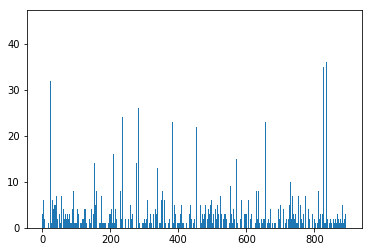

In [7]:
tmp = [x for x in res2.keys()]
plt.bar(tmp, res2.values(), 1)